In [ ]:
setwd("Z:\\A\\ST\\Analysis")
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(magrittr)
#通道函数

# Computationally intensive step needs parallelization with multicore
library(future)
plan("multicore", workers = 32)
plan()

In [2]:

data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
EDL <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
LD <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")

ERROR: Error in Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5"): could not find function "Load10X_Spatial"


In [ ]:
Sol@meta.data$orig.ident="Sol"
LD@meta.data$orig.ident="LD"
EDL@meta.data$orig.ident="EDL"

In [ ]:
Muscle.combined <- merge(Sol, y = c(LD,EDL), add.cell.ids = c("Sol", "LD", "EDL"), project = "muscle")
head(colnames(Muscle.combined))
tail(colnames(Muscle.combined))

Muscle.combined <- NormalizeData(Muscle.combined) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)
Muscle.combined <- JackStraw(Muscle.combined, num.replicate = 100)
Muscle.combined <- ScoreJackStraw(Muscle.combined, dims = 1:20)

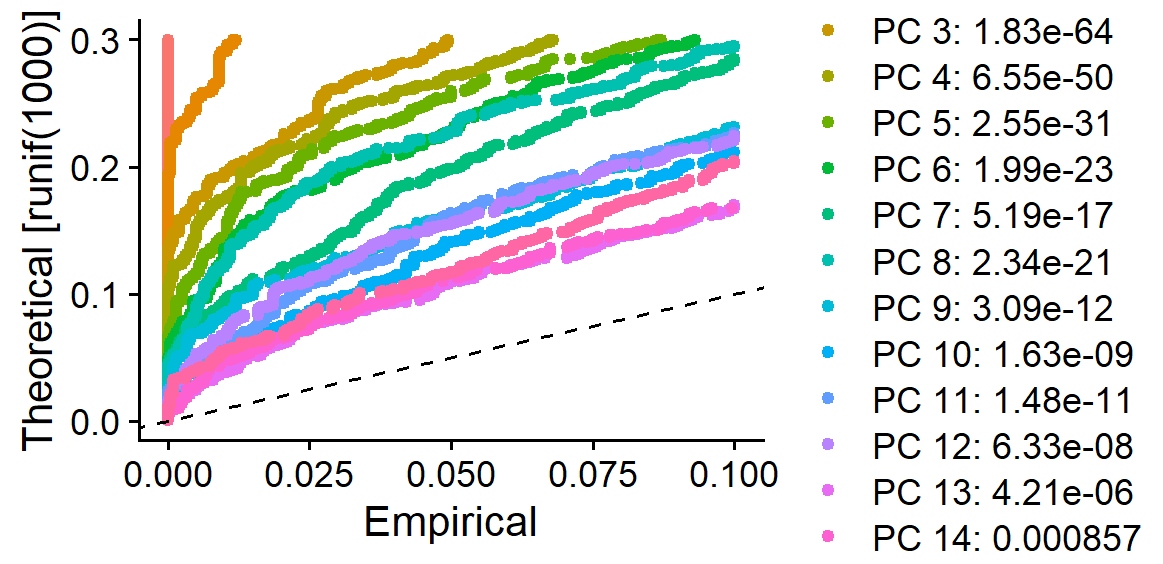

In [ ]:
Muscle.combined <- FindNeighbors(Muscle.combined, dims = 1:10)
Muscle.combined <- FindClusters(Muscle.combined, resolution = 0.5)

## Visum

In [ ]:
Muscle.combined <- RunUMAP(Muscle.combined, dims = 1:30)
#根据细胞群分类

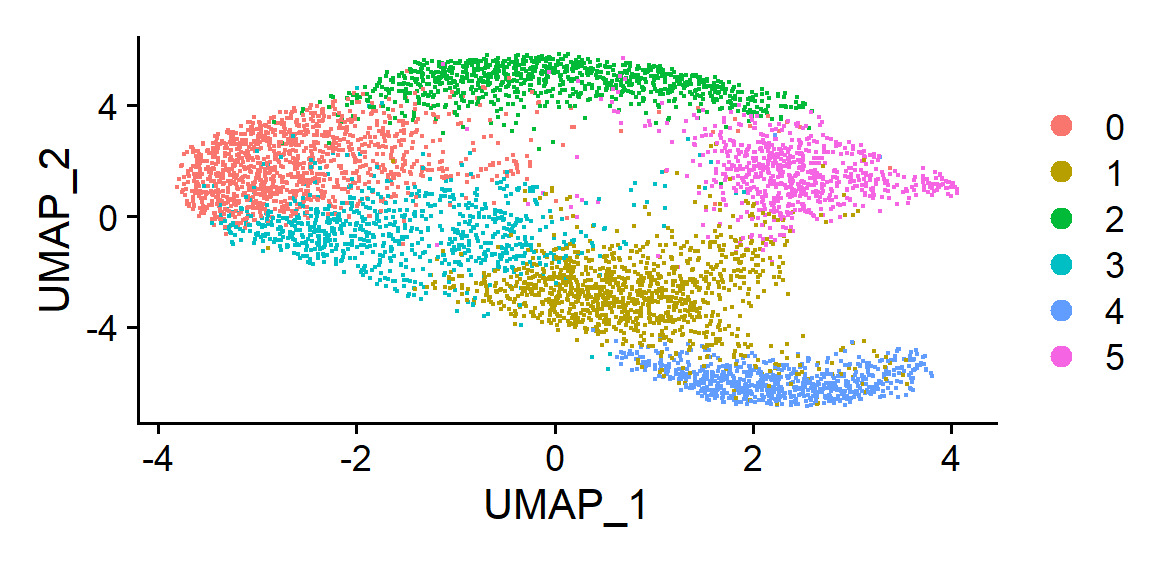

In [ ]:
DimPlot(Muscle.combined, group.by = "orig.ident")
#根据细胞来源聚类

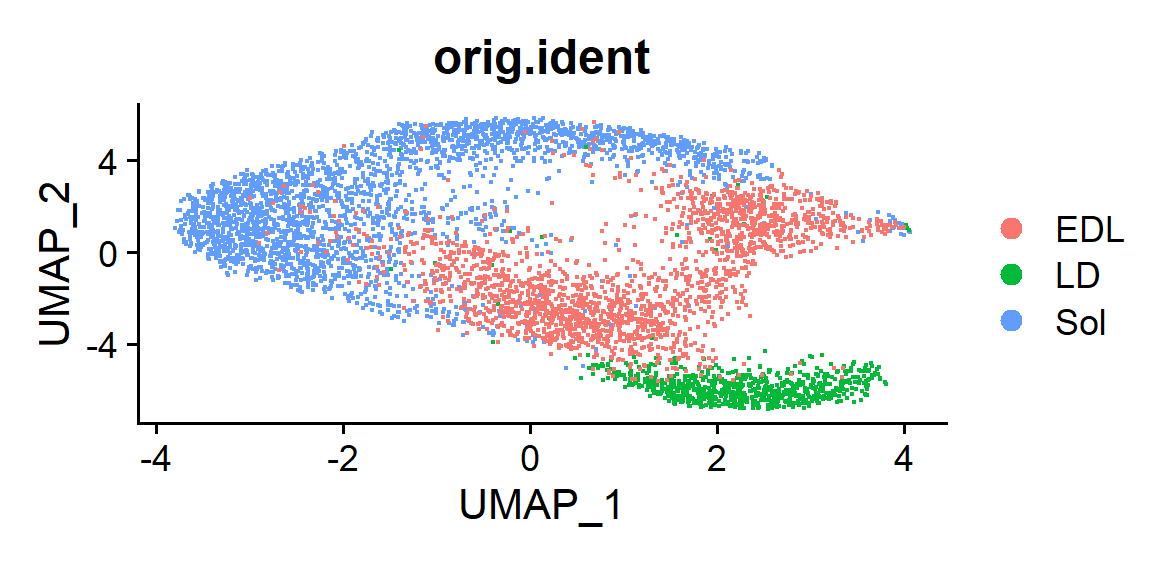

In [ ]:
DimPlot(Muscle.combined, group.by = "ident", split.by = 'orig.ident')
#根据细胞来源和细胞群共同聚类

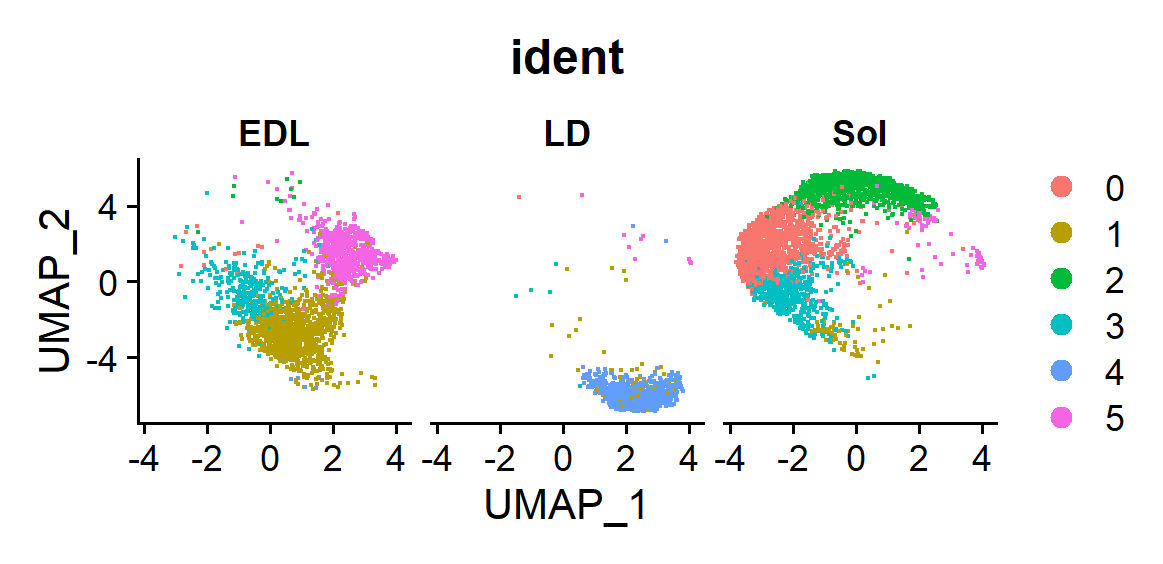

# 删除批次效应

## harmony法

In [ ]:
Muscle.combined.Merge <- RunHarmony(Muscle.combined, group.by.vars = "orig.ident")
Muscle.combined.Merge <- RunUMAP(Muscle.combined.Merge, reduction = "harmony", dims = 1:30)
Muscle.combined.Merge <- FindNeighbors(Muscle.combined.Merge, reduction = "harmony", dims = 1:30) %>% FindClusters()

In [ ]:
DimPlot(Muscle.combined.Merge, group.by = "ident", split.by = 'orig.ident')

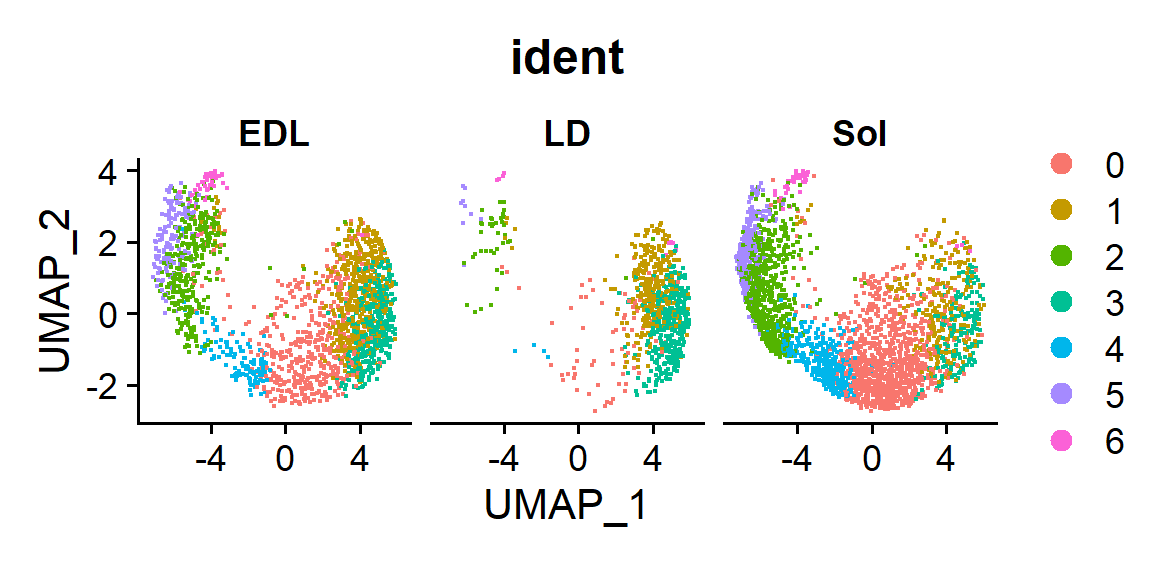

## Seurat法

In [ ]:
Muscle.list.st=list(Sol,EDL,LD)

#normalize and identify variable features for each dataset independently
Muscle.list.st <- lapply(X = Muscle.list.st, FUN = function(x) {
x <- NormalizeData(x)
x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = Muscle.list.st)

# Perform integration
muscle.anchors <- FindIntegrationAnchors(object.list = Muscle.list.st, anchor.features = features)

# this command creates an 'integrated' data assay
muscle.combined <- IntegrateData(anchorset = muscle.anchors)

# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(muscle.combined) <- "integrated"

In [ ]:
# Run the standard workflow for visualization and clustering
muscle.combined <- ScaleData(muscle.combined, verbose = FALSE)
muscle.combined <- RunPCA(muscle.combined, npcs = 30, verbose = FALSE)
muscle.combined <- RunUMAP(muscle.combined, reduction = "pca", dims = 1:30)
muscle.combined <- FindNeighbors(muscle.combined, reduction = "pca", dims = 1:30)
muscle.combined <- FindClusters(muscle.combined, resolution = 0.5)

In [ ]:
p1 <- DimPlot(muscle.combined, reduction = "umap", group.by = "orig.ident")
p2 <- DimPlot(muscle.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

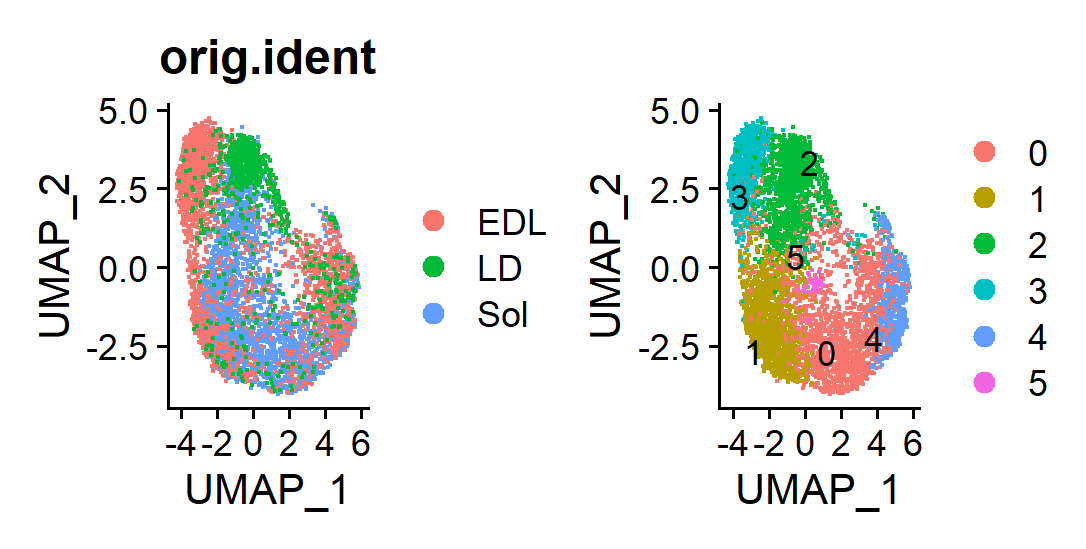

In [ ]:
##更改分辨率，继续分析

In [ ]:
# Run the standard workflow for visualization and clustering
resolution=0.25
muscle.combined <- ScaleData(muscle.combined, verbose = FALSE)
muscle.combined <- RunPCA(muscle.combined, npcs = 30, verbose = FALSE)
muscle.combined <- RunUMAP(muscle.combined, reduction = "pca", dims = 1:30)
muscle.combined <- FindNeighbors(muscle.combined, reduction = "pca", dims = 1:30)
muscle.combined <- FindClusters(muscle.combined, resolution = resolution)
rm(resolution)
p1 <- DimPlot(muscle.combined, reduction = "umap", group.by = "orig.ident")
p2 <- DimPlot(muscle.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2
## 6*5

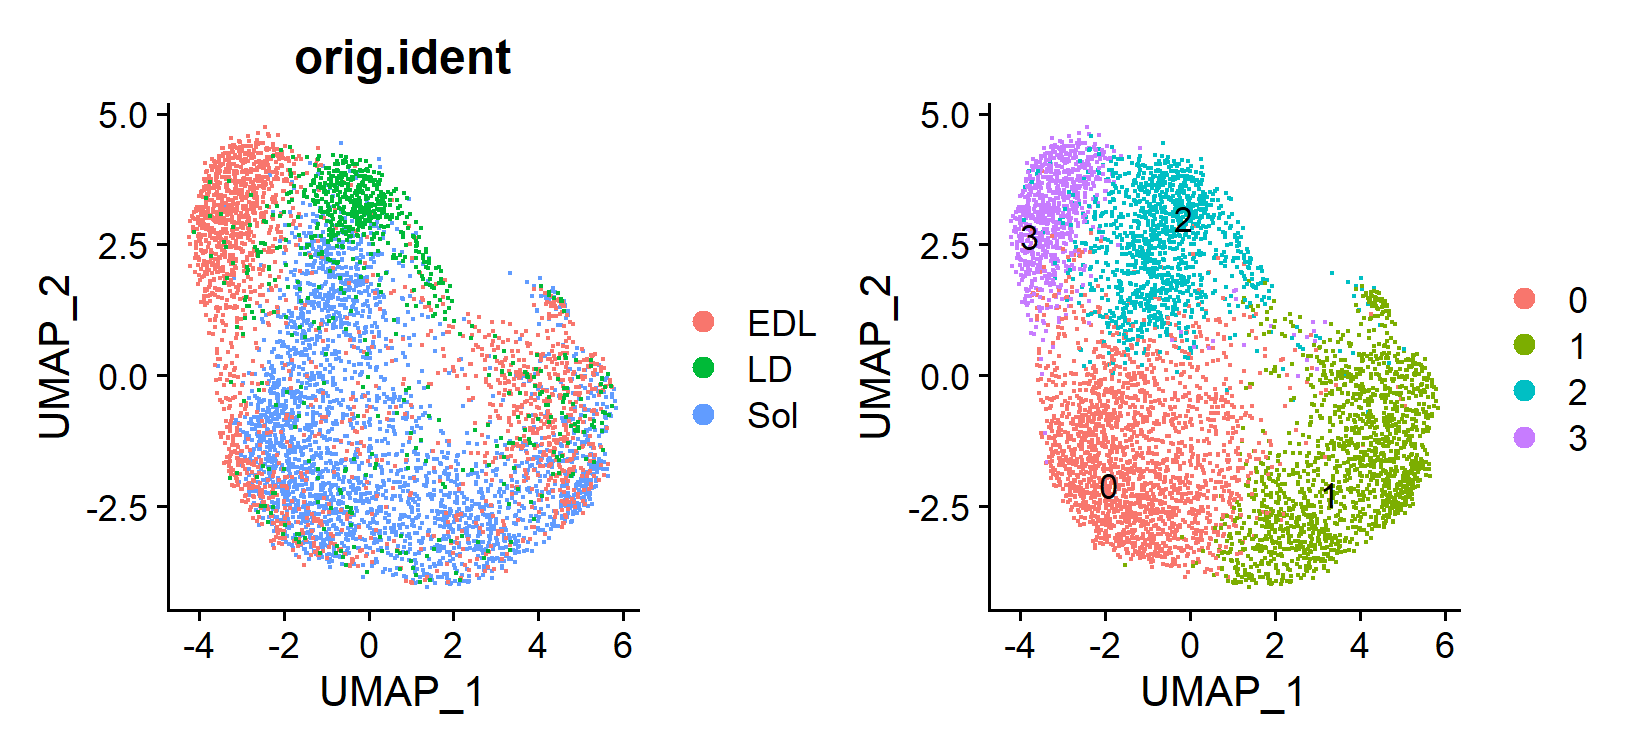

In [ ]:
Muscle.Merge.markers <- FindAllMarkers(muscle.combined, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
Muscle.Merge.markers %>% group_by(cluster) %>% slice_max(n = 3, order_by = avg_log2FC)

In [ ]:
Muscle.Merge.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC) -> top15.Marker
DoHeatmap(muscle.combined, features = top15.Marker$gene) + NoLegend()

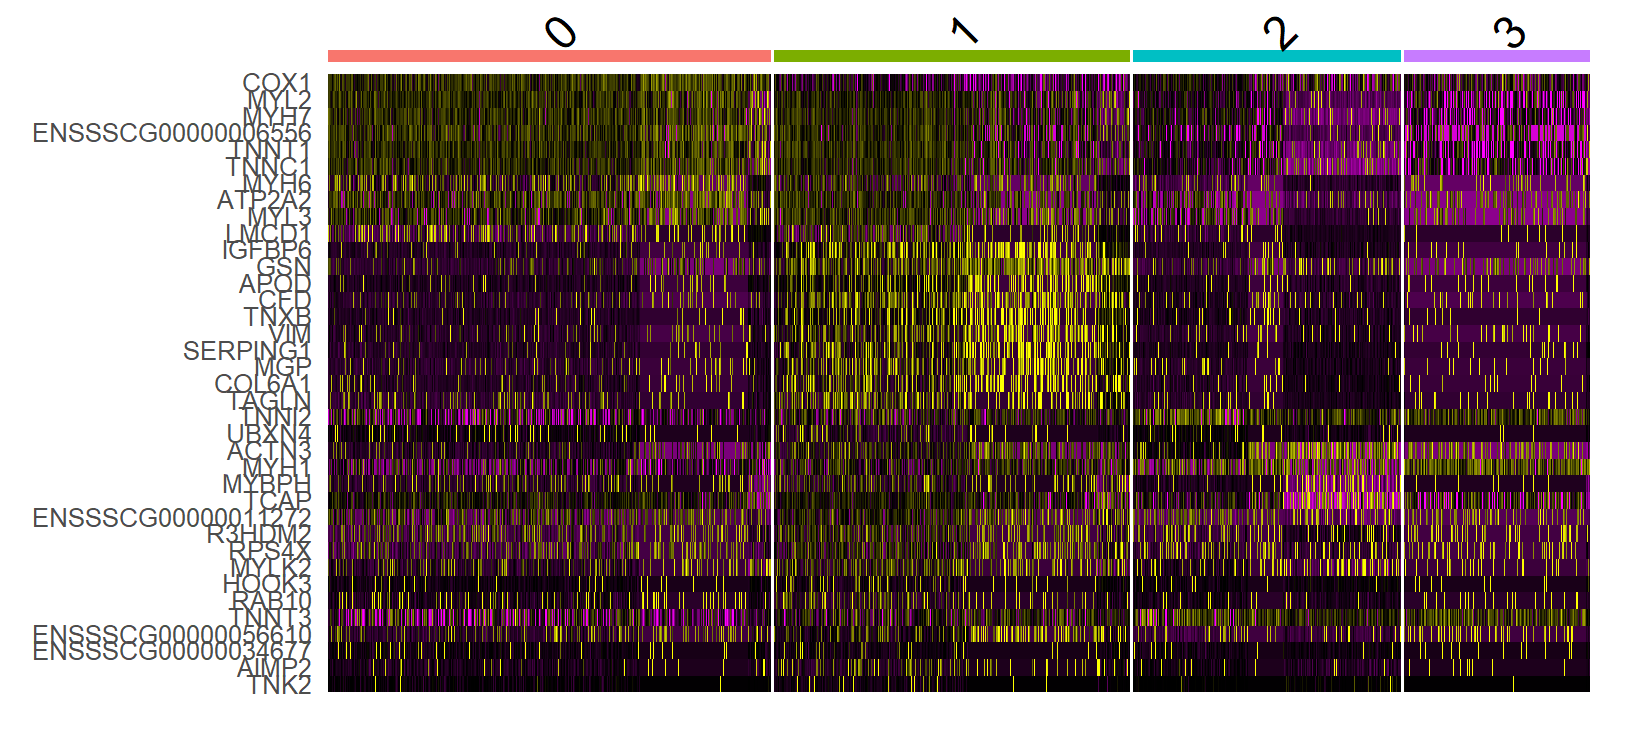

In [ ]:
top15.Marker.New=top15.Marker[c(-4,-27,-35,-37),]

In [ ]:
DoHeatmap(muscle.combined, features = top15.Marker.New$gene) + NoLegend()

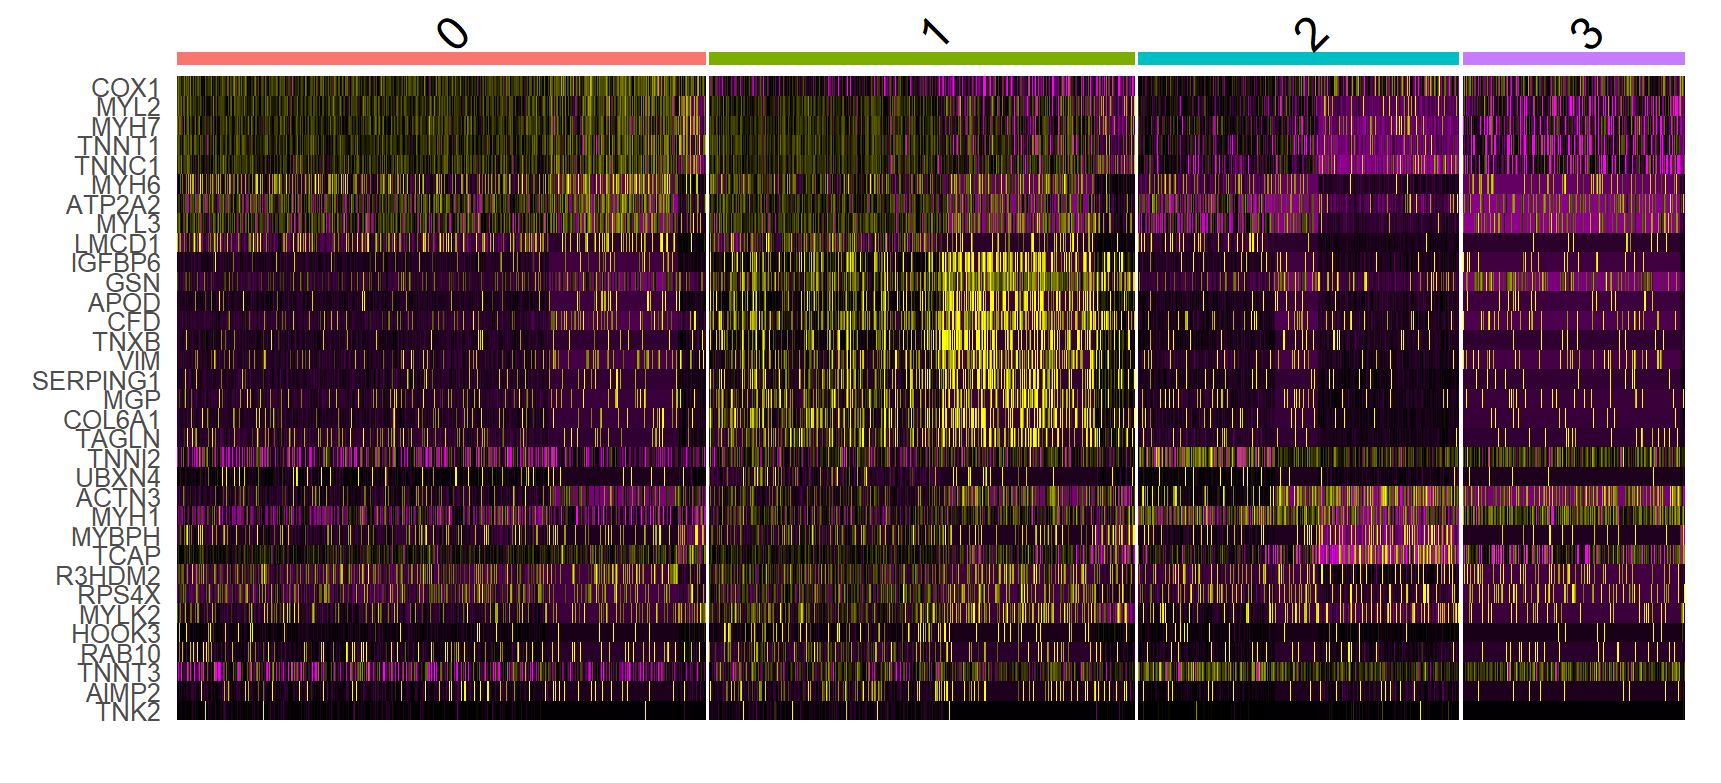

In [ ]:
FeaturePlot(muscle.combined, features = c("MYH7"), split.by = "orig.ident", max.cutoff = 3)
FeaturePlot(muscle.combined, features = c("MYH4"), split.by = "ident", max.cutoff = 3)
FeaturePlot(muscle.combined, features = c("MYH1"), split.by = "orig.ident", max.cutoff = 3)
FeaturePlot(muscle.combined, features = c("MYH2"), split.by = "orig.ident", max.cutoff = 3)
group.by = "ident", split.by = 'orig.ident'

In [ ]:
VlnPlot(muscle.combined, features = c("MYH7"), split.by = 'orig.ident')

In [ ]:
FeaturePlot(muscle.combined, features = c("MYH4"), split.by = "ident", max.cutoff = 3)

# Analysis, visualization, and integration of spatial datasets with Seurat

In [ ]:
library(Seurat)
library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)

In [ ]:
LD <- SCTransform(LD, assay = "Spatial", verbose = FALSE)
Sol <- SCTransform(Sol, assay = "Spatial", verbose = FALSE)
EDL <- SCTransform(EDL, assay = "Spatial", verbose = FALSE)

# 注释

In [ ]:
muscle.combined <- RenameIdents(muscle.combined, `0` = "Ⅰ myofibers", `1` = "ⅡA myofibers", `2` = "ⅡX myofibers", `3` = "ⅡB myofibers")
DimPlot(muscle.combined, label = FALSE)

# 单细胞部分

wget -O cellranger-7.1.0.tar.xz "https://cf.10xgenomics.com/releases/cell-exp/cellranger-7.1.0.tar.xz?Expires=1684334494&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZi4xMHhnZW5vbWljcy5jb20vcmVsZWFzZXMvY2VsbC1leHAvY2VsbHJhbmdlci03LjEuMC50YXIueHoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2ODQzMzQ0OTR9fX1dfQ__&Signature=RWpdeYA-LhFo803CbraNHs9rp5k2f2on~OLALEoyxEV36SDEYVD-M9XlxUlfJAkXPUf-NVp05ibxRCWa-GRZlFnqX3P9d8On5W-B1xBw2oZ9vXg7wL6msJisgiUBfo0gPQj1KnkWvdQ1x7eWWtDPbTR7LSC48QtT71yjdEI5rJ0kyPYPSGGNx8MUpS9e4bCqAA8aTaDiDPJhfBJs1QcxCXH40Pu0kzyJOafMuL~UxvEAWSOlzi1wm4cmiUOb8llZSKlJmvnwmDz5v6AY8NCL6lmAJhnT0M9IxHdIC~N90Nm63XyUI2In1JJoUy6aiEEsR-opv403bNv6Dst3I9GW-A__&Key-Pair-Id=APKAI7S6A5RYOXBWRPDA"
#下载

tar -xvf cellranger-7.1.0.tar.xz

In [ ]:
export PATH=/storage/public/home/2008116199/yxd/soft/cellranger/cellranger-7.1.0:$PATH
cellranger testrun --id=tiny
#设置默认路径与自检
/storage/public/home/2008116199/yxd/soft/cellranger/cellranger-8.0.1/bin/cellranger testrun --id=tiny

export PATH=/home/yixudong/software/cellranger/cellranger-7.1.0:$PATH

In [ ]:
mkdir ~/yard/run_cellranger_mkfastq
#设置工作环境

In [ ]:
cellranger mkgtf Sus_scrofa.Sscrofa11.1.109.gtf Sus_scrofa.Sscrofa11.1.109.filtered.gtf --attribute=key:allowable_value
#构建一个gtf文件

cellranger mkref --genome=Sus_scrofa --fasta=/home/yixudong/REF/Sus_scrofa.Sscrofa11.1.dna.toplevel.fa --genes=/home/yixudong/REF/cellranger/Sus_scrofa.Sscrofa11.1.109.chr.filtered.gtf
#构建一个参考基因组

In [ ]:
cellranger mkref --genome=Danio.rerio_genome --fasta=Danio_rerio.GRCz11.dna.primary_assembly.fa \
  --genes=Danio_rerio.GRCz11.105.filtered.gtf

In [ ]:
/home/yixudong/REF/Sus_scrofa/fasta

In [ ]:
cellranger count --id=run_count_SOL --fastqs=/home/yixudong/sn/SOL --sample=SOL-1 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa
cellranger count --id=run_count_SOL-2 --fastqs=/home/yixudong/sn/SOL --sample=SOL-2 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa
cellranger count --id=run_count_SOL-3 --fastqs=/home/yixudong/sn/SOL --sample=SOL-3 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa
cellranger count --id=run_count_SOL-4 --fastqs=/home/yixudong/sn/SOL --sample=SOL-4 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa
cellranger count --id=run_count_SOL-5 --fastqs=/home/yixudong/sn/SOL --sample=SOL-5 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa

In [ ]:
cellranger count --id=run_count_SOL --fastqs=/home/yixudong/sn/SOL --sample=SOL-1,SOL-2,SOL-3,SOL-4,SOL-5 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa

In [ ]:
cellranger count --id=run_count_EDL --fastqs=/home/yixudong/sn/EDL --sample=EDL-1,EDL-2,EDL-3,EDL-4,EDL-5 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa

In [ ]:
cellranger count --id=run_count_LD --fastqs=/home/yixudong/sn/LD --sample=LD-1,LD-2,LD-3 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa

In [ ]:
/home/yixudong/software/cellranger/cellranger-7.1.0/bin/cellranger count --id=run_count_LD --fastqs=/home/yixudong/Data/muscle --sample=WHB5CDNAPEP00008519 --transcriptome=/home/yixudong/sn/SOL/Sus_scrofa

## QC

In [ ]:
library(Seurat)
library(SeuratData)
library(patchwork)

In [ ]:
Sol_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_SOL\\outs\\filtered_feature_bc_matrix")
EDL_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_EDL\\outs\\filtered_feature_bc_matrix")
LD_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_LD\\outs\\filtered_feature_bc_matrix")

In [ ]:
Sol_Sc <- CreateSeuratObject(counts = Sol_Sc, project = "Sol", min.cells = 3, min.features = 200)
EDL_Sc <- CreateSeuratObject(counts = EDL_Sc, project = "EDL", min.cells = 3, min.features = 200)
LD_Sc <- CreateSeuratObject(counts = LD_Sc, project = "LD", min.cells = 3, min.features = 200)

In [ ]:
Sol_Sc[["percent.mt"]] <- PercentageFeatureSet(Sol_Sc, pattern = "^MT-")
EDL_Sc[["percent.mt"]] <- PercentageFeatureSet(EDL_Sc, pattern = "^MT-")
LD_Sc[["percent.mt"]] <- PercentageFeatureSet(LD_Sc, pattern = "^MT-")

p0=VlnPlot(Sol_Sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),pt.size=0,cols="#CCC9E6",ncol = 3)
p1=VlnPlot(EDL_Sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),pt.size=0,cols="#CCC9E6",ncol = 3)
p2=VlnPlot(LD_Sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),pt.size=0,cols="#CCC9E6", ncol = 3)
p0+p1+p2



In [ ]:
my36colors <-c('#CE0317', '#009959', '#3AD7CC', '#993591', '#D6E7A3', '#57C3F3', '#476D87',
               '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
               '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
               '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
               '#712820', '#DCC1DD', '#CCE0F5',  '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
               '#968175'
)

In [ ]:
Sol_Sc <- NormalizeData(Sol_Sc, normalization.method = "LogNormalize", scale.factor = 10000)
EDL_Sc <- NormalizeData(EDL_Sc, normalization.method = "LogNormalize", scale.factor = 10000)
LD_Sc <- NormalizeData(LD_Sc, normalization.method = "LogNormalize", scale.factor = 10000)

In [ ]:
Sol_Sc <- FindVariableFeatures(Sol_Sc, selection.method = "vst", nfeatures = 2000)
EDL_Sc <- FindVariableFeatures(EDL_Sc, selection.method = "vst", nfeatures = 2000)
LD_Sc <- FindVariableFeatures(LD_Sc, selection.method = "vst", nfeatures = 2000)
# Identify the 10 most highly variable genes
top20_Sol_Sc <- head(VariableFeatures(Sol_Sc), 20)
top20_EDL_Sc <- head(VariableFeatures(EDL_Sc), 20)
top20_LD_Sc <- head(VariableFeatures(LD_Sc), 20)
# plot variable features with and without labels
p3 <- VariableFeaturePlot(Sol_Sc,pt.size=3)
p4 <- LabelPoints(plot = p3, points = top20_Sol_Sc, repel = TRUE)

p5 <- VariableFeaturePlot(EDL_Sc,pt.size=3)
p6 <- LabelPoints(plot = p5, points = top20_EDL_Sc, repel = TRUE)

p7 <- VariableFeaturePlot(LD_Sc,pt.size=3)
p8 <- LabelPoints(plot = p7, points = top20_LD_Sc, repel = TRUE)

In [ ]:
MuScle.list.Sc=list(Sol_Sc,EDL_Sc,LD_Sc)

In [ ]:
MuScle.list.Sc <- lapply(X = MuScle.list.Sc, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})


In [ ]:
features.Sc <- SelectIntegrationFeatures(object.list = MuScle.list.Sc)
MuScle.Sc.anchors <- FindIntegrationAnchors(object.list = MuScle.list.Sc, anchor.features = features.Sc)
MuScle.list.Sc <- IntegrateData(anchorset = MuScle.Sc.anchors)

In [ ]:
DefaultAssay(MuScle.list.Sc) <- "integrated"

In [ ]:
## 确定分辨率
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(CellChat)
library(patchwork)
library(clustree)
test <- FindClusters(MuScle.list.Sc, resolution = seq(0.1, 0.5, 0.05)) #resolution从0.1到0.5，间隔0.05
p9 <- clustree(test)
p9 <- p9 + scale_color_manual(values = my36colors)
print(p9)

In [ ]:
MuScle.list.Sc <- ScaleData(MuScle.list.Sc, verbose = FALSE)
MuScle.list.Sc <- RunPCA(MuScle.list.Sc, npcs = 30, verbose = FALSE)
MuScle.list.Sc <- RunUMAP(MuScle.list.Sc, reduction = "pca", dims = 1:30)
MuScle.list.Sc <- FindNeighbors(MuScle.list.Sc, reduction = "pca", dims = 1:30)
MuScle.list.Sc <- FindClusters(MuScle.list.Sc, resolution = 0.3)
## 确定分辨率
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(CellChat)
library(patchwork)
library(clustree)
test <- FindClusters(MuScle.list.Sc, resolution = seq(0.1, 0.5, 0.05)) #resolution从0.1到0.5，间隔0.05
clus.tree.out <- clustree(test)
print(clus.tree.out)


MuScle.list.Sc <- FindClusters(MuScle.list.Sc, resolution = 0.3)

In [ ]:
p10 <- DimPlot(MuScle.list.Sc, reduction = "umap", group.by = "orig.ident",cols=c("#CE0317","#EFD06A","#009959"), pt.size=0.5)##(尺寸是6*7)
p11 <- DimPlot(MuScle.list.Sc, reduction = "umap", label = TRUE, repel = TRUE, cols=my36colors, pt.size=0.5)
p12 <- DimPlot(MuScle.list.Sc, reduction = "umap", label = TRUE, repel = TRUE, cols=my36colors, pt.size=0.5, split.by="orig.ident")

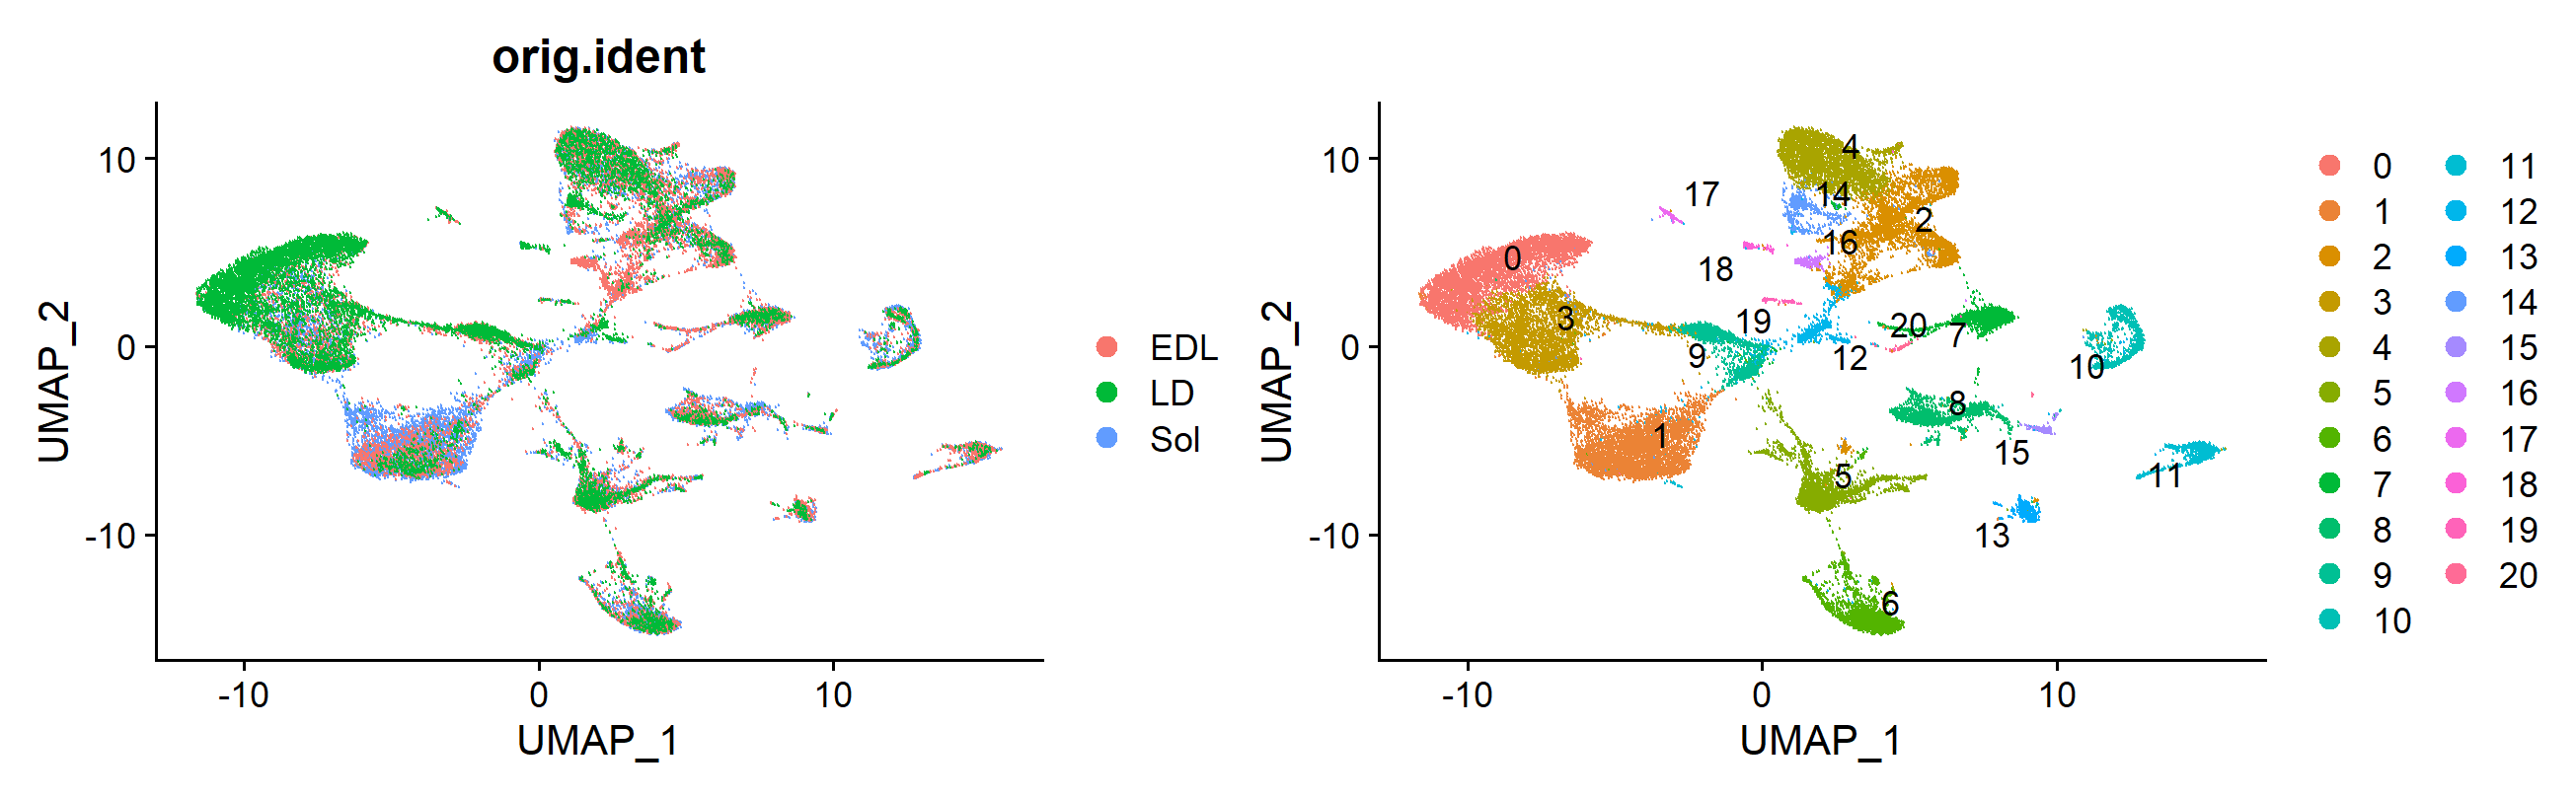

## 细胞注释

In [ ]:
# singleR
setwd("Z:\\A\\ST\\Analysis\\Results1\\SingleR")
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(CellChat)
library(patchwork)
library(SingleR)

SingleR <- GetAssayData(MuScle.list.Sc, slot = "data") 
SingleR.hesc <- SingleR(test = SingleR, ref = hpca.se, labels = hpca.se$label.main)  #
SingleR.hesc
#参考数据集
setwd("Z:\\A\\ST\\Analysis\\Results1\\SingleR\\REF")

## 读取H5数据
TA24M <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA24M.h5")
h5ls(TA24M)
TA24M <- h5read(TA24M, "twentyfourcounts")
TA5M <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA5M.h5")
h5ls(TA5M)
TA5M <- h5read(TA5M, "fivemonthcounts")
TA30M <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA30M.h5")
h5ls(TA30M)
TA30M <- h5read(TA30M, "thirtycounts")
TA10D <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA10D.h5")
h5ls(TA10D)
TA10D <- h5read(TA10D, "p10counts")
TA21D <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA21D.h5")
h5ls(TA21D)
TA21D <- h5read(TA21D, "p21counts")
SOL5M <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/SOL5M.h5")
h5ls(SOL5M)
SOL5M <- h5read(SOL5M, "soleuscounts")

TA24M <- CreateSeuratObject(counts = TA24M, project = "muscle", min.cells = 3, min.features = 200)
cell_barcodes <- h5read(TA24M, "barcodes")
gene_names <- h5read(TA24M, "gene_names")

h5file <- H5Fopen("Z:/A/ST/Analysis/Results1/SingleR/REF/TA24M.h5")
cell_barcodes <- h5read(h5file, "barcodes")
gene_names <- h5read(h5file, "gene_names")
TA24M <- h5read(h5file, "twentyfourcounts")
colnames(TA24M) <- cell_barcodes
rownames(TA24M) <- gene_names
#读取失败，因为h5文件缺少基因信息
######################################################
去https://www.synapse.org/#!Synapse:syn21676145 下载RDS文件

TA5M=readRDS("TA5M.RDS")
TA10D=readRDS("TA10D.RDS")
TA21D=readRDS("TA21D.RDS")
SOL5M=readRDS("SOL5M.RDS")
TA30M=readRDS("TA30M.RDS")
TA24M=readRDS("TA24M.RDS")

In [ ]:
DimPlot(TA5M,label=T)
DimPlot(TA10D,label=T)
DimPlot(TA21D,label=T)
DimPlot(SOL5M,label=T)
DimPlot(TA30M,label=T)
DimPlot(TA24M,label=T)

##数据整合
REF.list=list(TA5M,TA10D,TA21D,SOL5M,TA30M,TA24M)

REF.list <- lapply(X = REF.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

REF.Sc <- SelectIntegrationFeatures(object.list = REF.list)
REF.Sc.anchors <- FindIntegrationAnchors(object.list = REF.list, anchor.features = REF.Sc)
##运行完这一步先保存起来，避免出错

REF.list <- IntegrateData(anchorset = REF.Sc.anchors)
DefaultAssay(REF.list) <- "integrated"
REF.list <- ScaleData(REF.list, verbose = FALSE)
REF.list <- RunPCA(REF.list, npcs = 30, verbose = FALSE)
REF.list <- RunUMAP(REF.list, reduction = "pca", dims = 1:30)
REF.list <- FindNeighbors(REF.list, reduction = "pca", dims = 1:30)
REF.list <- FindClusters(REF.list, resolution = 0.5)
DimPlot(REF.list, reduction = "umap", label = TRUE, repel = TRUE, pt.size=0.5)
##细胞注释

In [ ]:
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(SingleCellExperiment)
library(SingleR)

setwd("Z:\\A\\ST\\Analysis\\Results1\\SingleR\\REF")

MuScle.list=readRDS("Z:\\A\\ST\\Analysis\\Results1\\SingleR\\MuScle.list.Sc.RDS")
MuScle.listSingleR <- GetAssayData(MuScle.list, slot = "data") 

#从SOL5M中提取矩阵###########以下为单个数据集作为参考集群

expr_matrix <- GetAssayData(SOL5M, assay = "RNA", slot = "counts")
sce_ref <- SingleCellExperiment(assays = list(counts = expr_matrix))
logcounts <- log1p(expr_matrix)
assays(sce_ref)$logcounts <- logcounts
labels <- as.character(SOL5M@active.ident)
# 运行SingleR
MuScle.list.SOL5M <- SingleR(test = MuScle.listSingleR, ref = sce_ref, labels = labels)

table(MuScle.list.SOL5M$labels, MuScle.list$seurat_clusters)

MuScle.list@meta.data$labels <- MuScle.list.SOL5M$labels
DimPlot(MuScle.list, group.by = c("seurat_clusters", "labels"), reduction = "pca")

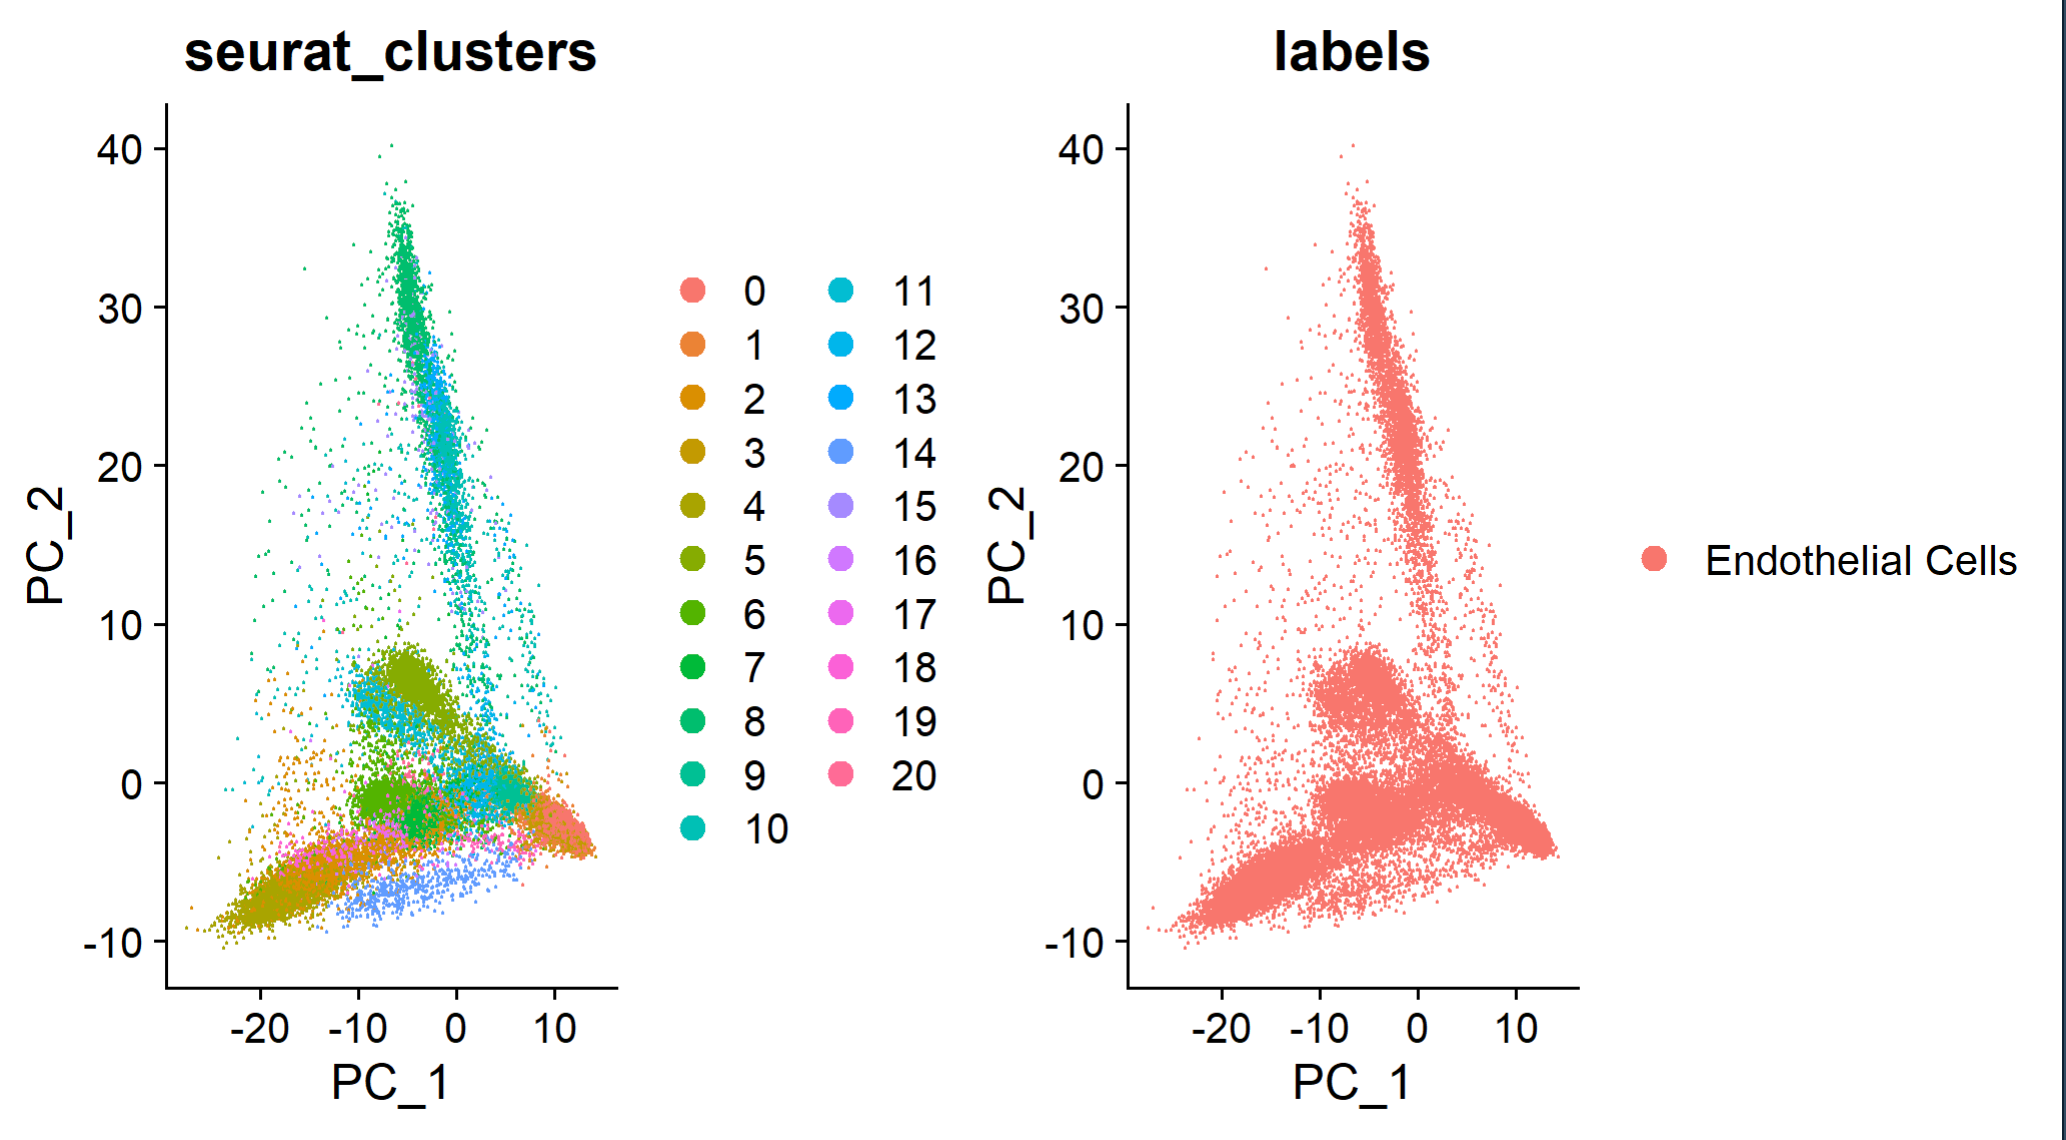

In [ ]:
##由于注释结果全部为内皮细胞群，考虑使用多个数据库连用进行map

In [ ]:
expr_matrix_SOL5M <- GetAssayData(SOL5M, assay = "RNA", slot = "counts")
expr_matrix_SOL5M@Dimnames[[1]] <- toupper(expr_matrix_SOL5M@Dimnames[[1]])
sce_ref_SOL5M <- SingleCellExperiment(assays = list(counts = expr_matrix_SOL5M))
logcounts_SOL5M <- log1p(expr_matrix_SOL5M)
assays(sce_ref_SOL5M)$logcounts <- logcounts_SOL5M
labels_SOL5M <- as.character(SOL5M@active.ident)

expr_matrix_TA10D <- GetAssayData(TA10D, assay = "RNA", slot = "counts")
expr_matrix_TA10D@Dimnames[[1]] <- toupper(expr_matrix_TA10D@Dimnames[[1]])
sce_ref_TA10D <- SingleCellExperiment(assays = list(counts = expr_matrix_TA10D))
logcounts_TA10D <- log1p(expr_matrix_TA10D)
assays(sce_ref_TA10D)$logcounts <- logcounts_TA10D
labels_TA10D <- as.character(TA10D@active.ident)

expr_matrix_TA21D <- GetAssayData(TA21D, assay = "RNA", slot = "counts")
expr_matrix_TA21D@Dimnames[[1]] <- toupper(expr_matrix_TA21D@Dimnames[[1]])
sce_ref_TA21D <- SingleCellExperiment(assays = list(counts = expr_matrix_TA21D))
logcounts_TA21D <- log1p(expr_matrix_TA21D)
assays(sce_ref_TA21D)$logcounts <- logcounts_TA21D
labels_TA21D <- as.character(TA21D@active.ident)

expr_matrix_TA5M <- GetAssayData(TA5M, assay = "RNA", slot = "counts")
expr_matrix_TA5M@Dimnames[[1]] <- toupper(expr_matrix_TA5M@Dimnames[[1]])
sce_ref_TA5M <- SingleCellExperiment(assays = list(counts = expr_matrix_TA5M))
logcounts_TA5M <- log1p(expr_matrix_TA5M)
assays(sce_ref_TA5M)$logcounts <- logcounts_TA5M
labels_TA5M <- as.character(TA5M@active.ident)

expr_matrix_TA24M <- GetAssayData(TA24M, assay = "RNA", slot = "counts")
expr_matrix_TA24M@Dimnames[[1]] <- toupper(expr_matrix_TA24M@Dimnames[[1]])
sce_ref_TA24M <- SingleCellExperiment(assays = list(counts = expr_matrix_TA24M))
logcounts_TA24M <- log1p(expr_matrix_TA24M)
assays(sce_ref_TA24M)$logcounts <- logcounts_TA24M
labels_TA24M <- as.character(TA24M@active.ident)

expr_matrix_TA30M <- GetAssayData(TA30M, assay = "RNA", slot = "counts")
expr_matrix_TA30M@Dimnames[[1]] <- toupper(expr_matrix_TA30M@Dimnames[[1]])
sce_ref_TA30M <- SingleCellExperiment(assays = list(counts = expr_matrix_TA30M))
logcounts_TA30M <- log1p(expr_matrix_TA30M)
assays(sce_ref_TA30M)$logcounts <- logcounts_TA30M
labels_TA30M <- as.character(TA30M@active.ident)

In [ ]:
MuScle.list.comb <- SingleR(test = MuScle.listSingleR, ref = list(sce_ref_SOL5M=sce_ref_SOL5M,sce_ref_TA10D=sce_ref_TA10D,sce_ref_TA21D=sce_ref_TA21D,sce_ref_TA5M=sce_ref_TA5M, sce_ref_TA24M = sce_ref_TA24M, sce_ref_TA30M = sce_ref_TA30M), labels = list(labels_SOL5M, labels_TA10D,labels_TA21D, labels_TA5M,labels_TA24M, labels_TA30M),tune.thresh=0.2)

In [ ]:
全是内皮细胞！应该把小鼠单细胞数据转化为大写

In [ ]:
MuScle.list@meta.data$labels <- MuScle.list.comb$labels

In [ ]:
DimPlot(MuScle.list, group.by = c("seurat_clusters", "labels"), reduction = "umap")

In [ ]:
p13=DimPlot(MuScle.list, group.by = c("seurat_clusters", "labels"), reduction = "pca",cols=my36colors )
p14=DimPlot(MuScle.list, group.by = c("seurat_clusters", "labels"), reduction = "pca",cols=my36colors )

In [ ]:
pdf('p15.pdf',height = 20,width = 30)
plotScoreHeatmap(MuScle.list.comb)
dev.off()

In [ ]:
pdf('p16.pdf',height = 40,width = 30)
plotDeltaDistribution(MuScle.list.comb, ncol = 3,this.color=my36colors,pruned.color="Red")
dev.off()

[SingleR教程](https://zhuanlan.zhihu.com/p/562315878?utm_id=0)

### 手动注释

In [ ]:
##借助热图辅助注释
DefaultAssay(MuScle.list.Sc) <- "RNA"

MuScle.Sc.markers <- FindAllMarkers(MuScle.list.Sc, only.pos = FALSE, min.pct = 0.25, logfc.threshold = 0.25)
MuScle.Sc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

top20.marker <- MuScle.Sc.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)							#绘制marker在各个cluster的热图

pdf(file="p17.pdf",width=18,height=35)    
DoHeatmap(MuScle.list.Sc, features = top20.marker$gene, label=T)
dev.off()	

##DoubletFinder
setwd("Z:\\A\\ST\\Analysis\\Results1\\DoubletFinder")
MuScle.list.Sc=readRDS("Z:\\A\\ST\\Analysis\\Results1\\DoubletFinder\\MuScle.list.Sc.RDS")
sweep.res.list_kidney <- paramSweep(MuScle.list.Sc, PCs = 1:30, sct = FALSE)
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)




In [ ]:
DefaultAssay(MuScle.list.Sc) <- "RNA"
FeaturePlot(MuScle.list.Sc, features = c("MYH7", "MYH2", "MYH1", "MYH4"))

In [ ]:
pdf(file="p100.pdf",width=18,height=35)    
VlnPlot(MuScle.list.Sc, features = c("SLCO5A1","PDPN","DGKG","NKAIN3","EPHA3","TMEM45A","MYO1D","RGCC","MRC2","TEC","TBXAS1","KYNU"), slot = "counts", log = TRUE)
dev.off()

In [ ]:
## 细胞注释结果
0-MYH4 [Type 2b myofibers]  T2bM
1-MYH7 [Tpye I myofibers]  TIM
2-[Fibro-adipogenic progenitors-1] 
4-[Fibro-adipogenic progenitors-2]
14-PDGFRA [Fibro-adipogenic progenitors-3]
3-MYH1 [Tpye 2x myofibers]
5-PECAM1,CD93,CDH5,MECOM,DACH1,PTPRB [Vascular endothelial cells]
6-ACTA2,PDE1C,MYLK,TAGLN [Smooth muscle cells]
7-PAX7(), [Quiescent satellite cells-1]
8-CD163,CD14,MRC1(CD206),TLR2(CD282),CSF1R(CD115) [Macrophages]
9-[Tpye 2a myofibers]
10-PTPRC(CD45),CD3D,CD3E,CD8A [T cells]
11-CCL21,PROX1,FLT4 [Lymphatic endothelial cells]
12-[Tpye 2a/x myofibers]
13-KIT(CD117),LYN,ITGA4(CD49D) [Mast cells]
15-MS4A1(CD20),CD80,PDCD1LG2(CD273),CIITA,FLT3(CD135) [B cells]
16-COL12A1,COL11A2,COL11A1,FNDC1,TNC,PDGFRA- [Perimysial cells]
17-FASN,ADIPOQ,PLIN1,PPARG,SCD [Mature adipocytes]
18-COL28A1,SORCS1,NEGR1 [Neurons]
19- [Quiescent satellite cells-2]
20-TOP2A+,PAX7+,MYOD1+ [Proliferating satellite cells]

In [ ]:
MuScle.list.Sc <- RenameIdents(MuScle.list.Sc, `0` = "Type 2b myofibers", `1` = "Type I myofibers", `2` = "FAPs-1", `3` = "Type 2x myofibers", `4` = "FAPs-2", `5` = "VECs", `6` = "Smooth muscle cells", `7` = "QSCs-1", `8` = "Macrophages", `9` = "Type 2a myofibers", `10` = "T cells", `11` = "LECs", `12` = "Type 2a/x myofibers", `13` = "Mast cells", `14` = "FAPs-3", `15` = "B cells", `16` = "Perimysial cells", `17` = "Mature adipocytes", `18` = "Neurons", `19` = "QSCs-2", `20` = "PSCs")
DimPlot(MuScle.list.Sc, label = FALSE)

In [ ]:
DimPlot(Subcluster_MuScle.Sc, reduction = "umap", group.by = "orig.ident")


In [ ]:
## 相关性热图
library(psych)
library(pheatmap)
library(Seurat)

head(AverageExpression(object = MuScle.list.Sc))
AverageExp <- AverageExpression(object = MuScle.list.Sc)
typeof(AverageExp)
head(AverageExp$RNA)


custom_row_order <- c("0", "3", "1", "9","12", "7", "19", "20", "2", "4", "14","16", "17", "13", "15", "8", "10", "5", "11", "6", "18")
custom_col_order <- c("0", "3", "1", "9","12", "7", "19", "20", "2", "4", "14","16", "17", "13", "15", "8", "10", "5", "11", "6", "18")
ordered_matrix <- coorda$r[custom_row_order, custom_col_order]

coorda<-corr.test(AverageExp$RNA,AverageExp$RNA,method = "spearman")
colors <- colorRampPalette(c("white","red"))(100)
pheatmap(ordered_matrix,color = colors,cluster_rows = FALSE, cluster_cols = FALSE)

pdf('p18.pdf',height = 20,width = 20)
pheatmap(coorda$r,color = colors)
dev.off()


In [ ]:
colors <- colorRampPalette(c("blue", "white", "#C2191F"))(100)
pheatmap(coorda$r, color = colors)

## Analysis

### 查看每类细胞比例并做图

In [ ]:
table(MuScle.list.Sc$orig.ident)
  EDL    LD   Sol 
10989 12043 11285 
#每个分组细胞的数量

In [ ]:
total.prop=prop.table(table(Idents(MuScle.list.Sc)))
total.prop <- as.data.frame(total.prop)
###可视化

p19=ggplot(total.prop, aes(x = "", y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = my36colors)+
  labs(x = NULL, y = "Ratio", fill = "Sample Type", title = "Sample Ratio by Type") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

table(Idents(MuScle.list.Sc), MuScle.list.Sc$orig.ident)#各组不同细胞群细胞数

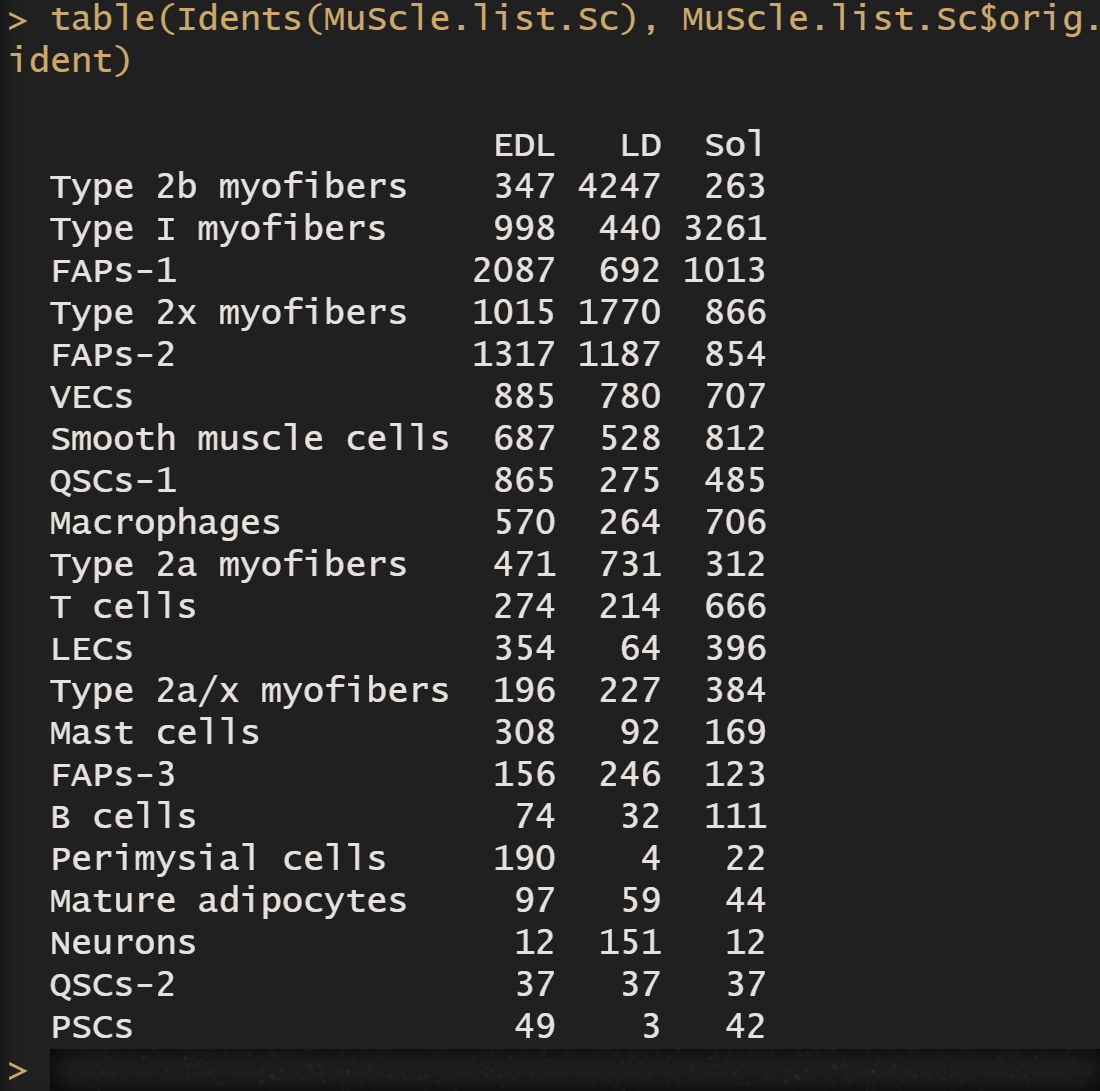

In [ ]:
Cellratio <- prop.table(table(Idents(MuScle.list.Sc), MuScle.list.Sc$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio

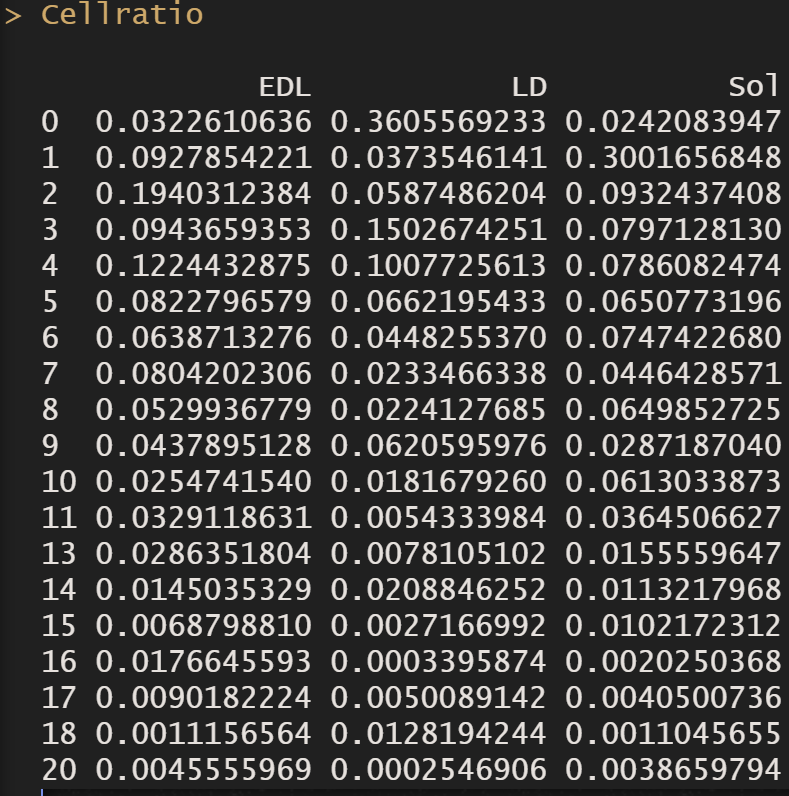

In [ ]:
Cellratio <- as.data.frame(Cellratio)
colourCount = length(unique(Cellratio$Var1))

In [ ]:
###可视化
p20=ggplot(Cellratio, aes(x = Var2, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = my36colors)+
  labs(x = NULL, y = "Ratio", fill = "Sample Type", title = "Sample Ratio by Type") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

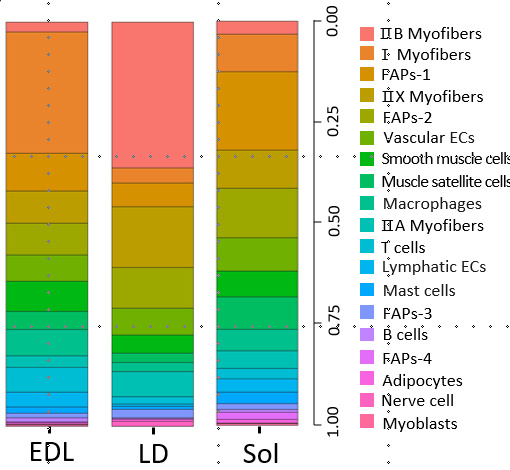

### 展示分群依据

In [ ]:
#封装：StackedVlnPlot是对Seurat的VlnPlot方法的封装，使用方法同VlnPlot
modify_vlnplot <- function(obj, feature, pt.size = 0, plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),...) {
  p <- VlnPlot(obj, features = feature, pt.size = pt.size, ... ) +
    theme_void() +
    ylab(feature) +
    theme(legend.position = 'none',
          plot.margin = plot.margin,
          title = element_blank(),
          axis.title.y = element_text(hjust = 0.5, angle = 0)
          )
  return(p)
}

## main function
StackedVlnPlot <- function(obj, features, pt.size = 0, plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"), ...) {
  plot_list <- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(angle = 90), axis.ticks.x = element_line())
  p <- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [ ]:
### 堆叠小提琴图
library(MySeuratWrappers)
markers <- c('MYH7', 'MYH1', 'MYH4', 'PAX7', 'MYOD1', 'TOP2A', 'ACTA2', 'CD163', 'CD3E', 
'KIT', 'FLT3', 'PDGFRA', 'COL12A1', 'ADIPOQ','PTPRB','CCL21', 'NEGR1')

desired_order <- c("Type I myofibers", "Type 2a myofibers", "Type 2a/x myofibers","Type 2x myofibers", "Type 2b myofibers","QSCs-1","QSCs-2", "PSCs", "Smooth muscle cells","Macrophages", "T cells", "Mast cells","B cells", "FAPs-1", "FAPs-2","FAPs-3", "Perimysial cells", "Mature adipocytes","VECs", "LECs", "Neurons") 

> my36colors
 [1] "#CE0317(Type 2b myofibers)" "#009959(Type I myofibers)" "#3AD7CC(FAPs-1)" "#993591(Type 2x myofibers)"
 [5] "#D6E7A3(FAPs-2)" "#57C3F3(VECs)" "#476D87(Smooth muscle cells)" "#E95C59(QSCs-1)"
 [9] "#E59CC4(Macrophages)" "#AB3282(Type 2a myofibers)" "#23452F(T cells)" "#BD956A(LECs)"
[13] "#8C549C(Type 2a/x myofibers)" "#585658(Mast cells)" "#9FA3A8(FAPs-3)" "#E0D4CA(B cells)"
[17] "#5F3D69(Perimysial cells)" "#C5DEBA(Mature adipocytes)" "#58A4C3(Neurons)" "#E4C755(QSCs-2)"
[21] "#F7F398(PSCs)" "#AA9A59()" "#E63863()" "#E39A35()"
[25] "#C1E6F3" "#6778AE" "#91D0BE" "#B53E2B"
[29] "#712820" "#DCC1DD" "#CCE0F5" "#CCC9E6"
[33] "#625D9E" "#68A180" "#3A6963" "#968175"

my36colors_2 = c("#009959","#AB3282","#8C549C","#993591","#CE0317","#E95C59","#E4C755","#F7F398","#476D87","#E59CC4","#23452F","#E0D4CA","#E0D4CA","#3AD7CC","#D6E7A3","#9FA3A8","#5F3D69","#C5DEBA","#57C3F3","#BD956A","#58A4C3")

MuScle.list.Sc.order=MuScle.list.Sc
MuScle.list.Sc.order@active.ident <- factor(MuScle.list.Sc.order@active.ident, levels = desired_order)

p21=VlnPlot(MuScle.list.Sc.order, features = markers, idents = desired_order, stacked = TRUE, pt.size = 0, cols = my36colors_2, direction = "horizontal") +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

0-MYH4 [Type 2b myofibers]  T2bM@
1-MYH7 [Type I myofibers]  TIM@
2-[FAPs-1] @
4-[FAPs-2]@
14-PDGFRA [FAPs-3]@
3-MYH1 [Type 2x myofibers]@
5-PECAM1,CD93,CDH5,MECOM,DACH1,PTPRB [VECs]@
6-ACTA2,PDE1C,MYLK,TAGLN [Smooth muscle cells]@
7-PAX7(), [QSCs-1]@
8-CD163,CD14,MRC1(CD206),TLR2(CD282),CSF1R(CD115) [Macrophages]@
9-[Type 2a myofibers]@
10-PTPRC(CD45),CD3D,CD3E,CD8A [T cells]@
11-CCL21,PROX1,FLT4 [LECs]@
12-[Type 2a/x myofibers]@
13-KIT(CD117),LYN,ITGA4(CD49D) [Mast cells]@
15-MS4A1(CD20),CD80,PDCD1LG2(CD273),CIITA,FLT3(CD135) [B cells]@
16-COL12A1,COL11A2,COL11A1,FNDC1,TNC,PDGFRA- [Perimysial cells]@
17-FASN,ADIPOQ,PLIN1,PPARG,SCD [Mature adipocytes]@
18-COL28A1,SORCS1,NEGR1 [Neurons]
19- [QSCs-2]@
20-TOP2A+,PAX7+,MYOD1+ [PSCs]@


VlnPlot(MuScle.list.Sc.order, features = c("CD163"), slot = "counts", log = TRUE)

In [ ]:
new.cluster.ids <- c("ⅡB Myofibers","Ⅰ Myofibers","FAPs-1", "ⅡX Myofibers","FAPs-2","Vascular ECs","Smooth muscle cells","MuSCs","macrophages","ⅡA Myofibers","T cells","Lymphatic ECs","Mast cell","FAPs-3","B cells","FAPs-4","Adipocytes","Nerve cell","Myoblasts")
names(new.cluster.ids) <- levels(Subcluster_MuScle.Sc)
Subcluster_MuScle.Sc <- RenameIdents(Subcluster_MuScle.Sc, new.cluster.ids)
DimPlot(Subcluster_MuScle.Sc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

# 空转部分

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results2")
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(magrittr)
#通道函数

# Computationally intensive step needs parallelization with multicore
library(future)
plan("multicore", workers = 32)
plan()

In [ ]:
data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
EDL <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
LD <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")

In [ ]:
Sol@meta.data$orig.ident="Sol"
LD@meta.data$orig.ident="LD"
EDL@meta.data$orig.ident="EDL"

In [ ]:
Muscle.combined <- merge(Sol, y = c(LD,EDL), add.cell.ids = c("Sol", "LD", "EDL"), project = "muscle")
head(colnames(Muscle.combined))
Muscle.combined <- NormalizeData(Muscle.combined) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)
Muscle.combined <- JackStraw(Muscle.combined, num.replicate = 100)
Muscle.combined <- ScoreJackStraw(Muscle.combined, dims = 1:20)
Muscle.combined <- FindNeighbors(Muscle.combined, dims = 1:10)
Muscle.combined <- FindClusters(Muscle.combined, resolution = 0.5)
Muscle.combined <- RunUMAP(Muscle.combined, dims = 1:30)

In [ ]:
Muscle.list.st=list(Sol,EDL,LD)

#normalize and identify variable features for each dataset independently
Muscle.list.st <- lapply(X = Muscle.list.st, FUN = function(x) {
x <- NormalizeData(x)
x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = Muscle.list.st)

# Perform integration
muscle.anchors <- FindIntegrationAnchors(object.list = Muscle.list.st, anchor.features = features)

# this command creates an 'integrated' data assay
muscle.combined <- IntegrateData(anchorset = muscle.anchors)

# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(muscle.combined) <- "integrated"

In [ ]:
library(clustree)
test <- FindClusters(muscle.combined.st, resolution = seq(0.3, 0.8, 0.05)) #resolution从0.1到0.5，间隔0.05
clus.tree.out <- clustree(test)
print(clus.tree.out)


In [ ]:
# Run the standard workflow for visualization and clustering
muscle.combined.st <- ScaleData(muscle.combined, verbose = FALSE)
muscle.combined.st <- RunPCA(muscle.combined.st, npcs = 30, verbose = FALSE)
muscle.combined.st <- RunUMAP(muscle.combined.st, reduction = "pca", dims = 1:30)
muscle.combined.st <- FindNeighbors(muscle.combined.st, reduction = "pca", dims = 1:30)
muscle.combined.st <- FindClusters(muscle.combined.st, resolution = 0.6)

In [ ]:
p22 <- DimPlot(muscle.combined.st, reduction = "umap", group.by = "orig.ident")
p23 <- DimPlot(muscle.combined.st, reduction = "umap", label = TRUE, repel = TRUE,cols=c("#00BA39","#1B07B3","#E5E012","#E41A1B","#3B3838"))



Idents(muscle.combined.st) <- muscle.combined.st$seurat_clusters
col <- c("#E41A1B", "#E5E012", "#1B07B3", "#3B3838", "#00BA39")
col <- head(col, length(unique(Idents(muscle.combined.st))))
names(col) <- unique(Idents(muscle.combined.st))
p24=SpatialPlot(muscle.combined.st, stroke = NA, image.alpha = 0.5, pt.size.factor = 1.5, cols = col)
p25=SpatialPlot(muscle.combined.st, stroke = NA, image.alpha = 0.5, pt.size.factor = 2, cols = col)


In [ ]:
VlnPlot(muscle.combined.st, features = c("PDGFRA"), slot = "counts", log = TRUE)

### Markers

In [ ]:
MuScle.st.markers <- FindAllMarkers(muscle.combined.st, only.pos = FALSE, min.pct = 0.25, logfc.threshold = 0.25)
MuScle.st.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

top20.marker <- MuScle.st.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)							#绘制marker在各个cluster的热图

pdf(file="p25.pdf",width=18,height=35)    
DoHeatmap(muscle.combined.st, features = top20.marker$gene, label=T)
dev.off()	

In [ ]:
0-MYH4 [Type 2b myofibers]  T2bM@
1-MYH7 [Type I myofibers]  TIM@
2-[FAPs-1] @
3-MYH1 [Type 2x myofibers]@
4-[FAPs-2]@
5-PECAM1,CD93,CDH5,MECOM,DACH1,PTPRB [VECs]@
6-ACTA2,PDE1C,MYLK,TAGLN [Smooth muscle cells]@
7-PAX7(), [QSCs-1]@
8-CD163,CD14,MRC1(CD206),TLR2(CD282),CSF1R(CD115) [Macrophages]@
9-[Type 2a myofibers]@
10-PTPRC(CD45),CD3D,CD3E,CD8A [T cells]@
11-CCL21,PROX1,FLT4 [LECs]@
12-[Type 2b/x myofibers]@
13-KIT(CD117),LYN,ITGA4(CD49D) [Mast cells]@
14-PDGFRA [FAPs-3]@
15-MS4A1(CD20),CD80,PDCD1LG2(CD273),CIITA,FLT3(CD135) [B cells]@
16-COL12A1,COL11A2,COL11A1,FNDC1,TNC,PDGFRA- [Perimysial cells]@
17-FASN,ADIPOQ,PLIN1,PPARG,SCD [Mature adipocytes]@
18-COL28A1,SORCS1,NEGR1 [Neurons]
19- [QSCs-2]@
20-TOP2A+,PAX7+,MYOD1+ [PSCs]@


moran_result <- calculate_morans_i(EDL, "SCD", 0)
print(moran_result)
SpatialFeaturePlot(EDL, features = c("PECAM1"),min.cutoff=0, max.cutoff=5)

moran_result <- calculate_morans_i(LD, "PDGFRA", 0)
print(moran_result)
SpatialFeaturePlot(LD, features = c("PDGFRA"),min.cutoff=0, max.cutoff=5)

moran_result <- calculate_morans_i(Sol, "PDGFRA", 0)
print(moran_result)
SpatialFeaturePlot(Sol, features = c("PDGFRA"),min.cutoff=0, max.cutoff=5)


In [ ]:
new.cluster.ids <- c("Type 2b myofibers","Type 2x myofibers","Type 2a Myofibers","Type I Myofibers","FAPs")
names(new.cluster.ids) <- levels(muscle.combined.st)
muscle.combined.st <- RenameIdents(muscle.combined.st, new.cluster.ids)
p26=DimPlot(muscle.combined.st, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()
#细胞注释

In [ ]:
FeaturePlot(LD_object, features = c("MYH7"), min.cutoff = 4,max.cutoff = 10,cols = c("#b6b6b6", "red"))



In [ ]:
Sol_object <- subset(MuScle.list.Sc, subset = orig.ident == "Sol")
EDL_object <- subset(MuScle.list.Sc, subset = orig.ident == "EDL")
LD_object <- subset(MuScle.list.Sc, subset = orig.ident == "LD")

In [ ]:
SpatialDimPlot(muscle.combined.st, label.size = 3,cols="Set1")


### 反卷积

#### SEURAT

In [ ]:
allen_reference <- readRDS("Z:\\A\\ST\\Analysis\\Results2\\SEURAT\\MuScle.Sc.RDS")

new.cluster.ids <- c("Type 2b myofibers","Type I myofibers","FAPs-1","Type 2x myofibers","FAPs-2","VECs","Smooth muscle cells","QSCs-1","Macrophages","Type 2a myofibers","T cells","LECs","Type 2a/x myofibers","Mast cells","FAPs-3","B cells","Perimysial cells","Mature adipocytes","Neurons","QSCs-2","PSCs")
names(new.cluster.ids) <- levels(allen_reference)
allen_reference <- RenameIdents(allen_reference, new.cluster.ids)

In [ ]:
library(dplyr)
options(future.globals.maxSize = 800 * 1024^2) 
#设置globals的最大内存为800M
allen_reference <- SCTransform(allen_reference, ncells = 3000, verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30)

In [ ]:
muscle.combined.st <- SCTransform(muscle.combined.st, assay = "Spatial", verbose = FALSE) %>%
    RunPCA(verbose = FALSE)
# the annotation is stored in the 'subclass' column of object metadata
p27=DimPlot(allen_reference, group.by = "seurat_clusters", label = TRUE)

In [ ]:
anchors <- FindTransferAnchors(reference = allen_reference, query = muscle.combined.st, normalization.method = "SCT")
predictions.assay <- TransferData(anchorset = anchors, refdata = allen_reference$seurat_clusters, prediction.assay = TRUE,
    weight.reduction = muscle.combined.st[["pca"]], dims = 1:30)
muscle.combined.st[["predictions"]] <- predictions.assay

In [ ]:
DefaultAssay(muscle.combined.st) <- "predictions"
SpatialFeaturePlot(muscle.combined.st, features = c("0"), pt.size.factor = 1.6, ncol = 2, crop = TRUE)

In [ ]:
### 数据结果有问题，初步推测是由于多对多或多对一、一对多的问题，接下来讲sc和st拆分成单个分析。

### 运行成功，但是结果并不是非常理想。此外还发现，多对一效果更好一点

### 运行“Working with multiple slices in Seurat”, 看不去除空转批次效应是否有影响,

### Working with multiple slices in Seurat与反卷积关系并不大，并且发现效果并没有多对一好

## 根据提示再把Sol和EDL跑完

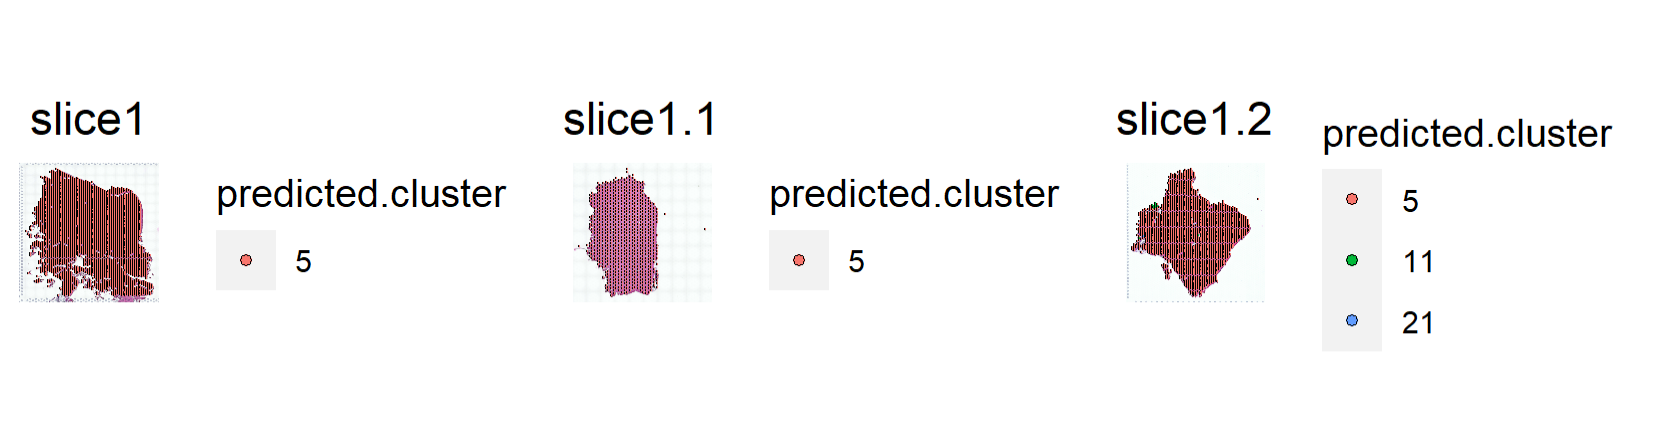

In [ ]:
Sol.sc <- subset(allen_reference, subset = orig.ident == "Sol")
EDL.sc <- subset(allen_reference, subset = orig.ident == "EDL")
LD.sc <- subset(allen_reference, subset = orig.ident == "LD")
#singcell rna-seq data

Sol.st <- subset(muscle.combined.st, subset = orig.ident == "Sol")
EDL.st <- subset(muscle.combined.st, subset = orig.ident == "EDL")
LD.st <- subset(muscle.combined.st, subset = orig.ident == "LD")
#st-seq data


Sol.st@images <- Sol.st@images[1] 
EDL.st@images <- EDL.st@images[2] 
LD.st@images <- LD.st@images[3] 

#删除多余的切片图像

In [ ]:
#### Sol反卷积

Sol.sc <- SCTransform(Sol.sc, ncells = 3000, verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30)

Sol.st <- SCTransform(Sol.st, assay = "Spatial", verbose = FALSE) %>%
    RunPCA(verbose = FALSE)

# the annotation is stored in the 'subclass' column of object metadata
p28=DimPlot(Sol.sc, group.by = "seurat_clusters", label = TRUE)

anchors <- FindTransferAnchors(reference = Sol.sc, query = Sol.st, normalization.method = "SCT")
predictions.assay <- TransferData(anchorset = anchors, refdata = Sol.sc$seurat_clusters, prediction.assay = TRUE,weight.reduction = Sol.st[["pca"]], dims = 1:30)
Sol.st[["predictions"]] <- predictions.assay


DefaultAssay(Sol.st) <- "predictions"
SpatialFeaturePlot(Sol.st, features = c("0"), pt.size.factor = 1.6, ncol = 2, crop = TRUE)

In [ ]:
#### EDL反卷积

EDL.sc <- SCTransform(EDL.sc, ncells = 3000, verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30)

EDL.st <- SCTransform(EDL.st, assay = "Spatial", verbose = FALSE) %>%
    RunPCA(verbose = FALSE)

# the annotation is stored in the 'subclass' column of object metadata
p28=DimPlot(EDL.sc, group.by = "seurat_clusters", label = TRUE)

anchors <- FindTransferAnchors(reference = EDL.sc, query = EDL.st, normalization.method = "SCT")
predictions.assay <- TransferData(anchorset = anchors, refdata = EDL.sc$seurat_clusters, prediction.assay = TRUE,weight.reduction = EDL.st[["pca"]], dims = 1:30)
EDL.st[["predictions"]] <- predictions.assay


DefaultAssay(EDL.st) <- "predictions"
SpatialFeaturePlot(EDL.st, features = c("0"), pt.size.factor = 1.6, ncol = 2, crop = TRUE)


SpatialDimPlot(LD.st, group.by = 'predicted.cluster')

In [ ]:
#### LD反卷积

new.cluster.ids <- c("Type 2b myofibers","Type I myofibers","FAPs-1","Type 2x myofibers","FAPs-2","VECs","Smooth muscle cells","QSCs-1","Macrophages","Type 2a myofibers","T cells","LECs","Type 2a/x myofibers","Mast cells","FAPs-3","B cells","Perimysial cells","Mature adipocytes","Neurons","QSCs-2","PSCs")
names(new.cluster.ids) <- levels(allen_reference)
allen_reference <- RenameIdents(allen_reference, new.cluster.ids)
p26=DimPlot(muscle.combined.st, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()




allen_reference <- RenameIdents(allen_reference, `0` = "Ⅰ Myofibers", `1` = "ⅡA Myofibers", `2` = "ⅡX Myofibers", `3` = "ⅡB Myofibers")
DimPlot(muscle.combined2, label = TRUE)


MuScle.list.Sc <- RenameIdents(MuScle.list.Sc, `0` = "Type 2b myofibers", `1` = "Type I myofibers", `2` = "FAPs-1", `3` = "Type 2x myofibers", `4` = "FAPs-2", `5` = "VECs", `6` = "Smooth muscle cells", `7` = "QSCs-1", `8` = "Macrophages", `9` = "Type 2a myofibers", `10` = "T cells", `11` = "LECs", `12` = "Type 2a/x myofibers", `13` = "Mast cells", `14` = "FAPs-3", `15` = "B cells", `16` = "Perimysial cells", `17` = "Mature adipocytes", `18` = "Neurons", `19` = "QSCs-2", `20` = "PSCs")



In [ ]:
# Working with multiple slices in Seurat

In [ ]:
data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

Sol.st <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
EDL.st <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
LD.st <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")

Sol.st@meta.data$orig.ident="Sol"
LD.st@meta.data$orig.ident="LD"
EDL.st@meta.data$orig.ident="EDL"

In [ ]:

Sol.st <- SCTransform(Sol.st, assay = "Spatial", verbose = FALSE)
EDL.st <- SCTransform(EDL.st, assay = "Spatial", verbose = FALSE)
LD.st <- SCTransform(LD.st, assay = "Spatial", verbose = FALSE)


Muscle.combined.st <- merge(Sol.st, y = c(LD.st,EDL.st), add.cell.ids = c("Sol", "LD", "EDL"), project = "muscle")

brain.merge=Muscle.combined.st

DefaultAssay(brain.merge) <- "SCT"
VariableFeatures(brain.merge) <- c(VariableFeatures(Sol.st), VariableFeatures(LD.st))
brain.merge <- RunPCA(brain.merge, verbose = FALSE)
brain.merge <- FindNeighbors(brain.merge, dims = 1:30)
brain.merge <- FindClusters(brain.merge, verbose = FALSE)
brain.merge <- RunUMAP(brain.merge, dims = 1:30)

## 这和去卷积没有关系

In [ ]:
############整体而言，Seurat 方法效果并不是很理想#######################################################

#### SPOTlight

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results2\\SPOTlight2")

In [ ]:
library(ggplot2)
library(SPOTlight)
library(SingleCellExperiment)
library(SpatialExperiment)
library(scater)
library(scran)
library(scuttle)
library(Matrix)
library(data.table)
library(Seurat)
library(dplyr)
library(gt)
library(igraph)
library(RColorBrewer)
library(scuttle)

In [ ]:
sce <- readRDS("Z:\\A\\ST\\Analysis\\Results2\\SEURAT\\MuScle.Sc.RDS")

In [ ]:
sce.Sol <- subset(sce, subset = orig.ident == "Sol")
sce.EDL <- subset(sce, subset = orig.ident == "EDL")
sce.LD <- subset(sce, subset = orig.ident == "LD")

In [ ]:
data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

spe.Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
spe.EDL <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
spe.LD  <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")

spe.Sol@meta.data$orig.ident="Sol"
spe.LD@meta.data$orig.ident="LD"
spe.EDL@meta.data$orig.ident="EDL"

spe.Sol@images <- spe.Sol@images[1] 
spe.LD@images <- spe.LD@images[2] 
spe.EDL@images <- spe.EDL@images[3] 

In [ ]:
sce.Sol <- as.SingleCellExperiment(sce.Sol)
sce.Sol <- logNormCounts(sce.Sol)

In [ ]:
genes <- !grepl(pattern = "^Rp[l|s]|Mt", x = rownames(sce.Sol))
dec <- modelGeneVar(sce.Sol, subset.row = genes)
plot(dec$mean, dec$total, xlab = "Mean log-expression", ylab = "Variance")
curve(metadata(dec)$trend(x), col = "blue", add = TRUE)

In [ ]:
hvg <- getTopHVGs(dec, n = 3000)

colLabels(sce.Sol) <- colData(sce.Sol)$ident

mgs <- scoreMarkers(sce.Sol, subset.row = genes)

In [ ]:
mgs_fil <- lapply(names(mgs), function(i) {
    x <- mgs[[i]]
    # Filter and keep relevant marker genes, those with AUC > 0.8
    x <- x[x$mean.AUC > 0.6, ]
    # Sort the genes from highest to lowest weight
    x <- x[order(x$mean.AUC, decreasing = TRUE), ]
    # Add gene and cluster id to the dataframe
    x$gene <- rownames(x)
    x$cluster <- i
    data.frame(x)
})
mgs_df <- do.call(rbind, mgs_fil)

In [ ]:
idx <- split(seq(ncol(sce.Sol)), sce.Sol$ident)

In [ ]:
n_cells <- 100
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})
sce.Sol <- sce.Sol[, unlist(cs_keep)]

In [ ]:
res <- SPOTlight(
    x = sce.Sol,
    y = spe.Sol,
    groups = as.character(sce.Sol$ident),
    mgs = mgs_df,
    hvg = hvg,
    weight_id = "mean.AUC",
    group_id = "cluster",
    gene_id = "gene")

head(mat <- res$mat)[, seq_len(3)]
mod <- res$NMF

In [ ]:
p30=plotTopicProfiles(
    x = mod,
    y = sce.Sol$ident,
    facet = FALSE,
    min_prop = 0.01,
    ncol = 1) +
    theme(aspect.ratio = 1)


p31=plotTopicProfiles(
    x = mod,
    y = sce.Sol$ident,
    facet = TRUE,
    min_prop = 0.01,
    ncol = 6)


p32=plotCorrelationMatrix(mat)


p33=plotInteractions(mat, which = "heatmap", metric = "prop")


p34=plotInteractions(mat, which = "network")


ct <- colnames(mat)
mat[mat < 0.1] <- 0

# Define color palette
# (here we use 'paletteMartin' from the 'colorBlindness' package)
paletteMartin <- c(
    "#000000", "#004949", "#009292", "#ff6db6", "#ffb6db", 
    "#490092", "#006ddb", "#b66dff", "#6db6ff", "#b6dbff", 
    "#920000", "#924900", "#db6d00", "#24ff24", "#ffff6d")

pal <- colorRampPalette(paletteMartin)(length(ct))
names(pal) <- ct

p35=plotSpatialScatterpie(
    x = spe.Sol,
    y = mat,
    cell_types = colnames(mat),
    img = FALSE,
    scatterpie_alpha = 1,
    pie_scale = 0.4) +
    scale_fill_manual(
        values = pal,
        breaks = names(pal))

In [ ]:
##LD的反卷积运算
P36-P42

In [ ]:
##EDL的反卷积运算
P43-P49

### 空间定量

In [ ]:
############数据预处理############
library(Seurat)
library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)
library(spatstat)
library(spatstat.geom)
library(spatstat.core)

data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
EDL <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
LD <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")


Sol@meta.data$orig.ident="Sol"
LD@meta.data$orig.ident="LD"
EDL@meta.data$orig.ident="EDL"

##空间数据质控
P50=VlnPlot(Sol, features = "nCount_Spatial", pt.size = 0,cols ="#D3E028") + NoLegend()
P51=SpatialFeaturePlot(Sol, features = "nCount_Spatial") + theme(legend.position = "right")

P52=VlnPlot(EDL, features = "nCount_Spatial", pt.size = 0,cols ="#D3E028") + NoLegend()
P53=SpatialFeaturePlot(EDL, features = "nCount_Spatial") + theme(legend.position = "right")

P54=VlnPlot(LD, features = "nCount_Spatial", pt.size = 0,cols ="#D3E028") + NoLegend()
P55=SpatialFeaturePlot(LD, features = "nCount_Spatial") + theme(legend.position = "right")

In [ ]:
############判断spot是随机分布还是聚类分布############
if ("VisiumV1" %in% class(Sol@images$slice1)) {
  coords <- Sol@images$slice1@coordinates
}

# 检查coords是否正确获取
head(coords)

# 现在coords应该是一个数据框，我们可以使用它来创建ppp对象
# 确保coords是一个数据框，且至少有两列代表x和y坐标
if (is.data.frame(coords) && ncol(coords) >= 2) {
  points <- ppp(x=coords[,1], y=coords[,2], window=owin(xrange=range(coords[,1]), yrange=range(coords[,2])))
}

expr <- FetchData(Sol, "COL1A1") 
expressing_cells <- which(expr$COL1A1 > 0.1)

if (length(expressing_cells) > 0 && is.data.frame(coords)) {
    # 根据表达细胞的索引筛选坐标
    filtered_coords <- coords[expressing_cells, ]
    # 检查是否有足够的数据并且没有NA值
    if (nrow(filtered_coords) > 1 && sum(is.na(filtered_coords)) == 0) {
        # 尝试计算xrange和yrange，确保它们有效
        x_range <- range(filtered_coords[,1], na.rm = TRUE)
        y_range <- range(filtered_coords[,2], na.rm = TRUE)

        # 检查xrange和yrange是否有效
        if (length(x_range) == 2 && x_range[1] < x_range[2] && length(y_range) == 2 && y_range[1] < y_range[2]) {
            expr_points <- ppp(x=filtered_coords[,1], y=filtered_coords[,2], 
                               window=owin(xrange=x_range, yrange=y_range))
        }
    }
}

if (nrow(filtered_coords) > 0) {
    # 假设row和col是实际的空间坐标
    x_range <- range(filtered_coords$row, na.rm = TRUE)
    y_range <- range(filtered_coords$col, na.rm = TRUE)
    
    if (length(x_range) == 2 && x_range[1] < x_range[2] && length(y_range) == 2 && y_range[1] < y_range[2]) {
        expr_points <- ppp(x=filtered_coords$row, y=filtered_coords$col, 
                           window=owin(xrange=x_range, yrange=y_range))
        print("expr_points object created successfully.")
    }
}


# 计算Ripley's K函数
K_result <- Kest(expr_points)

# 绘制Ripley's K函数图
plot(K_result, main="Ripley's K Function for COL1A1 Gene Expression")

# 分析结果
# 如果K(t)曲线在较小的距离尺度上高于CSR (Complete Spatial Randomness) 的期望线，则表明有聚集分布
# 如果K(t)曲线低于该线，则可能表明分布趋于均匀或者排斥

In [ ]:
#######代码封装#######
library(Seurat)
library(spatstat)
library(spatstat.geom)
library(spatstat.core)

generate_ripleys_k_plot <- function(seurat_obj, gene_name, expression_threshold) {
    # 获取空间坐标
    if (!"slice1" %in% names(seurat_obj@images)) {
        stop("The Seurat object does not contain spatial coordinates information under the expected name 'slice1'.")
    }
    coords <- seurat_obj@images$slice1@coordinates
    
    # 提取基因表达数据
    expr <- FetchData(seurat_obj, gene_name)
    
    # 筛选高于阈值的表达细胞
    expressing_cells <- which(expr[[gene_name]] > expression_threshold)
    
    # 检查和准备空间坐标
    if (length(expressing_cells) > 0) {
        filtered_coords <- coords[expressing_cells, , drop = FALSE]
        
        # 生成点过程模型（ppp对象）
        if (nrow(filtered_coords) > 0) {
            x_range <- range(filtered_coords[, 'row'], na.rm = TRUE)
            y_range <- range(filtered_coords[, 'col'], na.rm = TRUE)
            
            if (x_range[1] < x_range[2] && y_range[1] < y_range[2]) {
                expr_points <- ppp(x = filtered_coords[, 'row'], y = filtered_coords[, 'col'],
                                   window = owin(xrange = x_range, yrange = y_range))
                
                # 计算Ripley's K函数
                K_result <- Kest(expr_points)
                
                # 绘制Ripley's K函数图
                plot(K_result, main = paste("Ripley's K Function for", gene_name, "Gene Expression"))
            } else {
                stop("Invalid ranges for x or y coordinates.")
            }
        } else {
            warning("No cells expressing", gene_name, "above the threshold of", expression_threshold)
        }
    } else {
        warning("No expressing cells found for gene", gene_name, "above the threshold of", expression_threshold)
    }
}

#######Ripley's K可视化#######
generate_ripleys_k_plot(Sol, "COL1A1", 0.1) #通过K判断是随机分布还是聚类分布

#######空间分布可视化#######
SpatialFeaturePlot(EDL, features = "MYH1",min.cutoff=1,max.cutoff = 2)

P57=generate_ripleys_k_plot(Sol, "COL1A1", 0.1)

P58=generate_ripleys_k_plot(LD, "FLT4", 0.1)

In [ ]:
############判断spot是否为线性分布############
library(Seurat)
library(tidyverse)

library(Seurat)
library(tidyverse)
library(spatstat)

# 定义函数
analyze_spatial_linearity <- function(seurat_obj, gene_name, threshold = 0.1) {
  # 获取空间坐标
  if (!"VisiumV1" %in% class(seurat_obj@images$slice1)) {
    stop("Spatial coordinates are not available in the Seurat object.")
  }
  coords <- seurat_obj@images$slice1@coordinates

  # 提取基因表达数据
  gene_expression <- FetchData(seurat_obj, gene_name)

  # 合并空间坐标和基因表达数据
  spatial_data <- cbind(coords, gene_expression)

  # 筛选基因表达大于阈值的细胞
  expressing_cells <- spatial_data[spatial_data[, gene_name] > threshold, ]

  # 检查是否有足够的数据点进行分析
  if (nrow(expressing_cells) <= 1) {
    stop("Not enough data points with gene expression above the threshold.")
  }

  # 执行PCA分析
  pca_results <- prcomp(expressing_cells[, c("row", "col")])

  # 绘制细胞分布和第一主成分的方向
  plot(expressing_cells$col, expressing_cells$row, main = paste("Spatial Distribution of", gene_name),
       xlab = "Spatial X", ylab = "Spatial Y", pch = 19, cex = 0.5)
  abline(pca_results$rotation[1,1], pca_results$rotation[2,1], col = "red", lwd = 2)

  # 返回PCA结果
  return(list(pca_results = pca_results, expressing_cells = expressing_cells))
}

# 调用函数
result <- analyze_spatial_linearity(Sol, "COL1A1")

#上述代码运行没有问题，但是仅适用于简单的情况，比如一条血管均匀线性分布在组织中
#在实际情况中，血管可能呈现复杂的弯曲的网状分布


In [ ]:
############其他方法：L函数############
library(Seurat)
library(spatstat)

analyze_complex_vascular_structure <- function(seurat_obj, gene_name) {
  # 获取空间坐标
  if (!"VisiumV1" %in% class(seurat_obj@images$slice1)) {
    stop("Spatial coordinates are not available in the Seurat object.")
  }
  coords <- seurat_obj@images$slice1@coordinates

  # 提取基因表达数据
  gene_expression <- FetchData(seurat_obj, gene_name)

  # 合并空间坐标和基因表达数据
  spatial_data <- cbind(coords, gene_expression)

  # 过滤没有表达的细胞
  spatial_data <- spatial_data[spatial_data[, gene_name] > 0, ]

  # 检查是否有足够的数据点
  if (nrow(spatial_data) <= 1) {
    stop("Not enough data points with gene expression above the threshold.")
  }

  # 创建点模式对象
  window <- owin(xrange = range(spatial_data$col), yrange = range(spatial_data$row))
  points <- ppp(x = spatial_data$col, y = spatial_data$row, window = window)

  # 使用空间统计模型分析复杂空间结构
  # 例如，使用L函数（Lest）检测空间聚集趋势
  L_result <- Lest(points)

  # 可视化L函数
  plot(L_result, main = paste("L Function for gene", gene_name))

  # 返回结果列表
  return(list(L_result = L_result, points = points))
}

# 对Seurat对象中的特定基因进行复杂空间模式分析
analyze_complex_vascular_structure(Sol, "PECAM1")
#L函数是Ripley's K函数的进阶版，但是都只能判断离散还是聚类，无法判断线性的情况

In [ ]:
############其他方法：莫兰指数(Moran's I)############
library(Seurat)
library(spdep)
library(ape)

calculate_morans_i <- function(seurat_obj, gene_name, expression_threshold = 1) {
    # 检查基因是否在Seurat对象中
    if (!gene_name %in% rownames(seurat_obj[["Spatial"]])) {
        stop(paste(gene_name, "is not a valid feature in the Seurat object."))
    }

    # 提取基因表达数据
    gene_expression <- FetchData(seurat_obj, gene_name)

    # 确保提取了数据
    if (is.null(gene_expression)) {
        stop("Gene expression data could not be retrieved.")
    }

    # 筛选出表达量超过阈值的细胞
    expressing_cells <- gene_expression[gene_expression[, gene_name] > expression_threshold, , drop = FALSE]

    # 检查是否有筛选出的细胞
    if (nrow(expressing_cells) == 0) {
        stop(paste("No cells with", gene_name, "expression above", expression_threshold, "were found."))
    }

    # 获取这些细胞的空间坐标
    coords <- GetTissueCoordinates(seurat_obj)
    if (is.null(coords)) {
        stop("Spatial coordinates data could not be retrieved.")
    }

    # 匹配细胞名称和坐标
    expressing_coords <- coords[rownames(expressing_cells), ]

    # 检查是否成功匹配坐标
    if (nrow(expressing_coords) != nrow(expressing_cells)) {
        stop("The number of expressing cells does not match the number of coordinates retrieved.")
    }

    # 计算邻居距离矩阵
    distances <- as.matrix(dist(cbind(expressing_coords$imagerow, expressing_coords$imagecol)))

    # 定义邻居的阈值距离，这里以最大距离的一个分位数为例
    distance_threshold <- quantile(distances, probs = 0.1, na.rm = TRUE)

    # 创建邻居对象
    neighbors <- dnearneigh(cbind(expressing_coords$imagerow, expressing_coords$imagecol), 0, distance_threshold)

    # 创建权重矩阵
    weights <- nb2listw(neighbors, style = "W", zero.policy = TRUE)

    # 计算Moran's I
    moran <- moran.test(expressing_cells[, gene_name], weights)

    # 返回Moran's I结果
    return(moran)
}

moran_result <- calculate_morans_i(Sol, "PECAM1", 1)
print(moran_result)

#莫兰指数的解读
Moran I statistic: 这是Moran's I的实际计算值,它表示空间自相关的程度。它的值为0.023538014，这是一个接近零但略微正的值，意味着有轻微的正空间自相关或聚集趋势。
Expectation: Moran's I的期望值在完全随机分布的情况下为负,通常接近于-1/(n-1)，其中n是样本数量。在这里，它是-0.008130081。
Variance: 这是Moran's I统计量的方差,它告诉我们Moran's I的值的分散程度。这个值是0.001830728。
Standard deviate: 这是Moran I统计量的标准偏差值,它是0.74013。它告诉我们Moran I统计量与其期望值相比有多少标准偏差。
p-value: p值是用来确定统计显著性的。在这里,p值是0.2296,这意味着如果空间分布是随机的，得到当前Moran I值或更极端值的概率是22.96%。因为这个值大于通常的显著性水平（如0.05），所以我们不能拒绝空间随机分布的零假设。
alternative hypothesis: greater: 这表明我们测试的替代假设是空间聚集（Moran's I值大于期望值）。

moran_result <- calculate_morans_i(EDL, "PECAM1", 1)
print(moran_result)

In [ ]:
tissue <- c("Mature adipocytes", "LECs", "Neurons", "VECs", "FAPs", "Mast cells", "T cells", "Smooth muscle cells", "Macrophages", "B cells", "QSCs", "Perimysial cells", "PSCs")
edl <- c(0.8548524, 0.3686144, 0.34992, 0.471428572, 0.077668144, -0.08622, -0.3333332, -0.71433092, 0.12121212, -0.30063136, -0.610216, -0.739732, -0.502)
ld <- c(0.5748934, 0.424348812, 0.22676, 0.227555182, 0.20589692, -0.263768, -0.18158296, 0.262096331, -0.21347248, -0.667704, -0.565259, -0.36247088, -0.565259)
sol <- c(0.3711755, 0.498945788, 0.454993148, 0.24040488, 0.265324184, 0.35845412, 0.226816356, 0.13336068, -0.312376512, -0.4096764, -0.283770288, -0.40089284, -0.459433)

data <- data.frame(tissue, edl, ld, sol)

# 确保横坐标的顺序与数据中的顺序相匹配
data$tissue <- factor(data$tissue, levels = data$tissue)

# 绘图
ggplot(data, aes(x = tissue)) + 
  geom_col(aes(y = edl, fill = "EDL"), position = position_dodge(width = 0.8)) + # 柱状图，EDL
  geom_col(aes(y = ld, fill = "LD"), position = position_dodge(width = 0.8)) + # 柱状图，LD
  geom_col(aes(y = sol, fill = "SOL"), position = position_dodge(width = 0.8)) + # 柱状图，SOL
  geom_line(aes(y = edl, group = 1, color = "EDL"), size = 1) + # 折线图，EDL
  geom_line(aes(y = ld, group = 1, color = "LD"), size = 1) + # 折线图，LD
  geom_line(aes(y = sol, group = 1, color = "SOL"), size = 1) + # 折线图，SOL
  geom_point(aes(y = edl, color = "EDL"), size = 3) + # 数据点，EDL
  geom_point(aes(y = ld, color = "LD"), size = 3) + # 数据点，LD
  geom_point(aes(y = sol, color = "SOL"), size = 3) + # 数据点，SOL
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + # x轴标签倾斜
  scale_fill_manual(values = c("EDL" = "lightblue", "LD" = "lightgreen", "SOL" = "pink")) +
  scale_color_manual(values = c("EDL" = "blue", "LD" = "green", "SOL" = "red")) +
  labs(x = "Tissue", y = "Values", title = "Values for Different Tissues") # 
#堆叠柱状图

tissue <- c("Mature adipocytes", "LECs", "Neurons", "VECs", "FAPs", "Mast cells", "T cells", "Smooth muscle cells", "Macrophages", "B cells", "QSCs", "Perimysial cells", "PSCs")
edl <- c(0.8548524, 0.3686144, 0.34992, 0.471428572, 0.077668144, -0.08622, -0.3333332, -0.71433092, 0.12121212, -0.30063136, -0.610216, -0.739732, -0.502)
ld <- c(0.5748934, 0.424348812, 0.22676, 0.227555182, 0.20589692, -0.263768, -0.18158296, 0.262096331, -0.21347248, -0.667704, -0.565259, -0.36247088, -0.565259)
sol <- c(0.3711755, 0.498945788, 0.454993148, 0.24040488, 0.265324184, 0.35845412, 0.226816356, 0.13336068, -0.312376512, -0.4096764, -0.283770288, -0.40089284, -0.459433)

data <- data.frame(tissue, edl, ld, sol)
data$tissue <- factor(data$tissue, levels = data$tissue)
# 将数据转换为长格式
data_long <- tidyr::pivot_longer(data, cols = c("edl", "ld", "sol"), names_to = "measurement", values_to = "value")

# 绘图
P56=ggplot(data_long, aes(x = tissue, y = value, fill = measurement)) + 
  geom_col(position = position_dodge(width = 0.8)) + # 柱状图，不同列分开
  geom_line(aes(group = measurement, color = measurement), position = position_dodge(width = 0.8)) + # 折线图，不同列分开
  geom_point(aes(color = measurement), position = position_dodge(width = 0.8), size = 3) + # 数据点，不同列分开
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + # x轴标签倾斜
  scale_fill_manual(values = c("edl" = "lightblue", "ld" = "lightgreen", "sol" = "pink")) +
  scale_color_manual(values = c("edl" = "blue", "ld" = "green", "sol" = "red")) +
  labs(x = "Tissue", y = "Values", title = "Values for Different Tissues") # 标签和标题

In [ ]:
############其他方法：Hough变换（Hough Transform）############

library(Seurat)
library(imager)

# 提取基因表达数据和空间坐标
gene_expression <- FetchData(Sol, "PECAM1")
coords <- GetTissueCoordinates(Sol)

# 筛选出表达PECAM1的细胞
expressing_cells <- gene_expression[gene_expression$PECAM1 > 0, , drop = FALSE]
expressing_coords <- coords[rownames(expressing_cells), ]

#Hough变换后续需要在python里完成

In [ ]:
############其他方法：曲线拟合和多项式回归###########
library(Seurat)
library(ggplot2)

# 假设Seurat对象叫做Sol，我们想检查基因PECAM1
# 获取表达数据和坐标
gene_expression <- FetchData(Sol, "PECAM1")
coords <- GetTissueCoordinates(Sol)

# 筛选出表达PECAM1的细胞
expressing_cells <- gene_expression[gene_expression$PECAM1 > 0, , drop = FALSE]
expressing_coords <- coords[rownames(expressing_cells), ]

# 进行多项式回归，这里我们以2阶多项式为例
fit <- lm(imagerow ~ poly(imagecol, 2), data = expressing_coords)

# 生成拟合线数据
expressing_coords$fit <- predict(fit, newdata = expressing_coords)

# 绘制数据和拟合线
ggplot(expressing_coords, aes(x = imagecol, y = imagerow)) +
  geom_point() +
  geom_line(aes(y = fit), color = 'blue') +
  ggtitle("Polynomial Regression for PECAM1 Expression") +
  theme_minimal()

## Results-3

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results3")
library(Seurat)
library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)
library(psych)
library(pheatmap)

In [ ]:
sub.myo.sc <- subset(MuScle.list.Sc, idents = c("Type 2b myofibers","Type I myofibers","Type 2x myofibers","QSCs-1","Type 2a myofibers","Type 2a/x myofibers","QSCs-2","PSCs"))

In [ ]:
p59=VlnPlot(sub.myo.sc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [ ]:
sub.myo.sc <- NormalizeData(sub.myo.sc, normalization.method = "LogNormalize", scale.factor = 10000)
FindVariableFeatures(sub.myo.sc, selection.method = "vst", nfeatures = 3000)

all.genes <- rownames(sub.myo.sc)
sub.myo.sc <- ScaleData(sub.myo.sc, features = all.genes)

sub.myo.sc <- RunPCA(sub.myo.sc, features = VariableFeatures(object = sub.myo.sc))

sub.myo.sc <- FindNeighbors(sub.myo.sc, dims = 1:5)
sub.myo.sc <- FindClusters(sub.myo.sc, resolution = 0.3)
sub.myo.sc <- RunUMAP(sub.myo.sc, dims = 1:5)
DimPlot(sub.myo.sc, reduction = "umap",cols=my36colors)

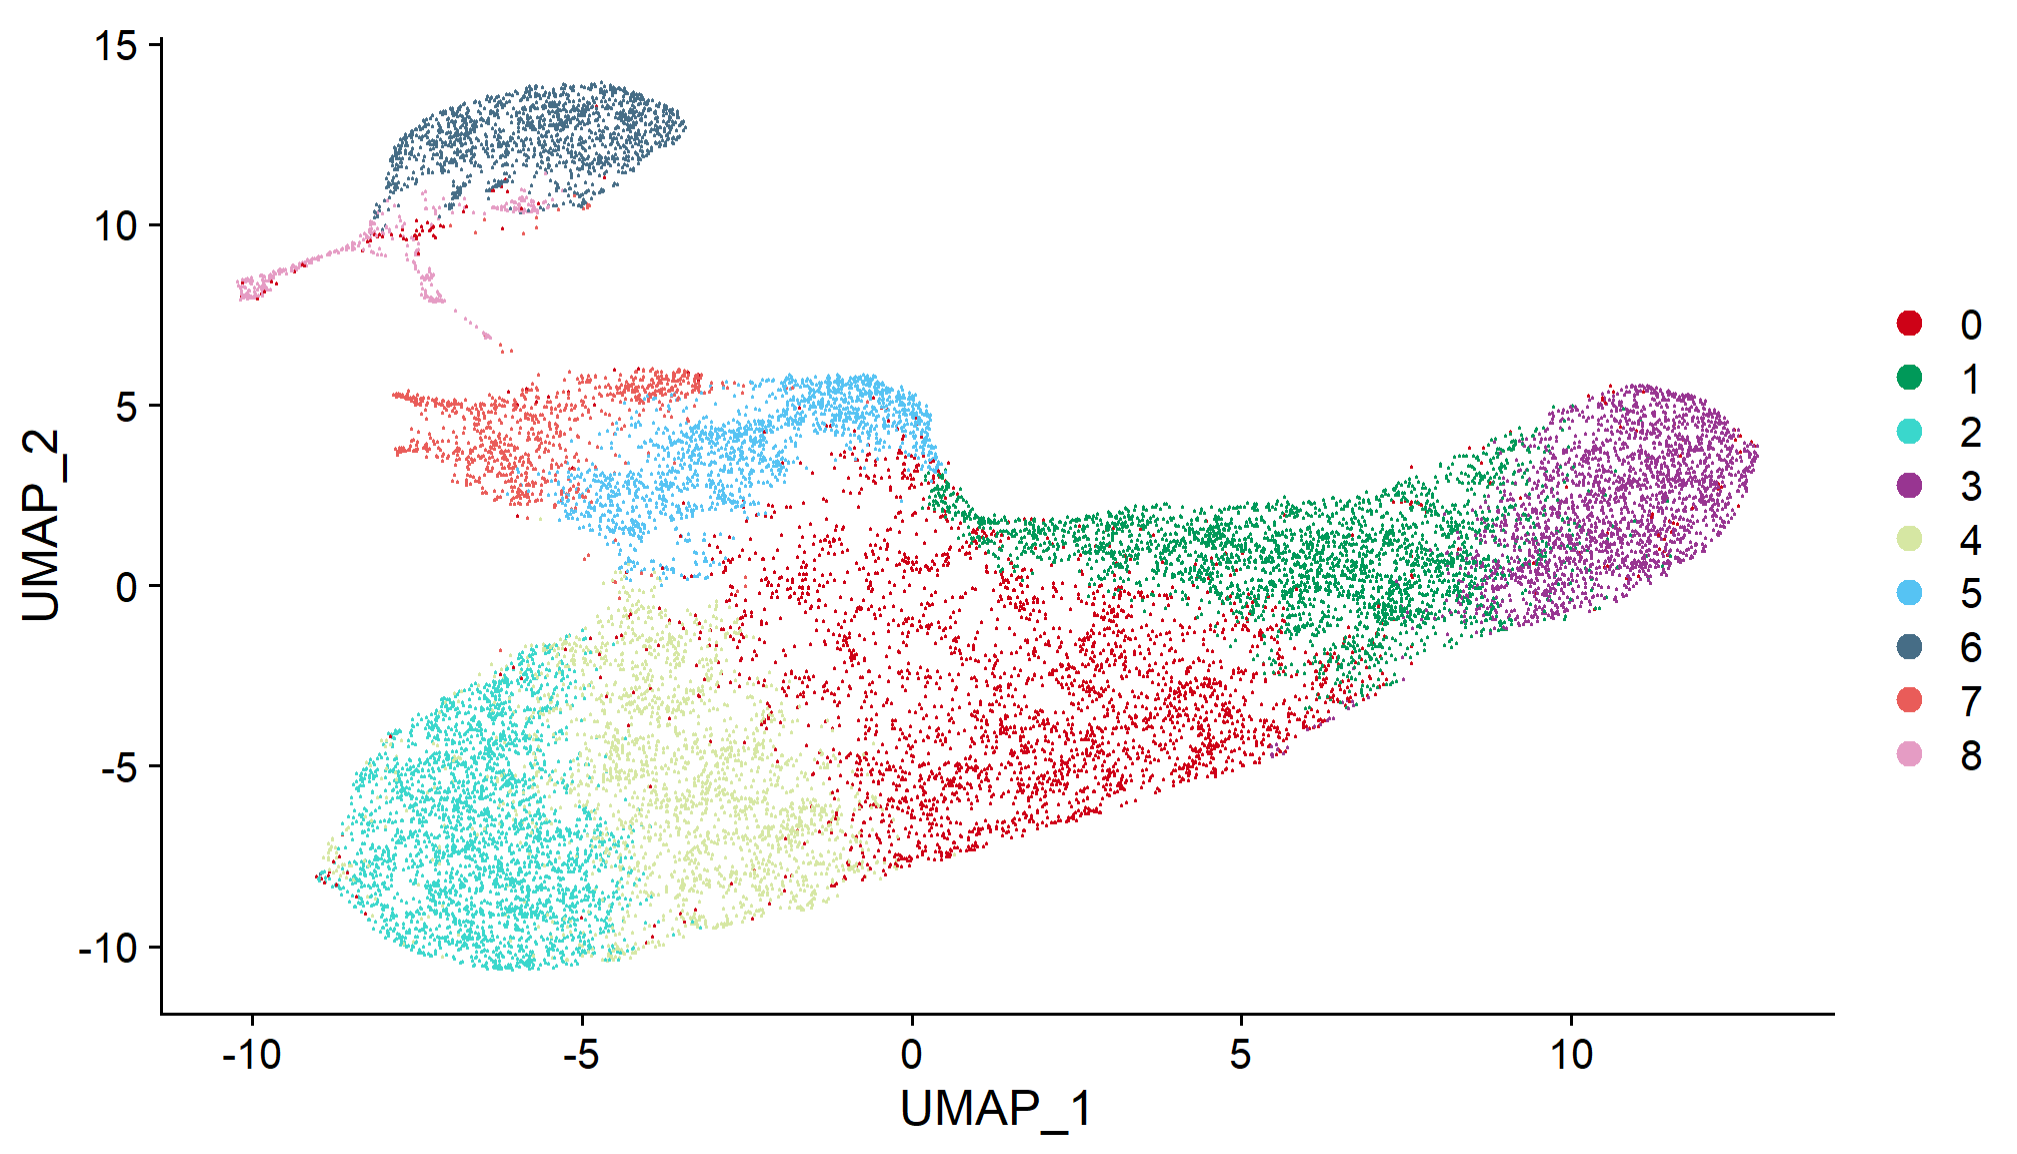

In [ ]:
### 根据相关性，判断大概有几个明显的亚群
head(AverageExpression(object = sub.myo.sc))
AverageExp <- AverageExpression(object = sub.myo.sc)
typeof(AverageExp)
head(AverageExp$RNA)

coorda<-corr.test(AverageExp$RNA,AverageExp$RNA,method = "spearman")
cor_matrix <- coorda$r
p65=pheatmap(cor_matrix,color = colorRampPalette(rev(brewer.pal(n = 7, name =
+                                                                 "PRGn")))(100))

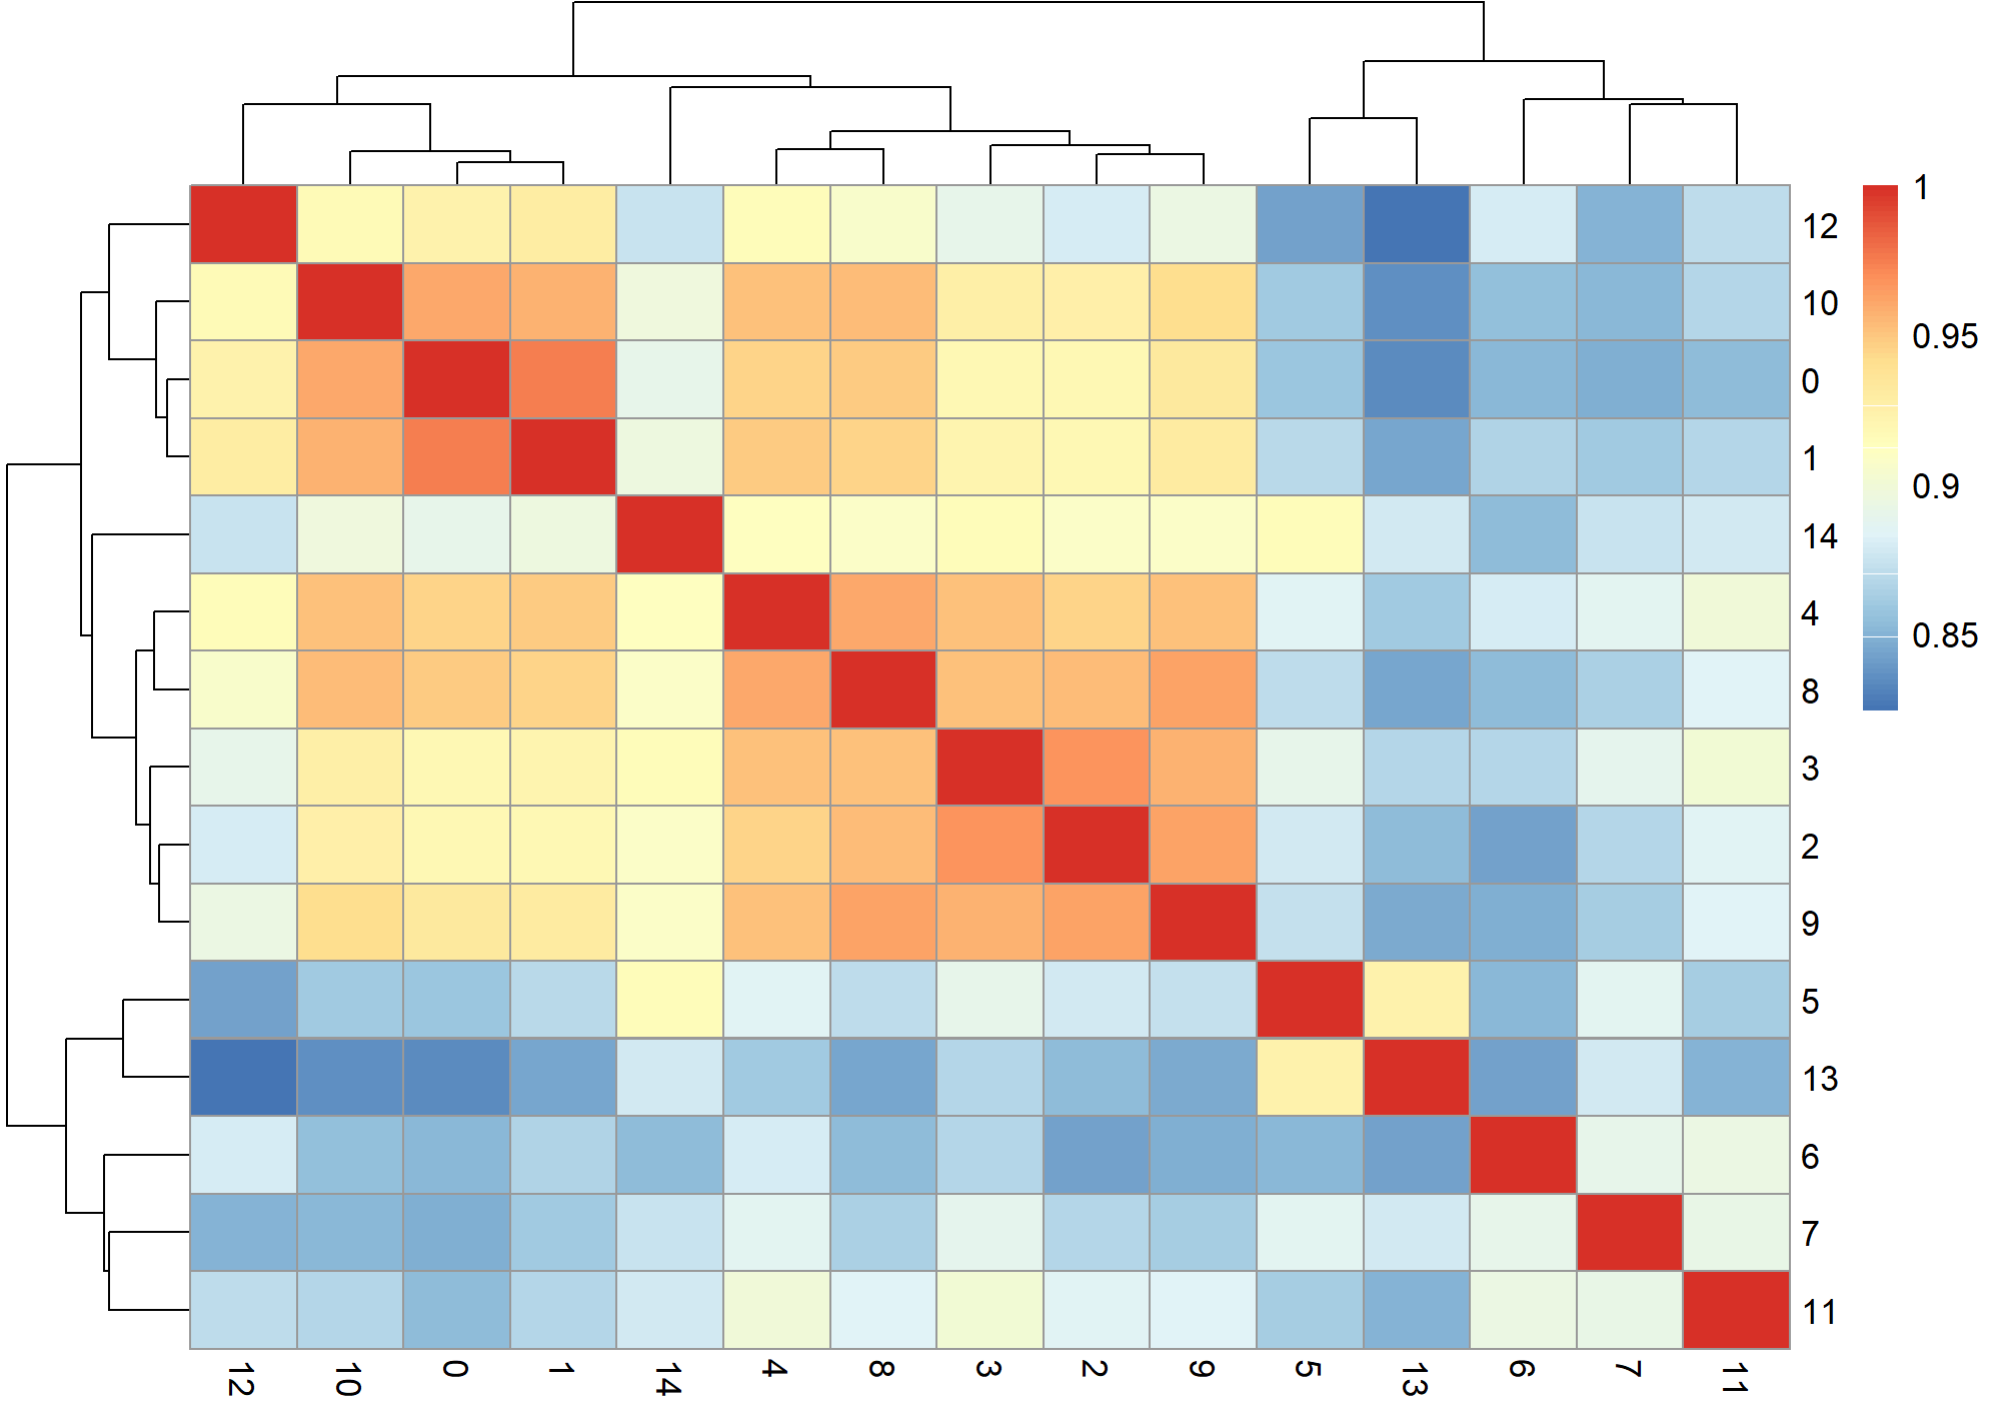

In [ ]:
VlnPlot(sub.myo.sc, features = "PPARGC1A")

In [ ]:
FeaturePlot(sub.myo.sc, features = c("MYH4"))



0-MYH4 [Type 2b myofibers]  T2bM@
1-MYH7 [Type I myofibers]  TIM@
2-[FAPs-1] @
3-MYH1 [Type 2x myofibers]@
4-[FAPs-2]@
5-PECAM1,CD93,CDH5,MECOM,DACH1,PTPRB [VECs]@
6-ACTA2,PDE1C,MYLK,TAGLN [Smooth muscle cells]@
7-PAX7(), [QSCs-1]@
8-CD163,CD14,MRC1(CD206),TLR2(CD282),CSF1R(CD115) [Macrophages]@
9-[Type 2a myofibers]@
10-PTPRC(CD45),CD3D,CD3E,CD8A [T cells]@
11-CCL21,PROX1,FLT4 [LECs]@
12-[Type 2b/x myofibers]@
13-KIT(CD117),LYN,ITGA4(CD49D) [Mast cells]@
14-PDGFRA [FAPs-3]@
15-MS4A1(CD20),CD80,PDCD1LG2(CD273),CIITA,FLT3(CD135) [B cells]@
16-COL12A1,COL11A2,COL11A1,FNDC1,TNC,PDGFRA- [Perimysial cells]@
17-FASN,ADIPOQ,PLIN1,PPARG,SCD [Mature adipocytes]@
18-COL28A1,SORCS1,NEGR1 [Neurons]
19- [QSCs-2]@
20-TOP2A+,PAX7+,MYOD1+ [PSCs]@


In [ ]:
P61=FeaturePlot(sub.myo.sc, features = c("PAX7"),cols=my_color_palette,pt.size=1)
P62=FeaturePlot(sub.myo.sc, features = c("MYH1"),cols=my_color_palette,pt.size=1)
P63=FeaturePlot(sub.myo.sc, features = c("MYH4"),cols=my_color_palette,pt.size=1)
P64=FeaturePlot(sub.myo.sc, features = c("MYH7"),cols=my_color_palette,pt.size=1)

In [ ]:
Cellratio2 <- prop.table(table(Idents(sub.myo.sc), sub.myo.sc$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio2

Cellratio3 <- prop.table(table(Idents(sub.myo.sc)))#计算各组样本不同细胞群比例
Cellratio3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Since I cannot directly see the data the user has, I will create a sample data similar to what the user might have
# 9 cell types with their respective percentage for the EDL tissue
cell_types = ['Type1', 'Type2', 'Type3', 'Type4', 'Type5', 'Type6', 'Type7', 'Type8', 'Type9']
percentages = [32.35, 0.32, 1.55, 0, 21.51, 14.20, 17.94, 6.28, 5.80]  # Sample percentages

# Number of variables we're plotting.
num_vars = len(cell_types)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
percentages += percentages[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, percentages, color='red', alpha=0.25)
ax.plot(angles, percentages, color='red', linewidth=2)  # Change color to red

# Draw one axe per variable and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw ylabels
ax.set_rscale('log')
ax.set_rticks([10, 20, 40, 60, 80, 100])  # Less radial ticks
ax.set_rlabel_position(0)

# Add each variable as a label at the right angle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cell_types)

# Add a title and a legend
ax.set_title('EDL Cell Type Proportions', y=1.08)
plt.show()

In [ ]:
# 确保PAX7基因存在
if("PAX7" %in% rownames(sub.myo.sc@assays$RNA@data)) {
    # 提取PAX7基因的表达数据
    pax7_data <- FetchData(sub.myo.sc, vars = c("PAX7", "seurat_clusters"), slot = "data")
    
    # 计算每个细胞群的平均PAX7表达量
    pax7_avg_expression <- aggregate(PAX7 ~ seurat_clusters, data = pax7_data, FUN = mean)
    
    # 查看结果
    print(pax7_avg_expression)
    
} else {
    cat("PAX7 gene not found in the dataset.\n")
}

In [ ]:
  seurat_clusters       PAX7
1               0 0.13442894
2               1 0.06023668
3               2 0.07555817
4               3 0.04825596
5               4 0.06695027
6               5 0.03187593
7               6 3.01144555
8               7 0.15751483
9               8 1.15048595

seurat_clusters      MYOD1
1               0 0.25940388
2               1 0.36738728
3               2 0.23068605
4               3 0.45909784
5               4 0.18880487
6               5 0.07691727
7               6 0.34266272
8               7 0.11293840
9               8 0.74245442

seurat_clusters       MYH7
1               0 0.29016819
2               1 0.05949595
3               2 3.44740065
4               3 0.04106392
5               4 2.31827208
6               5 1.38510246
7               6 0.40581990
8               7 1.19474809
9               8 0.35840391

  seurat_clusters        MYH4
1               0 0.715370379
2               1 4.217734082
3               2 0.002583194
4               3 4.404807272
5               4 0.163241458
6               5 2.348630515
7               6 0.370010868
8               7 0.838996246
9               8 0.065856149

  seurat_clusters       MYH1
1               0 3.04536182
2               1 1.35918640
3               2 0.09131358
4               3 0.67995843
5               4 0.66540289
6               5 2.27263965
7               6 0.44119762
8               7 1.09647902
9               8 0.32250558

In [ ]:
P65=DimPlot(sub.myo.sc, reduction = "umap",group.by=orig.ident, cols=my36colors)

### ClusterGVis

In [ ]:
library(ClusterGVis)
library(org.Hs.eg.db)
library(Seurat)

pbmc <- readRDS("Z:/A/ST/Analysis/Results3/sub.myo.sc.rds")

In [ ]:
new.cluster.ids <- c("Type 2x myofibers", "Type 2x/2b myofibers", "Type 1 myofibers", "Type 2b myofibers", "Type 1/2a myofibers", "Type 2a/x myofibers","MuSCs", "Type 2a myofibers", "Myoblasts")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)

In [ ]:
# find markers for every cluster compared to all remaining cells
# report only the positive ones
pbmc.markers.all <- Seurat::FindAllMarkers(pbmc,
                               only.pos = TRUE,
                               min.pct = 0.25,
                               logfc.threshold = 0.25)

indices_to_remove <- grep("ENSSSCG", pbmc.markers.all$gene)
pbmc.markers.all <- pbmc.markers.all[-indices_to_remove, ]

# get top 10 genes
pbmc.markers <- pbmc.markers.all %>%
  dplyr::group_by(cluster) %>%
  dplyr::top_n(n = 20, wt = avg_log2FC)

# check
head(pbmc.markers)



In [ ]:
# prepare data from seurat object
st.data <- prepareDataFromscRNA(object = pbmc,
                                diffData = pbmc.markers,
                                showAverage = TRUE)

# check
str(st.data)

In [ ]:
enrich_BP <- enrichCluster(object = st.data,
                        OrgDb = org.Hs.eg.db,
                        type = "BP",
                        organism = "hsa",
                        pvalueCutoff = 0.5,
                        topn = 5,
                        seed = 5201314)

enrich_MF <- enrichCluster(object = st.data,
                        OrgDb = org.Hs.eg.db,
                        type = "MF",
                        organism = "hsa",
                        pvalueCutoff = 0.5,
                        topn = 5,
                        seed = 5201314)

enrich_CC <- enrichCluster(object = st.data,
                        OrgDb = org.Hs.eg.db,
                        type = "CC",
                        organism = "hsa",
                        pvalueCutoff = 0.5,
                        topn = 5,
                        seed = 5201314)


enrich_KEGG <- enrichCluster(object = st.data,
                        OrgDb = org.Hs.eg.db,
                        type = "KEGG",
                        organism = "hsa",
                        pvalueCutoff = 0.5,
                        topn = 5,
                        seed = 5201314)

In [ ]:
markGenes = unique(pbmc.markers$gene)[sample(1:length(unique(pbmc.markers$gene)),40,
                                             replace = F)]

# line plot
visCluster(object = st.data,
           plot.type = "line")

In [ ]:
##上述代码的修正，使之按照自己想要的顺序
desired_order <- c("MuSCs", "Myoblasts", "Type 1 myofibers", "Type 1/2a myofibers", "Type 2a myofibers", "Type 2a/x myofibers", "Type 2x myofibers", "Type 2x/2b myofibers", "Type 2b myofibers")  # specify your desired order
st.data$long.res$cell_type <- factor(st.data$long.res$cell_type, levels = desired_order)
cluster_order <- c("cluster 7 (20)", "cluster 9 (17)", "cluster 3 (20)", "cluster 5 (12)", "cluster 8 (20)", "cluster 6 (20)", "cluster 1 (20)", "cluster 2 (19)", "cluster 4 (12)")  # Example: update with your actual cluster names and order
st.data$long.res$cluster_name <- factor(st.data$long.res$cluster_name, levels = cluster_order)

P66=visCluster(object = st.data, plot.type = "line")

In [ ]:
pdf('sc1.pdf',height = 10,width = 6,onefile = T)
visCluster(object = st.data,
           plot.type = "heatmap",
           column_names_rot = 45,
           markGenes = markGenes,
           cluster.order = c(7,9,3,5,8,6,1,2,4))
dev.off()

In [ ]:
pdf('sc2.pdf',height = 10,width = 14,onefile = F)
visCluster(object = st.data,
           plot.type = "both",
           column_names_rot = 45,
           show_row_dend = F,
           markGenes = markGenes,
           markGenes.side = "left",
           annoTerm.data = enrich_BP,
           line.side = "left",
           cluster.order = c(7,9,3,5,8,6,1,2,4),
           go.col = rep(jjAnno::useMyCol("stallion",n = 9),each = 5),
           add.bar = T)
dev.off()

In [ ]:
# retain duplicate diff gene in multiple clusters
st.data <- prepareDataFromscRNA(object = pbmc,
                                diffData = pbmc.markers,
                                showAverage = TRUE,
                                keep.uniqGene = FALSE,
                                sep = "_")

# check
df <- st.data$wide.res

In [ ]:
desired_order <- c("MuSCs", "Myoblasts", "Type 1 myofibers", "Type 1/2a myofibers", "Type 2a myofibers", "Type 2a/x myofibers", "Type 2x myofibers", "Type 2x/2b myofibers", "Type 2b myofibers")  # specify your desired order
st.data$long.res$cell_type <- factor(st.data$long.res$cell_type, levels = desired_order)
cluster_order <- c("cluster 7 (20)", "cluster 9 (20)", "cluster 3 (20)", "cluster 5 (20)", "cluster 8 (20)", "cluster 6 (20)", "cluster 1 (20)", "cluster 2 (20)", "cluster 4 (20)")  # Example: update with your actual cluster names and order
st.data$long.res$cluster_name <- factor(st.data$long.res$cluster_name, levels = cluster_order)

pdf('aaa.pdf',height = 10,width = 14,onefile = F)
visCluster(object = st.data,
           plot.type = "line")
dev.off()

In [ ]:
pdf('sc3.pdf',height = 10,width = 6,onefile = F)
visCluster(object = st.data,
           plot.type = "heatmap",
           column_names_rot = 45,
           markGenes = c("PAX7","MYH1","MYH4"),
           cluster.order = c(7,9,3,5,8,6,1,2,4))
dev.off()

In [ ]:
pbmc.markers1 <- pbmc.markers.all %>%
  dplyr::group_by(cluster) %>%
  dplyr::top_n(n = 5, wt = avg_log2FC)

# retain duplicate diff gene in multiple clusters
st.data <- prepareDataFromscRNA(object = pbmc,
                                diffData = pbmc.markers1,
                                showAverage = FALSE)

# check
str(st.data)

In [ ]:
pdf('sc4.pdf',height = 10,width = 8,onefile = F)
visCluster(object = st.data,
           plot.type = "heatmap",
           markGenes = unique(pbmc.markers1$gene),
           column_title_rot = 45,
           cluster.order = c(7,9,3,5,8,6,1,2,4))
dev.off()

In [ ]:
pdf('sc5.pdf',height = 10,width = 8,onefile = F)
visCluster(object = st.data,
           plot.type = "heatmap",
           markGenes = unique(pbmc.markers1$gene),
           column_title_rot = 45,
           cluster.order = c(7,9,3,5,8,6,1,2,4),
           sample.cell.order = rev(new.cluster.ids),
           sample.col = jjAnno::useMyCol("paired",n = 9))
dev.off()

In [ ]:
pdf('sc6.pdf',height = 12,width = 16,onefile = F)
visCluster(object = st.data,
           plot.type = "both",
           column_title_rot = 45,
           markGenes = unique(pbmc.markers1$gene),
           markGenes.side = "left",
           annoTerm.data = enrich_BP,
           line.side = "left",
           cluster.order = c(7,9,3,5,8,6,1,2,4),
           add.bar = T)
dev.off()

In [ ]:

pdf('GSN.pdf',height = 6,width = 8,onefile = F)
FeaturePlot(pbmc,"GSN",pt.size=1)
dev.off()

In [ ]:
# 加载必要的库
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(ggplot2)


# 假设 pbmc.markers 是你的数据框，包含了每个细胞群的marker基因
# 检查每个细胞群中的marker基因
clusters <- unique(pbmc.markers$cluster)

# 初始化一个列表来存储富集结果
enrichment_results <- list()

# 对每个细胞群进行GO分析
for (cluster in clusters) {
  # 获取当前细胞群的marker基因
  genes <- as.character(pbmc.markers$gene[pbmc.markers$cluster == cluster])

  # 将基因名称转换为ENTREZ ID
  gene_ids <- bitr(genes, fromType="SYMBOL", toType="ENTREZID", OrgDb=org.Hs.eg.db)
  
  # 进行GO富集分析
  ego <- enrichGO(gene = gene_ids$ENTREZID,
                  OrgDb = org.Hs.eg.db,
                  keyType = "ENTREZID",
                  ont = "ALL",  # Biological Process，可以选择"CC" (Cellular Component) 或 "MF" (Molecular Function)
                  pAdjustMethod = "BH",
                  pvalueCutoff = 0.2,  # 调整p值的方法
                  qvalueCutoff = 0.2,  # 显著性阈值
                  readable = TRUE)  # 将ENTREZ ID转换为可读的基因名


  # 将结果存储在列表中
  enrichment_results[[cluster]] <- ego
}

# 可视化一个细胞群的富集结果，示例显示第一个细胞群的结果
pdf('enrichment_results[[1]].pdf',height = 20,width = 8,onefile = F)
if (length(enrichment_results) > 0 && !is.null(enrichment_results[[1]])) {
  # 使用 enrichplot 的 barplot 函数进行可视化
  plot <- dotplot(enrichment_results[[1]], showCategory=50)  # 显示前20个富集的条目
  print(plot)
}
dev.off()


pdf('enrichment_results[2b].pdf',height = 20,width = 8,onefile = F)
if (length(enrichment_results) > 0 && !is.null(enrichment_results[[4]])) {
    plot <- dotplot(enrichment_results[[4]], showCategory=50, color = "qvalue") + scale_colour_gradient(low = "#800080", high = "gray")  # 从红色渐变到蓝色
    print(plot)
}
dev.off()





# 可以逐个查看或保存其他细胞群的分析结果

### Monocle 1

In [ ]:
plot_cell_trajectory(cds, color_by = "State")
plot_cell_trajectory(cds, color_by = "seurat_clusters")
plot_cell_trajectory(cds, color_by = "Pseudotime")
plot_cell_trajectory(cds, color_by = "State") + facet_wrap(~State, nrow = 1)
plot_cell_trajectory(cds, color_by = "seurat_clusters") + facet_wrap(~seurat_clusters, nrow = 3)

#### 拆分分析

In [ ]:
pbmc.list <- SplitObject(pbmc, split.by = "orig.ident")
Sol=pbmc.list$Sol
EDL=pbmc.list$LD
LD=pbmc.list$EDL

In [ ]:
##方法1 选择top2000基因（不拆分）基于基因表达的变异度（MAD）

library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(monocle)


new.cluster.ids <- c("Type 2x myofibers", "Type 2x/2b myofibers", "Type 1 myofibers", "Type 2b myofibers", "Type 1/2a myofibers", "Type 2a/x myofibers","MuSCs", "Type 2a myofibers", "Myoblasts")
names(new.cluster.ids) <- levels(sub.myo.sc)
sub.myo.sc <- RenameIdents(sub.myo.sc, new.cluster.ids)


data <- as(as.matrix(sub.myo.sc@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = sub.myo.sc@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)

Mol_sub.myo.sc <- newCellDataSet(data,
                  phenoData = pd,
                  featureData = fd,
                  lowerDetectionLimit = 0.05,
                  expressionFamily = negbinomial.size())

Mol_sub.myo.sc <- estimateSizeFactors(Mol_sub.myo.sc)
Mol_sub.myo.sc <- estimateDispersions(Mol_sub.myo.sc,cores = 24, relative_expr = TRUE)

cds=Mol_sub.myo.sc
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)


disp_table <- dispersionTable(cds)
ordering_genes=names(tail(sort(apply(cds@assayData$exprs,1,mad)),2000))
cds <- setOrderingFilter(cds, ordering_genes)

cds <- reduceDimension(cds, max_components = 2, method = 'DDRTree')
cds <- orderCells(cds)##花费长时间

In [ ]:
plot_cell_trajectory(cds, color_by = "State")
plot_cell_trajectory(cds, color_by = "seurat_clusters")
plot_cell_trajectory(cds, color_by = "Pseudotime")
plot_cell_trajectory(cds, color_by = "State") + facet_wrap(~State, nrow = 1)
P69=plot_cell_trajectory(cds, color_by = "seurat_clusters") + facet_wrap(~seurat_clusters, nrow = 3)
P70=plot_cell_trajectory(cds, color_by = "Pseudotime")
P71=plot_cell_trajectory(cds, color_by = "orig.ident")+ facet_wrap(~orig.ident, nrow = 1)


In [ ]:
##方法2 empirical dispersion
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(monocle)
library(doParallel)
library(foreach)

new.cluster.ids <- c("Type 2x myofibers", "Type 2x/2b myofibers", "Type 1 myofibers", "Type 2b myofibers", "Type 1/2a myofibers", "Type 2a/x myofibers","MuSCs", "Type 2a myofibers", "Myoblasts")
names(new.cluster.ids) <- levels(sub.myo.sc)
sub.myo.sc <- RenameIdents(sub.myo.sc, new.cluster.ids)


data <- as(as.matrix(sub.myo.sc@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = sub.myo.sc@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)

Mol_sub.myo.sc <- newCellDataSet(data,
                  phenoData = pd,
                  featureData = fd,
                  lowerDetectionLimit = 0.05,
                  expressionFamily = negbinomial.size())

Mol_sub.myo.sc <- estimateSizeFactors(Mol_sub.myo.sc)
Mol_sub.myo.sc <- estimateDispersions(Mol_sub.myo.sc,cores = 20, relative_expr = TRUE)

cds=Mol_sub.myo.sc
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)


disp_table <- dispersionTable(cds)
disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id
cds <- setOrderingFilter(cds, disp.genes)

#reduction_method = c("DDRTree", "ICA", "tSNE", "SimplePPT", "L1-graph", "SGL-tree"),
cds <- orderCells(cds)


#### Finding Genes that Change as a Function of Pseudotime

In [ ]:
cds <- detectGenes(cds, min_expr = 0.1)
expressed_genes <- row.names(subset(fData(cds), num_cells_expressed >= 10))


# 注册并行后台，指定核心数量
registerDoParallel(cores = 8)

# 进行差异基因检测
diff_test_res <- differentialGeneTest(cds[expressed_genes, ],
                                      fullModelFormulaStr = "~sm.ns(Pseudotime)",
                                      cores = 8)

# 查看差异基因检测结果
head(diff_test_res[, c("gene_short_name", "pval", "qval")])

# 绘制PAX7基因在伪时间轨迹中的表达
gene_names <- row.names(fData(cds))
# 找到 PAX7 基因对应的行名称
MYH1_gene <- gene_names[fData(cds)$gene_short_name %in% "MYH7"]
p <- plot_genes_in_pseudotime(cds[MYH7_gene, ], color_by = "seurat_clusters")

custom_colors <- c("0" = "#CE0317", 
                   "1" = "#009959", 
                   "2" = "#3AD7CC", 
                   "3" = "#993591", 
                   "4" = "#DCEBB0", 
                   "5" = "#57C3F3", 
                   "6" = "#476D87", 
                   "7" = "#E85B58", 
                   "8" = "#F1C8DE")
p + scale_color_manual(values = custom_colors)


# 使用行名称来子集化 cds 对象
pdf('pseudotime_PAX7.pdf', height = 8, width = 8, onefile = FALSE)
plot_genes_in_pseudotime(cds[pax7_gene, ], color_by = "seurat_clusters")
dev.off()


p1=plot_cell_trajectory(cds, color_by = "orig.ident") + facet_wrap(~seurat_clusters, nrow = 3)
custom_colors <- c("EDL" = "#CE0317", 
                   "LD" = "#009959",  
                   "Sol" = "#476D87")
p1 + scale_color_manual(values = custom_colors)



### monocle3

In [ ]:
library(monocle3)

# The tutorial shown below and on subsequent pages uses two additional packages:
library(ggplot2)
library(dplyr)
library(SeuratWrappers)
library(Seurat)
library(SeuratData)

In [ ]:
saveRDS(sub.myo.sc,file = "sub.myo.sc.rds")
sub.myo.sc <- readRDS("sub.myo.sc.rds")

In [ ]:
new.cluster.ids <- c("Type 2x myofibers", "Type 2x/2b myofibers", "Type 1 myofibers", "Type 2b myofibers", "Type 1/2a myofibers", "Type 2a/x myofibers","MuSCs", "Type 2a myofibers", "Myoblasts")
names(new.cluster.ids) <- levels(sub.myo.sc)
sub.myo.sc <- RenameIdents(sub.myo.sc, new.cluster.ids)
cds <- new_cell_data_set(as(as.matrix(sub.myo.sc@assays$RNA@counts), 'sparseMatrix'),cell_metadata = as.data.frame(sub.myo.sc@meta.data),gene_metadata = data.frame(gene_short_name = row.names(sub.myo.sc),row.names = row.names(sub.myo.sc)))


# 预处理和降维
cds <- preprocess_cds(cds, num_dim = 50)
plot_pc_variance_explained(cds)
residual_model_formula_str <- "~ orig.ident"
#cds <- align_cds(cds, alignment_group = "orig.ident", residual_model_formula_str = residual_model_formula_str)

cds <- reduce_dimension(cds)
plot_cells(cds, label_groups_by_cluster=T,  color_cells_by = "seurat_clusters",group_label_size=10)
cds <- cluster_cells(cds)


#all_partitions <- unique(cds@clusters$UMAP$partitions)
#all_partitions <- all_partitions[all_partitions != "2"]

# set all partitions to 1
#cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions %in% all_partitions] <- "2"



cds <- learn_graph(cds)
p3=plot_cells(cds,
           color_cells_by = "seurat_clusters",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           group_label_size=10,
           label_branch_points=FALSE)
custom_colors <- c("0" = "#E85B58", 
                   "1" = "#009959", 
                   "2" = "#3AD7CC", 
                   "3" = "#993591", 
                   "4" = "#DCEBB0", 
                   "5" = "#57C3F3", 
                   "6" = "#476D87", 
                   "7" = "#CE0317", 
                   "8" = "#F1C8DE")
p3 + scale_color_manual(values = custom_colors)




cds <- order_cells(cds)

plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           cell_size = 0.6,
           label_leaves=FALSE,
           group_label_size=10,
           label_branch_points=FALSE,
           rasterize=F,
           alpha = 1,
           label_principal_points=F,
           graph_label_size=1.5)

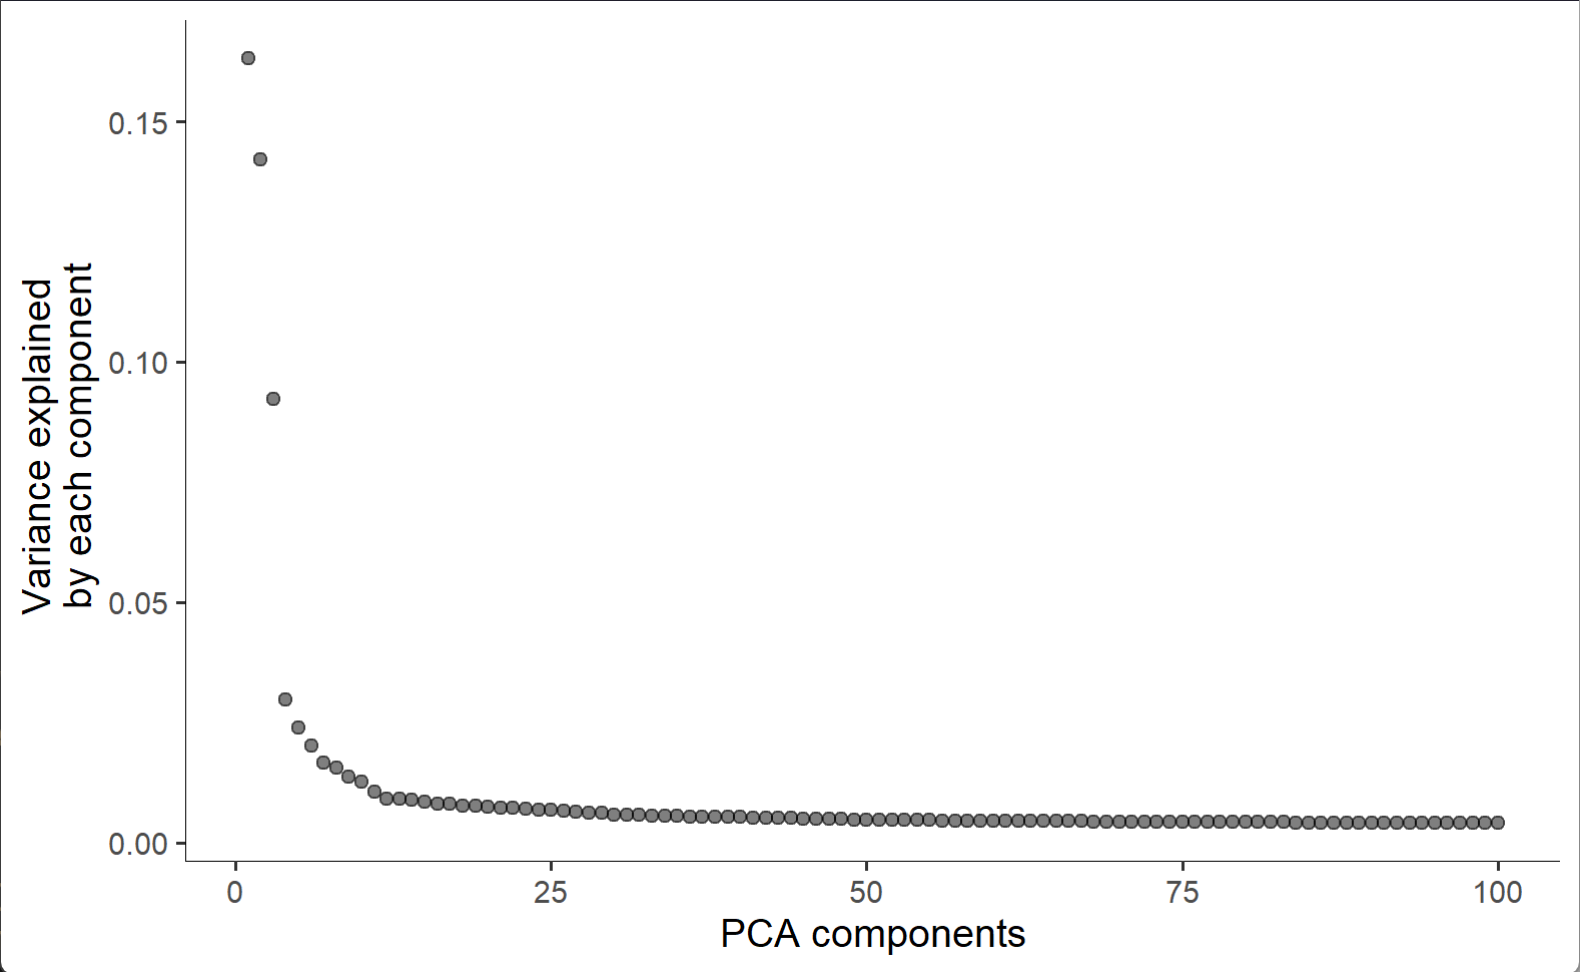

In [ ]:
cds <- reduce_dimension(cds)
names(cds@colData)
plot_cells(cds, color_cells_by="RNA_snn_res.0.3",group_label_size=10)


cds <- cluster_cells(cds)
plot_cells(cds, color_cells_by = "RNA_snn_res.0.3",group_label_size=10)

# find all possible partitions
#all_partitions <- unique(cds@clusters$UMAP$partitions)
#all_partitions <- all_partitions[all_partitions != "1"]

# set all partitions to 1
#cds@clusters$UMAP$partitions[cds@clusters$UMAP$partitions %in% all_partitions] <- "1"

cds <- learn_graph(cds)
plot_cells(cds,
           color_cells_by = "RNA_snn_res.0.3",group_label_size=10,
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)


cds <- order_cells(cds)

pdf('111.pdf',height = 20,width = 8,onefile = F)
plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)
dev.off()


cds_sub <- choose_graph_segments(cds)

cds_3d <- reduce_dimension(cds, max_components = 3)
cds_3d <- cluster_cells(cds_3d)
cds_3d <- learn_graph(cds_3d)
cds_3d <- order_cells(cds_3d, root_pr_nodes=get_earliest_principal_node(cds))

cds_3d_plot_obj <- plot_cells_3d(cds_3d, color_cells_by="partition")

In [ ]:
my36colors <-c('#CE0317', '#009959', '#3AD7CC', '#993591', '#D6E7A3', '#57C3F3', '#476D87',
               '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
               '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
               '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
               '#712820', '#DCC1DD', '#CCE0F5',  '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
               '#968175'
)

In [ ]:

cds <- preprocess_cds(cds, num_dim = 50)
# 使用orig.ident列进行对齐，假设这一列标记了不同的样本来源
cds <- align_cds(cds, alignment_group = "orig.ident", residual_model_formula_str = "~ orig.ident")


In [ ]:
cds <- reduce_dimension(cds)
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "cell.type")

### SCENIC

[参考资料](https://blog.csdn.net/qq_52813185/article/details/130849312)

In [ ]:
library(Seurat)
library(SCENIC)
library(loomR)

exprMat <- GetAssayData(sub.myo.sc, slot = "counts", assay = "RNA")
exprMat <- as.matrix(exprMat)
cellInfo <- data.frame(seuratCluster = Idents(sub.myo.sc))

In [ ]:
loom <- create(
  filename = "Z:/A/ST/Analysis/Results3/SCENIC/mouseBrain.loom",
  data = exprMat,
  cell.attrs = cellInfo
)

# 关闭`.loom`文件
loom$close_all()

In [ ]:
#library(SCopeLoomR)
#loomPath <- system.file(package="SCENIC", "Z:/A/ST/Analysis/Results3/mouseBrain.loom")
#loom <- open_loom(loomPath)
#exprMat <- get_dgem(loom)
#cellInfo <- get_cell_annotation(loom)
#close_loom(loom)

##以上官网，以下非官网
library(SCopeLoomR)
# 指定文件路径
loomPath <- "Z:/A/ST/Analysis/Results3/SCENIC/mouseBrain.loom"
# 打开`.loom`文件
loom <- open_loom(loomPath)
# 检查文件内容
print(loom)

In [ ]:
dbDir <- "Z:/A/ST/Analysis/Results3/SCENIC/"
dbs <- c("hg19-500bp-upstream-10species.mc9nr.feather",
         "hg19-tss-centered-10kb-10species.mc9nr.feather")

# 初始化SCENIC设置
scenicOptions <- initializeScenic(org="hgnc", dbDir=dbDir, dbs=dbs, nCores=8)

genesKept <- geneFiltering(exprMat, scenicOptions)
exprMat_filtered <- exprMat[genesKept, ]
runCorrelation(exprMat_filtered, scenicOptions)
exprMat_filtered_log <- log2(exprMat_filtered+1) 


data(list="motifAnnotations_hgnc_v9", package="RcisTarget")
motifAnnotations_hgnc <- motifAnnotations_hgnc_v9
runGenie3(exprMat_filtered_log, scenicOptions, nParts = 20)

In [ ]:
exprMat_log <- log2(exprMat+1)
scenicOptions@settings$dbs <- scenicOptions@settings$dbs["10kb"] # Toy run settings
scenicOptions <- runSCENIC_1_coexNetwork2modules(scenicOptions)
scenicOptions <- runSCENIC_2_createRegulons(scenicOptions, coexMethod=c("top5perTarget")) # Toy run settings
## 如果runSCENIC_2_createRegulons出现错误需要初始化SCENIC设置,在linux中也是这样
#dbDir <- "Z:/A/ST/Analysis/Results3/SCENIC/"
#dbs <- c("hg19-500bp-upstream-10species.mc9nr.feather",
         "hg19-tss-centered-10kb-10species.mc9nr.feather")
#scenicOptions <- initializeScenic(org="hgnc", dbDir=dbDir, dbs=dbs, nCores=8)
scenicOptions <- runSCENIC_3_scoreCells(scenicOptions, exprMat_log)

In [ ]:
setwd("/storage/public/home/2008116199/yxd/single/SCENIC")
load("/storage/public/home/2008116199/yxd/single/SCENIC/6.10.RData")
dbDir <- "/storage/public/home/2008116199/yxd/single/SCENIC"
dbs <- c("hg19-500bp-upstream-10species.mc9nr.feather","hg19-tss-centered-10kb-10species.mc9nr.feather")
scenicOptions <- initializeScenic(org="hgnc", dbDir=dbDir, dbs=dbs, nCores=32)

In [ ]:
scenicOptions <- runSCENIC_4_aucell_binarize(scenicOptions)



nPcs <- c(5)
scenicOptions@settings$seed <- 123
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=c(5,15,50))
fileNames <- tsneAUC(scenicOptions, aucType="AUC", nPcs=nPcs, perpl=c(5,15,50), onlyHighConf=TRUE, filePrefix="int/tSNE_oHC")
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_", list.files("int"), value=T), value=T))

par(mfrow=c(length(nPcs), 3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="CellType", cex=.5)


par(mfrow=c(3,3))
fileNames <- paste0("int/",grep(".Rds", grep("tSNE_oHC_AUC", list.files("int"), value=T, perl = T), value=T))
plotTsne_compareSettings(fileNames, scenicOptions, showLegend=FALSE, varName="CellType", cex=.5)

scenicOptions@settings$defaultTsne$aucType <- "AUC"
scenicOptions@settings$defaultTsne$dims <- 5
scenicOptions@settings$defaultTsne$perpl <- 15
saveRDS(scenicOptions, file="int/scenicOptions.Rds")





tsneAUC(scenicOptions, aucType="AUC") # choose settings

saveRDS(cellInfo, file=getDatasetInfo(scenicOptions, "cellInfo"))
export2loom(scenicOptions, exprMat)

In [ ]:
scenicOptions=readRDS(file="int/scenicOptions.Rds")
scenicLoomPath <- getOutName(scenicOptions, "loomFile")
loom <- open_loom(scenicLoomPath)
# Read information from loom file:
regulons_incidMat <- get_regulons(loom)
regulons <- regulonsToGeneLists(regulons_incidMat)
regulonsAUC <- get_regulons_AUC(loom)
regulonsAucThresholds <- get_regulon_thresholds(loom)
embeddings <- get_embeddings(loom)` </pre>

In [ ]:
regulonAUC <- loadInt(scenicOptions, "aucell_regulonAUC")
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]
cellInfo <- data.frame(seuratCluster=Idents(sub.myo.sc))

In [ ]:
regulonActivity_byCellType <- sapply(split(rownames(cellInfo), cellInfo$seuratCluster),function(cells) rowMeans(getAUC(regulonAUC)[,cells]))

In [ ]:
col_fun = colorRamp2(
  c(min(regulonActivity_byCellType_Scaled), mean(regulonActivity_byCellType_Scaled), max(regulonActivity_byCellType_Scaled)), 
  c("#0D4E93", "white", "#9C1E23")
)

In [ ]:
Heatmap(regulonActivity_byCellType_Scaled, name="Regulon activity", col=col_fun)

In [ ]:
### 网络图
# 加载必要的包
library(data.table)
library(openxlsx)

# 读取Step2_regulonTargetsInfo.tsv文件
file_path <- "Step2_regulonTargetsInfo.tsv" # 请确保文件路径正确
regulon_targets_info <- fread(file_path, sep = "\t")

# 提取特定转录因子的靶基因信息
tf_list <- c("RXRG", "FOXO1")
tf_targets_list <- list()

# 分别提取每个转录因子的靶基因并存入列表
for (tf in tf_list) {
    tf_targets <- regulon_targets_info[TF == tf, .(TF, gene, highConfAnnot, nMotifs, bestMotif, NES, motifDb, coexModule, spearCor, CoexWeight)]
    tf_targets_list[[tf]] <- tf_targets
}

# 创建一个新的xlsx文件并将每个转录因子的靶基因信息写入不同的工作表
output_file <- "TF_Targets2.xlsx"
wb <- createWorkbook()

for (tf in names(tf_targets_list)) {
    addWorksheet(wb, tf)
    writeData(wb, tf, tf_targets_list[[tf]])
}

saveWorkbook(wb, output_file, overwrite = TRUE)

cat("The transcription factor targets have been successfully exported to", output_file, "\n")


### RNA速率

In [ ]:
dos2unix ./cellranger.sh
dos2unix ./count.sh


jsub -q normal -n 32 -e error.%J -o output.%J -J count_LD ./count_LD.sh


In [ ]:
jsub -q normal -n 32 -e error.%J -o output.%J -J count ./count.sh

In [ ]:
velocyto run10x -m Sus_scrofa.Sscrofa11.1.109.chr.filtered.gtf /home/yixudong/Data/muscle/run_count_LD Sus_scrofa.Sscrofa11.1.109.filtered.gtf

In [ ]:
dos2unix ./velocyto.sh
jsub -q normal -n 32 -e error.%J -o output.%J -J velocyto_EDL ./velocyto_EDL.sh
jsub -q normal -n 32 -e error.%J -o output.%J -J velocyto_LD ./velocyto_LD.sh
jsub -q normal -n 32 -e error.%J -o output.%J -J velocyto3 ./velocyto3.sh


In [ ]:
module load R-4.3.0-gcc831 

In [ ]:
library(velocyto.R)
library(pagoda2)

In [ ]:
setwd("/storage/public/home/2008116199/yxd/single/velocyto")
ldat_EDL <- read.loom.matrices("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")
ldat_Sol <- read.loom.matrices("/storage/public/home/2008116199/yxd/single/run_count_SOL/velocyto/run_count_SOL.loom")
ldat_LD <- read.loom.matrices("/storage/public/home/2008116199/yxd/LD/run_count_LD/velocyto/run_count_LD.loom")


emat_EDL <- ldat_EDL$spliced
# this dataset has already been pre-filtered, but this is where one woudl do some filtering
emat_EDL <- emat_EDL[,colSums(emat_EDL)>=1e3]

emat_Sol <- ldat_Sol$spliced
# this dataset has already been pre-filtered, but this is where one woudl do some filtering
emat_Sol <- emat_Sol[,colSums(emat_Sol)>=1e3]

emat_LD <- ldat_LD$spliced
# this dataset has already been pre-filtered, but this is where one woudl do some filtering
emat_LD <- emat_LD[,colSums(emat_LD)>=1e3]


In [ ]:
r_EDL <- Pagoda2$new(emat_EDL,modelType='plain',trim=10,log.scale=T)
r_Sol <- Pagoda2$new(emat_Sol,modelType='plain',trim=10,log.scale=T)
r_LD <- Pagoda2$new(emat_LD,modelType='plain',trim=10,log.scale=T)

In [ ]:
pdf('r_EDL$adjustVariance.pdf',height = 8,width = 16,onefile = F)
r_EDL$adjustVariance(plot=T,do.par=T,gam.k=10)
dev.off()

pdf('r_Sol$adjustVariance.pdf',height = 8,width = 16,onefile = F)
r_Sol$adjustVariance(plot=T,do.par=T,gam.k=10)
dev.off()

pdf('r_LD$adjustVariance.pdf',height = 8,width = 16,onefile = F)
r_LD$adjustVariance(plot=T,do.par=T,gam.k=10)
dev.off()


In [ ]:
r_EDL$calculatePcaReduction(nPcs=100,n.odgenes=3e3,maxit=300)
r_EDL$makeKnnGraph(k=30,type='PCA',center=T,distance='cosine')
r_EDL$getKnnClusters(method=multilevel.community,type='PCA',name='multilevel')
r_EDL$getEmbedding(type='PCA',embeddingType='tSNE',perplexity=50,verbose=T)

r_Sol$calculatePcaReduction(nPcs=100,n.odgenes=3e3,maxit=300)
r_Sol$makeKnnGraph(k=30,type='PCA',center=T,distance='cosine')
r_Sol$getKnnClusters(method=multilevel.community,type='PCA',name='multilevel')
r_Sol$getEmbedding(type='PCA',embeddingType='tSNE',perplexity=50,verbose=T)

r_LD$calculatePcaReduction(nPcs=100,n.odgenes=3e3,maxit=300)
r_LD$makeKnnGraph(k=30,type='PCA',center=T,distance='cosine')
r_LD$getKnnClusters(method=multilevel.community,type='PCA',name='multilevel')
r_LD$getEmbedding(type='PCA',embeddingType='tSNE',perplexity=50,verbose=T)


load("/storage/public/home/2008116199/yxd/single/velocyto/124.RData")

In [ ]:
pdf('r_EDL$plotEmbedding.pdf',height = 8,width = 16)
par(mfrow=c(1,2))
r_EDL$plotEmbedding(type='PCA',embeddingType='tSNE',show.legend=F,mark.clusters=T,min.group.size=10,shuffle.colors=F,mark.cluster.cex=1,alpha=0.3,main='cell clusters')
r_EDL$plotEmbedding(type='PCA',embeddingType='tSNE',colors=r_EDL$depth,main='depth')  
dev.off()


In [ ]:
emat_EDL <- ldat_EDL$spliced
nmat_EDL <- ldat_EDL$unspliced
emat_EDL <- emat_EDL[,rownames(r_EDL$counts)]; nmat_EDL <- nmat_EDL[,rownames(r_EDL$counts)]; # restrict to cells that passed p2 filter
# take cluster labels
cluster.label_EDL <- r_EDL$clusters$PCA[[1]]
cell.colors_EDL <- sccore::fac2col(cluster.label_EDL)
# take embedding
emb_EDL <- r_EDL$embeddings$PCA$tSNE

emat_Sol <- ldat_Sol$spliced
nmat_Sol <- ldat_Sol$unspliced
emat_Sol <- emat_Sol[,rownames(r_Sol$counts)]; nmat_Sol <- nmat_Sol[,rownames(r_Sol$counts)]; # restrict to cells that passed p2 filter
# take cluster labels
cluster.label_Sol <- r_Sol$clusters$PCA[[1]]
cell.colors_Sol <- sccore::fac2col(cluster.label_Sol)
# take embedding
emb_Sol <- r_Sol$embeddings$PCA$tSNE

emat_LD <- ldat_LD$spliced
nmat_LD <- ldat_LD$unspliced
emat_LD <- emat_LD[,rownames(r_LD$counts)]; nmat_LD <- nmat_LD[,rownames(r_LD$counts)]; # restrict to cells that passed p2 filter
# take cluster labels
cluster.label_LD <- r_LD$clusters$PCA[[1]]
cell.colors_LD <- sccore::fac2col(cluster.label_LD)
# take embedding
emb_LD <- r_LD$embeddings$PCA$tSNE

cell.dist_EDL <- as.dist(1 - armaCor(t(r_EDL$reductions$PCA)))
cell.dist_Sol <- as.dist(1 - armaCor(t(r_Sol$reductions$PCA)))
cell.dist_LD <- as.dist(1 - armaCor(t(r_LD$reductions$PCA)))


emat_EDL <- filter.genes.by.cluster.expression(emat_EDL, cluster.label_EDL, min.max.cluster.average = 0.8)
nmat_EDL <- filter.genes.by.cluster.expression(nmat_EDL, cluster.label_EDL, min.max.cluster.average = 0.5)
length(intersect(rownames(emat_EDL), rownames(emat_EDL)))

emat_Sol <- filter.genes.by.cluster.expression(emat_Sol, cluster.label_Sol, min.max.cluster.average = 0.8)
nmat_Sol <- filter.genes.by.cluster.expression(nmat_Sol, cluster.label_Sol, min.max.cluster.average = 0.5)
length(intersect(rownames(emat_Sol), rownames(emat_Sol)))

emat_LD <- filter.genes.by.cluster.expression(emat_LD, cluster.label_LD, min.max.cluster.average = 0.8)
nmat_LD <- filter.genes.by.cluster.expression(nmat_LD, cluster.label_LD, min.max.cluster.average = 0.5)
length(intersect(rownames(emat_LD), rownames(emat_LD)))

In [ ]:
fit.quantile <- 0.02
rvel.cd_EDL <- gene.relative.velocity.estimates(emat_EDL,nmat_EDL,deltaT=1,kCells=20,cell.dist=cell.dist_EDL,fit.quantile=fit.quantile)
rvel.cd_Sol <- gene.relative.velocity.estimates(emat_Sol,nmat_Sol,deltaT=1,kCells=20,cell.dist=cell.dist_Sol,fit.quantile=fit.quantile)
rvel.cd_LD <- gene.relative.velocity.estimates(emat_LD,nmat_LD,deltaT=1,kCells=20,cell.dist=cell.dist_LD,fit.quantile=fit.quantile)

In [ ]:
save.image("/storage/public/home/2008116199/yxd/single/velocyto/125.RData")

In [ ]:
pdf('r_EDL$show.velocity.on.embedding.cor.pdf',height = 10,width = 10)
show.velocity.on.embedding.cor(emb_EDL,rvel.cd_EDL,n=300,scale='sqrt',cell.colors=ac(cell.colors_EDL,alpha=0.5),cex=0.8,arrow.scale=1,show.grid.flow=TRUE,min.grid.cell.mass=0.5,grid.n=40,arrow.lwd=1,do.par=F,cell.border.alpha = 0.1)
dev.off()

pdf('r_Sol$show.velocity.on.embedding.cor.pdf',height = 10,width = 10)
show.velocity.on.embedding.cor(emb_Sol,rvel.cd_Sol,n=300,scale='sqrt',cell.colors=ac(cell.colors_Sol,alpha=0.5),cex=0.8,arrow.scale=1,show.grid.flow=TRUE,min.grid.cell.mass=0.5,grid.n=40,arrow.lwd=1,do.par=F,cell.border.alpha = 0.1)
dev.off()

pdf('r_LD$show.velocity.on.embedding.cor.pdf',height = 10,width = 10)
show.velocity.on.embedding.cor(emb_LD,rvel.cd_LD,n=300,scale='sqrt',cell.colors=ac(cell.colors_LD,alpha=0.5),cex=0.8,arrow.scale=1,show.grid.flow=TRUE,min.grid.cell.mass=0.5,grid.n=40,arrow.lwd=1,do.par=F,cell.border.alpha = 0.1)
dev.off()


## 速率分析，整合数据

In [ ]:
sub.myo.sc <- readRDS("/storage/public/home/2008116199/yxd/single/velocyto/sub.myo.sc.rds")

ldat_EDL <- read.loom.matrices("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")
ldat_Sol <- read.loom.matrices("/storage/public/home/2008116199/yxd/single/run_count_SOL/velocyto/run_count_SOL.loom")
ldat_LD <- read.loom.matrices("/storage/public/home/2008116199/yxd/LD/run_count_LD/velocyto/run_count_LD.loom")

In [ ]:
cell_barcodes <- colnames(sub.myo.sc)

In [ ]:
emat_EDL <- ldat_EDL$spliced
nmat_EDL <- ldat_EDL$unspliced
emat_Sol <- ldat_Sol$spliced
nmat_Sol <- ldat_Sol$unspliced
emat_LD <- ldat_LD$spliced
nmat_LD <- ldat_LD$unspliced


In [ ]:
cleaned_cell_barcodes <- sub("-.*", "", cell_barcodes)

cleaned_colnames_EDL <- sub("run_count_EDL:", "", colnames(ldat_EDL$spliced))
cleaned_colnames_EDL <- sub("x$", "", cleaned_colnames_EDL)

cleaned_colnames_Sol <- sub("run_count_SOL:", "", colnames(ldat_Sol$spliced))
cleaned_colnames_Sol <- sub("x$", "", cleaned_colnames_Sol)

cleaned_colnames_LD <- sub("run_count_LD:", "", colnames(ldat_LD$spliced))
cleaned_colnames_LD <- sub("x$", "", cleaned_colnames_LD)

In [ ]:
cell_barcodes_EDL <- intersect(cleaned_cell_barcodes, cleaned_colnames_EDL)
cell_barcodes_Sol <- intersect(cleaned_cell_barcodes, cleaned_colnames_Sol)
cell_barcodes_LD <- intersect(cleaned_cell_barcodes, cleaned_colnames_LD)

In [ ]:
# 过滤数据
emat_EDL_filtered <- ldat_EDL$spliced[, colnames(ldat_EDL$spliced) %in% paste0("run_count_EDL:", cell_barcodes_EDL, "x")]
nmat_EDL_filtered <- ldat_EDL$unspliced[, colnames(ldat_EDL$unspliced) %in% paste0("run_count_EDL:", cell_barcodes_EDL, "x")]

emat_Sol_filtered <- ldat_Sol$spliced[, colnames(ldat_Sol$spliced) %in% paste0("run_count_SOL:", cell_barcodes_Sol, "x")]
nmat_Sol_filtered <- ldat_Sol$unspliced[, colnames(ldat_Sol$unspliced) %in% paste0("run_count_SOL:", cell_barcodes_Sol, "x")]

emat_LD_filtered <- ldat_LD$spliced[, colnames(ldat_LD$spliced) %in% paste0("run_count_LD:", cell_barcodes_LD, "x")]
nmat_LD_filtered <- ldat_LD$unspliced[, colnames(ldat_LD$unspliced) %in% paste0("run_count_LD:", cell_barcodes_LD, "x")]


In [ ]:


emat_combined <- cbind(emat_EDL_filtered, emat_Sol_filtered, emat_LD_filtered)
nmat_combined <- cbind(nmat_EDL_filtered, nmat_Sol_filtered, nmat_LD_filtered)

In [ ]:
r_combined <- Pagoda2$new(emat_combined, modelType='plain', trim=10, log.scale=TRUE)
#初始化Pagoda2对象

In [ ]:
pdf('r_combined_adjustVariance.pdf', height = 8, width = 16, onefile = FALSE)
r_combined$adjustVariance(plot=TRUE, do.par=TRUE, gam.k=10)
dev.off()

In [ ]:
r_combined$calculatePcaReduction(nPcs=100, n.odgenes=3000, maxit=300)
r_combined$makeKnnGraph(k=30, type='PCA', center=TRUE, distance='cosine')
r_combined$getKnnClusters(method=multilevel.community, type='PCA', name='multilevel')
r_combined$getEmbedding(type='PCA', embeddingType='tSNE', perplexity=50, verbose=TRUE)


save.image("/storage/public/home/2008116199/yxd/single/velocyto/200.RData")
load("/storage/public/home/2008116199/yxd/single/velocyto/201.RData")

In [ ]:
pdf(height = 6, width =6, file="p4.pdf")
par(mfrow=c(1,2))
r_combined$plotEmbedding(type='PCA',embeddingType='tSNE',show.legend=F,mark.clusters=T,min.group.size=10,shuffle.colors=F,mark.cluster.cex=1,alpha=0.3,main='cell clusters')
r_combined$plotEmbedding(type='PCA',embeddingType='tSNE',colors=r_combined$depth,main='depth')  
dev.off()

In [ ]:
emat_combined <- ldat$spliced
nmat_combined <- ldat$unspliced
#emat_combined <- cbind(emat_EDL_filtered, emat_Sol_filtered, emat_LD_filtered)
#nmat_combined <- cbind(nmat_EDL_filtered, nmat_Sol_filtered, nmat_LD_filtered)

emat_combined <- emat_combined[,rownames(r_combined$counts)]; nmat_combined <- nmat_combined[,rownames(r_combined$counts)]; # restrict to cells that passed p2 filter
# take cluster labels
cluster.label <- r_combined$clusters$PCA[[1]]
cell.colors <- sccore::fac2col(cluster.label)
# take embedding
emb <- r_combined$embeddings$PCA$tSNE

In [ ]:
cell.dist_combined <- as.dist(1 - armaCor(t(r_combined$reductions$PCA)))


emat_combined <- filter.genes.by.cluster.expression(emat_combined, cluster.label, min.max.cluster.average = 0.1)
nmat_combined <- filter.genes.by.cluster.expression(nmat_combined, cluster.label, min.max.cluster.average = 0.1)
length(intersect(rownames(emat_combined), rownames(emat_combined)))

In [ ]:
fit.quantile <- 0.02
rvel.cd_combined <- gene.relative.velocity.estimates(emat_combined,nmat_combined,deltaT=1,kCells=20,cell.dist=cell.dist_EDL,fit.quantile=fit.quantile)

In [ ]:
save.image("/storage/public/home/2008116199/yxd/single/velocyto/300.RData")

In [ ]:
pdf('all16.pdf',height = 10,width = 10)
show.velocity.on.embedding.cor(emb,rvel.cd_combined,n=300,scale='sqrt',cell.colors=ac(cell.colors,alpha=0.5),cex=0.8,arrow.scale=2,show.grid.flow=TRUE,min.grid.cell.mass=0.000001,grid.n=40,arrow.lwd=1,do.par=F,cell.border.alpha = 0.2)
dev.off()

In [ ]:
# min.grid.cell.mass=0.01,数值越大，箭头越少
# grid.n=5,数值越大，箭头越多，密度增加
# arrow.scale=10，数值越大，箭头越长
# n=300，改变数值，会改变方向
# scale='rank'，sqrt，linear，log 改变模型，会改变方向

> ?show.velocity.on.embedding.cor
     emb: embedding onto which to project the velocities; The
          dimensions of coordinates should be on the order of 10x10 for
          the default values to make sense.

     vel: velocity estimates (e.g. returned by
          gene.relative.velocity.estimates() )

       n: neighborhood size (default=100 cells)

cell.colors: name vector of cell colors

corr.sigma: sigma parameter used to translate velocity-(expression
          delta) correlation into a transition probability

show.grid.flow: whether to show grid velocity summary

  grid.n: number of grid points along each axis

 grid.sd: standard deviation (in embedding coordinate space) used to
          determine the weighting of individual cells around each grid
          point

min.grid.cell.mass: minimal cell "mass" (weighted number of cells)
          around each grid point required for it to show up

min.arrow.size: minimal arrow size

arrow.scale: arrow scale multiplier

max.grid.arrow.length: minimal arrow size

fixed.arrow.length: whether to use fixed arrow width (default=FALSE)

plot.grid.points: whether to mark all grid points with dots (even if
          they don't have valid velocities)

   scale: velocity scale to use (default: 'log', other values:
          'sqrt','rank','linear')

    nPcs: number of PCs to use for velocity regularization (default NA,
          turns off regularization)

arrow.lwd: arrow width (under fixed.arrow.length=T)

    xlab: x axis label

    ylab: y axls label

 n.cores: number of cores to use

  do.par: whether to reset plotting parameters

show.cell: whether to show detailed velocity estimates for a specified
          cell

cell.border.alpha: transparency for the cell border

      cc: velocity-(exprssion delta) correlation matrix (can be passed
          back from previous results, as $cc) to save calculation time
          when replotting the same velocity estimates on the same
          embedding with different parameters

return.details: whether to return detailed output (which can be passed
          to p1 app for visualization)

expression.scaling: whether to scale the velocity length by the
          projection of velocity onto the expected expression change
          (based on the transition probability matrix)

     ...: extra parameters passed to plot() function

Value:

     if return.details=F, returns invisible list containing transition
     probability matrix ($tp) and the velocity-(expression delta)
     correlation matrix ($cc). If return.details=T, returns a more
     extended list that can be passed as veloinfo to
     pagoda2::p2.make.pagoda1.app() for visualization

In [ ]:
# 读取数据和初始处理
sub.myo.sc <- readRDS("/storage/public/home/2008116199/yxd/single/velocyto/sub.myo.sc.rds")

ldat_EDL <- read.loom.matrices("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")
ldat_Sol <- read.loom.matrices("/storage/public/home/2008116199/yxd/single/run_count_SOL/velocyto/run_count_SOL.loom")
ldat_LD <- read.loom.matrices("/storage/public/home/2008116199/yxd/LD/run_count_LD/velocyto/run_count_LD.loom")

cell_barcodes <- colnames(sub.myo.sc)

emat_EDL <- ldat_EDL$spliced
nmat_EDL <- ldat_EDL$unspliced
emat_Sol <- ldat_Sol$spliced
nmat_Sol <- ldat_Sol$unspliced
emat_LD <- ldat_LD$spliced
nmat_LD <- ldat_LD$unspliced

cleaned_cell_barcodes <- sub("-.*", "", cell_barcodes)

cleaned_colnames_EDL <- sub("run_count_EDL:", "", colnames(ldat_EDL$spliced))
cleaned_colnames_EDL <- sub("x$", "", cleaned_colnames_EDL)

cleaned_colnames_Sol <- sub("run_count_SOL:", "", colnames(ldat_Sol$spliced))
cleaned_colnames_Sol <- sub("x$", "", cleaned_colnames_Sol)

cleaned_colnames_LD <- sub("run_count_LD:", "", colnames(ldat_LD$spliced))
cleaned_colnames_LD <- sub("x$", "", cleaned_colnames_LD)

cell_barcodes_EDL <- intersect(cleaned_cell_barcodes, cleaned_colnames_EDL)
cell_barcodes_Sol <- intersect(cleaned_cell_barcodes, cleaned_colnames_Sol)
cell_barcodes_LD <- intersect(cleaned_cell_barcodes, cleaned_colnames_LD)

# 过滤数据
emat_EDL_filtered <- ldat_EDL$spliced[, colnames(ldat_EDL$spliced) %in% paste0("run_count_EDL:", cell_barcodes_EDL, "x")]
nmat_EDL_filtered <- ldat_EDL$unspliced[, colnames(ldat_EDL$unspliced) %in% paste0("run_count_EDL:", cell_barcodes_EDL, "x")]

emat_Sol_filtered <- ldat_Sol$spliced[, colnames(ldat_Sol$spliced) %in% paste0("run_count_SOL:", cell_barcodes_Sol, "x")]
nmat_Sol_filtered <- ldat_Sol$unspliced[, colnames(ldat_Sol$unspliced) %in% paste0("run_count_SOL:", cell_barcodes_Sol, "x")]

emat_LD_filtered <- ldat_LD$spliced[, colnames(ldat_LD$spliced) %in% paste0("run_count_LD:", cell_barcodes_LD, "x")]
nmat_LD_filtered <- ldat_LD$unspliced[, colnames(ldat_LD$unspliced) %in% paste0("run_count_LD:", cell_barcodes_LD, "x")]

# 合并表达矩阵
emat_combined <- cbind(emat_EDL_filtered, emat_Sol_filtered, emat_LD_filtered)
nmat_combined <- cbind(nmat_EDL_filtered, nmat_Sol_filtered, nmat_LD_filtered)

# 创建合并的Pagoda2对象并进行PCA降维
r_combined <- Pagoda2$new(emat_combined, modelType='plain', trim=10, log.scale=TRUE)

# 调整方差
pdf('r_combined_adjustVariance.pdf', height = 8, width = 16, onefile = FALSE)
r_combined$adjustVariance(plot=TRUE, do.par=TRUE, gam.k=10)
dev.off()

# 计算PCA降维和构建KNN图
r_combined$calculatePcaReduction(nPcs=100, n.odgenes=3000, maxit=300)
r_combined$makeKnnGraph(k=30, type='PCA', center=TRUE, distance='cosine')
r_combined$getKnnClusters(method=multilevel.community, type='PCA', name='multilevel')
r_combined$getEmbedding(type='PCA', embeddingType='tSNE', perplexity=50, verbose=TRUE)

# 提取通过Pagoda2过滤的细胞并获取信息
emat_combined <- emat_combined[, rownames(r_combined$counts)]
nmat_combined <- nmat_combined[, rownames(r_combined$counts)]

# 获取聚类标签和细胞颜色
cluster.label <- r_combined$clusters$PCA[[1]]
cell.colors <- sccore::fac2col(cluster.label)

# 获取嵌入
emb <- r_combined$embeddings$PCA$tSNE

# 跳过基因过滤步骤，直接使用原始矩阵
emat_combined_filtered <- emat_combined
nmat_combined_filtered <- nmat_combined

# 计算RNA速率估计
fit.quantile <- 0.02
rvel.cd_combined <- gene.relative.velocity.estimates(
  emat_combined_filtered,
  nmat_combined_filtered,
  deltaT=1,
  kCells=20,
  cell.dist=cell.dist_combined,
  fit.quantile=fit.quantile
)

# 可视化RNA速率
pdf('all2_adjusted.pdf', height = 10, width = 10)
show.velocity.on.embedding.cor(
  emb,
  rvel.cd_combined,
  n=300,
  scale='sqrt',
  cell.colors=ac(cell.colors, alpha=0.5),
  cex=0.8,
  arrow.scale=2,  # 更小的箭头比例
  show.grid.flow=TRUE,
  min.grid.cell.mass=0.0001,  # 更小的最小网格质量
  grid.n=40,
  arrow.lwd=1,
  do.par=FALSE,
  cell.border.alpha = 0.1
)
dev.off()

In [ ]:
ldat <- ReadVelocity(file = "~/Downloads/SCG71.loom")
bm <- as.Seurat(x = ldat)
bm <- SCTransform(object = bm, assay = "spliced")
bm <- RunPCA(object = bm, verbose = FALSE)
bm <- FindNeighbors(object = bm, dims = 1:20)
bm <- FindClusters(object = bm)
bm <- RunUMAP(object = bm, dims = 1:20)

In [ ]:
emat_combined <- cbind(emat_EDL_filtered, emat_Sol_filtered, emat_LD_filtered)

In [ ]:
ldat_EDL <- read.loom.matrices("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")
ldat_Sol <- read.loom.matrices("/storage/public/home/2008116199/yxd/single/run_count_SOL/velocyto/run_count_SOL.loom")
ldat_LD <- read.loom.matrices("/storage/public/home/2008116199/yxd/LD/run_count_LD/velocyto/run_count_LD.loom")

library(Seurat)
library(SeuratWrappers)
library(loomR)
library(SeuratDisk)
library(velocyto.R)

In [ ]:
setwd("//storage//public//home//2008116199//yxd//single//velocyto")
ldat <- ReadVelocity(file = "//storage//public//home//2008116199//yxd//single//velocyto//sub.myo.sc.loom")
bm <- as.Seurat(x = ldat)
bm <- SCTransform(object = bm, assay = "spliced")
bm <- RunPCA(object = bm, verbose = FALSE)
bm <- FindNeighbors(object = bm, dims = 1:20)
bm <- FindClusters(object = bm)
bm <- RunUMAP(object = bm, dims = 1:20)

In [ ]:
ldat <- ReadVelocity(file = "/storage/public/home/2008116199/yxd/single/velocyto/sub.myo.sc.loom")
ldat <- ReadVelocity(file = "~/Downloads/SCG71.loom")

In [ ]:
ldat_EDL <- ReadVelocity("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")


In [ ]:
conda install -c local /storage/public/home/2008116199/yxd/soft/icu/linux-64_icu-70.1-h27087fc_0.tar.bz2


In [ ]:
install.packages("/storage/public/home/2008116199/yxd/soft/rsvd/rsvd_1.0.5.tar.gz", repos = NULL, type = "source")
/storage/public/home/2008116199/yxd/soft/lattice

### 通过SEURAT分析速率

In [ ]:
library(Seurat)
library(SeuratDisk)
library(SeuratWrappers)
library(velocyto.R)

In [ ]:
ldat_EDL <- ReadVelocity("/storage/public/home/2008116199/yxd/EDL/run_count_EDL/velocyto/run_count_EDL.loom")
ldat_Sol <- ReadVelocity("/storage/public/home/2008116199/yxd/single/run_count_SOL/velocyto/run_count_SOL.loom")
ldat_LD <- ReadVelocity("/storage/public/home/2008116199/yxd/LD/run_count_LD/velocyto/run_count_LD.loom")

In [ ]:
bm_EDL <- as.Seurat(x = ldat_EDL)
bm_Sol <- as.Seurat(x = ldat_Sol)
bm_LD <- as.Seurat(x = ldat_LD)
bm_EDL2 <- bm_EDL 
bm_Sol2 <- bm_Sol
bm_LD2 <- bm_LD

In [ ]:
bm_EDL <- NormalizeData(bm_EDL, normalization.method = "LogNormalize", scale.factor = 10000)
bm_Sol <- NormalizeData(bm_Sol, normalization.method = "LogNormalize", scale.factor = 10000)
bm_LD <- NormalizeData(bm_LD, normalization.method = "LogNormalize", scale.factor = 10000)

In [ ]:
bm_EDL <- FindVariableFeatures(bm_EDL, selection.method = "vst", nfeatures = 2000)
bm_Sol <- FindVariableFeatures(bm_Sol, selection.method = "vst", nfeatures = 2000)
bm_LD <- FindVariableFeatures(bm_LD, selection.method = "vst", nfeatures = 2000)

In [ ]:
MuScle.list.Sc=list(bm_EDL,bm_Sol,bm_LD)
MuScle.list.Sc <- lapply(X = MuScle.list.Sc, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})


In [ ]:
MuScle.list.Sc <- SCTransform(object = MuScle.list.Sc, assay = "spliced")
features.Sc <- SelectIntegrationFeatures(object.list = MuScle.list.Sc)
MuScle.Sc.anchors <- FindIntegrationAnchors(object.list = MuScle.list.Sc, anchor.features = features.Sc)
MuScle.list.Sc <- IntegrateData(anchorset = MuScle.Sc.anchors)

In [ ]:
MuScle.list.Sc <- ScaleData(MuScle.list.Sc, verbose = FALSE)
MuScle.list.Sc <- RunPCA(MuScle.list.Sc, npcs = 30, verbose = FALSE)
MuScle.list.Sc <- RunUMAP(MuScle.list.Sc, reduction = "pca", dims = 1:30)
MuScle.list.Sc <- FindNeighbors(MuScle.list.Sc, reduction = "pca", dims = 1:30)
MuScle.list.Sc <- FindClusters(MuScle.list.Sc, resolution = 0.8)

In [ ]:
MuScle.list.Sc <- SCTransform(object = MuScle.list.Sc, assay = "spliced")

In [ ]:
bm <- RunPCA(object = MuScle.list.Sc, verbose = FALSE)
bm <- FindNeighbors(object = bm, dims = 1:20)
bm <- FindClusters(object = bm)
bm <- RunUMAP(object = bm, dims = 1:20)

bm <- RunVelocity(object = bm, deltaT = 1, kCells = 25, fit.quantile = 0.02)
ident.colors <- (scales::hue_pal())(n = length(x = levels(x = bm)))
names(x = ident.colors) <- levels(x = bm)
cell.colors <- ident.colors[Idents(object = bm)]
names(x = cell.colors) <- colnames(x = bm)
save.image("6.16.RData")

pdf('1.pdf',height = 10,width = 10)
show.velocity.on.embedding.cor(emb = Embeddings(object = bm, reduction = "umap"), vel = Tool(object = bm, 
    slot = "RunVelocity"), n = 200, scale = "sqrt", cell.colors = ac(x = cell.colors, alpha = 0.5), 
    cex = 0.8, arrow.scale = 3, show.grid.flow = TRUE, min.grid.cell.mass = 0.5, grid.n = 40, arrow.lwd = 1, 
    do.par = FALSE, cell.border.alpha = 0.1)
dev.off()
jsub -n 32 -q normal -e error.%J -o output.%J '~/conda_envs/gws/bin/Rscript ./Velocity.R' 
jsub -q normal -n 32 -e error.%J -o output.%J -J velocity ./velocity.R

In [ ]:
save.image("401.RData")

load("/storage/public/home/2008116199/yxd/single/velocyto/401.RData")

In [ ]:
sub.bm <- subset(bm, idents = c("0","1","2","16","8","9","17"))
sub.bm <- RunPCA(sub.bm, npcs = 5, verbose = FALSE)
sub.bm <- RunUMAP(sub.bm, reduction = "pca", dims = 1:5)
sub.bm <- FindNeighbors(sub.bm, reduction = "pca", dims = 1:5)
sub.bm <- FindClusters(sub.bm, resolution = 0.45)
DimPlot(sub.bm, reduction = "umap", label = TRUE, repel = TRUE, pt.size=0.5)
save.image("Velocity_5.RData")

### R4

In [ ]:
library(Seurat)

In [ ]:
VlnPlot(sub.myo.sc, features = c("SCL27A2"),split.by="orig.ident")

In [ ]:
DimPlot(sub.myo.sc, reduction = "umap",split.by="orig.ident")
#EDL和LD仍要互换

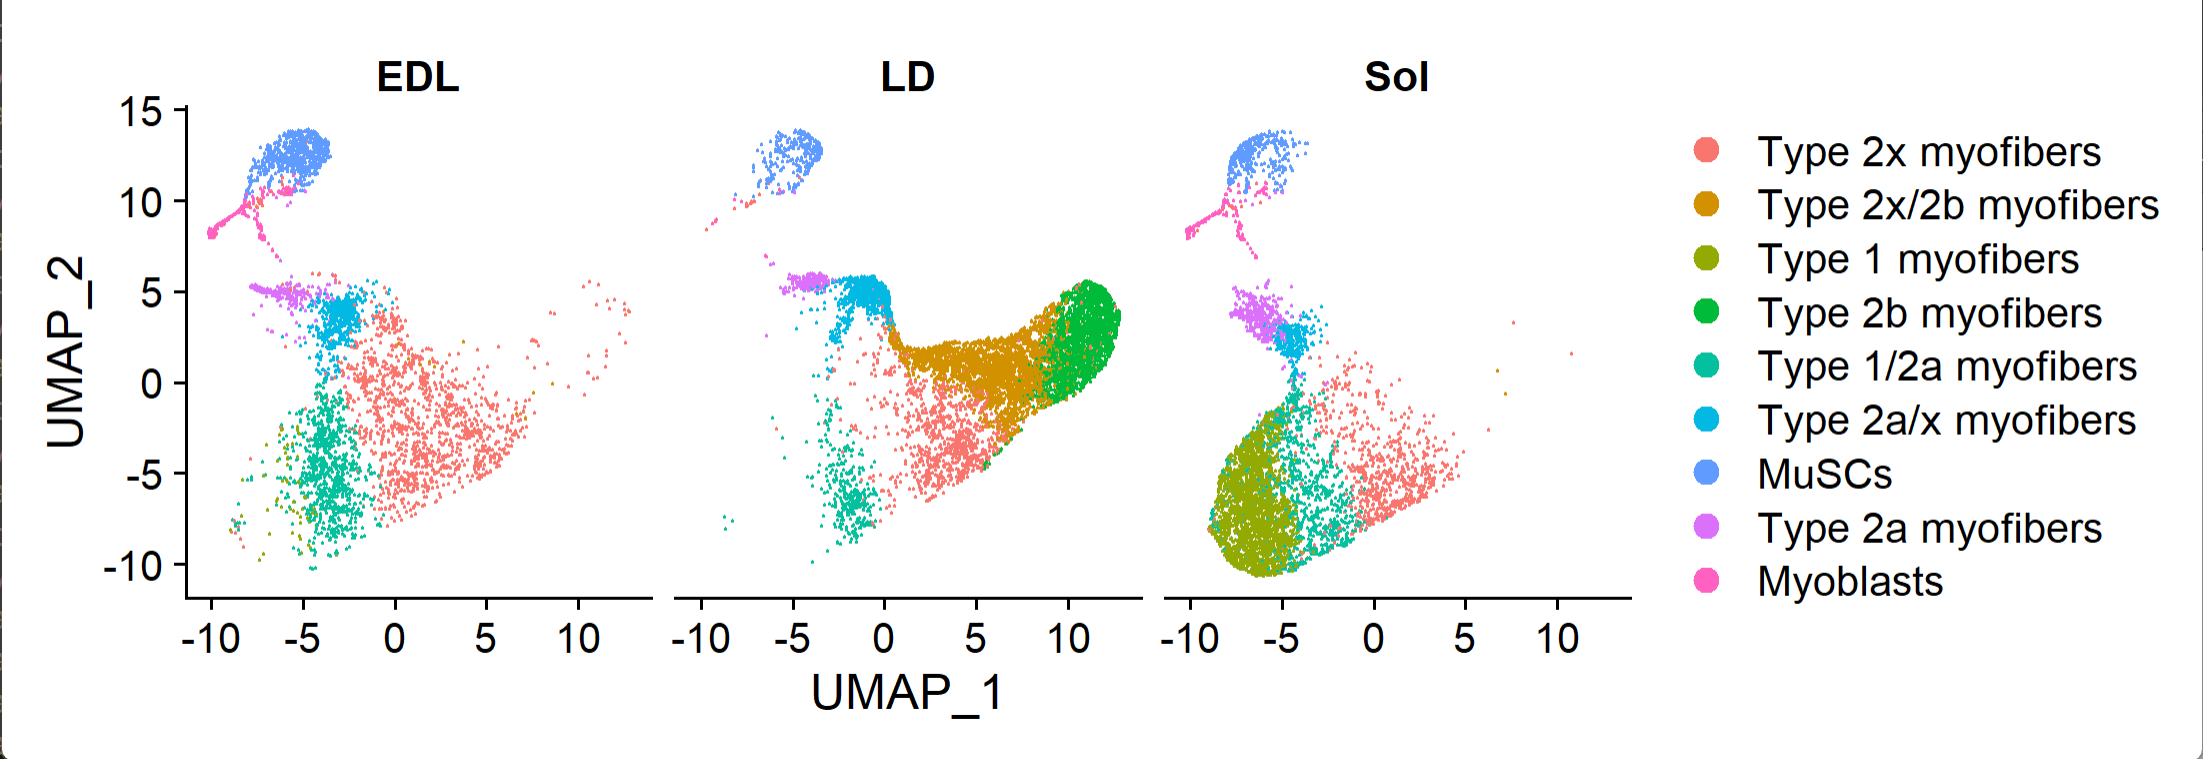

In [ ]:
library(Seurat)
library(dplyr)
library(openxlsx) 

# 获取细胞的orig.ident信息
orig_ident <- sub.myo.sc@meta.data$orig.ident

# 获取细胞的细胞群信息
clusters <- sub.myo.sc@active.ident

# 定义FATP基因列表
fatty_acid_beta_oxidation_genes <- c("SLC27A1", "SLC27A2", "SLC27A3", "SLC27A4", "SLC27A5", "SLC27A6",
"CD36",
"ACSL1","ACSL2","ACSL3","ACSL4","ACSL5","ACSL6",
"ACSS1","ACSS2","ACSS3",
"CPT1","CPT1A","CPT1B","CPT1C",
"SLC25A20",
"CPT2",
"ACADM","ACADVL","ACADL","ACADS","ACADSB","ACAD8",
"ECH1","ECHS1",
"HADH","HSD17B10","HADHA","HADHB",
"ACAA1","ACAA2")

existing_genes <- intersect(fatty_acid_beta_oxidation_genes, rownames(sub.myo.sc))

# 提取存在基因的表达量
gene_expression <- FetchData(sub.myo.sc, vars = existing_genes)

# 将orig.ident和clusters信息加入表达量数据
expression_data <- cbind(orig_ident = orig_ident, clusters = clusters, gene_expression)

# 转换为数据框
expression_data <- as.data.frame(expression_data)

# 确保orig.ident和clusters列正确命名
colnames(expression_data)[1:2] <- c("orig.ident", "clusters")

# 计算每个样本来源和每个细胞群的平均表达量
grouped_expression <- expression_data %>%
    group_by(orig.ident, clusters) %>%
    summarise(across(all_of(existing_genes), median, na.rm = TRUE)) #median/mean

# 导出为Excel文件
write.xlsx(grouped_expression, "FATP_expression_by_sample_and_cluster.xlsx", rowNames = TRUE)

# 显示结果
print(grouped_expression)

In [ ]:
library(Seurat)
library(dplyr)
library(openxlsx) 

# 获取细胞的orig.ident信息
orig_ident <- sub.myo.sc@meta.data$orig.ident

# 获取细胞的细胞群信息
clusters <- sub.myo.sc@active.ident

# 定义TCA基因列表
TCA_cycle_genes <- c("PDHA1", "PDHA2", "PDHB", "DLD", "DLAT", "PDK1","PDK2", "PDK3", "PDK4","PDP1", "PDP2",
"CS",
"ACO2",
"IDH3A","IDH3B","IDH3C",
"OGDH","DLST","DLD",
"SUCLG1",
"SDHA","SDHB","SDHC","SDHD",
"FH",
"MDH1","MDH2")
 
existing_genes <- intersect(TCA_cycle_genes, rownames(sub.myo.sc))

# 提取存在基因的表达量
gene_expression <- FetchData(sub.myo.sc, vars = existing_genes)

# 将orig.ident和clusters信息加入表达量数据
expression_data <- cbind(orig_ident = orig_ident, clusters = clusters, gene_expression)

# 转换为数据框
expression_data <- as.data.frame(expression_data)

# 确保orig.ident和clusters列正确命名
colnames(expression_data)[1:2] <- c("orig.ident", "clusters")

# 计算每个样本来源和每个细胞群的平均表达量
grouped_expression <- expression_data %>%
    group_by(orig.ident, clusters) %>%
    summarise(across(all_of(existing_genes), mean, na.rm = TRUE)) #median/mean

# 导出为Excel文件
write.xlsx(grouped_expression, "TCA_cycle_genes.xlsx", rowNames = TRUE)

# 显示结果
print(grouped_expression)

In [ ]:
library(Seurat)
library(dplyr)
library(openxlsx) 

# 获取细胞的orig.ident信息
orig_ident <- sub.myo.sc@meta.data$orig.ident

# 获取细胞的细胞群信息
clusters <- sub.myo.sc@active.ident

# 定义TCA基因列表
Glycolysis_genes <- c("HK1", "HK2", "HK3", "HK4", 
"GP1",
"PFKL","PFKM", "PFKP",
"ALDOA","ALDOB", "ALDOC",
"TPL1",
"GAPDH",
"PGK1","PGK2",
"PGAM1","PGAM2","PGAM3","PGAM4",
"ENO1","ENO2","ENO3",
"PKLR","PKM",
"LDHA","LDHB","LDHC","LDHD",
"SLC16A1","SLC16A7","SLC16A8","SLC16A3","CD147")
 
existing_genes <- intersect(Glycolysis_genes, rownames(sub.myo.sc))

# 提取存在基因的表达量
gene_expression <- FetchData(sub.myo.sc, vars = existing_genes)

# 将orig.ident和clusters信息加入表达量数据
expression_data <- cbind(orig_ident = orig_ident, clusters = clusters, gene_expression)

# 转换为数据框
expression_data <- as.data.frame(expression_data)

# 确保orig.ident和clusters列正确命名
colnames(expression_data)[1:2] <- c("orig.ident", "clusters")

# 计算每个样本来源和每个细胞群的平均表达量
grouped_expression <- expression_data %>%
    group_by(orig.ident, clusters) %>%
    summarise(across(all_of(existing_genes), mean, na.rm = TRUE)) #median/mean

# 导出为Excel文件
write.xlsx(grouped_expression, "Glycolysis_genes.xlsx", rowNames = TRUE)

# 显示结果
print(grouped_expression)

In [ ]:
heatmap_data <- as.data.frame(grouped_expression)
rownames(heatmap_data) <- paste(heatmap_data$orig.ident, heatmap_data$clusters, sep = "_")
heatmap_data <- heatmap_data[, -c(1, 2)] # 去除orig.ident和clusters列

# 对数据进行标准化（Z-score）
heatmap_data_scaled <- t(scale(t(heatmap_data)))

# 绘制热图
pheatmap(heatmap_data_scaled, scale = "none", cluster_rows = TRUE, cluster_cols = TRUE, show_rownames = TRUE, show_colnames = TRUE)

### R5

In [ ]:
library(Seurat)
library(dplyr)
setwd("Z:\\A\\ST\\Analysis\\Results5")

In [ ]:
sub.adi.sc <- subset(muscle.combined, idents = c("FAPs-1","FAPs-2","FAPs-3","Mature adipocytes"))

In [ ]:
saveRDS(sub.adi.sc,"sub.adi.sc.rds")

my7colors <- c('#049242', '#DD1427', '#0671B2', '#A7C759', '#812870', '#FFB700', '#EB89B1')

In [ ]:
sub.adi.sc <- NormalizeData(sub.adi.sc, normalization.method = "LogNormalize", scale.factor = 10000)
FindVariableFeatures(sub.adi.sc, selection.method = "vst", nfeatures = 3000)

all.genes <- rownames(sub.adi.sc)
sub.adi.sc <- ScaleData(sub.adi.sc, features = all.genes)

sub.adi.sc <- RunPCA(sub.adi.sc, features = VariableFeatures(object = sub.adi.sc))

sub.adi.sc <- FindNeighbors(sub.adi.sc, dims = 1:5)
sub.adi.sc <- FindClusters(sub.adi.sc, resolution = 0.25)
sub.adi.sc <- RunUMAP(sub.adi.sc, dims = 1:5)
DimPlot(sub.adi.sc,label=T, reduction = "umap",cols=my7colors)
DimPlot(sub.adi.sc,label=T, reduction = "umap",split.by="orig.ident")

In [ ]:
VlnPlot(sub.adi.sc, features = "PI16",pt.size=0,ncol = 3)
FeaturePlot(sub.adi.sc, features = c("DDIT4"))

DefaultAssay(sub.adi.sc) <- "integrated"

In [ ]:
sub.adi.sc.markers <- FindAllMarkers(sub.adi.sc, only.pos = FALSE, min.pct = 0.25, logfc.threshold = 0.25)
sub.adi.sc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

top20.marker <- sub.adi.sc.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)							#绘制marker在各个cluster的热图

pdf(file="p101.pdf",width=18,height=35)    
DoHeatmap(sub.adi.sc, features = top20.marker$gene, label=T)
dev.off()

In [ ]:
0 MR-FAPs [LEPR、HMCN2、ADAMTS17、]
1 Preadipocytes [ISM1、THBS1、CD34]
2 MT-rich FAPs [COX3、COX1、ATP6、COX2、ATP2A2]
3 Stem like FAPs [SEMA3C、PI16]
4 Myogenic like FAPs [XIRP2、NRAP、CTNNA3、PDLIM3、MYOD1、MYH1、MYH4、MYH7、PDGFRA、MYOM2、ACTN2、MYBPC1、TNNT3]
5 F3+ FAPs [F3]
6 Mature Adipocytes [ADIPOQ、PPARG、SCD、FASN、FABP4、CEBPA、APOE]

## 注释

In [ ]:
new.cluster.ids <- c("MR-FAPs", "Preadipocytes", "MT-rich FAPs", "Stem like FAPss", "Myogenic like FAPs", "F3+ FAPs","Mature Adipocytes")
names(new.cluster.ids) <- levels(sub.adi.sc)
sub.adi.sc <- RenameIdents(sub.adi.sc, new.cluster.ids)
saveRDS(sub.adi.sc,"sub.adi.sc.rds")

In [ ]:
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)
library(patchwork)
library(monocle)


#### M1

In [ ]:
data <- as(as.matrix(sub.adi.sc@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = sub.adi.sc@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)

Mol_sub.adi.sc <- newCellDataSet(data,
                  phenoData = pd,
                  featureData = fd,
                  lowerDetectionLimit = 0.05,
                  expressionFamily = negbinomial.size())

Mol_sub.adi.sc <- estimateSizeFactors(Mol_sub.adi.sc)
Mol_sub.adi.sc <- estimateDispersions(Mol_sub.adi.sc,cores = 20, relative_expr = TRUE)

cds=Mol_sub.adi.sc
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)


disp_table <- dispersionTable(cds)
disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id
cds <- setOrderingFilter(cds, disp.genes)
cds <- reduceDimension(cds, method = 'DDRTree')

#reduction_method = c("DDRTree", "ICA", "tSNE", "SimplePPT", "L1-graph", "SGL-tree"),
cds <- orderCells(cds)


In [ ]:
plot_cell_trajectory(cds, color_by = "State")
plot_cell_trajectory(cds, color_by = "seurat_clusters")
plot_cell_trajectory(cds, color_by = "Pseudotime")
plot_cell_trajectory(cds, color_by = "State") + facet_wrap(~State, nrow = 1)
P69=plot_cell_trajectory(cds, color_by = "seurat_clusters") + facet_wrap(~seurat_clusters, nrow = 3)
P70=plot_cell_trajectory(cds, color_by = "Pseudotime")
P71=plot_cell_trajectory(cds, color_by = "orig.ident")+ facet_wrap(~orig.ident, nrow = 1)

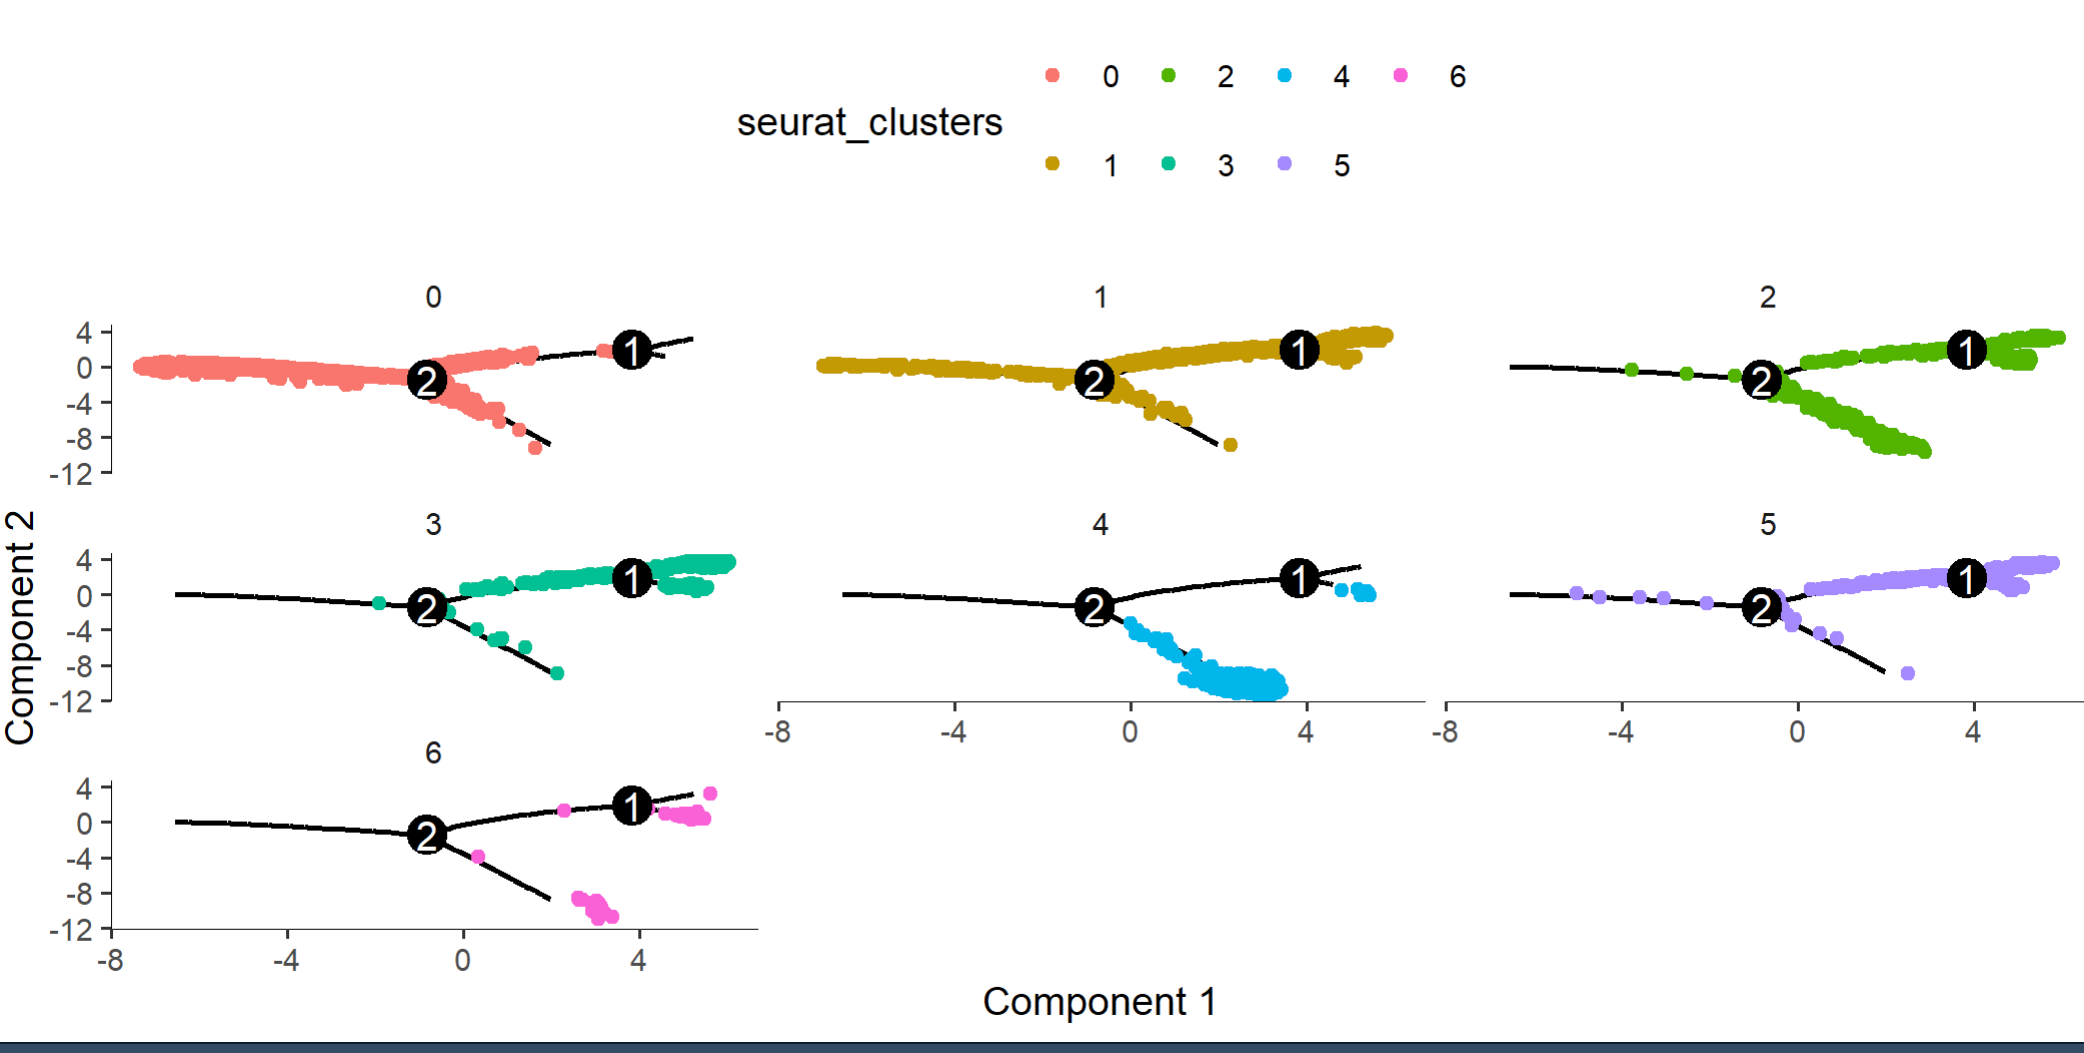

#### M3

In [ ]:
library(monocle3)
library(ggplot2)
library(dplyr)
library(Seurat)
library(SeuratData)

In [ ]:
# 创建 gene_metadata 确保其行数与 counts 的行数一致
gene_metadata <- data.frame(gene_short_name = rownames(sub.adi.sc@assays$RNA@counts),
                            row.names = rownames(sub.adi.sc@assays$RNA@counts))

# 将表达矩阵转为稀疏矩阵
counts_sparse <- as(sub.adi.sc@assays$RNA@counts, "sparseMatrix")

# 创建 cell_data_set 对象
cds <- new_cell_data_set(
  counts_sparse,
  cell_metadata = as.data.frame(sub.adi.sc@meta.data),
  gene_metadata = gene_metadata
)

cds <- preprocess_cds(cds, num_dim = 10)
cds <- reduce_dimension(cds)

cds <- cluster_cells(cds,cluster_method = c("louvain"))





cds <- learn_graph(cds)
plot_cells(cds,
           color_cells_by = "seurat_clusters",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           group_label_size=10,
           label_branch_points=FALSE)
           
custom_colors <- c("0" = "#E85B58", 
                   "1" = "#009959", 
                   "2" = "#3AD7CC", 
                   "3" = "#993591", 
                   "4" = "#DCEBB0", 
                   "5" = "#57C3F3", 
                   "6" = "#476D87")
p3 + scale_color_manual(values = custom_colors)




cds <- order_cells(cds)

plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           cell_size = 0.6,
           label_leaves=FALSE,
           group_label_size=10,
           label_branch_points=FALSE,
           rasterize=F,
           alpha = 1,
           label_principal_points=F,
           graph_label_size=1.5)

#### RNA速率

In [ ]:
sub.bm <- subset(bm, idents = c("3","5","12","14","18"))
sub.bm <- RunPCA(sub.bm, npcs = 10, verbose = FALSE)
sub.bm <- RunUMAP(sub.bm, reduction = "pca", dims = 1:10)
sub.bm <- FindNeighbors(sub.bm, reduction = "pca", dims = 1:10)
sub.bm <- FindClusters(sub.bm, resolution = 0.25)
my7colors <- c('#049242', '#DD1427', '#0671B2', '#A7C759', '#812870', '#FFB700', '#EB89B1')
DimPlot(sub.bm, reduction = "umap", pt.size=0.5,col=my7colors)
my7colors <- c('#049242', '#DD1427', '#0671B2', '#A7C759', '#812870', '#FFB700', '#EB89B1')
save.image("Velocity_R5_1.RData")


VlnPlot(sub.bm, features = c("PDGFRA"))


In [ ]:
conda activate gws
jsub -n 32 -q normal -e error.%J -o output.%J '~/conda_envs/gws/bin/Rscript ./Velocity_5.R' 

#### 点图

In [ ]:
markers.to.plot=c("LEPR","HMCN2","ADAMTS17","COL15A1","ADAM19","OPCML","HPSE2","COL4A1","LAMB1","MME",
"CD34","THBS1","ISM1",
"COX3","COX1","ATP6","COX2","ATP2A2",
"SEMA3C","PI16",
"XIRP2","NRAP","CTNNA3","PDLIM3","MYOD1","MYH1","MYH4","MYH7","MYOM2","ACTN2","MYBPC1","TNNT3",
"F3",
"ADIPOQ","PPARG","SCD","FASN","FABP4","CEBPA","APOE")

In [ ]:
0 MR-FAPs [LEPR、HMCN2、ADAMTS17、COL15A1、ADAM19、OPCML、HPSE2、COL4A1、LAMB1、MME ]
1 Preadipocytes [ISM1、THBS1、CD34]
2 MT-rich FAPs [COX3、COX1、ATP6、COX2、ATP2A2]
3 Stem like FAPs [SEMA3C、PI16]
4 Myogenic like FAPs [XIRP2、NRAP、CTNNA3、PDLIM3、MYOD1、MYH1、MYH4、MYH7、MYOM2、ACTN2、MYBPC1、TNNT3]
5 F3+ FAPs [F3]
6 Mature Adipocytes [ADIPOQ、PPARG、SCD、FASN、FABP4、CEBPA、APOE]

In [ ]:
DefaultAssay(sub.adi.sc) <- "RNA"
DotPlot(sub.adi.sc, features = markers.to.plot, cols = c("white","#EB89B1"), dot.scale = 8) + RotatedAxis()
DotPlot(sub.adi.sc, features = markers.to.plot, dot.scale = 8) + RotatedAxis()
my7colors <- c('#049242', '#DD1427', '#0671B2', '#A7C759', '#812870', '#FFB700', '#EB89B1')

In [ ]:
colors <- c(my7colors,"white")

#### 比例

In [ ]:
Cellratio <- prop.table(table(Idents(sub.adi.sc), sub.adi.sc$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)
colourCount = length(unique(Cellratio$Var1))

In [ ]:
#可视化
ggplot(Cellratio, aes(x = Var2, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = my7colors)+
  labs(x = NULL, y = "Ratio", fill = "Sample Type", title = "Sample Ratio by Type") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

#### Enrichment

In [ ]:
#筛选出Markers基因
filtered_markers <- sub.adi.sc.markers %>% filter(!grepl("^ENSSSCG", gene))
New.markers <- filtered_markers %>%
  group_by(cluster) %>%
  top_n(25, wt = avg_log2FC) %>%
  ungroup()
head(New.markers)


New.markers[36,7]="CD34"
New.markers[27,7]="THBS1"
New.markers[50,7]="ISM1"
New.markers[99,7]="PI16"
New.markers[119,7]="MYH4"
New.markers[120,7]="MYOD1"
New.markers[174,7]="CEBPA"
New.markers[129,7]="F3"

131,135,136,146,147,149,150


# 删除指定行
New.markers <- New.markers[-c(131, 135, 136, 146, 147, 149, 150), ]

# 查看修改后的数据框的头部，以确认更改
head(New.markers)

In [ ]:
#功能富集
library(clusterProfiler)
library(org.Hs.eg.db) 
library(AnnotationDbi)
library(DOSE)

# 将New.markers按cluster分组
markers_by_cluster <- split(New.markers$gene, New.markers$cluster)

go_results <- list()

for (cluster in names(markers_by_cluster)) {
    genes <- markers_by_cluster[[cluster]]
    
    # 将基因符号转换为ENTREZ ID
    gene_entrez <- bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
    
    # 进行GO富集分析
    go_results[[cluster]] <- enrichGO(gene = gene_entrez$ENTREZID,
                                      OrgDb = org.Hs.eg.db,
                                      ont = "ALL", # 生物过程
                                      pAdjustMethod = "BH",
                                      pvalueCutoff = 0.9,
                                      qvalueCutoff = 0.9,
                                      readable = TRUE)
}








# 过滤掉每个细胞群中只有一个基因富集到的通路
new_go_results <- list()
for (cluster in names(go_results)) {
    # 获取当前细胞群的GO富集分析结果
    go_result <- go_results[[cluster]]@result
    # 分割GeneRatio列并转换为数值
    gene_ratio_split <- strsplit(as.character(go_result$GeneRatio), "/")
    gene_ratio_numeric <- do.call(rbind, gene_ratio_split)
    gene_ratio_numeric <- apply(gene_ratio_numeric, 2, as.numeric)
    # 筛选分子大于1的行
    filter_indices <- gene_ratio_numeric[, 1] > 1
    filtered_result <- go_result[filter_indices, ]
    # 将过滤后的结果存储到新列表中
    new_go_results[[cluster]] <- filtered_result
}
head(new_go_results[["6"]])


In [ ]:
#数据可视化2，terms精选
library(circlize)
cluster <- "2"
go_result <- new_go_results[[cluster]]

# 按照GeneRatio从大到小排序并选择前8个terms
go_result <- go_result[order(go_result$GeneRatio, decreasing = TRUE), ]
go_result <- head(go_result, 8)

# 创建基因和GO条目之间的关系数据框
data <- do.call(rbind, lapply(seq(nrow(go_result)), function(i) {
    genes <- unlist(strsplit(go_result$geneID[i], "/"))
    data.frame(from = genes, to = rep(go_result$Description[i], length(genes)))
}))

# 计算独特扇区的数量（基因和GO条目）
num_sectors <- length(unique(c(data$from, data$to)))

# 清理之前的图形设置
circos.clear()

# 设置绘图参数，比如扇区间的间隔
circos.par(gap.degree = rep(1, num_sectors))

my36colors <- c('#CE0317', '#009959', '#3AD7CC', '#993591', '#D6E7A3', '#57C3F3', '#476D87',
               '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
               '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
               '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
               '#712820', '#DCC1DD', '#CCE0F5',  '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
               '#968175')

# 绘制和弦图
chordDiagram(
  data,
  transparency = 0.5,
  link.border = "black",
  grid.border = "black",
  annotationTrack = "grid",
  annotationTrackHeight = c(0.15, 0.15)  # 增加外层圆圈的厚度
)



# 添加图形标题
title(paste("Cluster", cluster))

#### 细胞周期

In [ ]:
s.genes <- c("MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", 
             "GINS2", "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", 
             "RFC2", "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", 
             "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", 
             "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", 
             "CHAF1B", "BRIP1", "E2F8")

g2m.genes <- c("HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", 
               "NDC80", "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", 
               "TACC3", "FAM64A", "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", 
               "BUB1", "KIF11", "ANP32E", "TUBB4B", "GTSE1", "KIF20B", "HJURP", 
               "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF2C", "RANGAP1", 
               "NCAPG", "DLGAP5", "CDCA2", "CDCA8", "ECT2", "KIF23", "HMMR", 
               "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", "CTCF", 
               "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA")

In [ ]:
sub.adi.sc <- CellCycleScoring(sub.adi.sc, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
sub.adi.sc$cell_cycle_phase <- sub.adi.sc$Phase

In [ ]:
DimPlot(sub.adi.sc, reduction = "umap", group.by = "Phase")

In [ ]:
cell_cycle_table <- table(sub.adi.sc@meta.data$tissue, sub.adi.sc@meta.data$cell_type, sub.adi.sc@meta.data$Phase)


In [ ]:
VlnPlot(MuScle.list.Sc.order, features = markers, idents = desired_order, stacked = TRUE, pt.size = 0, cols = my36colors_2, direction = "horizontal") +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())


In [ ]:
DimPlot(sub.adi.sc, reduction = "umap", group.by = "Phase",cols=c("#C00000","#8064A2","#039314","#039314"))

#### 比较分析

In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(tibble) 

# 提取 Seurat 对象的 active.ident 信息
active.ident <- as.character(Idents(sub.adi.sc))

# 将 active.ident 添加到 meta.data
meta_data <- sub.adi.sc@meta.data
meta_data$active.ident <- active.ident

# 打印 active.ident 列的内容以确认它正确包含在 meta.data 中
print(table(meta_data$active.ident))

# 提取 Sol 来源的 MR-FAPs 细胞
sol_mr_faps <- rownames(meta_data[meta_data$orig.ident == "Sol" & meta_data$active.ident == "MR-FAPs", ])

# 提取所有 MR-FAPs 细胞
all_mr_faps <- rownames(meta_data[meta_data$active.ident == "MR-FAPs", ])

# 打印提取到的细胞数量以确认它们是合理的
print(length(sol_mr_faps))
print(length(all_mr_faps))
print(head(sol_mr_faps))

# 创建一个新的元数据列 'group' 用于标识不同的细胞群
meta_data$group <- NA
meta_data$group[rownames(meta_data) %in% sol_mr_faps] <- "Sol_MR-FAPs"
meta_data$group[rownames(meta_data) %in% all_mr_faps & is.na(meta_data$group)] <- "All_MR-FAPs"
meta_data$group <- factor(meta_data$group, levels = c("Sol_MR-FAPs", "All_MR-FAPs"))
sub.adi.sc@meta.data <- meta_data

# 检查分组情况
print(table(meta_data$group))

# 只选择有分组信息的细胞
group_cells <- rownames(meta_data[!is.na(meta_data$group), ])
sub.adi.sc_subset <- subset(sub.adi.sc, cells = group_cells)

Idents(sub.adi.sc_subset) <- sub.adi.sc_subset$group
print(table(Idents(sub.adi.sc_subset)))
print(table(sub.adi.sc_subset$group))

# 再次检查 Sol_MR-FAPs 是否正确提取并传递到子集中
sol_mr_faps_in_subset <- rownames(sub.adi.sc_subset@meta.data[sub.adi.sc_subset@meta.data$group == "Sol_MR-FAPs", ])
print(length(sol_mr_faps_in_subset))  # 打印数量以确保包含 Sol_MR-FAPs

# 差异表达分析
diff_exp <- FindMarkers(sub.adi.sc_subset, ident.1 = "Sol_MR-FAPs", ident.2 = "All_MR-FAPs")
print(head(diff_exp))

# 准备绘制火山图的数据
diff_exp <- diff_exp %>%
    rownames_to_column(var = "gene") %>%
    mutate(Significance = ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 1, "Significant", "Not Significant"))

# 绘制火山图
ggplot(diff_exp, aes(x = avg_log2FC, y = -log10(p_val_adj), color = Significance)) +
  geom_point() +
  theme_minimal() +
  labs(title = "Volcano Plot: Sol_MR-FAPs vs All_MR-FAPs", x = "Log2 Fold Change", y = "-Log10 Adjusted P-Value") +
  scale_color_manual(values = c("Significant" = "red", "Not Significant" = "black"))


In [ ]:
### 集成函数
library(Seurat)
library(ggplot2)
library(dplyr)
library(tibble)

# 定义差异表达分析函数
perform_diff_exp <- function(seurat_obj, celltype, tissue, p_val_adj_threshold = 0.05, log2fc_threshold = 1) {
  # 提取 Seurat 对象的 active.ident 信息
  active.ident <- as.character(Idents(seurat_obj))
  
  # 将 active.ident 添加到 meta.data
  meta_data <- seurat_obj@meta.data
  meta_data$active.ident <- active.ident
  
  # 提取特定组织来源的特定细胞群
  specific_cells <- rownames(meta_data[meta_data$orig.ident == tissue & meta_data$active.ident == celltype, ])
  
  # 提取所有特定细胞群
  all_cells <- rownames(meta_data[meta_data$active.ident == celltype, ])
  
  # 创建一个新的元数据列 'group' 用于标识不同的细胞群
  meta_data$group <- NA
  meta_data$group[rownames(meta_data) %in% specific_cells] <- paste(tissue, celltype, sep = "_")
  meta_data$group[rownames(meta_data) %in% all_cells & is.na(meta_data$group)] <- paste("All", celltype, sep = "_")
  meta_data$group <- factor(meta_data$group, levels = c(paste(tissue, celltype, sep = "_"), paste("All", celltype, sep = "_")))
  seurat_obj@meta.data <- meta_data
  
  # 只选择有分组信息的细胞
  group_cells <- rownames(meta_data[!is.na(meta_data$group), ])
  seurat_obj_subset <- subset(seurat_obj, cells = group_cells)
  
  Idents(seurat_obj_subset) <- seurat_obj_subset$group
  
  # 差异表达分析
  diff_exp <- FindMarkers(seurat_obj_subset, ident.1 = paste(tissue, celltype, sep = "_"), ident.2 = paste("All", celltype, sep = "_"))
  
  # 准备绘制火山图的数据
  diff_exp <- diff_exp %>%
    rownames_to_column(var = "gene") %>%
    mutate(Significance = ifelse(p_val_adj < p_val_adj_threshold & abs(avg_log2FC) > log2fc_threshold, "Significant", "Not Significant"))
  
  return(diff_exp)
}

# 使用示例
diff_exp_result <- perform_diff_exp(sub.adi.sc, "MR-FAPs", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
print(head(diff_exp_result))


In [ ]:
diff_exp_result_SolMR <- perform_diff_exp(sub.adi.sc, "MR-FAPs", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_Preadipocytes <- perform_diff_exp(sub.adi.sc, "Preadipocytes", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_StemlikeFAPs <- perform_diff_exp(sub.adi.sc, "Stem like FAPss", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_MTrichFAPs <- perform_diff_exp(sub.adi.sc, "MT-rich FAPs", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_F3FAPs <- perform_diff_exp(sub.adi.sc, "F3+ FAPs", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_MyogeniclikeFAPs  <- perform_diff_exp(sub.adi.sc, "Myogenic like FAPs", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_Sol_MatureAdipocytes  <- perform_diff_exp(sub.adi.sc, "Mature Adipocytes", "Sol", p_val_adj_threshold = 0.05, log2fc_threshold = 1)


diff_exp_result_LDMR <- perform_diff_exp(sub.adi.sc, "MR-FAPs", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_Preadipocytes <- perform_diff_exp(sub.adi.sc, "Preadipocytes", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_StemlikeFAPs <- perform_diff_exp(sub.adi.sc, "Stem like FAPss", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_MTrichFAPs <- perform_diff_exp(sub.adi.sc, "MT-rich FAPs", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_F3FAPs <- perform_diff_exp(sub.adi.sc, "F3+ FAPs", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_MyogeniclikeFAPs  <- perform_diff_exp(sub.adi.sc, "Myogenic like FAPs", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_LD_MatureAdipocytes  <- perform_diff_exp(sub.adi.sc, "Mature Adipocytes", "LD", p_val_adj_threshold = 0.05, log2fc_threshold = 1)

diff_exp_result_EDLMR <- perform_diff_exp(sub.adi.sc, "MR-FAPs", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_Preadipocytes <- perform_diff_exp(sub.adi.sc, "Preadipocytes", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_StemlikeFAPs <- perform_diff_exp(sub.adi.sc, "Stem like FAPss", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_MTrichFAPs <- perform_diff_exp(sub.adi.sc, "MT-rich FAPs", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_F3FAPs <- perform_diff_exp(sub.adi.sc, "F3+ FAPs", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_MyogeniclikeFAPs  <- perform_diff_exp(sub.adi.sc, "Myogenic like FAPs", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)
diff_exp_result_EDL_MatureAdipocytes  <- perform_diff_exp(sub.adi.sc, "Mature Adipocytes", "EDL", p_val_adj_threshold = 0.05, log2fc_threshold = 1)

C:\Users\1\AppData\Local\Temp\ipykernel_48420\3597484560.py:27: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  plt.savefig('Z:\A\ST\Analysis\Results5\compare\折线图.pdf', format='pdf')
C:\Users\1\AppData\Local\Temp\ipykernel_48420\3597484560.py:27: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from current font.
  plt.savefig('Z:\A\ST\Analysis\Results5\compare\折线图.pdf', format='pdf')
C:\Users\1\AppData\Local\Temp\ipykernel_48420\3597484560.py:27: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  plt.savefig('Z:\A\ST\Analysis\Results5\compare\折线图.pdf', format='pdf')
C:\Users\1\AppData\Local\Temp\ipykernel_48420\3597484560.py:27: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.savefig('Z:\A\ST\Analysis\Results5\compare\折线图.pdf', format='pdf')
C:\Users\1\AppData\Local\Temp\ipykernel_48420\3597484560.py:27: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRA

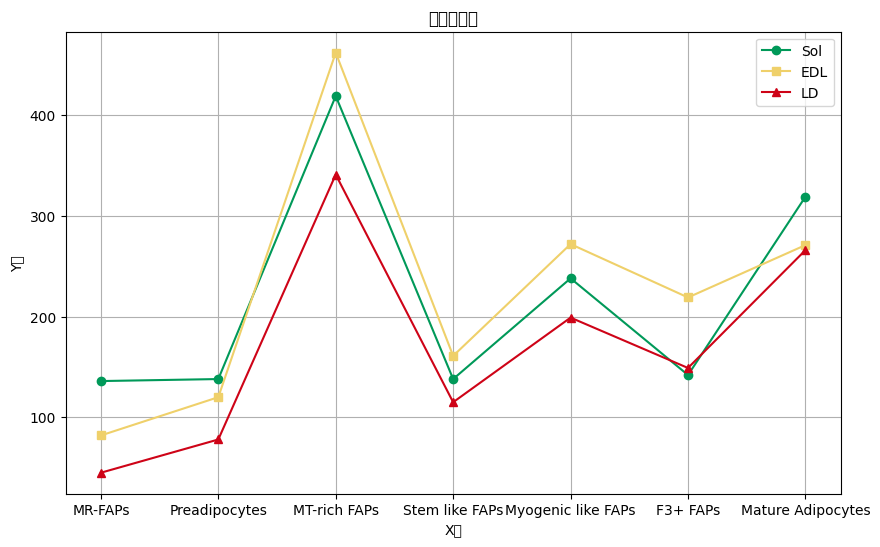

In [4]:
import matplotlib.pyplot as plt

# 数据
x_labels = ['MR-FAPs', 'Preadipocytes', 'MT-rich FAPs', 'Stem like FAPs', 'Myogenic like FAPs', 'F3+ FAPs', 'Mature Adipocytes']
Sol_data = [136, 138, 419, 138, 238, 142, 319]
EDL_data = [82, 120, 462, 161, 272, 219, 271]
LD_data = [45, 78, 341, 115, 199, 149, 266]

plt.figure(figsize=(10, 6))

plt.plot(x_labels, Sol_data, label='Sol', color='#009959', marker='o')
plt.plot(x_labels, EDL_data, label='EDL', color='#EFD06A', marker='s')
plt.plot(x_labels, LD_data, label='LD', color='#CE0317', marker='^')

# 添加标题和标签
plt.title('折线图示例')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 保存图表为PDF
plt.savefig('Z:\A\ST\Analysis\Results5\compare\折线图.pdf', format='pdf')

# 显示图表
plt.show()

#### MR_FAPs

In [ ]:
load("Z:/A/ST/Analysis/Results5/MR_FAPs/2.29.RData")
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(magrittr)

In [ ]:
SpatialFeaturePlot(LD, features = c("LEPR"))

###以下为上述代码的循环（保存为一个pdf）
samples <- list(EDL = EDL, LD = LD, Sol = Sol)
genes <- c("LEPR", "HMCN2", "ADAMTS17", "COL15A1", "ADAM19", "OPCML", "HPSE2", "COL4A1", "LAMB1", "MME")

# 设置输出PDF文件
pdf(file = "Z:/A/ST/Analysis/Results5/MR_FAPs/SpatialFeaturePlots.pdf", width = 8, height = 10)

# 循环绘制每个样本和每个基因的图
for (sample_name in names(samples)) {
  for (gene in genes) {
    plot <- SpatialFeaturePlot(samples[[sample_name]], features = gene, min.cutoff = 0, max.cutoff = 5, pt.size.factor = 1) +
      ggtitle(paste(sample_name, gene))
    print(plot)
  }
}
dev.off()


###以下为上述代码的循环（每张图片保存为一个单独的pdf）
samples <- list(EDL = EDL, LD = LD, Sol = Sol)
genes <- c("LEPR", "HMCN2", "ADAMTS17", "COL15A1", "ADAM19", "OPCML", "HPSE2", "COL4A1", "LAMB1", "MME")

# 创建输出目录
output_dir <- "Z:/A/ST/Analysis/Results5/MR_FAPs"
dir.create(output_dir, showWarnings = FALSE)

# 循环绘制每个样本和每个基因的图，并单独保存为PDF
for (sample_name in names(samples)) {
  for (gene in genes) {
    plot <- SpatialFeaturePlot(samples[[sample_name]], features = gene, min.cutoff = 0, max.cutoff = 5, pt.size.factor = 1) +
      ggtitle(paste(sample_name, gene))
    
    # 设置文件名
    file_name <- paste0(output_dir, "/", sample_name, "_", gene, ".pdf")
    
    # 保存为PDF
    pdf(file = file_name, width = 8, height = 10)
    print(plot)
    dev.off()
  }
}

#### 差异分析

In [ ]:
library(Seurat)
library(ggplot2)
library(cowplot)
library(dplyr)
library(ggrepel)
theme_set(theme_cowplot())

plot_scatter_with_top_genes <- function(seurat_obj, cell_group, tissue_1, tissue_2, threshold = 1e5, top_n = 10) {
    active.ident <- as.character(Idents(seurat_obj))
    meta_data <- seurat_obj@meta.data
    meta_data$active.ident <- active.ident
    
    if (tissue_2 == "ALL") {
        tissue_1_cells <- rownames(meta_data[meta_data$orig.ident == tissue_1 & meta_data$active.ident == cell_group, ])
        
        all_cells <- rownames(meta_data[meta_data$active.ident == cell_group, ])
        
        meta_data$group <- NA
        meta_data$group[rownames(meta_data) %in% tissue_1_cells] <- paste0(tissue_1, "_", cell_group)
        meta_data$group[rownames(meta_data) %in% all_cells & is.na(meta_data$group)] <- paste0("ALL_", cell_group)
    } else {
        tissue_1_cells <- rownames(meta_data[meta_data$orig.ident == tissue_1 & meta_data$active.ident == cell_group, ])
        tissue_2_cells <- rownames(meta_data[meta_data$orig.ident == tissue_2 & meta_data$active.ident == cell_group, ])
        
        meta_data$group <- NA
        meta_data$group[rownames(meta_data) %in% tissue_1_cells] <- paste0(tissue_1, "_", cell_group)
        meta_data$group[rownames(meta_data) %in% tissue_2_cells] <- paste0(tissue_2, "_", cell_group)
    }
    
    meta_data$group <- factor(meta_data$group, levels = unique(meta_data$group))
    seurat_obj@meta.data <- meta_data

    print(table(meta_data$group))
    
    aggregate_data <- AggregateExpression(seurat_obj, group.by = "group", assays = "RNA", slot = "data")
    
    data <- as.data.frame(aggregate_data$RNA)
    
    tissue_2_label <- ifelse(tissue_2 == "ALL", "ALL", tissue_2)
    expression_data <- data.frame(
        Gene = rownames(aggregate_data$RNA),
        Tissue_1 = aggregate_data$RNA[, paste0(tissue_1, "_", cell_group)],
        Tissue_2 = aggregate_data$RNA[, paste0(tissue_2_label, "_", cell_group)]
    )
    
    filtered_data <- expression_data[expression_data$Tissue_1 < threshold & expression_data$Tissue_2 < threshold, ]
    
    top_genes <- filtered_data %>%
        arrange(desc(Tissue_1)) %>%
        head(top_n)
    
    p <- ggplot(filtered_data, aes(x = Tissue_1, y = Tissue_2)) +
        geom_point() +
        geom_text_repel(data = top_genes, aes(label = Gene), size = 3) +
        ggtitle(paste0("Scatter Plot of ", tissue_1, "_", cell_group, " vs ", tissue_2_label, "_", cell_group)) +
        xlab(paste0(tissue_1, "_", cell_group)) +
        ylab(paste0(tissue_2_label, "_", cell_group)) +
        theme_minimal()
    
    print(p)
}

# 调用函数
plot_scatter_with_top_genes(sub.adi.sc, "Mature Adipocytes", "Sol", "ALL", threshold = 2e4, top_n = 10)
plot_scatter_with_top_genes(sub.adi.sc, "Mature Adipocytes", "Sol", "EDL", threshold = 2e4, top_n = 10)

#### 差异分析结果的富集分析

In [ ]:
# 加载必要的包
library(Seurat)
library(ggplot2)
library(cowplot)
library(dplyr)
library(ggrepel)
library(clusterProfiler)
library(org.Hs.eg.db)
library(GOplot)
theme_set(theme_cowplot())

# 将活动标识添加到元数据中
active.ident <- as.character(Idents(sub.adi.sc))
meta_data <- sub.adi.sc@meta.data
meta_data$active.ident <- active.ident

# 提取两个组织来源的细胞
tissue_1 <- "Sol"
tissue_2 <- "EDL"
cell_group <- "Mature Adipocytes"
tissue_1_cells <- rownames(meta_data[meta_data$orig.ident == tissue_1 & meta_data$active.ident == cell_group, ])
tissue_2_cells <- rownames(meta_data[meta_data$orig.ident == tissue_2 & meta_data$active.ident == cell_group, ])

# 创建一个新的元数据列 'group' 用于标识不同的细胞群
meta_data$group <- NA
meta_data$group[rownames(meta_data) %in% tissue_1_cells] <- paste0(tissue_1, "_", cell_group)
meta_data$group[rownames(meta_data) %in% tissue_2_cells] <- paste0(tissue_2, "_", cell_group)
meta_data$group <- factor(meta_data$group, levels = unique(meta_data$group))
sub.adi.sc@meta.data <- meta_data

# 检查分组情况
print(table(meta_data$group))

# 确认组别是否正确
print(head(meta_data))

# 设置Idents
Idents(sub.adi.sc) <- sub.adi.sc@meta.data$group

# 再次检查Idents
print(table(Idents(sub.adi.sc)))

# 使用FindMarkers函数进行差异表达分析
diff_exp <- FindMarkers(sub.adi.sc, ident.1 = paste0(tissue_1, "_", cell_group), ident.2 = paste0(tissue_2, "_", cell_group))
diff_exp <- diff_exp[order(diff_exp$avg_log2FC, decreasing = TRUE), ]

min_se_threshold <- 1e-10


diff_exp_t <- FindMarkers(sub.adi.sc, ident.1 = paste0(tissue_1, "_", cell_group), ident.2 = paste0(tissue_2, "_", cell_group), test.use = "t")
diff_exp_t <- diff_exp_t[order(diff_exp_t$avg_log2FC, decreasing = TRUE), ]
head(diff_exp_t)

# B检验
diff_exp_b <- FindMarkers(sub.adi.sc, ident.1 = paste0(tissue_1, "_", cell_group), ident.2 = paste0(tissue_2, "_", cell_group), test.use = "bimod")
diff_exp_b <- diff_exp_b[order(diff_exp_b$avg_log2FC, decreasing = TRUE), ]
head(diff_exp_b)



# 计算t检验中的log2FC的标准误和t值
diff_exp_t$se_log2FC <- (diff_exp_t$avg_log2FC / qnorm(1 - diff_exp_t$p_val / 2))
diff_exp_t$se_log2FC[diff_exp_t$se_log2FC < min_se_threshold] <- min_se_threshold
diff_exp_t$t <- diff_exp_t$avg_log2FC / diff_exp_t$se_log2FC

# 计算B检验中的log2FC的标准误和B值
diff_exp_b$se_log2FC <- (diff_exp_b$avg_log2FC / qnorm(1 - diff_exp_b$p_val / 2))
diff_exp_b$se_log2FC[diff_exp_b$se_log2FC < min_se_threshold] <- min_se_threshold
diff_exp_b$B <- diff_exp_b$avg_log2FC / diff_exp_b$se_log2FC

# 合并t检验和B检验的结果
diff_exp <- merge(diff_exp_t, diff_exp_b[, c("avg_log2FC", "B")], by = "row.names", suffixes = c("_t", "_b"))
rownames(diff_exp) <- diff_exp$Row.names
diff_exp <- diff_exp[, -1]

# 重命名列
colnames(diff_exp) <- gsub("\\.x", "", colnames(diff_exp))
colnames(diff_exp) <- gsub("\\.y", "_B", colnames(diff_exp))

# 查看表格
head(diff_exp)



##########以上获得差异基因##########
library(GOplot)
library(clusterProfiler)
library(org.Hs.eg.db)
library(tidyr)
library(dplyr)

# 过滤 diff_exp 数据集
filtered_genes <- diff_exp[diff_exp$p_val < 0.05 & diff_exp$avg_log2FC_b > 0.3, ]
filtered_genes$gene <- rownames(filtered_genes)

# 准备基因列表进行 GO 分析
gene_list <- filtered_genes$gene

# 执行 GO 分析
ego <- enrichGO(gene          = gene_list,
                OrgDb         = org.Hs.eg.db,
                keyType       = "SYMBOL",
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,
                qvalueCutoff  = 1,
                readable      = TRUE)

# 准备 GOplot 的输入数据
go_data <- data.frame(ego)
colnames(go_data)[1] = "Category"

# 确认 genelist 数据格式
genelist <- data.frame(ID = filtered_genes$gene, logFC = filtered_genes$avg_log2FC_b)

# 确保 go_data 包含必要的列
go_data <- go_data[, c("ID", "Description", "geneID", "p.adjust", "Category")]
colnames(go_data) <- c("ID", "Term", "Genes", "adj_pval", "Category")

# 确保 Genes 列格式正确
go_data$Genes <- sapply(go_data$Genes, function(x) paste(unlist(strsplit(x, "/")), collapse = ", "))

# 确认所有列
required_columns <- c("Category", "ID", "Term", "Genes", "adj_pval")
go_data <- go_data[, required_columns]

# 不进行展开，保持原始格式
go_data_long <- go_data %>%
  left_join(genelist, by = c("Genes" = "ID"))

# 检查 Genes 列是否有空值
go_data_long <- go_data_long[!is.na(go_data_long$Genes), ]

# 使用基础 R 重命名 logFC 列以避免冲突
names(go_data_long)[names(go_data_long) == "logFC"] <- "logFC_gene"

go_data_long <- subset(go_data_long, select = -logFC_gene)

# 确认 go_data_long 包含 circle_dat 函数预期的列
print(head(go_data_long))


# 添加 ID 列
diff_exp$ID <- rownames(diff_exp)

# 计算 AveExpr 列（使用 pct.1 和 pct.2 的均值作为示例）
diff_exp$AveExpr <- (diff_exp$pct.1 + diff_exp$pct.2) / 2

# 重命名列名
colnames(diff_exp) <- c("P.Value", "logFC_t", "pct.1", "pct.2", "adj.P.Val", "se_logFC", "t", "logFC_b", "B", "ID", "AveExpr")

# 创建 new_diff_exp 并选择需要的列
new_diff_exp <- diff_exp[, c("ID", "logFC_b", "AveExpr", "t", "P.Value", "adj.P.Val", "B")]

# 重命名列名以匹配 EC$genelist
colnames(new_diff_exp) <- c("ID", "logFC", "AveExpr", "t", "P.Value", "adj.P.Val", "B")

rownames(new_diff_exp) <- 1:nrow(new_diff_exp)

# 检查结果
head(new_diff_exp)

circ <- circle_dat(go_data_long, new_diff_exp)
GOBubble(circ, labels = 3)






# 使用 circle_dat 函数生成绘图对象
circ <- circle_dat(go_data_long, genelist)

# 打印 circ 内容以检查结果
print(head(circ))

# 绘制泡沫图，标签阈值设为 3
GOBubble(circ, labels = 3)


##########以上数据可视化##########


#### GSEA分析

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results5\\gsea")
library(clusterProfiler)
library(org.Hs.eg.db)
library(DOSE)
library(ggplot2)
library(clusterProfiler)
library(enrichplot)
library(org.Hs.eg.db)
library(ggplot2)

In [ ]:
logFC_values <- diff_exp$logFC_b
names(logFC_values) <- diff_exp$ID
logFC_values <- sort(logFC_values, decreasing = TRUE)

In [ ]:
logFC_values <- diff_exp$logFC_b
names(logFC_values) <- diff_exp$ID
logFC_values <- sort(logFC_values, decreasing = TRUE)

gsea_results <- gseGO(
  geneList = logFC_values,
  OrgDb = org.Hs.eg.db,
  keyType = "SYMBOL",
  ont = "ALL", # 包括所有 GO 类别
  nPerm = 2000, # 置换测试次数
  minGSSize = 5, # 最小基因集大小
  maxGSSize = 1000, # 最大基因集大小
  pvalueCutoff = 1, # 放宽 p 值阈值
  verbose = FALSE
)

gene_sets <- c("GO:0006633", "GO:0046394","GO:0072330","GO:0071616","GO:0006631","GO:0008152","GO:0044237","GO:0019222")
gseaplot2(gsea_results, geneSetID = gene_sets, title = "Enrichment plot: GO:0006633", subplots = 1:3, base_size = 10)

In [ ]:
gene_sets <- c("GO:0006633", "GO:0046394","GO:0072330","GO:0071616","GO:0006631","GO:0008152","GO:0044237","GO:0019222")
gseaplot2(gsea_results, geneSetID = gene_sets, title = "Enrichment plot: GO:0006633", subplots = 1:3, base_size = 10)

#### MT_FAPs

In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
setwd("Z:\\A\\ST\\Analysis\\Results5\\MT_FAPs")
sub.adi.sc <- readRDS("Z:/A/ST/Analysis/Results5/MT_FAPs/sub.adi.sc.rds")

In [ ]:
VlnPlot(sub.adi.sc, features = c("CPT1"),split.by="orig.ident")

In [ ]:
FeaturePlot(sub.adi.sc, features = c("TNNI1","MYH7", "PPARGC1A"), split.by="orig.ident", cols = c("#b6b6b6", "red"))

In [ ]:
library(Seurat)
library(ggplot2)

#配色方案
my36colors <- c('#E5D2DD', '#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87',
         '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
         '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
         '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
         '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
         '#968175')

modify_vlnplot <- function(obj, feature, pt.size = 0, plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),...) {
       p <- VlnPlot(obj, features = feature, split.by="orig.ident",pt.size = pt.size, ... ) +
               xlab("") + ylab(feature) + ggtitle("") +
               theme(legend.position = "none",
               axis.text.x = element_blank(),
               axis.text.y = element_blank(),
               axis.ticks.x = element_blank(),
               axis.ticks.y = element_line(),
               axis.title.y = element_text(size = rel(1), angle = 0, vjust = 0.5),
               plot.margin = plot.margin )
       return(p)
}

## main function
StackedVlnPlot <- function(obj, features, pt.size = 0, plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"), ...) {
       plot_list <- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
            plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
            theme(axis.text.x=element_text(), axis.ticks.x = element_line())
       p <- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
       return(p)
}

In [ ]:
##########三羧酸循环##########

In [ ]:
StackedVlnPlot(sub.adi.sc, c('PDHA1',"PDHB","DLD","DLAT",'PDK1',"PDK2","PDK3","PDK4","PDP1","PDP2",
'CS',"ACO2",
'IDH3A','IDH3B',
'OGDH','DLST',
'SUCLG1',
'SDHA','SDHB','SDHC',
'FH',
"MDH1","MDH2"), pt.size=0, cols=my36colors)

In [ ]:
##########脂肪酸β氧化##########

In [ ]:
StackedVlnPlot(sub.adi.sc, c('SLC27A1',"SLC27A3","SLC27A4","SLC27A5",
'ACSL1',"ACSL3",'ACSL4',"ACSL5","ACSL6",
'ACSS1','ACSS2','ACSS3',
'CPT1A','CPT1B',"CPT1C",
'SLC25A20',
'CPT2',
'ACADM',"ACADVL","ACADL","ACADS","ACADSB","ACAD8",
"ECH1","ECHS1",
"HADH","HSD17B10","HADHA","HADHB",
"ACAA1","ACAA2"), pt.size=0, cols=my36colors)

In [ ]:
##########糖异生##########

In [ ]:
StackedVlnPlot(sub.adi.sc, c('SLC27A1',"SLC27A3","SLC27A4","SLC27A5",
'ACSL1',"ACSL3",'ACSL4',"ACSL5","ACSL6",
'ACSS1','ACSS2','ACSS3',
'CPT1A','CPT1B',"CPT1C",
'SLC25A20',
'CPT2',
'ACADM',"ACADVL","ACADL","ACADS","ACADSB","ACAD8",
"ECH1","ECHS1",
"HADH","HSD17B10","HADHA","HADHB",
"ACAA1","ACAA2"), pt.size=0, cols=my36colors)

In [ ]:
##########空间##########

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results5\\MT_FAPs")
library(Seurat)
library(ggplot2)
library(dplyr)
DefaultAssay(Sol.st) <- "Spatial"
DefaultAssay(LD.st) <- "Spatial"
DefaultAssay(EDL.st) <- "Spatial"

In [ ]:
SpatialFeaturePlot(Sol.st, features = "COX3", interactive = F,min.cutoff=6,max.cutoff = 8)
SpatialFeaturePlot(LD.st, features = "COX1", interactive = F,min.cutoff=100,max.cutoff = 1000,cols=c('#E5D2DD', '#53A85F', '#F1BB72'))

In [ ]:
 min.cutoff = NA,max.cutoff = NA,

### Results6 免疫细胞

### Results7 细胞互作

In [ ]:
sub.other.sc <- subset(muscle.combined, idents = c("VECs","LECs","Perimysial cells","Neurons"))

In [ ]:
saveRDS(sub.other.sc,"sub.other.sc.rds")
setwd("Z:\\A\\ST\\Analysis\\Results7")

In [ ]:
sub.myo.sc$original_clusters <- Idents(sub.myo.sc)
sub.im.sc$original_clusters <- Idents(sub.im.sc)
sub.adi.sc$original_clusters <- Idents(sub.adi.sc)
sub.other.sc$original_clusters <- Idents(sub.other.sc)

# 合并Seurat对象
merged.obj <- merge(sub.myo.sc, y = c(sub.im.sc, sub.adi.sc, sub.other.sc), add.cell.ids = c("myo", "im", "adi", "other"))

library(Seurat)

# 归一化数据
merged.obj <- NormalizeData(merged.obj)
# 找到高变基因
merged.obj <- FindVariableFeatures(merged.obj, selection.method = "vst", nfeatures = 2000)

# 运行PCA
merged.obj <- ScaleData(merged.obj, features = VariableFeatures(object = merged.obj))
merged.obj <- RunPCA(merged.obj, features = VariableFeatures(object = merged.obj))

# 运行UMAP
merged.obj <- RunUMAP(merged.obj, reduction = "pca", dims = 1:30)

# 将原来的聚类信息添加到合并对象的元数据中
merged.obj$original_clusters <- c(sub.myo.sc$original_clusters, sub.im.sc$original_clusters, sub.adi.sc$original_clusters, sub.other.sc$original_clusters)

# 设置为原来的聚类信息
Idents(merged.obj) <- "original_clusters"

# 绘制UMAP图，使用原来的聚类信息
DimPlot(merged.obj, label = TRUE, reduction = "umap", group.by = "original_clusters")


# 保存合并后的对象
saveRDS(merged.obj, file = "all.rds")

DimPlot(merged.obj, label = TRUE, reduction = "umap", group.by = "original_clusters", cols=shuffled_colors)

shuffled_colors

#### 反卷积

In [1]:
###目的是得到反卷积矩阵，用反卷积矩阵替换Maping矩阵，再进行Cellchat分析

[SPOTlight](https://marcelosua.github.io/SPOTlight/articles/SPOTlight_kidney.html)

In [ ]:
load("Z:/A/ST/Analysis/Results7/st.RData")

In [ ]:
### Sol

In [ ]:
sce.Sol <- subset(all, subset = orig.ident == "Sol")
sce.Sol <- as.SingleCellExperiment(sce.Sol)
sce.Sol <- logNormCounts(sce.Sol)

In [ ]:
genes <- !grepl(pattern = "^Rp[l|s]|Mt", x = rownames(sce.Sol))
dec <- modelGeneVar(sce.Sol, subset.row = genes)
plot(dec$mean, dec$total, xlab = "Mean log-expression", ylab = "Variance")
curve(metadata(dec)$trend(x), col = "blue", add = TRUE)

In [ ]:
hvg <- getTopHVGs(dec, n = 3000)
colLabels(sce.Sol) <- colData(sce.Sol)$ident
mgs <- scoreMarkers(sce.Sol, subset.row = genes)

In [ ]:
mgs_fil <- lapply(names(mgs), function(i) {
    x <- mgs[[i]]
    # Filter and keep relevant marker genes, those with AUC > 0.8
    x <- x[x$mean.AUC > 0.6, ]
    # Sort the genes from highest to lowest weight
    x <- x[order(x$mean.AUC, decreasing = TRUE), ]
    # Add gene and cluster id to the dataframe
    x$gene <- rownames(x)
    x$cluster <- i
    data.frame(x)
})
mgs_df <- do.call(rbind, mgs_fil)

In [ ]:
idx <- split(seq(ncol(sce.Sol)), sce.Sol$ident)

In [ ]:
n_cells <- 100
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})
sce.Sol <- sce.Sol[, unlist(cs_keep)]

In [ ]:
DefaultAssay(spe.Sol) <- "Spatial"

In [ ]:
counts_data <- GetAssayData(spe.Sol, assay = "Spatial", layer = "counts")
# 将提取的数据传递给 SPOTlight
res <- SPOTlight(
    x = sce.Sol,
    y = counts_data,                 # 使用提取的 counts 数据
    groups = as.character(sce.Sol$ident),
    mgs = mgs_df,
    hvg = hvg,
    weight_id = "mean.AUC",
    group_id = "cluster",
    gene_id = "gene"
)

In [ ]:
head(mat <- res$mat)[, seq_len(3)]
mod <- res$NMF

In [ ]:
write.csv(mat,"mat_Sol.csv")

In [ ]:
### EDL 

In [ ]:
sce.EDL <- subset(all, subset = orig.ident == "EDL")
sce.EDL <- as.SingleCellExperiment(sce.EDL)
sce.EDL <- logNormCounts(sce.EDL)

In [ ]:
genes <- !grepl(pattern = "^Rp[l|s]|Mt", x = rownames(sce.EDL))
dec <- modelGeneVar(sce.EDL, subset.row = genes)
plot(dec$mean, dec$total, xlab = "Mean log-expression", ylab = "Variance")
curve(metadata(dec)$trend(x), col = "blue", add = TRUE)

In [ ]:
hvg <- getTopHVGs(dec, n = 3000)
colLabels(sce.EDL) <- colData(sce.EDL)$ident
mgs <- scoreMarkers(sce.EDL, subset.row = genes)

In [ ]:
mgs_fil <- lapply(names(mgs), function(i) {
    x <- mgs[[i]]
    # Filter and keep relevant marker genes, those with AUC > 0.8
    x <- x[x$mean.AUC > 0.6, ]
    # Sort the genes from highest to lowest weight
    x <- x[order(x$mean.AUC, decreasing = TRUE), ]
    # Add gene and cluster id to the dataframe
    x$gene <- rownames(x)
    x$cluster <- i
    data.frame(x)
})
mgs_df <- do.call(rbind, mgs_fil)

In [ ]:
idx <- split(seq(ncol(sce.EDL)), sce.EDL$ident)

In [ ]:
n_cells <- 100
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})
sce.EDL <- sce.EDL[, unlist(cs_keep)]

In [ ]:
counts_data <- GetAssayData(spe.EDL, assay = "Spatial", layer = "counts")
# 将提取的数据传递给 SPOTlight
res <- SPOTlight(
    x = sce.EDL,
    y = counts_data,                 # 使用提取的 counts 数据
    groups = as.character(sce.EDL$ident),
    mgs = mgs_df,
    hvg = hvg,
    weight_id = "mean.AUC",
    group_id = "cluster",
    gene_id = "gene"
)

In [ ]:
head(mat <- res$mat)[, seq_len(3)]
mod <- res$NMF

In [ ]:
write.csv(mat,"mat_EDL.csv")

In [ ]:
### LD

In [ ]:
sce.LD <- subset(all, subset = orig.ident == "LD")
sce.LD <- as.SingleCellExperiment(sce.LD)
sce.LD <- logNormCounts(sce.LD)

In [ ]:
genes <- !grepl(pattern = "^Rp[l|s]|Mt", x = rownames(sce.LD))
dec <- modelGeneVar(sce.LD, subset.row = genes)
plot(dec$mean, dec$total, xlab = "Mean log-expression", ylab = "Variance")
curve(metadata(dec)$trend(x), col = "blue", add = TRUE)

In [ ]:
hvg <- getTopHVGs(dec, n = 3000)
colLabels(sce.LD) <- colData(sce.LD)$ident
mgs <- scoreMarkers(sce.LD, subset.row = genes)

In [ ]:
mgs_fil <- lapply(names(mgs), function(i) {
    x <- mgs[[i]]
    # Filter and keep relevant marker genes, those with AUC > 0.8
    x <- x[x$mean.AUC > 0.6, ]
    # Sort the genes from highest to lowest weight
    x <- x[order(x$mean.AUC, decreasing = TRUE), ]
    # Add gene and cluster id to the dataframe
    x$gene <- rownames(x)
    x$cluster <- i
    data.frame(x)
})
mgs_df <- do.call(rbind, mgs_fil)

In [ ]:
idx <- split(seq(ncol(sce.LD)), sce.LD$ident)

In [ ]:
n_cells <- 100
cs_keep <- lapply(idx, function(i) {
    n <- length(i)
    if (n < n_cells)
        n_cells <- n
    sample(i, n_cells)
})
sce.LD <- sce.LD[, unlist(cs_keep)]

In [ ]:
counts_data <- GetAssayData(spe.LD, assay = "Spatial", layer = "counts")
# 将提取的数据传递给 SPOTlight
res <- SPOTlight(
    x = sce.LD,
    y = counts_data,                 # 使用提取的 counts 数据
    groups = as.character(sce.LD$ident),
    mgs = mgs_df,
    hvg = hvg,
    weight_id = "mean.AUC",
    group_id = "cluster",
    gene_id = "gene"
)

In [ ]:
head(mat <- res$mat)[, seq_len(3)]
mod <- res$NMF

In [ ]:
write.csv(mat,"mat_LD.csv")

#### CellChat v2

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results7\\cellchatv2")

In [ ]:
ptm = Sys.time()
library(CellChat)
library(patchwork)
library(dplyr)
library(Seurat)

In [ ]:
reference.Sol <- subset(all, subset = orig.ident == "Sol")
reference.EDL <- subset(all, subset = orig.ident == "EDL")
reference.LD <- subset(all, subset = orig.ident == "LD")

In [ ]:
###后续步骤见调试4

[CellChat v2](https://github.com/jinworks/CellChat)

In [ ]:
ptm = Sys.time()
library(CellChat)
library(patchwork)
library(dplyr)
library(Seurat)

In [ ]:
####预测细胞类型

In [ ]:
data.dir.Sol=("Z:\\A\\ST\\Analysis\\Sol")
data.dir.LD=("Z:\\A\\ST\\Analysis\\LD")
data.dir.EDL=("Z:\\A\\ST\\Analysis\\EDL")

spe.Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
spe.EDL <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")
spe.LD  <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")

spe.Sol@meta.data$orig.ident="Sol"
spe.LD@meta.data$orig.ident="LD"
spe.EDL@meta.data$orig.ident="EDL"

spe.Sol@images <- spe.Sol@images[1] 
spe.LD@images <- spe.LD@images[2] 
spe.EDL@images <- spe.EDL@images[3] 

In [ ]:
spe.Sol <- SCTransform(spe.Sol, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)
spe.LD <- SCTransform(spe.LD, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)
spe.EDL <- SCTransform(spe.EDL, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)

spe.EDL <- SCTransform(spe.EDL, assay = "Spatial", method="glmGamPoi", verbose = FALSE) %>% RunPCA(verbose = FALSE)

In [ ]:
spe.EDL <- SCTransform(spe.EDL,assay = "Spatial", min_cells=3, method="glmGamPoi") %>% RunPCA(verbose = FALSE)

In [ ]:
allen_reference <- readRDS("Z:/A/ST/Analysis/Results7/test2/all.rds")

In [ ]:
allen_reference <- SCTransform(allen_reference, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)

In [ ]:
###调试

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results7")
library(dplyr)
allen_reference <- SCTransform(allen_reference, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)

In [ ]:
anchors.Sol <- FindTransferAnchors(reference = allen_reference, query = spe.Sol, normalization.method = "SCT")
anchors.LD <- FindTransferAnchors(reference = allen_reference, query = spe.LD, normalization.method = "SCT")
anchors.EDL <- FindTransferAnchors(reference = allen_reference, query = spe.EDL, normalization.method = "SCT")

In [ ]:
predictions.assay.Sol <- TransferData(anchorset = anchors.Sol, refdata = allen_reference$original_clusters, prediction.assay = TRUE, weight.reduction = spe.Sol[["pca"]],dims = 1:5)
predictions.assay.LD <- TransferData(anchorset = anchors.LD, refdata = allen_reference$original_clusters, prediction.assay = TRUE, weight.reduction = spe.LD[["pca"]],dims = 1:5)
predictions.assay.EDL <- TransferData(anchorset = anchors.EDL, refdata = allen_reference$original_clusters, prediction.assay = TRUE, weight.reduction = spe.EDL[["pca"]],dims = 1:5)


In [ ]:
spe.Sol[["predictions"]] <- predictions.assay.Sol
spe.LD[["predictions"]] <- predictions.assay.LD
spe.EDL[["predictions"]] <- predictions.assay.EDL

In [ ]:
DefaultAssay(spe.Sol) <- "predictions"
DefaultAssay(spe.LD) <- "predictions"
DefaultAssay(spe.LD) <- "predictions"

In [ ]:
assignLabels <- function(object, prediction = "predictions") {
  pred <- object[[prediction]]@data
  pred <- pred[1:(nrow(pred)-1), ]
  # label each spot based on the maximum prediction probability
  labels = rownames(pred)[apply(pred, 2, which.max)]
  names(labels) <- colnames(pred)
  object$labels <- factor(labels)
  Idents(object) <- "labels"
  return(object)
}
spe.Sol <- assignLabels(spe.Sol, prediction = "predictions")
spe.EDL <- assignLabels(spe.EDL, prediction = "predictions")
spe.LD <- assignLabels(spe.LD, prediction = "predictions")

In [ ]:
Seurat::SpatialDimPlot(spe.Sol, label = F, label.size = 3)

In [ ]:
DimPlot(spe.Sol, reduction = "pca", group.by = "labels")
DimPlot(spe.LD, reduction = "pca", group.by = "labels")
DimPlot(spe.EDL, reduction = "pca", group.by = "labels")

In [ ]:
###调试3,合并空转对象后maping

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results7")
library(dplyr)
library(CellChat)
library(patchwork)
library(Seurat)

In [ ]:
> spe.Sol <- Load10X_Spatial(data.dir = data.dir.Sol, filename = "filtered_feature_bc_matrix.h5")
Warning: Feature names cannot have underscores ('_'), replacing with dashes ('-')
> spe.EDL <- Load10X_Spatial(data.dir = data.dir.EDL, filename = "filtered_feature_bc_matrix.h5")
Warning: Feature names cannot have underscores ('_'), replacing with dashes ('-')
> spe.LD <- Load10X_Spatial(data.dir = data.dir.LD, filename = "filtered_feature_bc_matrix.h5")
Warning: Feature names cannot have underscores ('_'), replacing with dashes ('-')
> 
> # 设置 orig.ident
> spe.Sol@meta.data$orig.ident <- "Sol"
> spe.LD@meta.data$orig.ident <- "LD"
> spe.EDL@meta.data$orig.ident <- "EDL"
> colnames(spe.Sol) <- paste0("Sol_", colnames(spe.Sol))
> colnames(spe.LD) <- paste0("LD_", colnames(spe.LD))
> colnames(spe.EDL) <- paste0("EDL_", colnames(spe.EDL))
> rownames(spe.Sol@meta.data) <- colnames(spe.Sol)
> rownames(spe.LD@meta.data) <- colnames(spe.LD)
> rownames(spe.EDL@meta.data) <- colnames(spe.EDL)
> muscle.merge <- merge(spe.Sol, y = c(spe.LD, spe.EDL), add.cell.ids = c("Sol", "LD", "EDL"))
Warning messages:
1: Key ‘slice1_’ taken, using ‘slice12_’ instead 
2: Key ‘slice1_’ taken, using ‘slice13_’ instead 
> head(colnames(muscle.merge))
[1] "Sol_Sol_AAACAAGTATCTCCCA-1" "Sol_Sol_AAACACCAATAACTGC-1"
[3] "Sol_Sol_AAACAGAGCGACTCCT-1" "Sol_Sol_AAACAGCTTTCAGAAG-1"
[5] "Sol_Sol_AAACAGGGTCTATATT-1" "Sol_Sol_AAACATGGTGAGAGGA-1"
> muscle.merge <- SCTransform(muscle.merge, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)

In [ ]:
anchors <- FindTransferAnchors(reference = allen_reference, query = muscle.merge, normalization.method = "SCT")

In [ ]:
allen_reference <- readRDS("Z:/A/ST/Analysis/Results7/all.rds")
allen_reference <- SCTransform(allen_reference, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)

In [ ]:
###调试4,拆开参考群体，单独maping

In [ ]:
reference.Sol <- subset(all, subset = orig.ident == "Sol")
reference.EDL <- subset(all, subset = orig.ident == "EDL")
reference.LD <- subset(all, subset = orig.ident == "LD")


In [ ]:
reference.Sol <- SCTransform(reference.Sol, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)
reference.EDL <- SCTransform(reference.EDL, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)
reference.LD <- SCTransform(reference.LD, ncells = 3000, verbose = FALSE) %>% RunPCA(verbose = FALSE) %>% RunUMAP(dims = 1:30)

In [ ]:
spe.Sol <- SCTransform(spe.Sol, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)
spe.LD <- SCTransform(spe.LD, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)
spe.EDL <- SCTransform(spe.EDL, assay = "Spatial", verbose = FALSE) %>% RunPCA(verbose = FALSE)

In [ ]:
anchors.Sol <- FindTransferAnchors(reference = reference.Sol, query = spe.Sol, normalization.method = "SCT")
anchors.EDL <- FindTransferAnchors(reference = reference.EDL, query = spe.EDL, normalization.method = "SCT")
anchors.LD <- FindTransferAnchors(reference = reference.LD, query = spe.LD, normalization.method = "SCT")

In [ ]:
predictions.assay.Sol <- TransferData(anchorset = anchors.Sol, refdata = reference.Sol$original_clusters, prediction.assay = TRUE, weight.reduction = spe.Sol[["pca"]],dims = 1:30)
predictions.assay.EDL <- TransferData(anchorset = anchors.EDL, refdata = reference.EDL$original_clusters, prediction.assay = TRUE, weight.reduction = spe.EDL[["pca"]],dims = 1:30)
predictions.assay.LD <- TransferData(anchorset = anchors.LD, refdata = reference.LD$original_clusters, prediction.assay = TRUE, weight.reduction = spe.LD[["pca"]],dims = 1:30)

spe.Sol[["predictions"]] <- predictions.assay.Sol
spe.EDL[["predictions"]] <- predictions.assay.EDL
spe.LD[["predictions"]] <- predictions.assay.LD

In [ ]:
DefaultAssay(spe.Sol) <- "predictions"
DefaultAssay(spe.EDL) <- "predictions"
DefaultAssay(spe.LD) <- "predictions"

In [ ]:
DimPlot(spe.Sol)
DimPlot(spe.LD, reduction = "pca")
DimPlot(spe.EDL, reduction = "pca")

In [ ]:
SpatialFeaturePlot(spe.Sol, features = c("Type 2a myofibers"), pt.size.factor = 1.6, ncol = 2, crop = TRUE)

In [ ]:
spe.Sol <- assignLabels(spe.Sol, prediction = "predictions")
spe.EDL <- assignLabels(spe.EDL, prediction = "predictions")
spe.LD <- assignLabels(spe.LD, prediction = "predictions")

In [ ]:
### 下一步用反卷积的数据替换spe.Sol@assays[["predictions"]]@data

In [ ]:
data_Sol <- read_csv("mat_Sol.csv")
data_LD <- read_csv("mat_LD.csv")
data_EDL <- read_csv("mat_EDL.csv")

In [ ]:
data_Sol <- as.data.frame(data_Sol)
data_LD <- as.data.frame(data_LD)
data_EDL <- as.data.frame(data_EDL)

In [ ]:
rownames(data_Sol) <- data_Sol[[1]]
data_Sol <- data_Sol[ , -1]

rownames(data_LD) <- data_LD[[1]]
data_LD <- data_LD[ , -1]

rownames(data_EDL) <- data_EDL[[1]]
data_EDL <- data_EDL[ , -1]

In [ ]:
data_matrix_Sol <- as.matrix(data_Sol)
data_matrix_LD <- as.matrix(data_LD)
data_matrix_EDL <- as.matrix(data_EDL)

In [ ]:
data_matrix_transposed_Sol <- t(data_matrix_Sol)
data_matrix_transposed_LD <- t(data_matrix_LD)
data_matrix_transposed_EDL <- t(data_matrix_EDL)


In [ ]:
max_values_Sol <- apply(data_matrix_transposed_Sol, 2, sum)
data_matrix_with_max_Sol <- rbind(data_matrix_transposed_Sol, max = max_values_Sol)

max_values_LD <- apply(data_matrix_transposed_LD, 2, sum)
data_matrix_with_max_LD <- rbind(data_matrix_transposed_LD, max = max_values_LD)

max_values_EDL <- apply(data_matrix_transposed_EDL, 2, sum)
data_matrix_with_max_EDL <- rbind(data_matrix_transposed_EDL, max = max_values_EDL)

#增加max行

In [ ]:
correct_order_Sol <- rownames(spe.Sol@assays[["predictions"]]@data)
data_matrix_with_max_Sol <- data_matrix_with_max_Sol[match(correct_order_Sol, rownames(data_matrix_with_max_Sol)), ]

correct_order_LD <- rownames(spe.LD@assays[["predictions"]]@data)
data_matrix_with_max_LD <- data_matrix_with_max_LD[match(correct_order_LD, rownames(data_matrix_with_max_LD)), ]

correct_order_EDL <- rownames(spe.EDL@assays[["predictions"]]@data)
data_matrix_with_max_EDL <- data_matrix_with_max_EDL[match(correct_order_EDL, rownames(data_matrix_with_max_EDL)), ]


#匹配

In [ ]:
spe.Sol2@assays[["predictions"]]@data <- data_matrix_with_max_Sol
spe.LD2@assays[["predictions"]]@data <- data_matrix_with_max_LD
spe.EDL2@assays[["predictions"]]@data <- data_matrix_with_max_EDL

#替换

In [ ]:
###重设activate.ident
predictions_data <- spe.Sol2@assays[["predictions"]]@data
predictions_data <- predictions_data[rownames(predictions_data) != "max", ]
new_ident <- apply(predictions_data, 2, function(x) {
    names(x)[which.max(x)]
})
Idents(spe.Sol2) <- new_ident

predictions_data <- spe.LD2@assays[["predictions"]]@data
predictions_data <- predictions_data[rownames(predictions_data) != "max", ]
new_ident <- apply(predictions_data, 2, function(x) {
    names(x)[which.max(x)]
})
Idents(spe.LD2) <- new_ident

predictions_data <- spe.EDL2@assays[["predictions"]]@data
predictions_data <- predictions_data[rownames(predictions_data) != "max", ]
new_ident <- apply(predictions_data, 2, function(x) {
    names(x)[which.max(x)]
})
Idents(spe.EDL2) <- new_ident

In [ ]:
Seurat::SpatialDimPlot(spe.Sol2, label = F, label.size = 3)
Seurat::SpatialDimPlot(spe.LD2, label = F, label.size = 3)
Seurat::SpatialDimPlot(spe.EDL2, label = F, label.size = 3)

In [ ]:
my36colors <- c('#E5D2DD', '#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87',
         '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
         '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
         '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
         '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
         '#968175')

In [ ]:
num_levels <- length(levels(Idents(spe.Sol2)))
my_colors <- my36colors[1:num_levels]
my_colors <- as.character(my_colors)
p <- Seurat::SpatialDimPlot(spe.Sol2, label = FALSE, label.size = 3)
p <- p + scale_fill_manual(values = my_colors)
print(p)
##AVALIBLE：修改颜色

In [ ]:
##AVALIBLE：指定细胞群的颜色
my36colors <- c('#E5D2DD', '#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87',
         '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
         '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
         '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
         '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
         '#968175')

p <- Seurat::SpatialDimPlot(spe.Sol2, label = FALSE, label.size = 3)
p <- p + scale_fill_manual(values = my36colors)
print(p)

In [ ]:
my36colors[1] <- '#E4C755'
my36colors[2] <- '#BD956A'
my36colors[3] <- '#F7F397'
my36colors[4] <- '#6778AE'
my36colors[5] <- '#B53E2B'
my36colors[6] <- '#AB3282'
my36colors[7] <- '#009959'
my36colors[8] <- '#E39A35'
my36colors[9] <- '#D8E8A7'
my36colors[10] <- '#E95C59'
my36colors[11] <- '#623F6B'
my36colors[12] <- '#9FA3A8'
my36colors[13] <- '#CE0317'
my36colors[14] <- '#E0D4CA'
my36colors[15] <- '#8C549C'
my36colors[16] <- '#E63863'
my36colors[17] <- '#91D0BE'
my36colors[18] <- '#AA9A59'
my36colors[19] <- '#DCC1DD'
my36colors[20] <- '#E59CC4'
my36colors[21] <- '#23452F'
my36colors[22] <- '#C5DEBA'
my36colors[23] <- '#58A4C3'
my36colors[24] <- '#C1E6F3'

# 生成并绘制Sol图像
p <- Seurat::SpatialDimPlot(spe.Sol2, label = FALSE, label.size = 3)
p <- p + scale_fill_manual(values = my36colors)
print(p)

In [ ]:
my36colors[1] <- '#E4C755'
my36colors[2] <- '#BD956A'
my36colors[3] <- '#6778AE'
my36colors[4] <- '#91D0BE'
my36colors[5] <- '#E39A35'
my36colors[6] <- '#DCC1DD'
my36colors[7] <- '#009959'
my36colors[8] <- '#E59CC4'
my36colors[9] <- '#D6E7A3'
my36colors[10] <- '#AB3282'
my36colors[11] <- '#5F3D69'
my36colors[12] <- '#57C3F3'
my36colors[13] <- '#C1E6F3'
my36colors[14] <- '#F7F398'
my36colors[15] <- '#B53E2B'
my36colors[16] <- '#E95C59'
my36colors[17] <- '#23452F'
my36colors[18] <- '#C5DEBA'
my36colors[19] <- '#E0D4CA'
my36colors[20] <- '#58A4C3'
my36colors[21] <- '#E63863'
my36colors[22] <- '#476D87'
my36colors[23] <- '#AA9A59'

# 生成并绘制EDL图像
p <- Seurat::SpatialDimPlot(spe.LD2, label = FALSE, label.size = 3)
p <- p + scale_fill_manual(values = my36colors)
print(p)

In [ ]:
my36colors[1] <- '#6778AE'
my36colors[2] <- '#D6E7A3'
my36colors[3] <- '#E4C755'
my36colors[4] <- '#E39A35'
my36colors[5] <- '#E0D4CA'
my36colors[6] <- '#E59CC4'
my36colors[7] <- '#BD956A'
my36colors[8] <- '#AB3282'
my36colors[9] <- '#8C549C'
my36colors[10] <- '#3AD7CC'

# 生成并绘制LD图像
p <- Seurat::SpatialDimPlot(spe.EDL2, label = FALSE, label.size = 3)
p <- p + scale_fill_manual(values = my36colors)
print(p)

In [ ]:
assignLabels <- function(object, prediction = "predictions") {
  pred <- object[[prediction]]@data
  pred <- pred[1:(nrow(pred)-1), ]
  # label each spot based on the maximum prediction probability
  labels = rownames(pred)[apply(pred, 2, which.max)]
  names(labels) <- colnames(pred)
  object$labels <- factor(labels)
  Idents(object) <- "labels"
  return(object)
}

Sol <- assignLabels(spe.Sol2, prediction = "predictions")
EDL <- assignLabels(spe.EDL2, prediction = "predictions")
LD <- assignLabels(spe.LD2, prediction = "predictions")

In [ ]:
write_rds(Sol,"Sol.rds")
write_rds(EDL,"EDL.rds")
write_rds(LD,"LD.rds")

In [ ]:
Sol <- readRDS("Z:/A/ST/Analysis/Results7/cellchatv2/Sol.rds")
LD <- readRDS("Z:/A/ST/Analysis/Results7/cellchatv2/LD.rds")
EDL <- readRDS("Z:/A/ST/Analysis/Results7/cellchatv2/EDL.rds")

In [ ]:
data.input1 = Seurat::GetAssayData(Sol, slot = "data", assay = "SCT") 
data.input2 = Seurat::GetAssayData(EDL, slot = "data", assay = "SCT") 
data.input3 = Seurat::GetAssayData(LD, slot = "data", assay = "SCT") 

#data.input1 = Seurat::GetAssayData(Sol, slot = "data", assay = "Spatial") 
#data.input2 = Seurat::GetAssayData(EDL, slot = "data", assay = "Spatial") 
#data.input3 = Seurat::GetAssayData(LD, slot = "data", assay = "Spatial") 
#使用Spatial矩阵能得到更多的数据

In [ ]:
# 获取每个数据集的基因名
genes1 <- rownames(data.input1)
genes2 <- rownames(data.input2)
genes3 <- rownames(data.input3)

# 计算三个数据集的共同基因
genes.common <- Reduce(intersect, list(genes1, genes2, genes3))
##row code(只支持两个对象): genes.common <- intersect(rownames(data.input1), rownames(data.input2))

colnames(data.input1) <- paste0("A1_", colnames(data.input1))
colnames(data.input2) <- paste0("A2_", colnames(data.input2))
colnames(data.input3) <- paste0("A3_", colnames(data.input3))
data.input <- cbind(data.input1[genes.common, ], data.input2[genes.common, ], data.input3[genes.common, ])

In [ ]:
# define the meta data
meta1 = data.frame(labels = Idents(Sol), samples = "A1") # manually create a dataframe consisting of the cell labels
meta2 = data.frame(labels = Idents(EDL), samples = "A2") 
meta3 = data.frame(labels = Idents(LD), samples = "A3") 

meta <- rbind(meta1, meta2, meta3)
rownames(meta) <- colnames(data.input)

meta$labels <- factor(meta$labels, levels = levels(Idents(Sol)))
meta$samples <- factor(meta$samples, levels = c("A1", "A2", "A3"))
unique(meta$labels) # check the cell labels
unique(meta$samples)

In [ ]:
# load spatial transcriptomics information
Sol_positions <- read_csv("Sol_positions.csv")
LD_positions <- read_csv("LD_positions.csv")
EDL_positions <- read_csv("EDL_positions.csv")

In [ ]:
Sol_positions <- as.data.frame(Sol_positions)
LD_positions <- as.data.frame(LD_positions)
EDL_positions <- as.data.frame(EDL_positions)

In [ ]:
rownames(Sol_positions) <- Sol_positions[[1]]
Sol_positions <- Sol_positions[ , -1]

rownames(LD_positions) <- LD_positions[[1]]
LD_positions <- LD_positions[ , -1]

rownames(EDL_positions) <- EDL_positions[[1]]
EDL_positions <- EDL_positions[ , -1]

In [ ]:
spatial.locs_Sol <- Sol_positions[, c("pxl_row_in_fullres", "pxl_col_in_fullres")]
spatial.locs_EDL <- EDL_positions[, c("pxl_row_in_fullres", "pxl_col_in_fullres")]
spatial.locs_LD <- LD_positions[, c("pxl_row_in_fullres", "pxl_col_in_fullres")]

rownames(spatial.locs_Sol) <- paste0("A1_", rownames(spatial.locs_Sol))
rownames(spatial.locs_EDL) <- paste0("A2_", rownames(spatial.locs_EDL))
rownames(spatial.locs_LD) <- paste0("A3_", rownames(spatial.locs_LD))

# 合并加了前缀的 spatial.locs
spatial.locs <- rbind(spatial.locs_Sol, spatial.locs_EDL, spatial.locs_LD)

rownames(spatial.locs) <- colnames(data.input)

In [ ]:
#行列数不匹配，则运行
> matching_rows <- rownames(spatial.locs) %in% colnames(data.input)
> cat("Number of matching rows: ", sum(matching_rows), "\n")
Number of matching rows:  5549 
> spatial.locs <- spatial.locs[matching_rows, ]
> rownames(spatial.locs) <- colnames(data.input)[match(rownames(spatial.locs), colnames(data.input))]
> head(spatial.locs)
                      pxl_row_in_fullres pxl_col_in_fullres
A1_CTGGGATCGCCCAGAT-1              14465               2818
A1_CCTAAGTGTCTAACCG-1              21965               3136
A1_GTTACGGCCCGACTGC-1              18856               3455
A1_TAGTGAGAAGTGGTTG-1              18490               3455
A1_AAGGAGAACTTATAAG-1              15563               3455
A1_ACTGTTTAGTGTAGGC-1              15197               3455
> 

In [ ]:
scalefactors1 = jsonlite::fromJSON(txt = file.path("Z:/A/ST/Analysis/Results7/cellchatv2", 'Sol_scalefactors_json.json'))
scalefactors2 = jsonlite::fromJSON(txt = file.path("Z:/A/ST/Analysis/Results7/cellchatv2", 'EDL_scalefactors_json.json'))
scalefactors3 = jsonlite::fromJSON(txt = file.path("Z:/A/ST/Analysis/Results7/cellchatv2", 'LD_scalefactors_json.json'))

In [ ]:
spot.size = 65

In [ ]:
conversion.factor1 = spot.size/scalefactors1$spot_diameter_fullres
conversion.factor2 = spot.size/scalefactors2$spot_diameter_fullres
conversion.factor3 = spot.size/scalefactors3$spot_diameter_fullres

In [ ]:
spatial.factors1 = data.frame(ratio = conversion.factor1, tol = spot.size/2)
spatial.factors2 = data.frame(ratio = conversion.factor2, tol = spot.size/2)
spatial.factors3 = data.frame(ratio = conversion.factor3, tol = spot.size/2)

In [ ]:
spatial.factors <- rbind(spatial.factors1, spatial.factors2, spatial.factors3)

In [ ]:
rownames(spatial.factors) <- c("A1", "A2", "A3")

In [ ]:
##Create a CellChat object

cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels", datatype = "spatial", coordinates = spatial.locs, spatial.factors = spatial.factors)

In [ ]:
CellChatDB <- CellChatDB.human # use CellChatDB.human if running on human data
cellchat@DB <- CellChatDB

In [ ]:
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
future::plan("multisession", workers = 24) 
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
execution.time = Sys.time() - ptm
print(as.numeric(execution.time, units = "secs"))

In [ ]:
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1, 
                              distance.use = FALSE, interaction.range = 250, scale.distance = NULL,
                              contact.dependent = TRUE, contact.range = 100)

In [ ]:
#如果筛选出的terms过少，可以降低阈值，如下：
cellchat <- computeCommunProb(
    cellchat, 
    type = "truncatedMean", 
    trim = 0.0001,  # 将 trim 调整为更低的值，如 0.05
    distance.use = FALSE, 
    interaction.range = 5000,  # 增加 interaction.range 的范围，可能识别更多交互
    scale.distance = NULL, 
    contact.dependent = TRUE, 
    contact.range = 2000  # 增大 contact.range
)

In [ ]:
#报错：Error in computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1,  : 
  Please check `unique(object@idents)` and ensure that the factor levels are correct!
         You may need to drop unused levels using 'droplevels' function. e.g.,
         `meta$labels = droplevels(meta$labels, exclude = setdiff(levels(meta$labels),unique(meta$labels)))`
#则运行：

valid_cells <- !is.na(cellchat@idents)
cellchat@idents <- droplevels(cellchat@idents[valid_cells])
cellchat@data.signaling <- cellchat@data.signaling[, valid_cells]
cellchat@meta <- cellchat@meta[valid_cells, ]
cellchat@spatial <- cellchat@spatial[valid_cells, ] #如果存在spatial则运行
cellchat@var.features <- cellchat@var.features[valid_cells]
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.1, 
                              distance.use = FALSE, interaction.range = 250, scale.distance = NULL,
                              contact.dependent = TRUE, contact.range = 100)


In [ ]:
cellchat <- computeCommunProbPathway(cellchat)

In [ ]:
cellchat <- aggregateNet(cellchat)

In [ ]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = rowSums(cellchat@net$count), weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = rowSums(cellchat@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [ ]:
##########################################################################################################################################################

In [ ]:
[1] "MIF"         "TWEAK"       "ADIPONECTIN" "ANGPTL"      "SEMA3"       "CXCL"       
[7] "CCL"         "PSAP"        "EGF"         "VEGF"        "PDGF"        "TGFb"       
[13] "MK"          "SPP1"        "BMP"         "WNT"         "VISFATIN"    "GRN"        
[19] "GAS"         "ADM"         "ncWNT"       "COMPLEMENT"  "ANGPT"       "FGF"        
[25] "PROS"        "CALCR"       "LIFR"        "CSF"         "MSTN"        "NT"         
[31] "IGF"         "AGT"         "IGFBP"       "GDF"         "KIT"         "SLITRK"     
[37] "APELIN"      "TULP"        "PARs"        "PERIOSTIN"   "PLAU"        "OPIOID"     
[43] "CSF3"        "SLIT"        "TNF"         "KLK"         "NGF"         "CX3C"       
[49] "RBP4"        "HH"          "IL6"         "IL10"        "IL16"        "PRL"        
[55] "GITRL"       "BAFF"       

[1] "MPZ"     "LAMININ" "HSPG"    "PECAM1"  "JAM"     "GAP"     "ESAM" 

In [ ]:
pathways.show <- c("MPZ") 
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, sample.use = "A1", layout = "spatial", edge.width.max = 2, vertex.size.max = 1, alpha.image = 0.2, vertex.label.cex = 0)

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results7\\cellchatv2")

In [ ]:
##循环保存

In [ ]:
# 获取所有的通路
pathways.all <- cellchat@netP$pathways

# 定义要使用的sample列表
samples <- c("A2", "A3")

# 循环遍历每个sample
for (sample in samples) {
  
  # 再循环遍历所有pathways
  for (pathway in pathways.all) {
    
    # 设置PDF保存路径，每个pathway和sample组合生成一个单独的文件，保存到指定路径
    pdf(file = paste0("Z:/A/ST/Analysis/Results7/cellchatv2/a/netVisual_aggregate_", pathway, "_", sample, ".pdf"))
    
    # 生成图形
    netVisual_aggregate(cellchat, signaling = pathway, 
                        sample.use = sample, 
                        layout = "spatial", 
                        edge.width.max = 2, 
                        vertex.size.max = 1, 
                        alpha.image = 0.2, 
                        vertex.label.cex = 0)
    
    # 关闭PDF设备
    dev.off()
  }
}



#### CEllchat V1

[Cellchat V1 with Sc](https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/Comparison_analysis_of_multiple_datasets.html)

In [ ]:
ptm = Sys.time()
library(CellChat)
library(patchwork)
library(Seurat)

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results7\\cellchat")

In [ ]:
Sc.Sol <- subset(all, subset = orig.ident == "Sol")
Sc.EDL <- subset(all, subset = orig.ident == "EDL")
Sc.LD <- subset(all, subset = orig.ident == "LD")

In [ ]:
data.input.Sol <- Sc.Sol[["RNA"]]
data.input.EDL <- Sc.EDL[["RNA"]]
data.input.LD <- Sc.LD[["RNA"]]

labels.Sol <- Idents(Sc.Sol)
labels.EDL <- Idents(Sc.EDL)
labels.LD <- Idents(Sc.LD)

meta.Sol <- data.frame(labels = labels.Sol, row.names = names(labels.Sol))
meta.EDL <- data.frame(labels = labels.EDL, row.names = names(labels.EDL))
meta.LD <- data.frame(labels = labels.LD, row.names = names(labels.LD))

In [ ]:
cellChat.Sol <- createCellChat(object = Sc.Sol, group.by = "ident", assay = "RNA")
cellChat.EDL <- createCellChat(object = Sc.EDL, group.by = "ident", assay = "RNA")
cellChat.LD <- createCellChat(object = Sc.LD, group.by = "ident", assay = "RNA")

In [ ]:
CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation")
cellChat.Sol@DB <- CellChatDB.use
cellChat.EDL@DB <- CellChatDB.use
cellChat.LD@DB <- CellChatDB.use

In [ ]:
cellChat.Sol <- subsetData(cellChat.Sol)
cellChat.EDL <- subsetData(cellChat.EDL)
cellChat.LD <- subsetData(cellChat.LD)

In [ ]:
future::plan("multisession", workers = 24)

In [ ]:
cellChat.Sol <- identifyOverExpressedGenes(cellChat.Sol)
cellChat.Sol <- identifyOverExpressedInteractions(cellChat.Sol)

cellChat.EDL <- identifyOverExpressedGenes(cellChat.EDL)
cellChat.EDL <- identifyOverExpressedInteractions(cellChat.EDL)

cellChat.LD <- identifyOverExpressedGenes(cellChat.LD)
cellChat.LD <- identifyOverExpressedInteractions(cellChat.LD)

In [ ]:
cellChat.Sol <- computeCommunProb(cellChat.Sol, type = "triMean")
cellChat.EDL <- computeCommunProb(cellChat.EDL, type = "triMean")
cellChat.LD <- computeCommunProb(cellChat.LD, type = "triMean")

In [ ]:
#cellChat.Sol <- filterCommunication(cellChat.Sol, min.cells = 10)
#cellChat.Sol <- filterCommunication(cellChat.Sol, min.cells = 10)
#cellChat.Sol <- filterCommunication(cellChat.Sol, min.cells = 10)

In [ ]:
cellChat.Sol <- computeCommunProbPathway(cellChat.Sol)
cellChat.EDL <- computeCommunProbPathway(cellChat.EDL)
cellChat.LD <- computeCommunProbPathway(cellChat.LD)

In [ ]:
cellChat.Sol <- aggregateNet(cellChat.Sol)
cellChat.EDL <- aggregateNet(cellChat.EDL)
cellChat.LD <- aggregateNet(cellChat.LD)

In [ ]:
## only for test
ptm = Sys.time()
groupSize <- as.numeric(table(cellChat.Sol@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellChat.Sol@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellChat.Sol@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

ptm = Sys.time()
groupSize <- as.numeric(table(cellChat.Sol@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellChat.Sol@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellChat.Sol@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

ptm = Sys.time()
groupSize <- as.numeric(table(cellChat.Sol@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellChat.Sol@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellChat.Sol@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [ ]:
#Comparison analysis of multiple datasets using CellChat

In [ ]:
object.list <- list(Sol = cellChat.Sol, EDL = cellChat.EDL, LD = cellChat.LD)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

object.list2 <- list(Sol = cellChat.Sol, LD = cellChat.LD)
cellchat2 <- mergeCellChat(object.list2, add.names = names(object.list2))

In [ ]:
save(object.list, file = "cellchat_object.list.RData")
save(cellchat, file = "cellchat_merged.RData")

In [ ]:
ptm = Sys.time()
P1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2,3))
P2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2,3), measure = "weight")

In [ ]:
##Venn 
library(VennDiagram)
interactions_Sol <- cellchat@LR$Sol$LRsig$interaction_name
interactions_EDL <- cellchat@LR$EDL$LRsig$interaction_name
interactions_LD <- cellchat@LR$LD$LRsig$interaction_name

venn.plot <- venn.diagram(
  x = list(
    Sol = interactions_Sol,
    EDL = interactions_EDL,
    LD = interactions_LD
  ),
  category.names = c("Sol", "EDL", "LD"),
  filename = NULL,
  fill = c("#009959", "#EFD06A", "#CE0317"),
  alpha = 0.5,
  cex = 1.5,
  cat.cex = 1.5,
  cat.pos = 0,
  cat.dist = 0.05,
  main = "Venn Diagram of Inferred Interactions"
)

# 绘制韦恩图
grid.draw(venn.plot)

In [ ]:
P3 <- netVisual_diffInteraction(cellchat2, weight.scale = T)
#

In [ ]:
P4 <- netVisual_heatmap(cellchat)
P5 <- netVisual_heatmap(cellchat, measure = "weight")


P4 <- netVisual_heatmap(cellchat2)
P5 <- netVisual_heatmap(cellchat2, measure = "weight")
#网格图

In [ ]:
#网格图
# 计算网络中心性分数
for (i in 1:length(object.list)) {
    object.list[[i]] <- netAnalysis_computeCentrality(object.list[[i]], slot.name = "netP")
}

# 运行信号角色散点图分析
num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count) - diag(x@net$count)})
weight.MinMax <- c(min(num.link), max(num.link)) # 控制不同数据集中的点大小
gg <- list()
for (i in 1:length(object.list)) {
    gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], title = names(object.list)[i], weight.MinMax = weight.MinMax)
}

P6=gg[[1]]
P7=gg[[2]]
P8=gg[[3]]


In [ ]:
##整合的散点图
# 加载所需的库
library(dplyr)
library(ggplot2)

# 合并三个数据集
combined_data <- rbind(data1, data2, data3)

# 按照细胞群名称合并相同细胞类型的数据，并将坐标和Count相加
merged_data <- combined_data %>%
    group_by(labels) %>%
    summarise(
        x = sum(x),
        y = sum(y),
        Count = sum(Count)
    )

# 绘制合并后的散点图，为每个细胞群分配不同的颜色
combined_plot <- ggplot(merged_data, aes(x = x, y = y, size = Count, color = labels, label = labels)) +
    geom_point(alpha = 0.7) +
    geom_text(vjust = 1.5, hjust = 1.5, size = 3) +  # 调整文本的位置和大小
    labs(title = "Combined Signaling Role Scatter Plot", x = "Outgoing Signaling", y = "Incoming Signaling") +
    scale_color_discrete(name = "Cell Types") +  # 使用离散颜色标度为每个细胞群分配颜色
    theme_minimal()

# 显示合并后的图表
P9=combined_plot

In [ ]:
# Circle plot showing the differential number of interactions or interaction strength among coarse cell types

In [ ]:
# test
group.cellType <- c("Others","Oxidized myofibers","Others","Glycolytic myofibers","Oxidized myofibers","Oxidized myofibers","Glycolytic myofibers","Glycolytic myofibers","Neurons",rep("Others", 3),rep("FAPs", 7),rep("Others", 10))
group.cellType <- factor(group.cellType, levels = c("Oxidized myofibers", "Glycolytic myofibers", "Neurons", "FAPs", "Others"))
object.list <- lapply(object.list, function(x) {mergeInteractions(x, group.cellType)})
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

In [ ]:
# 找出不是 'Others' 的索引
valid_indices <- which(group.cellType != "Others")

# 过滤掉 'Others' 组的细胞群
filtered_group.cellType <- group.cellType[valid_indices]

# 确保 filtered_group.cellType 的 factor levels 设置正确
filtered_group.cellType <- factor(filtered_group.cellType, levels = c("Oxidized myofibers", "Glycolytic myofibers", "Neurons", "FAPs"))

# 过滤 object.list 中对应的细胞群，排除 'Others'
object.list <- lapply(object.list, function(x) {
    x@net$count <- x@net$count[valid_indices, valid_indices]
    x@net$weight <- x@net$weight[valid_indices, valid_indices]
    mergeInteractions(x, filtered_group.cellType)
})

# 合并 CellChat 对象
cellchat <- mergeCellChat(object.list, add.names = names(object.list))


In [ ]:
#P10
weight.max <- getMaxWeight(object.list, slot.name = c("idents", "net", "net"), attribute = c("idents","count", "count.merged"))
par(mfrow = c(1,5), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count.merged, weight.scale = T, label.edge= T, edge.weight.max = weight.max[3], edge.width.max = 20, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

In [ ]:
#点图
P11=netVisual_bubble(cellchat, sources.use = c(19,20,22,23,24,25,29), targets.use = c(1,2,3,4,5,7),  comparison = c(1, 2, 3), angle.x = 45)
#> Comparing communications on a merged object

In [ ]:
I got this to work by running netAnalysis_computeCentrality on each cellchat object in the object.list separately and then using mergeCellChat.

In [ ]:
###image

In [ ]:
# 定义绘图函数
plot_gene_expression <- function(seurat_object, genes, colors, border_size = 0.1, border_color = "black", 
                                 min_alpha = 0.1, r = 100) {
  expression_data <- FetchData(seurat_object, vars = genes)
  
  coords <- GetTissueCoordinates(seurat_object, image = "slice1")
  
  plot_data <- cbind(coords, expression_data)
  
  plot_data_long <- plot_data %>%
    pivot_longer(
      cols = all_of(genes),
      names_to = "gene",
      values_to = "expression"
    )

  p <- ggplot(plot_data_long) +
    geom_arc_bar(
      aes(
        x0 = x, y0 = y,
        r0 = 0, r = r, 
        start = case_when(
          gene == genes[1] ~ 0,
          gene == genes[2] ~ 2 * pi / 3,
          gene == genes[3] ~ 4 * pi / 3
        ),
        end = case_when(
          gene == genes[1] ~ 2 * pi / 3,
          gene == genes[2] ~ 4 * pi / 3,
          gene == genes[3] ~ 2 * pi
        ),
        fill = gene,  
        alpha = pmax(expression, min_alpha)  
      ),
      color = border_color, 
      size = border_size  
    ) +
    scale_fill_manual(
      values = colors 
    ) +
    scale_alpha_continuous(range = c(min_alpha, 1)) +  
    coord_fixed() +
    scale_y_reverse() + 
    theme_void() +
    theme(legend.position = "right") +
    labs(fill = "Gene", alpha = "Expression Level")
  print(p)
}

# 示例调用
# 传入 Seurat 对象，基因列表，颜色列表，边框大小和颜色，以及最小透明度和扇形大小
plot_gene_expression(
  seurat_object = EDL,
  genes = c("BMP7", "BMPR1A", "BMPR2"),
  colors = c("BMP7" = "red", "BMPR1A" = "green", "BMPR2" = "blue"),
  border_size = 0.2,
  border_color = "black", 
  min_alpha = 0.01,
  r = 150
)

In [ ]:
plot_gene_expression <- function(seurat_object, genes, colors, 
                                 min_cutoffs, max_cutoffs, 
                                 border_size = 0.1, border_color = "black", 
                                 min_alpha = 0.1, r = 100) {
  
  if (length(min_cutoffs) != length(genes) || length(max_cutoffs) != length(genes)) {
    stop("The length of min_cutoffs and max_cutoffs must match the number of genes")
  }
  
  expression_data <- FetchData(seurat_object, vars = genes)
  
  for (i in 1:length(genes)) {
    gene <- genes[i]
    expression_data[[gene]] <- pmax(expression_data[[gene]], min_cutoffs[i])  
    expression_data[[gene]] <- pmin(expression_data[[gene]], max_cutoffs[i])  
  }
  
  coords <- GetTissueCoordinates(seurat_object, image = "slice1")
  
  plot_data <- cbind(coords, expression_data)
  
  plot_data_long <- plot_data %>%
    pivot_longer(
      cols = all_of(genes),
      names_to = "gene",
      values_to = "expression"
    )
  
  p <- ggplot(plot_data_long) +
    geom_arc_bar(
      aes(
        x0 = x, y0 = y,
        r0 = 0, r = r, 
        start = case_when(
          gene == genes[1] ~ 0,
          gene == genes[2] ~ 2 * pi / 3,
          gene == genes[3] ~ 4 * pi / 3
        ),
        end = case_when(
          gene == genes[1] ~ 2 * pi / 3,
          gene == genes[2] ~ 4 * pi / 3,
          gene == genes[3] ~ 2 * pi
        ),
        fill = gene,  
        alpha = pmax(expression, min_alpha)  
      ),
      color = border_color, 
      size = border_size 
    ) +
    scale_fill_manual(
      values = colors 
    ) +
    scale_alpha_continuous(range = c(min_alpha, 1)) + 
    coord_fixed() +
    scale_y_reverse() +  
    theme_void() +
    theme(legend.position = "right") +
    labs(fill = "Gene", alpha = "Expression Level")
  
  print(p)
}

# 示例调用
# 传入 Seurat 对象，基因列表，颜色列表，min.cutoff 和 max.cutoff 值，边框大小和颜色
plot_gene_expression(
  seurat_object = EDL,
  genes = c("PECAM1", "MYOD1", "PDGFRA"),
  colors = c("PECAM1" = "red", "MYOD1" = "green", "PDGFRA" = "blue"),
  min_cutoffs = c(0.1, 0.1, 0.1),  # 每个基因的 min.cutoff
  max_cutoffs = c(2.0, 1.5, 1),  # 每个基因的 max.cutoff
  border_size = 0.2,  # 边框粗细
  border_color = "black",  # 边框颜色
  min_alpha = 0.01,  # 最小透明度
  r = 150  # 扇形大小
)

In [ ]:

data <- data.frame(
  category = c("A", "B", "C", "D"),
  value = c(10, 20, 30, 40)
)

# 绘制带有深蓝色到白色渐变的条形图
ggplot(data, aes(x = category, y = value, fill = value)) +
  geom_bar(stat = "identity") +
  scale_fill_gradient(low = "#E7211A", high = "white") +
  theme_minimal() +
  labs(title = "Bar chart with gradient from dark blue to white",
       x = "Category", y = "Value")

#### Results 8

In [ ]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(Matrix)
library(magrittr)
#通道函数

# Computationally intensive step needs parallelization with multicore
library(future)
plan("multicore", workers = 32)
plan()

In [ ]:
#Mice.GAS
path_Mice.GAS <- "Z:/A/ST/Analysis/Results8/Mouse/GAS/33-SY-C3"

read_data <- function(path) {
  matrix <- Read10X(data.dir = path)
  seurat_obj <- CreateSeuratObject(counts = matrix)
  return(seurat_obj)
}

seurat_Mice.GAS <- read_data(path_Mice.GAS)

# 保存为 .rds 文件
saveRDS(seurat_Mice.GAS, file = "M.GAS.rds")

In [ ]:
#Mice.TA
path_Mice.TA <- "Z:/A/ST/Analysis/Results8/Mouse/TA"

seurat_Mice.TA <- read_data(path_Mice.TA)

saveRDS(seurat_Mice.TA, file = "M.TA.rds")

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results8\\Mouse\\Sol")

#Mice.Sol
path_Mice.Sol_1 <- "Z:/A/ST/Analysis/Results8/Mouse/Sol/Sol_1/5mo_filtered_feature_bc_matrix.h5"
seurat_Mice.Sol_1 <- Read10X_h5(path_Mice.Sol_1)
seurat_Mice.Sol_1 <- CreateSeuratObject(counts = seurat_Mice.Sol_1)
#针对Sol_1

path_Mice.Sol_2 <- "Z:/A/ST/Analysis/Results8/Mouse/Sol/Sol_2"
counts <- readMM(file = paste0(path_Mice.Sol_2, "/matrix.mtx"))# 读取matrix.mtx
features <- read.delim(paste0(path_Mice.Sol_2, "/features.tsv"), header = FALSE)# 读取features.tsv (基因)
rownames(counts) <- features$V2 
barcodes <- read.delim(paste0(path_Mice.Sol_2, "/barcodes.tsv"), header = FALSE)# 读取barcodes.tsv (细胞)
colnames(counts) <- barcodes$V1 

# 检查重复的行名
duplicated_genes <- duplicated(rownames(counts))
# 输出重复的行名
sum(duplicated_genes)
duplicated_gene_names <- rownames(counts)[duplicated_genes]
print(duplicated_gene_names)
# 去除重复的行名
counts_unique <- counts[!duplicated(rownames(counts)), ]
# 现在创建Seurat对象
seurat_Mice.Sol_2 <- CreateSeuratObject(counts = counts_unique)
#针对Sol_2

##################### TEXE1（尝试合并Sol_1、Sol_2两个）####################
M.Sol <- merge(seurat_Mice.Sol_1, y = seurat_Mice.Sol_2, add.cell.ids = c("Sol_1", "Sol_2"), project = "M.Sol")
#saveRDS(M.Sol, file = "M.Sol.rds")

M.Sol <- NormalizeData(M.Sol)
M.Sol <- FindVariableFeatures(M.Sol)
M.Sol <- ScaleData(M.Sol)
M.Sol <- RunPCA(M.Sol, features = VariableFeatures(object = M.Sol))
M.Sol <- FindNeighbors(M.Sol, dims = 1:20)
M.Sol <- FindClusters(M.Sol, resolution = 0.5)
M.Sol <- RunUMAP(M.Sol, dims = 1:20)
DimPlot(M.Sol, reduction = "umap", group.by = "seurat_clusters", label = TRUE, repel = TRUE)

测试合格，没有bug
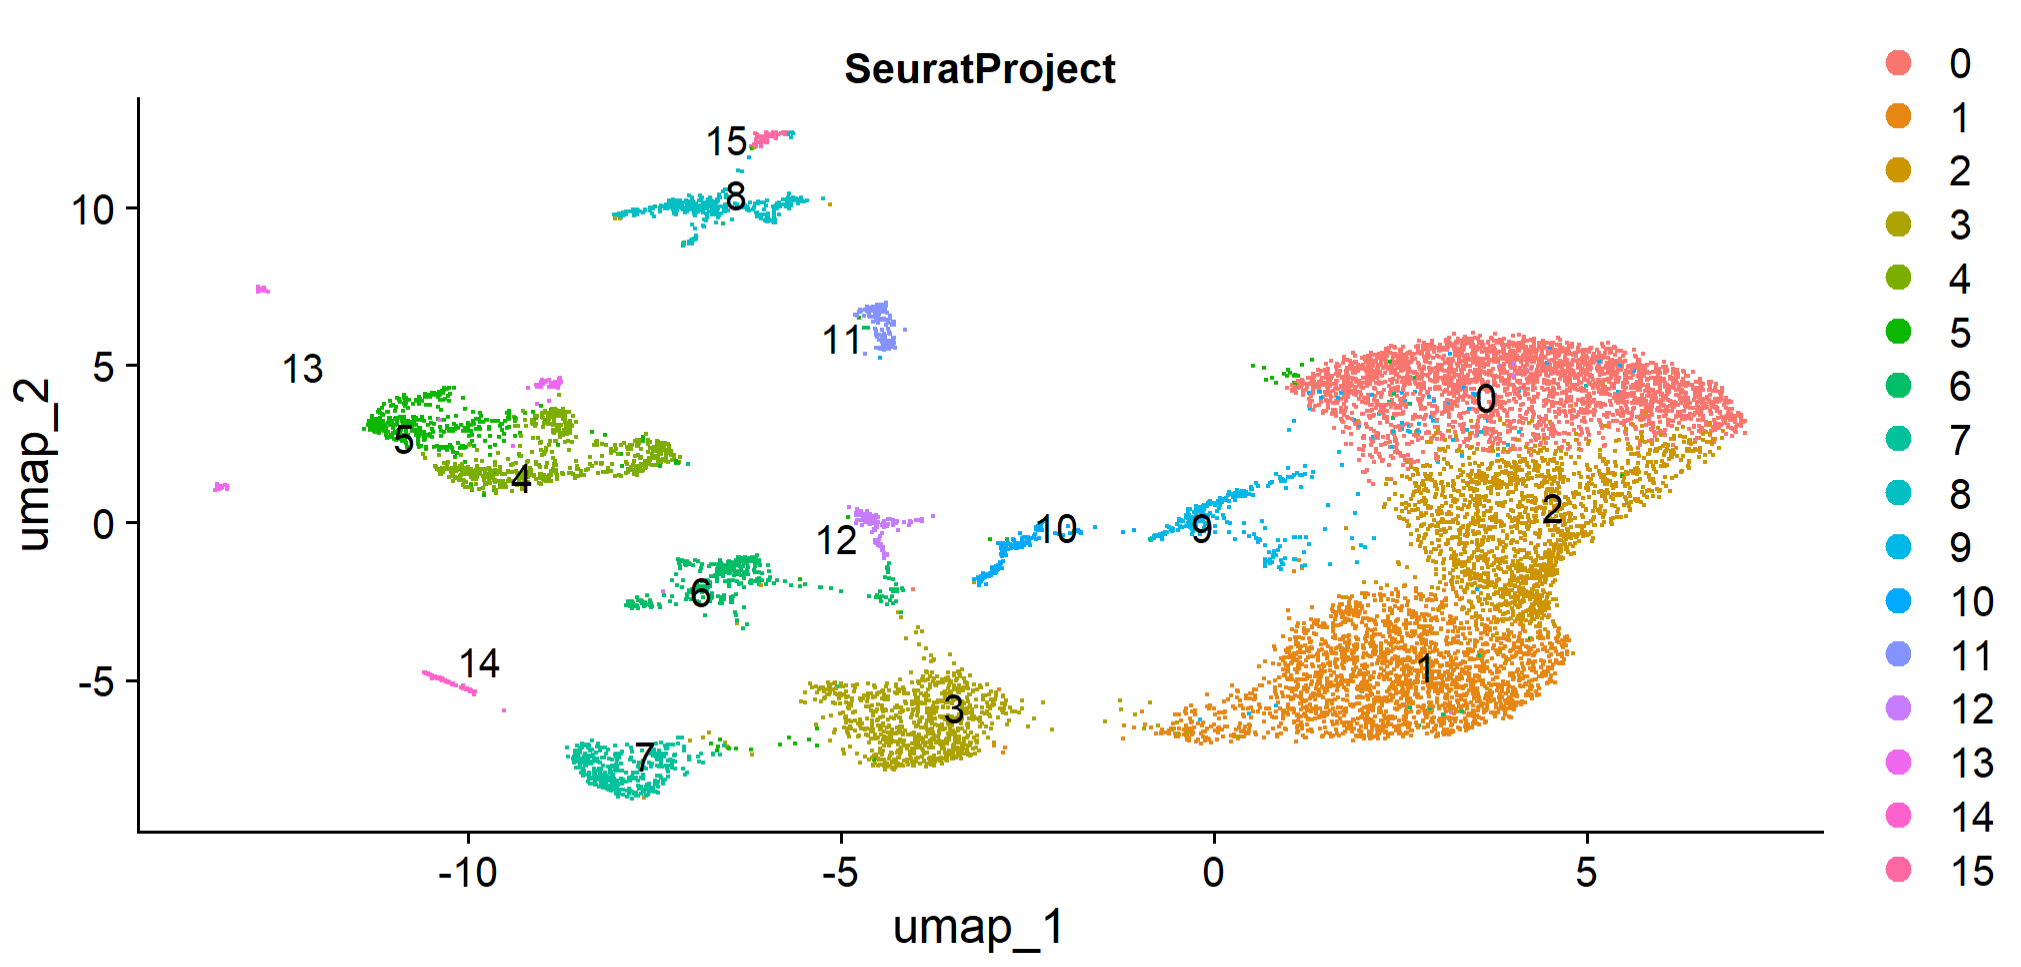

In [ ]:
##################### TEXE2（尝试合并三个）####################
M.GAS$orig.ident <- "M.GAS"
M.Sol$orig.ident <- "M.Sol"
M.TA$orig.ident <- "M.TA"

M.list=list(M.GAS,M.Sol,M.TA)

M.list <- lapply(M.list, function(x) {
  x <- JoinLayers(x)
  return(x)
})

M.GAS=JoinLayers(M.GAS)
M.Sol=JoinLayers(M.Sol)
M.TA=JoinLayers(M.TA)

M.GAS <- NormalizeData(M.GAS, normalization.method = "LogNormalize", scale.factor = 10000)
M.Sol <- NormalizeData(M.Sol, normalization.method = "LogNormalize", scale.factor = 10000)
M.TA <- NormalizeData(M.TA, normalization.method = "LogNormalize", scale.factor = 10000)

M.list=list(M.GAS,M.Sol,M.TA)

M.list <- lapply(X = M.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

features.Sc <- SelectIntegrationFeatures(object.list = M.list)
MuScle.Sc.anchors <- FindIntegrationAnchors(object.list = M.list, anchor.features = features.Sc)
M.integrated <- IntegrateData(anchorset = MuScle.Sc.anchors)
DefaultAssay(M.integrated) <- "integrated"

M.integrated <- ScaleData(M.integrated, verbose = FALSE)
M.integrated <- RunPCA(M.integrated, npcs = 30, verbose = FALSE)
M.integrated <- RunUMAP(M.integrated, reduction = "pca", dims = 1:30)
M.integrated <- FindNeighbors(M.integrated, reduction = "pca", dims = 1:30)
M.integrated <- FindClusters(M.integrated, resolution = 0.3)
DimPlot(M.integrated, reduction = "umap", group.by = "orig.ident", pt.size=0.5)

三组数据测试成功！
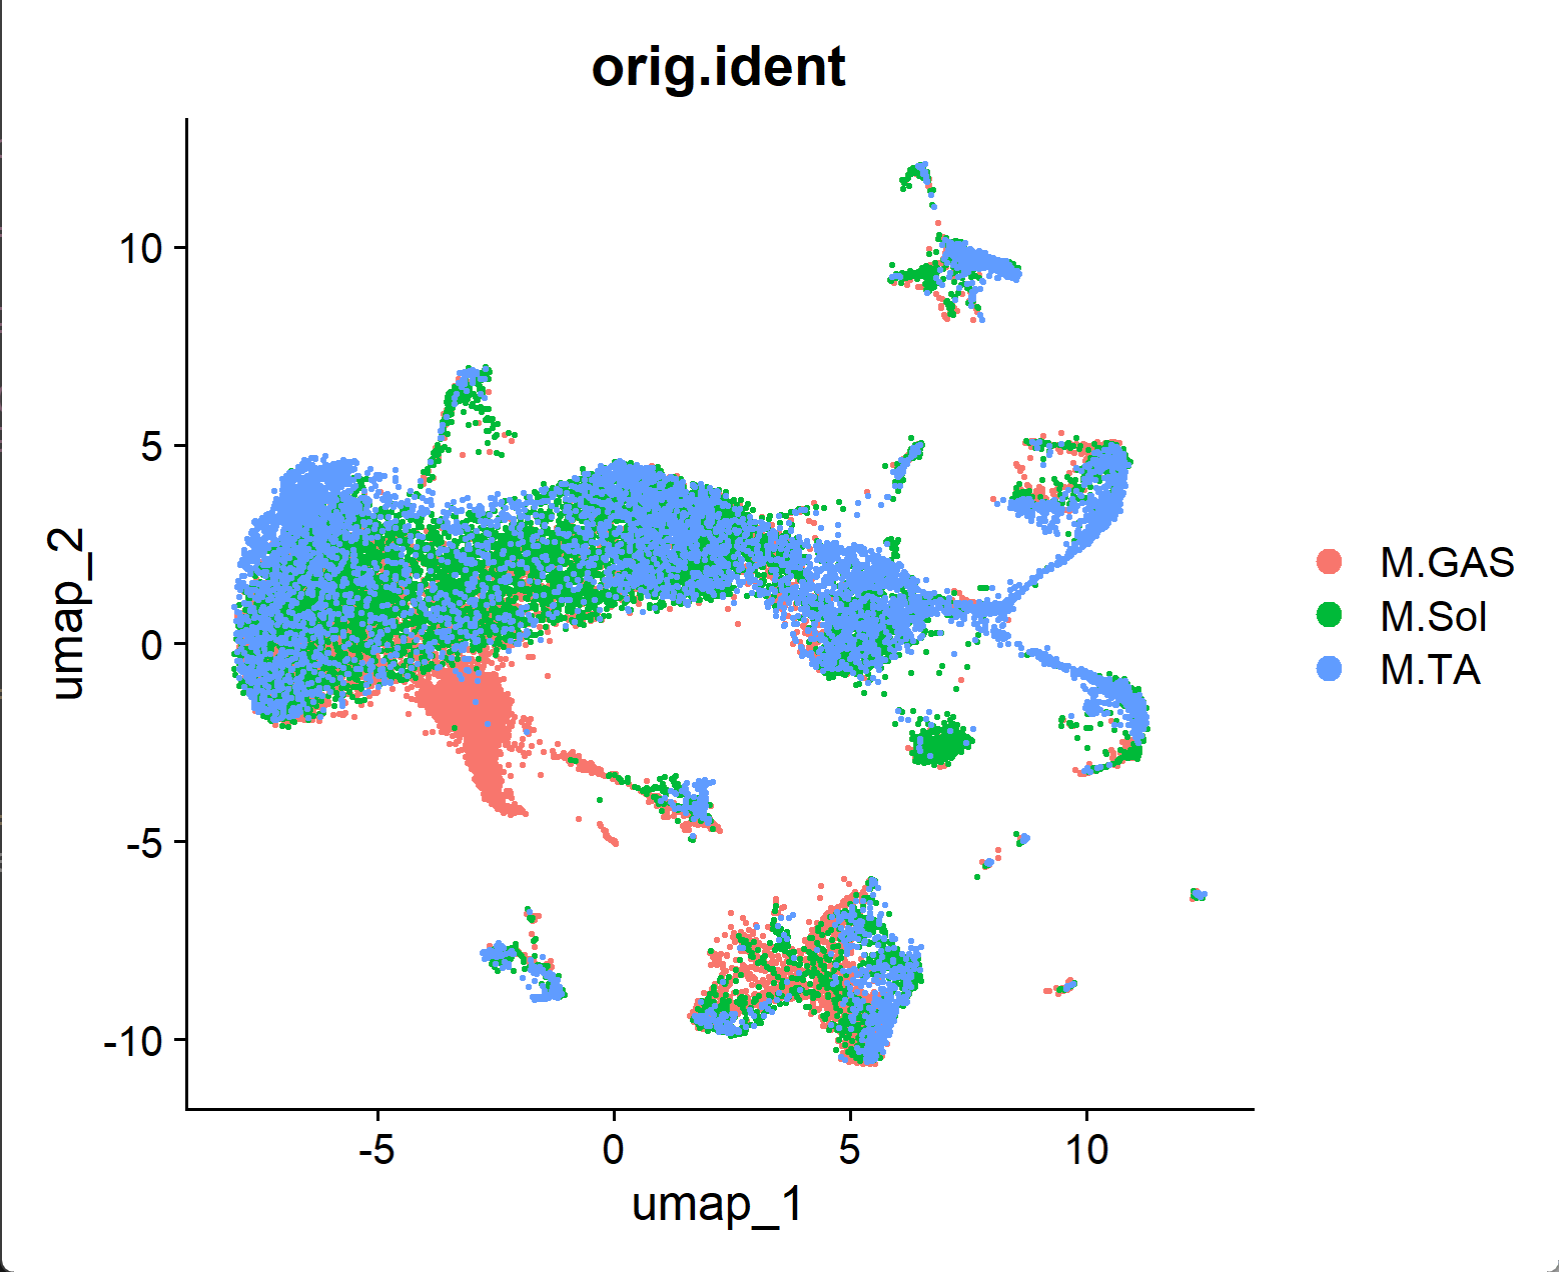

In [ ]:
#Mice.TA
ta_path <- "Z:/A/ST/Analysis/Results8/Mouse/TA"
ta_data <- Read10X(data.dir = ta_path)
seurat_ta <- CreateSeuratObject(counts = ta_data, project = "Mice_TA")
saveRDS(seurat_ta, file = "Mice.TA.rds")

In [ ]:
#Human.GAS
gas1_path <- "Z:/A/ST/Analysis/Results8/Human/GAS/GSM7438490_nonPAD1"

gas1_data <- Read10X(data.dir = gas1_path)

seurat_gas1 <- CreateSeuratObject(counts = gas1_data)

saveRDS(seurat_gas1, file = "H.GAS.rds")

In [ ]:
#Human.GM
#P27,2955 
#P29,1619
#P3, 

gm_paths <- list(
  "Z:/A/ST/Analysis/Results8/Human/GM/P3_GM_snRNA_seq_1",
  "Z:/A/ST/Analysis/Results8/Human/GM/P3_GM_snRNA_seq_2"
)

read_10x_uncompressed <- function(path) {
  matrix <- readMM(file.path(path, "matrix.mtx"))
  barcodes <- read.delim(file.path(path, "barcodes.tsv"), header = FALSE, stringsAsFactors = FALSE)
  features <- read.delim(file.path(path, "features.tsv"), header = FALSE, stringsAsFactors = FALSE)
  
  rownames(matrix) <- features$V2  # 基因名称列
  colnames(matrix) <- barcodes$V1  # 细胞条形码
  return(matrix)
}

# 读取所有数据集
seurat_list <- lapply(gm_paths, function(path) {
  data_matrix <- read_10x_uncompressed(path)
  seurat_obj <- CreateSeuratObject(counts = data_matrix, project = basename(path))
  return(seurat_obj)
})

# 合并所有 Seurat 对象
H.GM <- Reduce(function(x, y) merge(x, y), seurat_list)

# 保存为 .rds 文件
saveRDS(H.GM, file = "H.GM.rds")

In [ ]:
#Human.TA

gm_paths <- list(
  "Z:/A/ST/Analysis/Results8/Human/TA/P5_TA_snRNA_seq_2"
)

read_10x_uncompressed <- function(path) {
  matrix <- readMM(file.path(path, "matrix.mtx"))
  barcodes <- read.delim(file.path(path, "barcodes.tsv"), header = FALSE, stringsAsFactors = FALSE)
  features <- read.delim(file.path(path, "features.tsv"), header = FALSE, stringsAsFactors = FALSE)
  
  rownames(matrix) <- features$V2  # 基因名称列
  colnames(matrix) <- barcodes$V1  # 细胞条形码
  return(matrix)
}

# 读取所有数据集
seurat_list <- lapply(gm_paths, function(path) {
  data_matrix <- read_10x_uncompressed(path)
  seurat_obj <- CreateSeuratObject(counts = data_matrix, project = basename(path))
  return(seurat_obj)
})

# 合并所有 Seurat 对象
H.TA <- Reduce(function(x, y) merge(x, y), seurat_list)

# 保存为 .rds 文件
saveRDS(H.GM, file = "H.TA.rds")


In [ ]:
#Human.VL

# 读取第一个文件
vl1_file <- "Z:/A/ST/Analysis/Results8/Human/VL/GSM5098743_HM7_filtered_feature_bc_matrix.h5"
vl1_data <- Read10X_h5(vl1_file)

# 创建 Seurat 对象
vl1_seurat <- CreateSeuratObject(counts = vl1_data, project = "HM7")

# 读取第二个文件
vl2_file <- "Z:/A/ST/Analysis/Results8/Human/VL/GSM5098748_HM12_filtered_feature_bc_matrix.h5"
vl2_data <- Read10X_h5(vl2_file)

# 创建第二个 Seurat 对象
vl2_seurat <- CreateSeuratObject(counts = vl2_data, project = "HM12")

# 合并两个 Seurat 对象
combined_vl <- merge(vl1_seurat, y = vl2_seurat, add.cell.ids = c("HM7", "HM12"))

# 保存为 H.VL.rds
saveRDS(combined_vl, file = "H.VL.rds")

In [ ]:
############################# TEXT3 尝试重新测试合并人的四组数据 ##################

H.GAS <- UpdateSeuratObject(H.GAS)
H.GM <- UpdateSeuratObject(H.GM)
H.TA <- UpdateSeuratObject(H.TA)
H.VL <- UpdateSeuratObject(H.VL)

H.GAS[["RNA"]] <- as(H.GAS[["RNA"]], "Assay5")
H.GM[["RNA"]] <- as(H.GM[["RNA"]], "Assay5")
H.TA[["RNA"]] <- as(H.TA[["RNA"]], "Assay5")
H.VL[["RNA"]] <- as(H.VL[["RNA"]], "Assay5")

H.GM <- JoinLayers(H.GM)
H.TA <- JoinLayers(H.TA)
H.VL <- JoinLayers(H.VL)
H.GAS <- JoinLayers(H.GAS)

H.GAS <- RenameCells(H.GAS, add.cell.id = "GAS")
H.GM <- RenameCells(H.GM, add.cell.id = "GM")
H.TA <- RenameCells(H.TA, add.cell.id = "TA")
H.VL <- RenameCells(H.VL, add.cell.id = "VL")

H.GAS$orig.ident <- "H.GAS"
H.GM$orig.ident <- "H.GM"
H.TA$orig.ident <- "H.TA"
H.VL$orig.ident <- "H.VL"

H.list <- list(H.GAS, H.GM, H.TA, H.VL)
H.list <- lapply(H.list, function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  return(x)
})

# 选择用于整合的特征
features <- SelectIntegrationFeatures(object.list = H.list)
anchors <- FindIntegrationAnchors(object.list = H.list, anchor.features = features)

H.integrated <- IntegrateData(anchorset = anchors)

# 设置默认 assay 为 "integrated"
DefaultAssay(H.integrated) <- "integrated"

# 标准的下游分析流程
H.integrated <- ScaleData(H.integrated, verbose = FALSE)
H.integrated <- RunPCA(H.integrated, npcs = 30, verbose = FALSE)
H.integrated <- RunUMAP(H.integrated, reduction = "pca", dims = 1:30)
H.integrated <- FindNeighbors(H.integrated, reduction = "pca", dims = 1:30)
H.integrated <- FindClusters(H.integrated, resolution = 0.3)


DimPlot(H.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.5)

人类数据测试成功!!
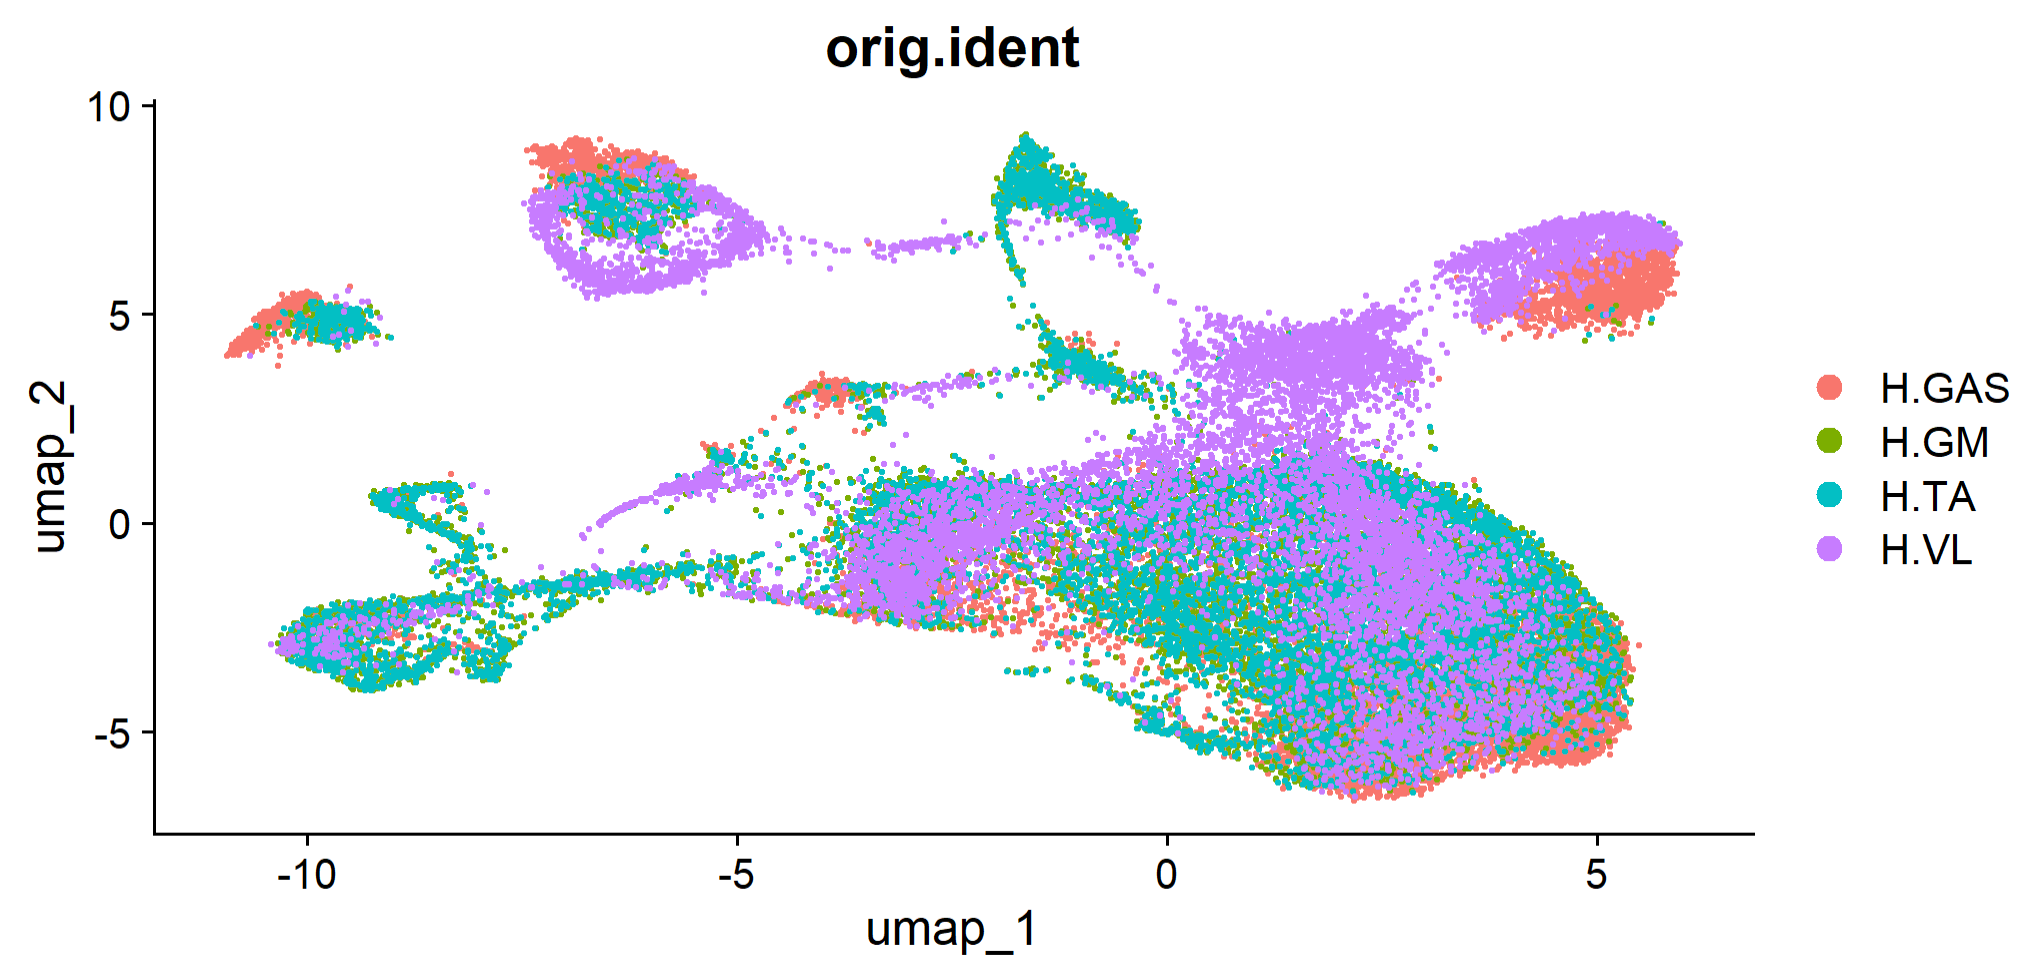

In [ ]:
#Pig
library(Seurat)
library(Matrix)

Sol_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_SOL\\outs\\filtered_feature_bc_matrix")
EDL_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_EDL\\outs\\filtered_feature_bc_matrix")
LD_Sc <- Read10X(data.dir = "Z:\\A\\ST\\Analysis\\SnRNAseq\\run_count_LD\\outs\\filtered_feature_bc_matrix")

P.Sol <- CreateSeuratObject(counts = Sol_Sc, project = "Sol", min.cells = 3, min.features = 200)
P.EDL <- CreateSeuratObject(counts = EDL_Sc, project = "EDL", min.cells = 3, min.features = 200)
P.LD <- CreateSeuratObject(counts = LD_Sc, project = "LD", min.cells = 3, min.features = 200)

saveRDS(P.Sol, file = "P.Sol.rds")
saveRDS(P.EDL, file = "P.EDL.rds")
saveRDS(P.LD, file = "P.LD.rds")

In [ ]:
##################### TEXT4 尝试测试合并人和猪的七组数据 ######################################
library(Seurat)
library(Matrix)
setwd("Z:\\A\\ST\\Analysis\\Results8")


##human
H.GAS <- UpdateSeuratObject(H.GAS)
H.GM <- UpdateSeuratObject(H.GM)
H.TA <- UpdateSeuratObject(H.TA)
H.VL <- UpdateSeuratObject(H.VL)

H.GAS[["RNA"]] <- as(H.GAS[["RNA"]], "Assay5")
H.GM[["RNA"]] <- as(H.GM[["RNA"]], "Assay5")
H.TA[["RNA"]] <- as(H.TA[["RNA"]], "Assay5")
H.VL[["RNA"]] <- as(H.VL[["RNA"]], "Assay5")

H.GM <- JoinLayers(H.GM)
H.TA <- JoinLayers(H.TA)
H.VL <- JoinLayers(H.VL)
H.GAS <- JoinLayers(H.GAS)

H.GAS <- RenameCells(H.GAS, add.cell.id = "H.GAS")
H.GM <- RenameCells(H.GM, add.cell.id = "H.GM")
H.TA <- RenameCells(H.TA, add.cell.id = "H.TA")
H.VL <- RenameCells(H.VL, add.cell.id = "H.VL")

H.GAS$orig.ident <- "H.GAS"
H.GM$orig.ident <- "H.GM"
H.TA$orig.ident <- "H.TA"
H.VL$orig.ident <- "H.VL"


##Pig
P.Sol <- UpdateSeuratObject(P.Sol)
P.EDL <- UpdateSeuratObject(P.EDL)
P.LD <- UpdateSeuratObject(P.LD)

P.Sol[["RNA"]] <- as(P.Sol[["RNA"]], "Assay5")
P.EDL[["RNA"]] <- as(P.EDL[["RNA"]], "Assay5")
P.LD[["RNA"]] <- as(P.LD[["RNA"]], "Assay5")

P.Sol <- JoinLayers(P.Sol)
P.EDL <- JoinLayers(P.EDL)
P.LD <- JoinLayers(P.LD)

P.Sol <- RenameCells(P.Sol, add.cell.id = "P.Sol")
P.EDL <- RenameCells(P.EDL, add.cell.id = "P.EDL")
P.LD <- RenameCells(P.LD, add.cell.id = "P.LD")

P.Sol$orig.ident <- "P.Sol"
P.EDL$orig.ident <- "P.EDL"
P.LD$orig.ident <- "P.LD"

H.list <- list(H.GAS, H.GM, H.TA, H.VL, P.Sol, P.EDL, P.LD)
H.list <- lapply(H.list, function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  return(x)
})

# 选择用于整合的特征
features <- SelectIntegrationFeatures(object.list = H.list)
anchors <- FindIntegrationAnchors(object.list = H.list, anchor.features = features)

H.integrated <- IntegrateData(anchorset = anchors)

# 设置默认 assay 为 "integrated"
DefaultAssay(H.integrated) <- "integrated"

# 标准的下游分析流程
H.integrated <- ScaleData(H.integrated, verbose = FALSE)
H.integrated <- RunPCA(H.integrated, npcs = 30, verbose = FALSE)
H.integrated <- RunUMAP(H.integrated, reduction = "pca", dims = 1:30)
H.integrated <- FindNeighbors(H.integrated, reduction = "pca", dims = 1:30)
H.integrated <- FindClusters(H.integrated, resolution = 0.3)


DimPlot(H.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.5)

人和猪数据的合并是没有问题的
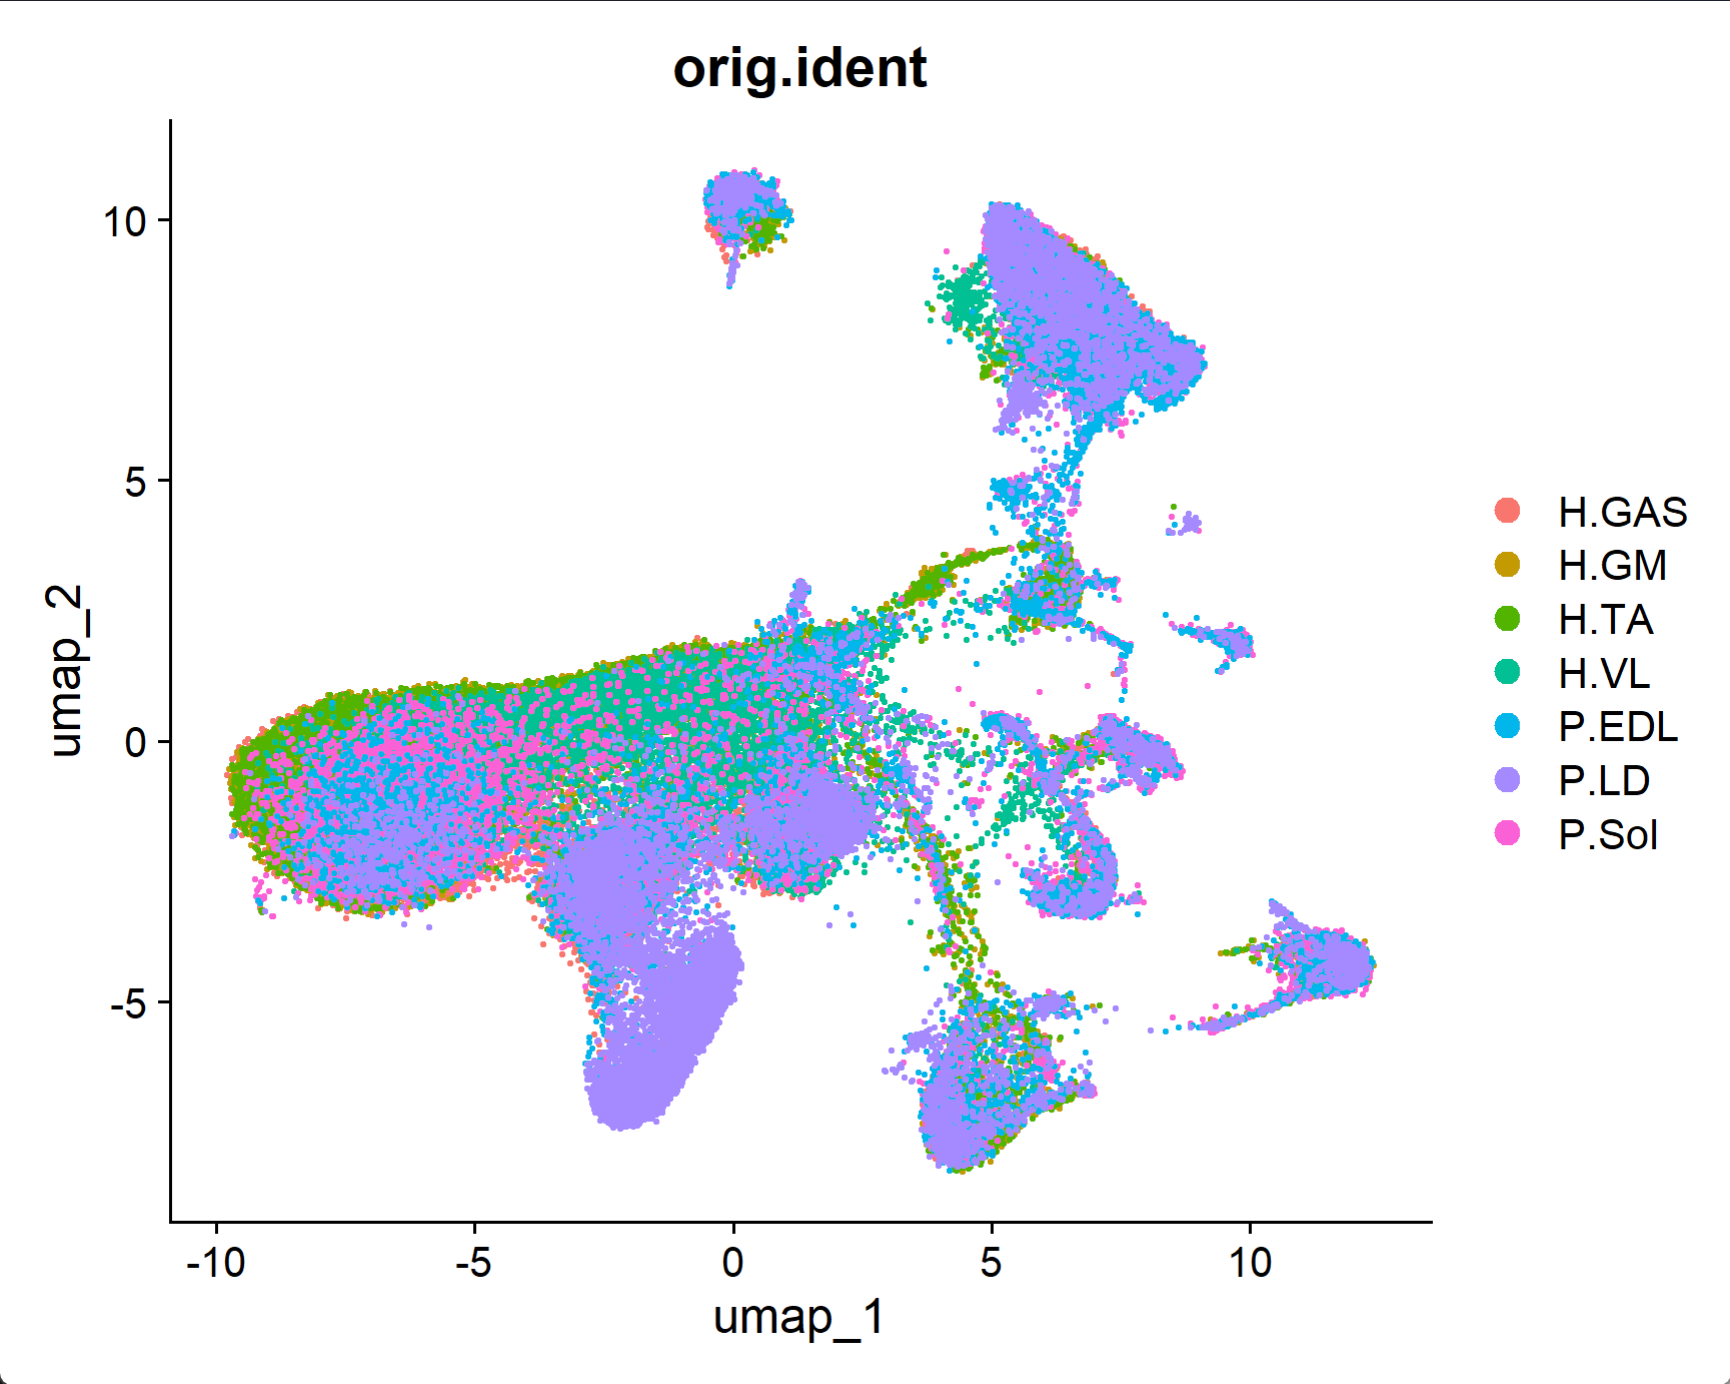

In [ ]:
#正式分析，融合人鼠猪三类数据，共计11万细胞
setwd("Z:\\A\\ST\\Analysis\\Results8")

#全转化为V5对象

##human
H.GAS <- UpdateSeuratObject(H.GAS)
H.GM <- UpdateSeuratObject(H.GM)
H.TA <- UpdateSeuratObject(H.TA)
H.VL <- UpdateSeuratObject(H.VL)

H.GAS[["RNA"]] <- as(H.GAS[["RNA"]], "Assay5")
H.GM[["RNA"]] <- as(H.GM[["RNA"]], "Assay5")
H.TA[["RNA"]] <- as(H.TA[["RNA"]], "Assay5")
H.VL[["RNA"]] <- as(H.VL[["RNA"]], "Assay5")

H.GM <- JoinLayers(H.GM)
H.TA <- JoinLayers(H.TA)
H.VL <- JoinLayers(H.VL)
H.GAS <- JoinLayers(H.GAS)

H.GAS <- RenameCells(H.GAS, add.cell.id = "H.GAS")
H.GM <- RenameCells(H.GM, add.cell.id = "H.GM")
H.TA <- RenameCells(H.TA, add.cell.id = "H.TA")
H.VL <- RenameCells(H.VL, add.cell.id = "H.VL")

H.GAS$orig.ident <- "H.GAS"
H.GM$orig.ident <- "H.GM"
H.TA$orig.ident <- "H.TA"
H.VL$orig.ident <- "H.VL"


##Pig
P.Sol <- UpdateSeuratObject(P.Sol)
P.EDL <- UpdateSeuratObject(P.EDL)
P.LD <- UpdateSeuratObject(P.LD)

P.Sol[["RNA"]] <- as(P.Sol[["RNA"]], "Assay5")
P.EDL[["RNA"]] <- as(P.EDL[["RNA"]], "Assay5")
P.LD[["RNA"]] <- as(P.LD[["RNA"]], "Assay5")

P.Sol <- JoinLayers(P.Sol)
P.EDL <- JoinLayers(P.EDL)
P.LD <- JoinLayers(P.LD)

P.Sol <- RenameCells(P.Sol, add.cell.id = "P.Sol")
P.EDL <- RenameCells(P.EDL, add.cell.id = "P.EDL")
P.LD <- RenameCells(P.LD, add.cell.id = "P.LD")

P.Sol$orig.ident <- "P.Sol"
P.EDL$orig.ident <- "P.EDL"
P.LD$orig.ident <- "P.LD"

##Mice
M.GAS <- UpdateSeuratObject(M.GAS)
M.TA <- UpdateSeuratObject(M.TA)
M.Sol <- UpdateSeuratObject(M.Sol)

M.GAS[["RNA"]] <- as(M.GAS[["RNA"]], "Assay5")
M.TA[["RNA"]] <- as(M.TA[["RNA"]], "Assay5")
M.Sol[["RNA"]] <- as(M.Sol[["RNA"]], "Assay5")

M.GAS <- JoinLayers(M.GAS)
M.TA <- JoinLayers(M.TA)
M.Sol <- JoinLayers(M.Sol)

M.GAS <- RenameCells(M.GAS, add.cell.id = "M.GAS")
M.TA <- RenameCells(M.TA, add.cell.id = "M.TA")
M.Sol <- RenameCells(M.Sol, add.cell.id = "M.Sol")

M.GAS$orig.ident <- "M.GAS"
M.TA$orig.ident <- "M.TA"
M.Sol$orig.ident <- "M.Sol"

#基因ID转换
convert_gene_names_to_uppercase <- function(seurat_obj) {
  features <- rownames(seurat_obj)
  features_upper <- toupper(features)
  features_upper_unique <- make.unique(features_upper) #确保转化后基因Name独一无二
  rownames(seurat_obj) <- features_upper_unique
  return(seurat_obj)
}

M.GAS <- convert_gene_names_to_uppercase(M.GAS)
M.TA <- convert_gene_names_to_uppercase(M.TA)
M.Sol <- convert_gene_names_to_uppercase(M.Sol)

In [ ]:
All.list <- list(H.GAS, H.GM, H.TA, H.VL, P.Sol, P.EDL, P.LD, M.GAS, M.TA, M.Sol)
All.list <- lapply(All.list, function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  return(x)
})

# 选择用于整合的特征
features <- SelectIntegrationFeatures(object.list = All.list)
anchors <- FindIntegrationAnchors(object.list = All.list, anchor.features = features)
All.integrated <- IntegrateData(anchorset = anchors)

# 设置默认 assay 为 "integrated"
DefaultAssay(All.integrated) <- "integrated"

# 标准的下游分析流程
All.integrated <- ScaleData(All.integrated, verbose = FALSE)
All.integrated <- RunPCA(All.integrated, npcs = 30, verbose = FALSE)
All.integrated <- RunUMAP(All.integrated, reduction = "pca", dims = 1:30)
All.integrated <- FindNeighbors(All.integrated, reduction = "pca", dims = 1:30)
All.integrated <- FindClusters(All.integrated, resolution = 0.3)
DimPlot(All.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.5)
saveRDS(All.integrated,"All.integrated.rds")

In [ ]:
P1=DimPlot(All.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.5,cols=c("#DB7BAE","#EB6B84","#EA896F","#E95050","#93C867","#54B339","#8FCBA0","#5F489B","#5155A3","#206EB0"),raster=FALSE)

In [ ]:
##Maping
refer <- UpdateSeuratObject(refer)
#refer[["RNA"]] <- as(refer[["RNA"]], "Assay5")
#refer <- JoinLayers(refer) 这两步是非必要的

In [ ]:
All.integrated <- readRDS("Z:/A/ST/Analysis/Results8/All.integrated.rds")
DefaultAssay(All.integrated) <- "integrated"

anchors <- FindTransferAnchors(
  reference = refer,
  query = All.integrated,
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:30
)

predictions  <- TransferData(
  anchorset = anchors,
  refdata = refer@active.ident,
  dims = 1:30
)

All.integrated$predicted.id <- predictions$predicted.id
Idents(All.integrated) <- "predicted.id"

DimPlot(All.integrated, group.by = "predicted.id", label = TRUE, raster=FALSE, repel = TRUE) + NoLegend()


In [ ]:

library(RColorBrewer)

custom_colors <- brewer.pal(n = 12, name = "Set3") # "Paired" 是基础配色方案
custom_colors <- colorRampPalette(custom_colors)(30)

# 使用自定义颜色绘制图形
DimPlot(All.integrated, group.by = "predicted.id", label = TRUE, raster = FALSE, cols=custom_colors,repel = TRUE) + 
  NoLegend()



In [ ]:
# 生成 30 个完全随机的颜色
set.seed(5201314) # 设置随机种子，确保结果可复现
custom_colors <- rgb(runif(30), runif(30), runif(30))
P2=DimPlot(All.integrated,cols=custom_colors,raster = FALSE)
DimPlot(All.integrated,cols=custom_colors,split.by = "predicted.id")

DimPlot(All.integrated, group.by = "predicted.id", label = TRUE, raster = FALSE, cols=custom_colors,repel = TRUE) + 
  NoLegend()


In [ ]:
DimPlot(All.integrated,cols=custom_colors)

In [ ]:
P3=DimPlot(All.integrated,cols=custom_colors,split.by="orig.ident", raster = FALSE)

In [ ]:
##############树形聚类图#######################
# 确保已经加载必要的包
library(Seurat)
library(ggplot2)
library(dendextend)
# 获取每个 origin.ident 样本的平均表达量
Idents(All.integrated) <- "orig.ident"
average_expression <- AverageExpression(All.integrated, assays = "RNA", slot = "data")
# 检查 average_expression$RNA 的结构
str(average_expression$RNA)
# 将 dgCMatrix 转换为普通矩阵
expr_matrix <- as.matrix(average_expression$RNA)
# 计算相关性矩阵
cor_matrix <- cor(expr_matrix)
# 对相关性矩阵进行层次聚类
dendrogram <- as.dendrogram(hclust(as.dist(1 - cor_matrix)))
# 绘制树状聚类图
P4=plot(dendrogram, main = "Hierarchical Clustering of origin.ident Correlation", xlab = "origin.ident", ylab = "1 - Correlation")

In [ ]:
##############PCA聚类#######################
library(plotly)
Idents(All.integrated) <- "orig.ident"
average_expression <- AverageExpression(All.integrated, assays = "RNA", slot = "data")
expr_matrix <- as.matrix(average_expression$RNA)
pca_result <- prcomp(t(expr_matrix), scale. = TRUE)
pca_data <- data.frame(pca_result$x[, 1:3], Group = colnames(expr_matrix))
colnames(pca_data)[1:3] <- c("PC1", "PC2", "PC3")
custom_colors <- c("#DB7BAE", "#EB6B84", "#EA896F", "#E95050", "#93C867", "#54B339", "#8FCBA0", "#5F489B", "#5155A3", "#206EB0")
fig <- plot_ly(pca_data, x = ~PC1, y = ~PC2, z = ~PC3, color = ~Group, text = ~Group, type = 'scatter3d', mode = 'markers',
               colors = custom_colors) %>%
  layout(
    title = "3D PCA Clustering of origin.ident",
    scene = list(
      xaxis = list(title = "Principal Component 1"),
      yaxis = list(title = "Principal Component 2"),
      zaxis = list(title = "Principal Component 3")
    )
  )
fig

In [ ]:
##############堆叠柱状图，所有物种，但是猪不正确#######################
Idents(All.integrated) <- "celltype"
cell_counts <- table(All.integrated$orig.ident, Idents(All.integrated))
cell_counts_df <- as.data.frame(cell_counts)
colnames(cell_counts_df) <- c("orig.ident", "celltype", "count")
cell_counts_df <- cell_counts_df %>%
  group_by(orig.ident) %>%
  mutate(total_count = sum(count), percentage = (count / total_count) * 100)

custom_colors <- c("#913B4A", "#571143", "#E7E025", "#3769CE", "#F85E0B", "#5C5C6D", "#0C3406", "#0730BB",
                   "#3C36D2", "#87AE88", "#D08A41", "#C19A56", "#A0A4B3", "#0BA61D", "#5695BC", "#86B03D",
                   "#064787", "#149D14", "#9A6741", "#2C7435", "#B2733A", "#E1F4D4", "#795A56", "#FCDB91",
                   "#C19615", "#329CAB", "#ABB3AB", "#621E9C", "#8063B7", "#7D659C")

ggplot(cell_counts_df, aes(x = orig.ident, y = percentage, fill = celltype)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = custom_colors) +
  theme_minimal() +
  labs(title = "Percentage of Cell Types in Each orig.ident",
       x = "orig.ident",
       y = "Percentage",
       fill = "Cell Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
VlnPlot(refer, split.by="orig.ident" features = "PTX3",pt.size=0,ncol = 3)

In [ ]:
##############堆叠柱状图，仅限于猪这一个物种#######################
Idents(All.integrated) <- "celltype"
cell_counts <- table(All.integrated$orig.ident, Idents(All.integrated))
cell_counts_df <- as.data.frame(cell_counts)
colnames(cell_counts_df) <- c("orig.ident", "celltype", "count")
cell_counts_df <- cell_counts_df %>%
  group_by(orig.ident) %>%
  mutate(total_count = sum(count), percentage = (count / total_count) * 100)

# 细胞类型顺序
celltype_order <- c("Type 1 myofibers", "Type 1/2a myofibers", "MT-rich FAPs", "MuSCs", "T cell", "MR-FAPs", "VECs", "Type 2x myofibers", "Type 2a/x myofibers", "Type 2a myofibers", "Preadipocytes", "Stem like FAPss", "Macrophage", "Myoblasts", "Monocyte", "Mature Adipocytes", "F3+ FAPs", "B", "Myogenic like FAPs", "Mast cell", "LECs", "Treg cell", "Neurons", "Perimysial cells", "NK2", "DC", "γδ T", "NK1", "Type 2b myofibers", "Type 2x/2b myofibers")
cell_counts_df$celltype <- factor(cell_counts_df$celltype, levels = celltype_order)
custom_colors <- c("#913B4A", "#571143", "#E7E025", "#3769CE", "#F85E0B", "#5C5C6D", "#0C3406", "#0730BB",
                   "#3C36D2", "#87AE88", "#D08A41", "#C19A56", "#A0A4B3", "#0BA61D", "#5695BC", "#86B03D",
                   "#064787", "#149D14", "#9A6741", "#2C7435", "#B2733A", "#E1F4D4", "#795A56", "#FCDB91",
                   "#C19615", "#329CAB", "#ABB3AB", "#621E9C", "#8063B7", "#7D659C")

ggplot(cell_counts_df, aes(x = orig.ident, y = percentage, fill = celltype)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = custom_colors) +
  theme_minimal() +
  labs(title = "Percentage of Cell Types in Each orig.ident",
       x = "orig.ident",
       y = "Percentage",
       fill = "Cell Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
#############  环形数据统计图（猪）  ######################
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggforce)

# Input data
data <- data.frame(
  tissue = c('EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol',
             'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol'),
  celltype = c('Type 2x myofibers', 'Type 2x myofibers', 'Type 2x myofibers', 'Type 2x/2b myofibers',
               'Type 2x/2b myofibers', 'Type 2x/2b myofibers', 'Type 1 myofibers', 'Type 1 myofibers',
               'Type 1 myofibers', 'Type 2b myofibers', 'Type 2b myofibers', 'Type 2b myofibers',
               'Type 1/2a myofibers', 'Type 1/2a myofibers', 'Type 1/2a myofibers', 'Type 2a/x myofibers',
               'Type 2a/x myofibers', 'Type 2a/x myofibers', 'Type 2a myofibers', 'Type 2a myofibers',
               'Type 2a myofibers'),
  count = c(1287, 990, 757, 13, 2869, 2, 62, 0, 2699, 0, 2219, 0, 856, 335, 939, 565, 778, 289, 250, 227, 413)
)

# Calculate percentages
data_percent <- data %>%
  group_by(tissue) %>%
  mutate(percentage = count / sum(count) * 100)

# Add an empty group for each tissue to represent the blank section
data_empty <- data %>%
  group_by(tissue) %>%
  summarise(celltype = 'Empty', count = 0, percentage = 90 / 360 * 100) %>%
  mutate(ymax = 270, ymin = 180)

# Combine data with empty sections
data_combined <- bind_rows(data_percent, data_empty) %>%
  group_by(tissue) %>%
  arrange(tissue, celltype) %>%
  mutate(ymax = cumsum(percentage), ymin = c(0, head(ymax, -1)))

# Plot multi-ring circular chart with each tissue as a separate ring
ggplot() +
  geom_rect(data = data_combined %>% filter(tissue == 'EDL'),
            aes(x = factor(1), ymax = ymax, ymin = ymin, xmax = 1.25, xmin = 1, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'LD'),
            aes(x = factor(1.5), ymax = ymax, ymin = ymin, xmax = 1.75, xmin = 1.5, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'Sol'),
            aes(x = factor(2), ymax = ymax, ymin = ymin, xmax = 2.25, xmin = 2, fill = celltype)) +
  coord_polar(theta = "y", start = -pi) +
  theme_void() +
  scale_fill_manual(values = c('Type 1 myofibers' = '#913B4A',
                               'Type 1/2a myofibers' = '#571143',
                               'Type 2a myofibers' = '#87AE88',
                               'Type 2a/x myofibers' = '#3C36D2',
                               'Type 2x myofibers' = '#0730BB',
                               'Type 2x/2b myofibers' = '#0730BB',
                               'Type 2b myofibers' = '#8063B7',
                               'Empty' = 'white')) +
  ggtitle('Percentage of Each Cell Type in Tissues (EDL, LD, Sol)') +
  theme(legend.position = "bottom") +
  guides(fill = guide_legend(title = "Cell Types"))

In [ ]:
#############  环形数据统计图（人）  ######################
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggforce)

# Input data
data <- data.frame(
  tissue = c('EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol',
             'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol', 'EDL', 'LD', 'Sol'),
  celltype = c('Type 2x myofibers', 'Type 2x myofibers', 'Type 2x myofibers', 'Type 2x/2b myofibers',
               'Type 2x/2b myofibers', 'Type 2x/2b myofibers', 'Type 1 myofibers', 'Type 1 myofibers',
               'Type 1 myofibers', 'Type 2b myofibers', 'Type 2b myofibers', 'Type 2b myofibers',
               'Type 1/2a myofibers', 'Type 1/2a myofibers', 'Type 1/2a myofibers', 'Type 2a/x myofibers',
               'Type 2a/x myofibers', 'Type 2a/x myofibers', 'Type 2a myofibers', 'Type 2a myofibers',
               'Type 2a myofibers'),
  count = c(1287, 990, 757, 13, 2869, 2, 62, 0, 2699, 0, 2219, 0, 856, 335, 939, 565, 778, 289, 250, 227, 413)
)

# Calculate percentages
data_percent <- data %>%
  group_by(tissue) %>%
  mutate(percentage = count / sum(count) * 100)

# Add an empty group for each tissue to represent the blank section
data_empty <- data %>%
  group_by(tissue) %>%
  summarise(celltype = 'Empty', count = 0, percentage = 90 / 360 * 100) %>%
  mutate(ymax = 270, ymin = 180)

# Combine data with empty sections
data_combined <- bind_rows(data_percent, data_empty) %>%
  group_by(tissue) %>%
  arrange(tissue, celltype) %>%
  mutate(ymax = cumsum(percentage), ymin = c(0, head(ymax, -1)))

# Plot multi-ring circular chart with each tissue as a separate ring
ggplot() +
  geom_rect(data = data_combined %>% filter(tissue == 'EDL'),
            aes(x = factor(1), ymax = ymax, ymin = ymin, xmax = 1.25, xmin = 1, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'LD'),
            aes(x = factor(1.5), ymax = ymax, ymin = ymin, xmax = 1.75, xmin = 1.5, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'Sol'),
            aes(x = factor(2), ymax = ymax, ymin = ymin, xmax = 2.25, xmin = 2, fill = celltype)) +
  coord_polar(theta = "y", start = -pi) +
  theme_void() +
  scale_fill_manual(values = c('Type 1 myofibers' = '#913B4A',
                               'Type 1/2a myofibers' = '#571143',
                               'Type 2a myofibers' = '#87AE88',
                               'Type 2a/x myofibers' = '#3C36D2',
                               'Type 2x myofibers' = '#0730BB',
                               'Type 2x/2b myofibers' = '#0730BB',
                               'Type 2b myofibers' = '#8063B7',
                               'Empty' = 'white')) +
  ggtitle('Percentage of Each Cell Type in Tissues (EDL, LD, Sol)') +
  theme(legend.position = "bottom") +
  guides(fill = guide_legend(title = "Cell Types"))


In [ ]:
#############  环形数据统计图（鼠）  ######################


library(ggplot2)
library(dplyr)
library(tidyr)
library(ggforce)

# Input data
data <- data.frame(
  tissue = c('M.GAS', 'M.Sol', 'M.TA', 'M.GAS', 'M.Sol', 'M.TA',
             'M.GAS', 'M.Sol', 'M.TA', 'M.GAS', 'M.Sol', 'M.TA',
             'M.GAS', 'M.Sol', 'M.TA'),
  celltype = c('Type 1 myofibers', 'Type 1 myofibers', 'Type 1 myofibers',
               'Type 1/2a myofibers', 'Type 1/2a myofibers', 'Type 1/2a myofibers',
               'Type 2x myofibers', 'Type 2x myofibers', 'Type 2x myofibers',
               'Type 2a/x myofibers', 'Type 2a/x myofibers', 'Type 2a/x myofibers',
               'Type 2a myofibers', 'Type 2a myofibers', 'Type 2a myofibers'),
  count = c(375, 1583, 680, 1901, 2022, 1562, 3585, 4653, 2484, 70, 28, 113, 767, 327, 279)
)

# Calculate percentages
data_percent <- data %>%
  group_by(tissue) %>%
  mutate(percentage = count / sum(count) * 100)

# Add an empty group for each tissue to represent the blank section
data_empty <- data %>%
  group_by(tissue) %>%
  summarise(celltype = 'Empty', count = 0, percentage = 90 / 360 * 100) %>%
  mutate(ymax = 270, ymin = 180)

# Combine data with empty sections
data_combined <- bind_rows(data_percent, data_empty) %>%
  group_by(tissue) %>%
  arrange(tissue, celltype) %>%
  mutate(ymax = cumsum(percentage), ymin = c(0, head(ymax, -1)))

# Plot multi-ring circular chart with each tissue as a separate ring
ggplot() +
  geom_rect(data = data_combined %>% filter(tissue == 'M.GAS'),
            aes(x = factor(1), ymax = ymax, ymin = ymin, xmax = 1.25, xmin = 1, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'M.Sol'),
            aes(x = factor(1.5), ymax = ymax, ymin = ymin, xmax = 1.75, xmin = 1.5, fill = celltype)) +
  geom_rect(data = data_combined %>% filter(tissue == 'M.TA'),
            aes(x = factor(2), ymax = ymax, ymin = ymin, xmax = 2.25, xmin = 2, fill = celltype)) +
  coord_polar(theta = "y", start = -pi) +
  theme_void() +
  scale_fill_manual(values = c('Type 1 myofibers' = '#913B4A',
                               'Type 1/2a myofibers' = '#571143',
                               'Type 2a myofibers' = '#87AE88',
                               'Type 2a/x myofibers' = '#3C36D2',
                               'Type 2x myofibers' = '#0730BB',
                               'Empty' = 'white')) +
  ggtitle('Percentage of Each Cell Type in Tissues (M.GAS, M.Sol, M.TA)') +
  theme(legend.position = "bottom") +
  guides(fill = guide_legend(title = "Cell Types"))



In [ ]:
#############  山脊图（应该使用RNA矩阵）  ######################

DefaultAssay(All.integrated) <- "RNA"
DefaultAssay(All.integrated) <- "integrated"

library(ggplot2)
library(dplyr)
library(tidyr)
library(ggridges)
library(Seurat)

# Function to visualize gene expression using ridge plot
visualize_gene_expression <- function(seurat_object, gene_id) {
  # Extract gene expression data from Seurat object
  gene_data <- FetchData(seurat_object, vars = c(gene_id), assay = "RNA")

  # Extract orig.ident information from metadata
  tissue_data <- seurat_object@meta.data %>% select(orig.ident) %>% rename(tissue = orig.ident)

  # Combine gene expression data with tissue information
  combined_df <- gene_data %>%
    tibble::rownames_to_column(var = "cell") %>%
    left_join(tissue_data %>% tibble::rownames_to_column(var = "cell"), by = "cell")

  # Visualize gene expression using ridge plot without distinguishing cell types
  ggplot(combined_df, aes(x = !!sym(gene_id), y = tissue, fill = tissue)) +
    geom_density_ridges(alpha = 0.7, scale = 1.2, rel_min_height = 0.01) +
    theme_ridges() +
    theme(legend.position = "none",
          axis.text.y = element_text(size = 8)) +
    labs(title = paste(gene_id, "Gene Expression Across Tissues"),
         x = paste(gene_id, "Expression"),
         y = "Tissue")
}

# Example usage
visualize_gene_expression(All.integrated, "SLC27A1")

In [ ]:
#############  小提琴图（应该使用RNA矩阵）  ######################
#由于山脊图差异不明显，因此使用
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggridges)
library(Seurat)



# Function to visualize gene expression using violin plot
visualize_gene_expression <- function(seurat_object, gene_id) {
  # Extract gene expression data from Seurat object
  gene_data <- FetchData(seurat_object, vars = c(gene_id), assay = "RNA", slot = "data")

  # Extract orig.ident information from metadata
  tissue_data <- seurat_object@meta.data %>% select(orig.ident) %>% rename(tissue = orig.ident)

  # Combine gene expression data with tissue information
  combined_df <- gene_data %>%
    tibble::rownames_to_column(var = "cell") %>%
    left_join(tissue_data %>% tibble::rownames_to_column(var = "cell"), by = "cell")

  # Visualize gene expression using violin plot without distinguishing cell types
  ggplot(combined_df, aes(x = tissue, y = .data[[gene_id]], fill = tissue)) +
    geom_violin(alpha = 0.7, scale = "width", trim = TRUE) +
    theme_minimal() +
    theme(legend.position = "none",
          axis.text.x = element_text(size = 8)) +
    labs(title = paste(gene_id, "Gene Expression Across Tissues"),
         x = "Tissue",
         y = paste(gene_id, "Expression"))
}

# Example usage
visualize_gene_expression(All.integrated, "MYH7")

In [ ]:
FeaturePlot(All.integrated, features = c("CTP1A"), cols = c("#b6b6b6", "red"))


#### GNG

In [ ]:
#正式分析，融合人鼠猪三类数据，共计11万细胞
setwd("Z:\\A\\ST\\Analysis\\Results8\\GNG")
#全转化为V5对象
##human
H.GAS <- UpdateSeuratObject(H.GAS)
H.TA <- UpdateSeuratObject(H.TA)
H.VL <- UpdateSeuratObject(H.VL)

H.GAS[["RNA"]] <- as(H.GAS[["RNA"]], "Assay5")
H.TA[["RNA"]] <- as(H.TA[["RNA"]], "Assay5")
H.VL[["RNA"]] <- as(H.VL[["RNA"]], "Assay5")

H.TA <- JoinLayers(H.TA)
H.VL <- JoinLayers(H.VL)
H.GAS <- JoinLayers(H.GAS)

H.GAS <- RenameCells(H.GAS, add.cell.id = "H.GAS")
H.TA <- RenameCells(H.TA, add.cell.id = "H.TA")
H.VL <- RenameCells(H.VL, add.cell.id = "H.VL")

H.GAS$orig.ident <- "H.GAS"
H.TA$orig.ident <- "H.TA"
H.VL$orig.ident <- "H.VL"

All.list <- list(H.GAS, H.TA, H.VL)
All.list <- lapply(All.list, function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
  return(x)
})

# 选择用于整合的特征
features <- SelectIntegrationFeatures(object.list = All.list)
anchors <- FindIntegrationAnchors(object.list = All.list, anchor.features = features)
All.integrated <- IntegrateData(anchorset = anchors)

# 设置默认 assay 为 "integrated"
DefaultAssay(All.integrated) <- "integrated"

# 标准的下游分析流程
All.integrated <- ScaleData(All.integrated, verbose = FALSE)
All.integrated <- RunPCA(All.integrated, npcs = 30, verbose = FALSE)
All.integrated <- RunUMAP(All.integrated, reduction = "pca", dims = 1:30)
All.integrated <- FindNeighbors(All.integrated, reduction = "pca", dims = 1:30)
All.integrated <- FindClusters(All.integrated, resolution = 0.3)
DimPlot(All.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.5)

pbmc.markers <- FindAllMarkers(pbmc3k, only.pos = FALSE,
                               min.pct = 0.25,
                               logfc.threshold = 0)

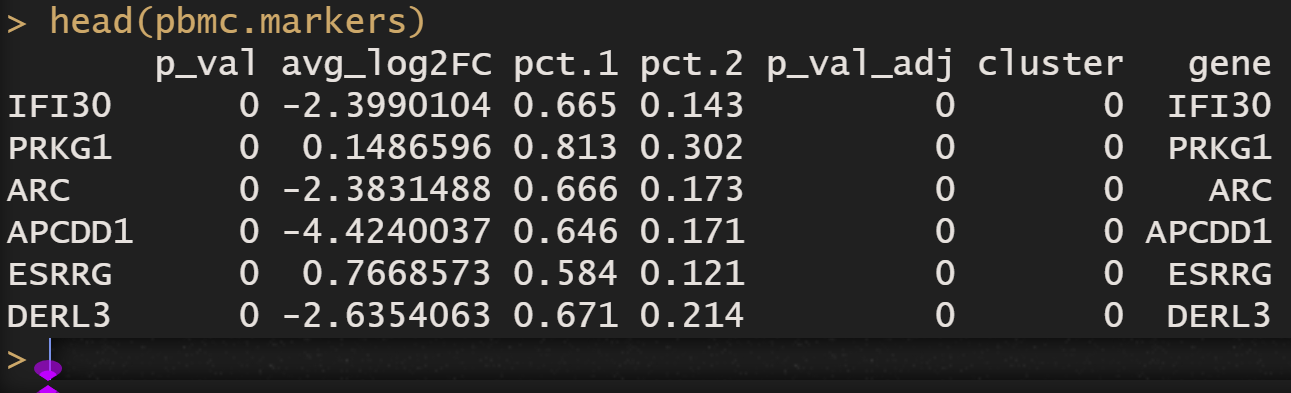

In [ ]:
markerVolcano(
    markers = pbmc.markers,
    topn = 5,
    labelCol = ggsci::pal_npg()(12)
)

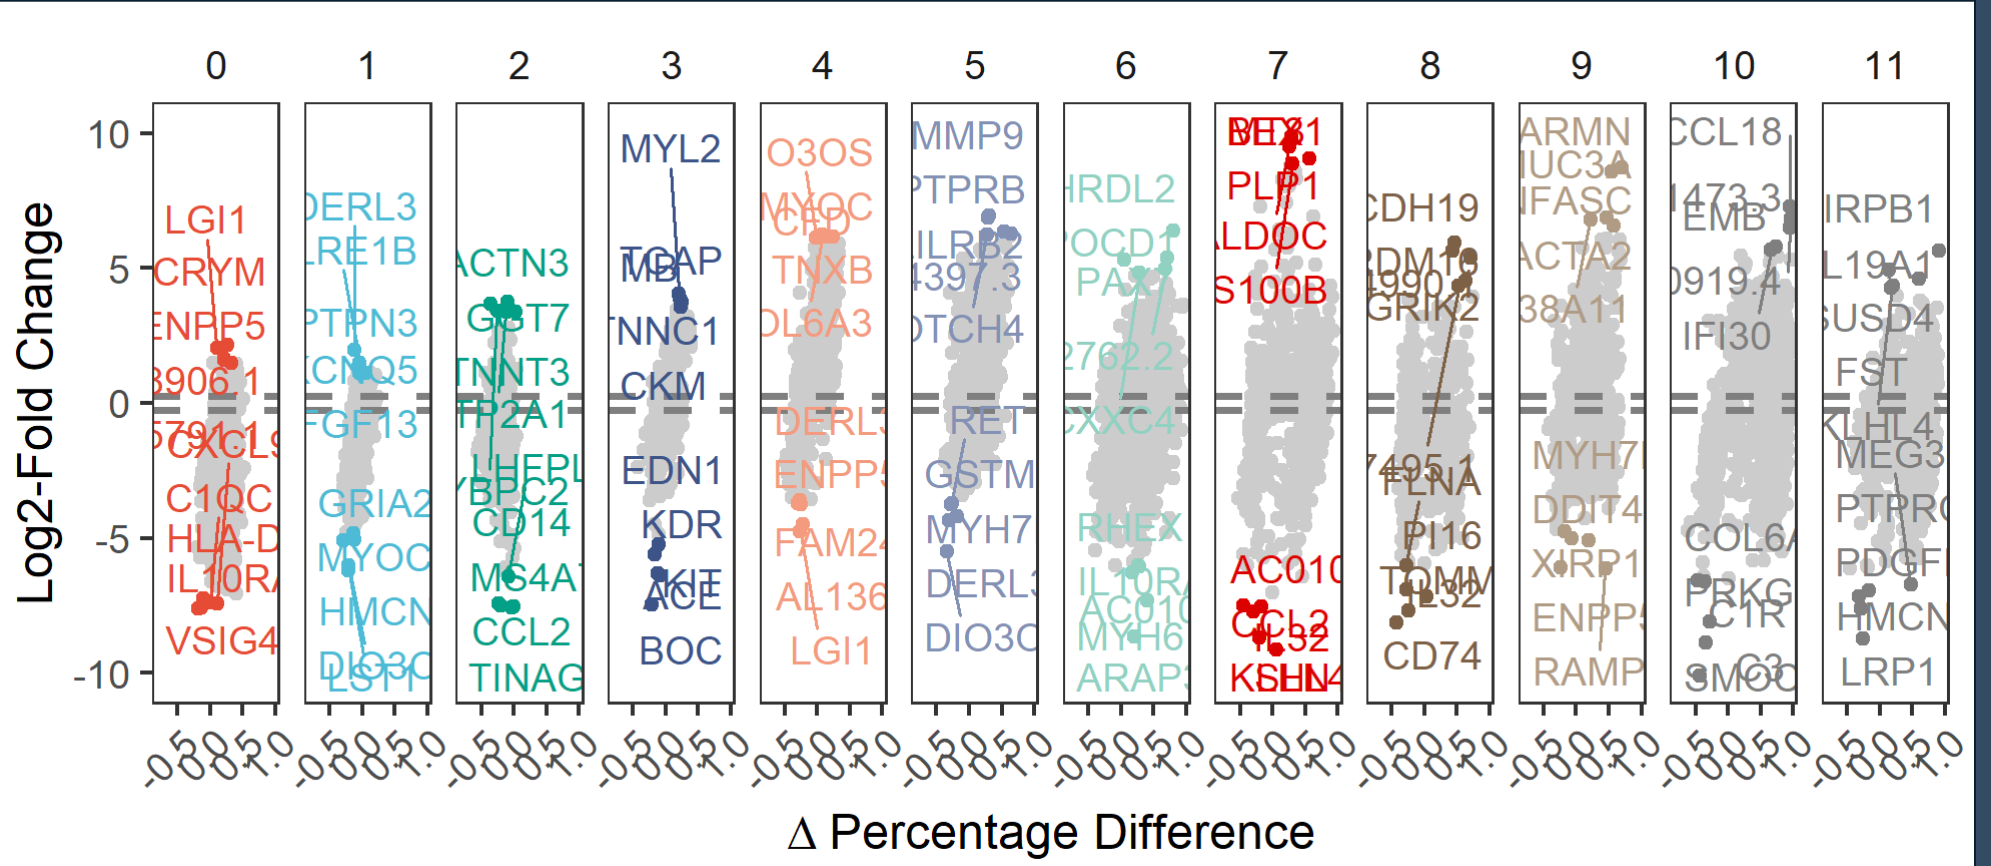

In [ ]:
##Pig(all) 将猪的信息比对到人
all <- readRDS("Z:/A/ST/Analysis/Results8/GNG/all.rds")
anchors <- FindTransferAnchors(
  reference = all,
  query = All.integrated,
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:30
)

predictions  <- TransferData(
  anchorset = anchors,
  refdata = all@active.ident,
  dims = 1:30
)

All.integrated$predicted.id <- predictions$predicted.id
Idents(All.integrated) <- "predicted.id"

DimPlot(All.integrated, group.by = "predicted.id", label = TRUE, raster=FALSE, repel = TRUE) + NoLegend()

In [ ]:
#合并两个对象
library(Seurat)

# Ensure that the cell annotations are stored in the same meta.data column
all$celltype <- all@meta.data[["original_clusters"]]
All.integrated$celltype <- All.integrated@meta.data[["predicted.id"]]

# Update 'orig.ident' to have only two categories
all$orig.ident <- 'all'
All.integrated$orig.ident <- 'All.integrated'

# Alternatively, create a new 'dataset' column if you want to keep 'orig.ident' intact
# all$dataset <- 'all'
# All.integrated$dataset <- 'All.integrated'

# If necessary, convert assays to 'Assay5' and join layers for compatibility
all[["RNA"]] <- as(all[["RNA"]], "Assay5")
all <- JoinLayers(all)

All.integrated[["integrated"]] <- as(All.integrated[["integrated"]], "Assay5")
All.integrated <- JoinLayers(All.integrated)

# Create a list of Seurat objects to integrate
object.list <- list(all, All.integrated)

# Normalize and identify variable features for each dataset independently
for (i in 1:length(object.list)) {
    object.list[[i]] <- NormalizeData(object.list[[i]], verbose = FALSE)
    object.list[[i]] <- FindVariableFeatures(object.list[[i]], selection.method = "vst", nfeatures = 2000, verbose = FALSE)
}

# Select features for integration
features <- SelectIntegrationFeatures(object.list = object.list, nfeatures = 2000)

# Find integration anchors
anchors <- FindIntegrationAnchors(object.list = object.list, anchor.features = features)

# Integrate the datasets
combined <- IntegrateData(anchorset = anchors)

# Set the default assay to 'integrated'
DefaultAssay(combined) <- "integrated"

# Scale the integrated data
combined <- ScaleData(combined, verbose = FALSE)

# Run PCA on the integrated data
combined <- RunPCA(combined, npcs = 30, verbose = FALSE)

# Run UMAP on the PCA-reduced data
combined <- RunUMAP(combined, reduction = "pca", dims = 1:30, verbose = FALSE)

# Visualize the UMAP, coloring cells by 'orig.ident'
DimPlot(combined, reduction = "umap", group.by = "orig.ident")


In [ ]:
# For the 'all' object
cell_counts_all <- table(all$celltype)
print("Cell counts in 'all' object:")
print(cell_counts_all)

# For the 'All.integrated' object
cell_counts_All_integrated <- table(All.integrated$celltype)
print("Cell counts in 'All.integrated' object:")
print(cell_counts_All_integrated)


M.GAS <- subset(All.integrated, subset = orig.ident == "M.GAS")
M.Sol <- subset(All.integrated, subset = orig.ident == "M.Sol")
M.TA <- subset(All.integrated, subset = orig.ident == "M.TA")



cell_counts_All_integrated <- table(M.TA$celltype)
print("Cell counts in 'All.integrated' object:")
print(cell_counts_All_integrated)

In [ ]:
##findmarker
setwd("Z:\\A\\ST\\Analysis\\Results8\\GNG")

library(Seurat)

# Create a 'dataset' column to indicate the origin of each cell
all$dataset <- 'all'
All.integrated$dataset <- 'All.integrated'

# Ensure the cell type annotations are in the 'celltype' column
all$celltype <- all@meta.data[["original_clusters"]]
All.integrated$celltype <- All.integrated@meta.data[["predicted.id"]]


# Subset MT-rich FAPs cells from 'all'
mt_rich_faps_all <- subset(all, subset = celltype == 'MT-rich FAPs')

# Subset MT-rich FAPs cells from 'All.integrated'
mt_rich_faps_All_integrated <- subset(All.integrated, subset = celltype == 'MT-rich FAPs')


mt_rich_faps_combined <- merge(mt_rich_faps_all, y = mt_rich_faps_All_integrated, add.cell.ids = c("all", "All.integrated"), project = "MT_rich_FAPs")

mt_rich_faps_combined[['RNA']] = as(mt_rich_faps_combined[['RNA']],'Assay5')
mt_rich_faps_combined = JoinLayers(mt_rich_faps_combined)



# Normalize the data
mt_rich_faps_combined <- NormalizeData(mt_rich_faps_combined)

# Find variable features
mt_rich_faps_combined <- FindVariableFeatures(mt_rich_faps_combined, selection.method = "vst", nfeatures = 2000)

# Scale the data
mt_rich_faps_combined <- ScaleData(mt_rich_faps_combined, features = VariableFeatures(object = mt_rich_faps_combined))

Idents(mt_rich_faps_combined) <- 'dataset'

markers_mt_rich_faps <- FindMarkers(mt_rich_faps_combined, ident.1 = 'all', ident.2 = 'All.integrated')

# View the top markers
head(markers_mt_rich_faps)


In [ ]:

# Add 'cluster' column with zeros
markers_mt_rich_faps$cluster <- 0

# Add 'gene' column with row names (gene names)
markers_mt_rich_faps$gene <- rownames(markers_mt_rich_faps)

# Rearrange columns to have 'gene' and 'cluster' at the beginning (optional)
markers_mt_rich_faps <- markers_mt_rich_faps[, c("gene", "cluster", setdiff(colnames(markers_mt_rich_faps), c("gene", "cluster")))]

# View the first few rows of the modified data frame
head(markers_mt_rich_faps)

In [ ]:
marker <- as.data.frame(marker)  # 转换为data.frame
rownames(marker) <- make.unique(as.character(marker[[1]]))  # 确保第一列为字符
marker <- marker[, -1]  # 移除第一列


marker$cluster <- as.factor(marker$cluster)

In [ ]:
markerVolcano(
    markers = marker,
    topn = 5,
    myMarkers = mygene,
    labelCol = ggsci::pal_npg()(11)
)

In [ ]:
jjVolcano(diffData = pbmc.markers,
          myMarkers = mygene)

In [ ]:
### GSEA
library(clusterProfiler)
library(org.Hs.eg.db)
library(DOSE)
library(ggplot2)
library(clusterProfiler)
library(enrichplot)
library(org.Hs.eg.db)
library(ggplot2)

logFC_values <- diff_exp$logFC_b
names(logFC_values) <- diff_exp$ID
logFC_values <- sort(logFC_values, decreasing = TRUE)

gsea_results <- gseGO(
  geneList = logFC_values,
  OrgDb = org.Hs.eg.db,
  keyType = "SYMBOL",
  ont = "ALL", # 包括所有 GO 类别
  nPerm = 2000, # 置换测试次数
  minGSSize = 5, # 最小基因集大小
  maxGSSize = 1000, # 最大基因集大小
  pvalueCutoff = 1, # 放宽 p 值阈值
  verbose = FALSE
)

gene_sets <- c("GO:0006094", "GO:0006094","GO:0045722","GO:0034645","GO:0045723","GO:0045734")
gseaplot2(gsea_results, geneSetID = gene_sets, title = "Enrichment plot: GO:0006633", subplots = 1:3, base_size = 10)

# GO:0006094 Gluconeogenesis (糖异生)
# GO:0006111 Regulation of gluconeogenesis (糖异生的调控)
# GO:0045722 Positive regulation of gluconeogenesis (正向调控糖异生)
# GO:0034645 Gluconeogenesis from pyruvate (从丙酮酸进行的糖异生)
# GO:0045723 Cellular gluconeogenesis (细胞水平的糖异生)
# GO:0045734 Multicellular organismal gluconeogenesis (多细胞生物体的糖异生)

In [ ]:
# Load necessary libraries
library(Seurat)
library(clusterProfiler)
library(org.Ss.eg.db)    
library(DOSE)
library(ggplot2)
library(enrichplot)



# 获取所有基因名
gene_names <- names(logFC_values)

# 识别哪些基因名是 ENSEMBL 基因 ID
is_ensembl_id <- grepl("^ENS", gene_names)

# 从 logFC_values 中删除 ENSEMBL 基因 ID
logFC_values_no_ensembl <- logFC_values[!is_ensembl_id]

# 查看删除 ENSEMBL 基因 ID 后的 logFC_values
print(logFC_values_no_ensembl)


# 提取基因符号列表
gene_symbols <- names(logFC_values_no_ensembl)

# 如果有已知的非标准基因符号，可以创建一个映射表
# 例如，将 COX1 替换为 MT-CO1
symbol_mapping <- c(
  "COX1" = "MT-CO1",
  "COX2" = "MT-CO2",
  "COX3" = "MT-CO3",
  "ATP6" = "MT-ATP6",
  "ND1" = "MT-ND1",
  "ND2" = "MT-ND2",
  "ND3" = "MT-ND3",
  "ND4" = "MT-ND4",
  "ND4L" = "MT-ND4L",
  "ND5" = "MT-ND5",
  "ND6" = "MT-ND6",
  "CYTB" = "MT-CYB"
)

# 将基因符号替换为标准符号
standard_symbols <- ifelse(
  gene_symbols %in% names(symbol_mapping),
  symbol_mapping[gene_symbols],
  gene_symbols
)

# 更新 logFC_values_no_ensembl 的基因名
names(logFC_values_no_ensembl) <- standard_symbols

mapping <- mapping[!is.na(mapping$ENSEMBL), ]
mapping_counts <- table(mapping$SYMBOL)
multiple_mappings <- names(mapping_counts[mapping_counts > 1])
if (length(multiple_mappings) > 0) {
  warning("以下基因符号存在多个 ENSEMBL 基因 ID 映射：", paste(multiple_mappings, collapse = ", "))
  mapping <- mapping[!duplicated(mapping$SYMBOL), ]
}
mapped_symbols <- unique(mapping$SYMBOL)
unmapped_symbols <- setdiff(names(logFC_values_no_ensembl), mapped_symbols)
if (length(unmapped_symbols) > 0) {
  warning("以下基因符号未能映射到 ENSEMBL 基因 ID：", paste(unmapped_symbols, collapse = ", "))
}

# 步骤 5：合并映射结果
logFC_df <- data.frame(SYMBOL = names(logFC_values_no_ensembl), logFC = logFC_values_no_ensembl)
logFC_mapped <- merge(logFC_df, mapping, by = "SYMBOL")
logFC_mapped <- logFC_mapped[!duplicated(logFC_mapped$ENSEMBL), ]
logFC_values_ensembl <- logFC_mapped$logFC
names(logFC_values_ensembl) <- logFC_mapped$ENSEMBL

# 步骤 6：查看结果
head(logFC_values_ensembl)
length(logFC_values_ensembl)

logFC_values_ensembl_sorted <- sort(logFC_values_ensembl, decreasing = TRUE)



# Ensure that the gene IDs match the keyType
# In this case, we have Ensembl gene IDs (e.g., "ENSSSCG00000048856")

# Run GSEA analysis using gseGO
gsea_results <- gseGO(
  geneList = logFC_values_ensembl_sorted,
  OrgDb = org.Hs.eg.db,
  keyType = "ENSEMBL",  # Since gene IDs are Ensembl IDs
  ont = "ALL",          # Include all GO categories
  nPerm = 2000,         # Number of permutations
  minGSSize = 5,        # Minimum gene set size
  maxGSSize = 1000,     # Maximum gene set size
  pvalueCutoff = 1,     # Include all p-values
  verbose = FALSE
)

gene_sets <- c("GO:0006094", "GO:0006094","GO:0045722","GO:0034645","GO:0045723","GO:0045734")
gseaplot2(gsea_results, geneSetID = gene_sets, title = "Enrichment plot: GO:0006633", subplots = 1:3, base_size = 10)



In [ ]:
head(gsea_results@result)

# 检查指定的 GO 术语是否存在于结果中
gene_sets <- c("GO:0006094", "GO:0006094", "GO:0045722", "GO:0034645", "GO:0045723", "GO:0045734")
available_gene_sets <- gene_sets[gene_sets %in% gsea_results@result$ID]

if (length(available_gene_sets) == 0) {
    stop("指定的 GO 术语在 gsea_results 中不存在。")
}

### Corsstalk

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results8\\crosstalk")
load("Z:/A/ST/Analysis/Results8/crosstalk/.RData")

In [ ]:
#All.integrated由9个样本组成，我需要提取其中三个H.GAS、H.VL、H.TA提取为一个对象，给出代码

# 提取特定样本为一个新对象
subset_integrated <- subset(All.integrated, subset = orig.ident %in% c("H.GAS", "H.VL", "H.TA"))

# 保存新的对象
saveRDS(subset_integrated, file = "huamn.rds")

In [ ]:
> meta_data <- data.frame(group = Idents(huamn), row.names = colnames(counts_matrix))
> all(colnames(counts_matrix) == rownames(meta_data))
[1] TRUE
> cellChat <- createCellChat(object = counts_matrix, meta = meta_data, group.by = "group")
[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Type 1 myofibers, Type 1/2a myofibers, MT-rich FAPs, MuSCs, T cell, MR-FAPs, VECs, Type 2x myofibers, Type 2a/x myofibers, Type 2a myofibers, Preadipocytes, Stem like FAPss, Macrophage, Myoblasts, Monocyte, Mature Adipocytes, F3+ FAPs, B, Myogenic like FAPs, Mast cell, LECs, Treg cell, Neurons, Perimysial cells, NK2, DC 
Warning message:
In createCellChat(object = counts_matrix, meta = meta_data, group.by = "group") :
  The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 

> cellChat 
An object of class CellChat created from a single dataset 
 45802 genes.
 29890 cells. 
CellChat analysis of single cell RNA-seq data! 

cellchat=cellChat

In [ ]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

In [ ]:
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") 
cellchat@DB <- CellChatDB.use


cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

cellchat <- computeCommunProb(cellchat, type = "triMean")


In [ ]:
cellchat <- filterCommunication(cellchat, min.cells = 3)
cellchat <- computeCommunProbPathway(cellchat)

In [ ]:
cellchat <- aggregateNet(cellchat)

In [ ]:
ptm = Sys.time()
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")


In [ ]:
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [ ]:
pathways.show <- c("BMP") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, siHgnaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")

#### COR

In [ ]:
# Extract scaled data matrix for 'human'
scaled_data_human <- GetAssayData(type1_2a_cells_human, assay = 'integrated', slot = 'scale.data')

# Compute average expression across all cells for 'human'
avg_expr_human <- rowMeans(scaled_data_human)

# Convert to data frame
avg_exp_human_df <- data.frame(gene = names(avg_expr_human), avg_expr_human = avg_expr_human)

# Do the same for 'refer'
scaled_data_refer <- GetAssayData(type1_2a_cells_refer, assay = 'integrated', slot = 'scale.data')
avg_expr_refer <- rowMeans(scaled_data_refer)
avg_exp_refer_df <- data.frame(gene = names(avg_expr_refer), avg_expr_refer = avg_expr_refer)

# Merge data frames on gene names
merged_df <- merge(avg_exp_refer_df, avg_exp_human_df, by = 'gene')

# Compute Pearson correlation
correlation <- cor(merged_df$avg_expr_refer, merged_df$avg_expr_human, method = "pearson")

# Print correlation result
print(paste("Pearson correlation between Type 1/2a myofibers in human and refer:", correlation))

# Plot the correlation
library(ggplot2)
ggplot(merged_df, aes(x = avg_expr_refer, y = avg_expr_human)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = 'lm', color = 'blue') +
  xlab('Average Expression in refer') +
  ylab('Average Expression in human') +
  ggtitle(paste('Correlation between Type 1/2a myofibers in human and refer:', round(correlation, 2)))

In [ ]:
[1] "Type 1 myofibers"    "Type 1/2a myofibers" "MT-rich FAPs"       
[4] "MuSCs"               "T cell"              "MR-FAPs"            
[7] "VECs"                "Type 2x myofibers"   "Type 2a/x myofibers"
[10] "Type 2a myofibers"   "Preadipocytes"       "Stem like FAPss"   
[13] "Macrophage"          "Myoblasts"           "Monocyte"          
[16] "Mature Adipocytes"   "F3+ FAPs"            "B"                 
[19] "Myogenic like FAPs"  "Mast cell"           "LECs"              
[22] "Treg cell"           "Neurons"             "Perimysial cells"  
[25] "NK2"                 "DC"

In [ ]:
Myofibers: Type 1 myofibers、Type 1/2a myofibers、Type 2a myofibers、Type 2a/x myofibers、Type 2x myofibers
Muscle cells: MuSCs、Myoblasts
Interstitial cells：MT-rich FAPs、MR-FAPs、Preadipocytes、Stem like FAPss、Mature Adipocytes、F3+ FAPs、Neurons、Perimysial cells
Immune cells：T cell、Macrophage、Monocyte、B、Mast cell、Treg cell、NK2、DC
Endothelial cells：VECs、LECs

In [ ]:
##整合以后的细胞群相关性分析

In [ ]:
# 加载所需库
library(Seurat)
library(ggplot2)
library(pheatmap)

# 步骤 1：定义细胞类型分组
cell_type_groups <- list(
  'Myofibers' = c('Type 1 myofibers', 'Type 1/2a myofibers', 'Type 2a myofibers', 'Type 2a/x myofibers', 'Type 2x myofibers'),
  'Muscle cells' = c('MuSCs', 'Myoblasts'),
  'Interstitial cells' = c('MT-rich FAPs', 'MR-FAPs', 'Preadipocytes', 'Stem like FAPss', 'Mature Adipocytes', 'F3+ FAPs', 'Neurons', 'Perimysial cells'),
  'Immune cells' = c('T cell', 'Macrophage', 'Monocyte', 'B', 'Mast cell', 'Treg cell', 'NK2', 'DC'),
  'Endothelial cells' = c('VECs', 'LECs')
)

# 步骤 2：将细胞分配到新的分组
map_cell_types <- function(cell_type_vector, cell_type_groups) {
  group_vector <- sapply(cell_type_vector, function(x) {
    group <- names(cell_type_groups)[sapply(cell_type_groups, function(group_cell_types) x %in% group_cell_types)]
    if (length(group) == 0) {
      return(NA)
    } else {
      return(group)
    }
  })
  return(group_vector)
}

human$cell_group <- map_cell_types(human$celltype, cell_type_groups)
refer$cell_group <- map_cell_types(refer$original_clusters, cell_type_groups)

# 检查未匹配的细胞类型
unmatched_human <- unique(human$celltype[is.na(human$cell_group)])
unmatched_refer <- unique(refer$original_clusters[is.na(refer$cell_group)])

print("在 'human' 数据集中未匹配的细胞类型：")
print(unmatched_human)

print("在 'refer' 数据集中未匹配的细胞类型：")
print(unmatched_refer)

# 步骤 3：提取共有的细胞分组
human_groups <- unique(human$cell_group)
refer_groups <- unique(refer$cell_group)
common_groups <- intersect(human_groups, refer_groups)
common_groups <- common_groups[!is.na(common_groups)]

print("共有的细胞分组：")
print(common_groups)

# 步骤 4：子集和准备数据
cells_human <- subset(human, subset = cell_group %in% common_groups)
cells_refer <- subset(refer, subset = cell_group %in% common_groups)

# 确保 'integrated' assay 为 'Assay' 类
if (class(cells_human[['integrated']]) == "Assay5") {
    cells_human[['integrated']] <- as.Assay(cells_human[['integrated']])
}
if (class(cells_refer[['integrated']]) == "Assay5") {
    cells_refer[['integrated']] <- as.Assay(cells_refer[['integrated']])
}

# 设置活跃的 assay 并缩放数据
DefaultAssay(cells_human) <- 'integrated'
cells_human <- ScaleData(cells_human, assay = 'integrated')

DefaultAssay(cells_refer) <- 'integrated'
cells_refer <- ScaleData(cells_refer, assay = 'integrated')

# 设置细胞身份为细胞分组
Idents(cells_human) <- cells_human$cell_group
Idents(cells_refer) <- cells_refer$cell_group

# 步骤 5：计算平均表达
avg_exp_human <- AverageExpression(cells_human, assays = 'integrated', slot = 'scale.data', group.by = 'cell_group')
avg_exp_refer <- AverageExpression(cells_refer, assays = 'integrated', slot = 'scale.data', group.by = 'cell_group')

# 步骤 6：准备相关性分析的数据
avg_exp_human_df <- as.data.frame(avg_exp_human$integrated)
avg_exp_human_df$gene <- rownames(avg_exp_human_df)

avg_exp_refer_df <- as.data.frame(avg_exp_refer$integrated)
avg_exp_refer_df$gene <- rownames(avg_exp_refer_df)

merged_df <- merge(avg_exp_human_df, avg_exp_refer_df, by = 'gene', suffixes = c('_human', '_refer'))

# 步骤 7：计算相关性矩阵
human_groups <- colnames(avg_exp_human$integrated)
refer_groups <- colnames(avg_exp_refer$integrated)

cor_matrix <- matrix(NA, nrow = length(human_groups), ncol = length(refer_groups))
rownames(cor_matrix) <- human_groups
colnames(cor_matrix) <- refer_groups

for (i in 1:length(human_groups)) {
    for (j in 1:length(refer_groups)) {
        expr_human <- merged_df[[paste0(human_groups[i], '_human')]]
        expr_refer <- merged_df[[paste0(refer_groups[j], '_refer')]]
        
        # 转换为数值型并处理 NA
        expr_human <- as.numeric(expr_human)
        expr_refer <- as.numeric(expr_refer)
        valid_indices <- complete.cases(expr_human, expr_refer)
        expr_human <- expr_human[valid_indices]
        expr_refer <- expr_refer[valid_indices]
        
        cor_value <- cor(expr_human, expr_refer, method = 'pearson')
        cor_matrix[human_groups[i], refer_groups[j]] <- cor_value
    }
}

# 

pheatmap(cor_matrix,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         display_numbers = TRUE,
         number_format = "%.2f",
         fontsize_number = 10,
         main = "Human 和 Refer 细胞分组间的相关性热图",
         color = colorRampPalette(c("white", "blue"))(50))

In [ ]:
##'Myofibers'

pheatmap(cor_matrix,
          cluster_rows = TRUE,
          cluster_cols = TRUE,
          display_numbers = TRUE,
          number_format = "%.2f",
          fontsize_number = 10,
          main = "Myofibers 细胞类型间的相关性热图",
          color = colorRampPalette(c("#7E9CFA", "#913B4A"))(50))

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results8\\Cor")
mice <- subset(All.integrated, subset = orig.ident %in% c("M.GAS", "M.Sol", "M.TA"))
saveRDS(mice, file = "mice.rds")

In [ ]:
all <- readRDS("Z:/A/ST/Analysis/Results8/GNG/all.rds")

In [ ]:
anchors <- FindTransferAnchors(
  reference = pig_ann,
  query = mice,
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:30
)

predictions  <- TransferData(
  anchorset = anchors,
  refdata = pig_ann@active.ident,
  dims = 1:30
)

mice$predicted.id <- predictions$predicted.id
Idents(mice) <- "predicted.id"

DimPlot(mice, group.by = "predicted.id", label = TRUE, raster=FALSE, repel = TRUE) + NoLegend()

saveRDS(mice, file = "mice_ann.rds")

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results8\\Cor")

In [ ]:
library(Seurat)

DefaultAssay(mice_ann) <- 'RNA'
DefaultAssay(human_ann) <- 'RNA'
DefaultAssay(pig_ann) <- 'RNA'

In [ ]:
# 提取 human_ann 中的细胞类型
human_cell_types <- unique(human_ann$celltype)
print("Human_ann 数据集中的细胞类型：")
print(human_cell_types)

# 提取 mice_ann 中的细胞类型
mice_cell_types <- unique(mice_ann$predicted.id)
print("Mice_ann 数据集中的细胞类型：")
print(mice_cell_types)

# 找到共有的细胞类型
common_cell_types <- intersect(human_cell_types, mice_cell_types)
print("共有的细胞类型：")
print(common_cell_types)

In [ ]:
> print(common_cell_types)
 [1] "Type 1 myofibers"    "Type 1/2a myofibers" "MT-rich FAPs"       
 [4] "MuSCs"               "T cell"              "MR-FAPs"            
 [7] "VECs"                "Type 2x myofibers"   "Type 2a/x myofibers"
[10] "Type 2a myofibers"   "Preadipocytes"       "Stem like FAPss"    
[13] "Macrophage"          "Myoblasts"           "Monocyte"           
[16] "Mature Adipocytes"   "F3+ FAPs"            "B"                  
[19] "Myogenic like FAPs"  "Mast cell"           "LECs"               
[22] "Neurons"             "Perimysial cells"    "NK2" 

In [ ]:
# 加载所需库
library(Seurat)
library(pheatmap)

# 步骤 1：定义细胞类型分组
cell_type_groups <- list(
  'Myofibers' = c('Type 1 myofibers', 'Type 1/2a myofibers', 'Type 2a myofibers', 'Type 2a/x myofibers', 'Type 2x myofibers'),
  'Muscle cells' = c('MuSCs', 'Myoblasts'),
  'Interstitial cells' = c('MT-rich FAPs', 'MR-FAPs', 'Preadipocytes', 'Stem like FAPss', 'Mature Adipocytes', 'F3+ FAPs', 'Neurons', 'Perimysial cells'),
  'Immune cells' = c('T cell', 'Macrophage', 'Monocyte', 'B', 'Mast cell', 'NK2'),
  'Endothelial cells' = c('VECs', 'LECs')
)

# 步骤 2：映射细胞类型到分组
map_cell_types <- function(cell_type_vector, cell_type_groups) {
  group_vector <- sapply(cell_type_vector, function(x) {
    group <- names(cell_type_groups)[sapply(cell_type_groups, function(group_cell_types) x %in% group_cell_types)]
    if (length(group) == 0) {
      return(NA)
    } else {
      return(group)
    }
  })
  return(group_vector)
}

# 在 human_ann 中添加 'cell_group' 列
human_ann$cell_group <- map_cell_types(human_ann$celltype, cell_type_groups)

# 在 mice_ann 中添加 'cell_group' 列
mice_ann$cell_group <- map_cell_types(mice_ann$predicted.id, cell_type_groups)

# 检查未匹配的细胞类型
unmatched_human <- unique(human_ann$celltype[is.na(human_ann$cell_group)])
unmatched_mice <- unique(mice_ann$predicted.id[is.na(mice_ann$cell_group)])

print("在 human_ann 数据集中未匹配的细胞类型：")
print(unmatched_human)

print("在 mice_ann 数据集中未匹配的细胞类型：")
print(unmatched_mice)

# 步骤 3：提取共有的细胞分组
human_groups <- unique(human_ann$cell_group)
mice_groups <- unique(mice_ann$cell_group)

# 移除 NA 值
human_groups <- human_groups[!is.na(human_groups)]
mice_groups <- mice_groups[!is.na(mice_groups)]

# 找到共有的细胞分组
common_groups <- intersect(human_groups, mice_groups)
print("共有的细胞分组：")
print(common_groups)

# 步骤 4：子集提取
# 从 human_ann 中提取共有分组的细胞
human_subset <- subset(human_ann, subset = cell_group %in% common_groups)

# 从 mice_ann 中提取共有分组的细胞
mice_subset <- subset(mice_ann, subset = cell_group %in% common_groups)

# 步骤 5：计算平均表达谱
# 设置活跃的 assay
DefaultAssay(human_subset) <- 'RNA'
DefaultAssay(mice_subset) <- 'RNA'

# 确保数据已标准化，如果未标准化，请运行 NormalizeData()
# human_subset <- NormalizeData(human_subset)
# mice_subset <- NormalizeData(mice_subset)

# 将细胞身份设置为 'cell_group'
Idents(human_subset) <- human_subset$cell_group
Idents(mice_subset) <- mice_subset$cell_group

# 计算平均表达
avg_exp_human <- AverageExpression(human_subset, assays = 'RNA', slot = 'data', group.by = 'cell_group')
avg_exp_mice <- AverageExpression(mice_subset, assays = 'RNA', slot = 'data', group.by = 'cell_group')

# 步骤 6：转换 mice_ann 的基因名称为大写
# 获取 mice_ann 的基因名称
mouse_genes <- rownames(avg_exp_mice$RNA)
# 将基因名称转换为大写
mouse_genes_upper <- toupper(mouse_genes)
# 设置新的基因名称
rownames(avg_exp_mice$RNA) <- mouse_genes_upper

# 步骤 7：准备相关性分析的数据
# 将人类平均表达数据转换为数据框
avg_exp_human_df <- as.data.frame(avg_exp_human$RNA)
avg_exp_human_df$gene <- rownames(avg_exp_human_df)

# 将小鼠平均表达数据转换为数据框
avg_exp_mice_df <- as.data.frame(avg_exp_mice$RNA)
avg_exp_mice_df$gene <- rownames(avg_exp_mice_df)

# 清理基因名称（移除 '.' 及其之后的内容和非字母数字字符）
clean_gene_names <- function(gene_names) {
  gene_names <- gsub("\\..*", "", gene_names)  # 移除 '.' 及其之后的内容
  gene_names <- gsub("[^A-Za-z0-9]", "", gene_names)  # 移除非字母数字字符
  return(gene_names)
}

# 清理人类数据中的基因名称
avg_exp_human_df$gene <- clean_gene_names(avg_exp_human_df$gene)

# 清理小鼠数据中的基因名称（已转换为大写）
avg_exp_mice_df$gene <- clean_gene_names(avg_exp_mice_df$gene)

# 合并人类和小鼠的数据框
merged_df <- merge(avg_exp_human_df, avg_exp_mice_df, by = 'gene', suffixes = c('_human', '_mouse'))

# 检查合并后的基因数量
num_genes_merged <- nrow(merged_df)
print(paste("清理和合并后的基因数量：", num_genes_merged))

# 步骤 8：计算相关性矩阵
# 获取分组名称
human_groups <- colnames(avg_exp_human$RNA)
mouse_groups <- colnames(avg_exp_mice$RNA)

# 初始化相关性矩阵
cor_matrix <- matrix(NA, nrow = length(human_groups), ncol = length(mouse_groups))
rownames(cor_matrix) <- human_groups
colnames(cor_matrix) <- mouse_groups

# 计算相关性
for (i in 1:length(human_groups)) {
  for (j in 1:length(mouse_groups)) {
    expr_human <- merged_df[[paste0(human_groups[i], "_human")]]
    expr_mouse <- merged_df[[paste0(mouse_groups[j], "_mouse")]]
    
    expr_human <- as.numeric(expr_human)
    expr_mouse <- as.numeric(expr_mouse)
    valid_indices <- complete.cases(expr_human, expr_mouse)
    expr_human <- expr_human[valid_indices]
    expr_mouse <- expr_mouse[valid_indices]
    
    if (length(expr_human) > 2 && length(expr_mouse) > 2) {
      cor_value <- cor(expr_human, expr_mouse, method = 'pearson')
    } else {
      cor_value <- NA
    }
    cor_matrix[human_groups[i], mouse_groups[j]] <- cor_value
  }
}

# 步骤 9：可视化相关性热图
pheatmap(cor_matrix,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         display_numbers = TRUE,
         number_format = "%.2f",
         fontsize_number = 10,
         main = "Human 和 Mice 细胞分组间的相关性热图",
         color = colorRampPalette(c("#7E9CFA", "#913B4A"))(50))


In [ ]:
## 人和小鼠肌纤维的相关性分析热图

library(Seurat)
library(pheatmap)

# 定义要分析的肌纤维亚群
myofiber_subtypes <- c('Type 1 myofibers', 'Type 1/2a myofibers', 'Type 2a myofibers', 'Type 2a/x myofibers', 'Type 2x myofibers')

# 步骤 1：提取特定细胞类型的细胞

## 从 human_ann 中提取指定亚群的细胞
human_subset <- subset(human_ann, subset = celltype %in% myofiber_subtypes)

## 从 mice_ann 中提取指定亚群的细胞
mice_subset <- subset(mice_ann, subset = predicted.id %in% myofiber_subtypes)

# 检查每个数据集中提取的细胞数量
print(paste("Human_ann 中提取的细胞数量：", ncol(human_subset)))
print(paste("Mice_ann 中提取的细胞数量：", ncol(mice_subset)))

# 步骤 2：计算每个亚群的平均基因表达

# 设置活跃的 assay
DefaultAssay(human_subset) <- 'RNA'
DefaultAssay(mice_subset) <- 'RNA'

# 确保数据已标准化，如果未标准化，请运行 NormalizeData()
# human_subset <- NormalizeData(human_subset)
# mice_subset <- NormalizeData(mice_subset)

# 将细胞身份设置为亚群类型
Idents(human_subset) <- human_subset$celltype
Idents(mice_subset) <- mice_subset$predicted.id

# 计算平均表达
avg_exp_human <- AverageExpression(human_subset, assays = 'RNA', slot = 'data', group.by = 'celltype')
avg_exp_mice <- AverageExpression(mice_subset, assays = 'RNA', slot = 'data', group.by = 'predicted.id')

# 步骤 3：准备基因名称

# 将小鼠基因名称转换为大写
mouse_genes <- rownames(avg_exp_mice$RNA)
mouse_genes_upper <- toupper(mouse_genes)
rownames(avg_exp_mice$RNA) <- mouse_genes_upper

# 步骤 4：合并人类和小鼠的数据

# 将平均表达数据转换为数据框
avg_exp_human_df <- as.data.frame(avg_exp_human$RNA)
avg_exp_human_df$gene <- rownames(avg_exp_human_df)

avg_exp_mice_df <- as.data.frame(avg_exp_mice$RNA)
avg_exp_mice_df$gene <- rownames(avg_exp_mice_df)

# 清理基因名称（移除特殊字符和版本号）
clean_gene_names <- function(gene_names) {
  gene_names <- gsub("\\..*", "", gene_names)  # 移除 '.' 及其之后的内容
  gene_names <- gsub("[^A-Za-z0-9]", "", gene_names)  # 移除非字母数字字符
  return(gene_names)
}

avg_exp_human_df$gene <- clean_gene_names(avg_exp_human_df$gene)
avg_exp_mice_df$gene <- clean_gene_names(avg_exp_mice_df$gene)

# 合并数据
merged_df <- merge(avg_exp_human_df, avg_exp_mice_df, by = 'gene', suffixes = c('_human', '_mouse'))

# 检查合并后的基因数量
num_genes_merged <- nrow(merged_df)
print(paste("合并后的基因数量：", num_genes_merged))

# 步骤 5：计算相关性矩阵

# 获取人类和小鼠的亚群名称
human_subtypes <- colnames(avg_exp_human$RNA)
mouse_subtypes <- colnames(avg_exp_mice$RNA)

# 初始化相关性矩阵
cor_matrix <- matrix(NA, nrow = length(human_subtypes), ncol = length(mouse_subtypes))
rownames(cor_matrix) <- human_subtypes
colnames(cor_matrix) <- mouse_subtypes

# 计算相关性
for (i in 1:length(human_subtypes)) {
  for (j in 1:length(mouse_subtypes)) {
    expr_human <- merged_df[[paste0(human_subtypes[i], "_human")]]
    expr_mouse <- merged_df[[paste0(mouse_subtypes[j], "_mouse")]]
    
    expr_human <- as.numeric(expr_human)
    expr_mouse <- as.numeric(expr_mouse)
    valid_indices <- complete.cases(expr_human, expr_mouse)
    expr_human <- expr_human[valid_indices]
    expr_mouse <- expr_mouse[valid_indices]
    
    if (length(expr_human) > 2 && length(expr_mouse) > 2) {
      cor_value <- cor(expr_human, expr_mouse, method = 'pearson')
    } else {
      cor_value <- NA
    }
    cor_matrix[human_subtypes[i], mouse_subtypes[j]] <- cor_value
  }
}

# 步骤 6：绘制相关性热图

# 绘制热图
pheatmap(cor_matrix,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         display_numbers = TRUE,
         number_format = "%.2f",
         fontsize_number = 10,
         main = "人类和小鼠肌纤维亚群间的相关性热图",
         color = colorRampPalette(c("#7E9CFA", "#913B4A"))(50))

#### 肌病基因跨物种表达模式分析

In [ ]:
#MD - Muscular Dystrophy
#肌营养不良症（泛指一类导致肌肉无力和萎缩的疾病）
DMD
PKP2
SNTA1
DAG1
BEST1
VDR
TNFRSF11B
BTF3P11
UTRN
ESR1
PTH
CLCN1
TNF
TNFSF11
SGCA
IL1B
TGFB1
LRP5
CTSK
PRKDC
DNM2
FGF23
SFRP4
ACP5
PPARG
BGLAP
NOS1
MTHFR
GH1
LEP

In [ ]:
# 加载所需库
library(Seurat)
library(ggplot2)

# 确保默认的 Assay 设置正确
DefaultAssay(human_ann) <- 'RNA'
DefaultAssay(mice_ann) <- 'RNA'

# 定义目标基因列表
genes_of_interest <- c(
    "DMD", "PKP2", "SNTA1", "DAG1", "BEST1", "VDR", "TNFRSF11B", "BTF3P11",
    "UTRN", "ESR1", "PTH", "CLCN1", "TNF", "TNFSF11", "SGCA", "IL1B", "TGFB1",
    "LRP5", "CTSK", "PRKDC", "DNM2", "FGF23", "ACP5", "PPARG",
    "BGLAP", "NOS1", "MTHFR", "GH1", "LEP"
)

# 步骤 1：从 Seurat 对象中提取表达矩阵

# 指定要使用的层
human_default_layer <- 'data.1'
mice_default_layer <- 'data.9'

# 从人类数据集中提取基因表达矩阵
human_data <- GetAssayData(human_ann, assay = 'RNA', layer = human_default_layer)
human_data <- as.data.frame(human_data)

# 从小鼠数据集中提取基因表达矩阵
mice_data <- GetAssayData(mice_ann, assay = 'RNA', layer = mice_default_layer)
mice_data <- as.data.frame(mice_data)

# 将小鼠基因名称转换为大写
rownames(mice_data) <- toupper(rownames(mice_data))

# 步骤 2：清理基因名称

# 清理基因名称的函数
clean_gene_names <- function(gene_names) {
    gene_names <- gsub("\\..*", "", gene_names)  # 移除 '.' 及其之后的内容
    gene_names <- gsub("[^A-Za-z0-9]", "", gene_names)  # 移除非字母数字字符
    gene_names[gene_names == ""] <- NA  # 将空字符串替换为 NA
    return(gene_names)
}

# 清理人类数据的基因名称
human_genes <- rownames(human_data)
human_genes_clean <- clean_gene_names(human_genes)
human_data$gene <- human_genes_clean

# 清理小鼠数据的基因名称
mice_genes <- rownames(mice_data)
mice_genes_clean <- clean_gene_names(mice_genes)
mice_data$gene <- mice_genes_clean

# 移除基因名称为 NA 的行
human_data <- human_data[!is.na(human_data$gene), ]
mice_data <- mice_data[!is.na(mice_data$gene), ]

# 移除重复的基因名称，保留第一个出现的
human_data <- human_data[!duplicated(human_data$gene), ]
mice_data <- mice_data[!duplicated(mice_data$gene), ]

# 将基因名称设置为行名
rownames(human_data) <- human_data$gene
human_data$gene <- NULL

rownames(mice_data) <- mice_data$gene
mice_data$gene <- NULL

# 步骤 3：确保目标基因在数据集中存在

# 更新目标基因列表，确保基因名称一致
genes_of_interest_clean <- clean_gene_names(genes_of_interest)

# 确保目标基因在数据集中存在
genes_in_human <- intersect(genes_of_interest_clean, rownames(human_data))
genes_in_mouse <- intersect(genes_of_interest_clean, rownames(mice_data))
common_genes <- intersect(genes_in_human, genes_in_mouse)

# 打印存在于两个数据集中的基因
print("在两个数据集中共有的基因：")
print(common_genes)

# 步骤 4：提取共有基因的表达数据

# 从数据框中提取共有基因的表达数据
human_data_subset <- human_data[common_genes, ]
mice_data_subset <- mice_data[common_genes, ]

# 步骤 5：计算平均表达

# 计算人类数据集中每个基因的平均表达值
human_gene_avg <- rowMeans(human_data_subset)

# 计算小鼠数据集中每个基因的平均表达值
mice_gene_avg <- rowMeans(mice_data_subset)

# 步骤 6：合并数据

# 创建数据框
expression_df <- data.frame(
    gene = common_genes,
    human_expression = human_gene_avg[common_genes],
    mice_expression = mice_gene_avg[common_genes]
)

# 检查数据框
print("合并后的表达数据：")
print(expression_df)

# 步骤 7：绘制散点图

# 绘制散点图
ggplot(expression_df, aes(x = human_expression, y = mice_expression, label = gene)) +
    geom_point(color = "blue", size = 3) +
    geom_text(vjust = -1, hjust = 0.5, size = 3) +
    xlab("人类平均表达值") +
    ylab("小鼠平均表达值") +
    ggtitle("目标基因在 Human 和 Mice 数据集中的表达相关性") +
    theme_minimal()

In [ ]:
ggplot(expression_df, aes(x = human_expression, y = mice_expression, label = gene)) +
  geom_point(color = "blue", size = 3) +
  geom_text(vjust = -1, hjust = 0.5, size = 3) +
  xlab("human") +
  ylab("mice") +
  ggtitle("gene") +
  theme_minimal()

修改代码，画出置信区间，回归系数，和回归线


# 有置信区间
ggplot(expression_df, aes(x = human_expression, y = mice_expression, label = gene)) +
  geom_point(color = "blue", size = 5) +
  geom_smooth(method = "lm", se = TRUE, color = "red") +
  geom_text(vjust = -1, hjust = 0.5, size = 3) +
  xlab("human") +
  ylab("mice") +
  ggtitle("Gene Expression Correlation") +
  theme_minimal() +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")),
               formula = y ~ x, parse = TRUE,
               label.x = "right", label.y = "top",
               size = 5, color = "black")

# 无置信区间
ggplot(expression_df, aes(x = human_expression, y = mice_expression, label = gene)) +
  geom_point(color = "blue", size = 3) +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  geom_text(vjust = -1, hjust = 0.5, size = 3) +
  xlab("human") +
  ylab("mice") +
  ggtitle("Gene Expression Correlation") +
  theme_minimal() +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")),
               formula = y ~ x, parse = TRUE,
               label.x.npc = "right", label.y.npc = "top",
               size = 5, color = "black")

In [ ]:
#BMD - Becker Muscular Dystrophy
#贝克肌营养不良症 

DMD
UTRN
BEST1
PRKDC
SYNC
CHRNA7
H19
ITGA7
AQP4
SLC25A1
DAG1
TSSK2
JUN
PLA2G1B
TNNI3
XG
NCAM1
SARS1
SGCD
SPARC
ALB
DGCR2
AICDA

In [ ]:
#CM - Congenital Myopathy
#先天性肌病

COL6A1
COL12A1
COL6A2
COL6A3
LOC122889011
LOC126806573
LAMA2
CAPN3
MAOA
DNAJB6
LMNA
PANK1
PTPN1
PTPN18
PTPN3
COL6A5
LEP
WNT1
PTPRS
PTPRO
ACAN
DYNC1H1
ANKRD11
IRF2BPL
FKRP
REG1A
COL9A1
SELENON
BECN1
HNRNPDL


In [ ]:
#IBM - Inclusion Body Myositis
#包涵体肌炎

VCP
GNE
CLU
SOD2
TUBG1
DAG1
MYH2
NT5C1A
APP
MAPT
TARDBP
APOE
IL1B
IL1R2
IL1R1
IL17RB
IL6
IL10RB
IL1A
IL18R1
CARD16
BACE2
IL12B
IL25
PRKN
ICOSLG
DNAJB6
CCR2
CNBP
OPTN



In [ ]:
#DMD - Duchenne Muscular Dystrophy
#杜氏肌营养不良症

DMD
UTRN
DAG1
TGFB1
LTBP4
ITGA7
SNTA1
NOS1
CCL2
CD4
MSTN
SPP1
PKP2
MB
POSTN
BEST1
ACE
MMP9
IGF1
FST
ALB
PPARGC1A
PRKAA2
INS
DYSF
GPT
IL6
VEGFA
TNNI3
ITGA4


In [ ]:
#SMA - Spinal Muscular Atrophy
#脊髓性肌萎缩症

SMN1
SMN2
NAIP
DYNC1H1
ATP7A
HHEX
VAPB
CHD7
CA3
SAMD4A
MANF
GNAS
HLTF
IGHD1-7
POMC
BCHE
HBB
MSTN
HBA2
STMN1
NEFL
HBA1
GOT1
GOT2
SNRPN


### 人猪的跨物种分析

In [ ]:
# 加载所需库
library(Seurat)
library(ggplot2)
library(ggpmisc)   # 用于添加回归方程和 R² 值
library(ggrepel)   # 用于避免标签重叠

# 确保默认的 Assay 设置正确
DefaultAssay(human_ann) <- 'RNA'
DefaultAssay(pig_ann) <- 'RNA'

# 定义目标基因列表
genes_of_interest <- c(
    "DMD", "PKP2", "SNTA1", "DAG1", "BEST1", "VDR", "TNFRSF11B", "BTF3P11",
    "UTRN", "ESR1", "PTH", "CLCN1", "TNF", "TNFSF11", "SGCA", "IL1B", "TGFB1",
    "LRP5", "CTSK", "PRKDC", "DNM2", "FGF23", "ACP5", "PPARG",
    "BGLAP", "NOS1", "MTHFR", "GH1", "LEP"
)

# 步骤 1：查看 `human_ann` 中的可用层
print("human_ann 中的 RNA Assay 层：")
print(Layers(human_ann[["RNA"]]))

# 指定要使用的层
human_default_layer <- 'data.8'

# 从人类数据集中提取基因表达矩阵
human_data <- GetAssayData(human_ann, assay = 'RNA', layer = human_default_layer)
human_data <- as.data.frame(human_data)

# 从猪数据集中提取基因表达矩阵
pig_default_layer <- 'data'
pig_data <- GetAssayData(pig_ann, assay = 'RNA', layer = pig_default_layer)
pig_data <- as.data.frame(pig_data)

# 步骤 2：清理基因名称

# 定义清理基因名称的函数
clean_gene_names <- function(gene_names) {
    gene_names <- gsub("\\..*", "", gene_names)  # 移除 '.' 及其之后的内容
    gene_names <- gsub("[^A-Za-z0-9]", "", gene_names)  # 移除非字母数字字符
    gene_names <- toupper(gene_names)  # 转换为大写，确保一致性
    gene_names[gene_names == ""] <- NA  # 将空字符串替换为 NA
    return(gene_names)
}

# 清理人类数据的基因名称
human_genes <- rownames(human_data)
human_genes_clean <- clean_gene_names(human_genes)
human_data$gene <- human_genes_clean

# 清理猪数据的基因名称
pig_genes <- rownames(pig_data)
pig_genes_clean <- clean_gene_names(pig_genes)
pig_data$gene <- pig_genes_clean

# 移除基因名称为 NA 的行
human_data <- human_data[!is.na(human_data$gene), ]
pig_data <- pig_data[!is.na(pig_data$gene), ]

# 移除重复的基因名称，保留第一个出现的
human_data <- human_data[!duplicated(human_data$gene), ]
pig_data <- pig_data[!duplicated(pig_data$gene), ]

# 将基因名称设置为行名
rownames(human_data) <- human_data$gene
human_data$gene <- NULL

rownames(pig_data) <- pig_data$gene
pig_data$gene <- NULL

# 步骤 3：确保目标基因在数据集中存在

# 更新目标基因列表，确保基因名称一致
genes_of_interest_clean <- clean_gene_names(genes_of_interest)

# 确保目标基因在数据集中存在
genes_in_human <- intersect(genes_of_interest_clean, rownames(human_data))
genes_in_pig <- intersect(genes_of_interest_clean, rownames(pig_data))
common_genes <- intersect(genes_in_human, genes_in_pig)

# 打印存在于两个数据集中的基因
print("在两个数据集中共有的基因：")
print(common_genes)

# 检查是否有共有基因
if (length(common_genes) == 0) {
    stop("没有在两个数据集中共有的目标基因。请检查基因名称或数据集。")
}

# 步骤 4：提取共有基因的表达数据

# 从数据框中提取共有基因的表达数据
human_data_subset <- human_data[common_genes, ]
pig_data_subset <- pig_data[common_genes, ]

# 步骤 5：计算平均表达

# 计算人类数据集中每个基因的平均表达值
human_gene_avg <- rowMeans(human_data_subset)

# 计算猪数据集中每个基因的平均表达值
pig_gene_avg <- rowMeans(pig_data_subset)

# 步骤 6：合并数据

# 创建数据框
expression_df <- data.frame(
    gene = common_genes,
    human_expression = human_gene_avg[common_genes],
    pig_expression = pig_gene_avg[common_genes]
)

# 检查数据框
print("合并后的表达数据：")
print(expression_df)

# 步骤 7：绘制相关性图

# 绘制散点图
ggplot(expression_df, aes(x = human_expression, y = pig_expression, label = gene)) +
  geom_point(color = "blue", size = 5) +
  geom_smooth(method = "lm", se = TRUE, color = "red") +
  geom_text(vjust = -1, hjust = 0.5, size = 3) +
  xlab("human") +
  ylab("mice") +
  ggtitle("Gene Expression Correlation") +
  theme_minimal() +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")),
               formula = y ~ x, parse = TRUE,
               label.x = "right", label.y = "top",
               size = 5, color = "black")



### 鼠猪的跨物种分析

In [ ]:
# 加载所需库
library(Seurat)
library(ggplot2)
library(ggpmisc)   # 用于添加回归方程和 R² 值
library(ggrepel)   # 用于避免标签重叠

# 确保默认的 Assay 设置正确
DefaultAssay(mice_ann) <- 'RNA'
DefaultAssay(pig_ann) <- 'RNA'

# 定义目标基因列表
genes_of_interest <- c(
    "DMD", "PKP2", "SNTA1", "DAG1", "BEST1", "VDR", "TNFRSF11B", "BTF3P11",
    "UTRN", "ESR1", "PTH", "CLCN1", "TNF", "TNFSF11", "SGCA", "IL1B", "TGFB1",
    "LRP5", "CTSK", "PRKDC", "DNM2", "FGF23", "SFRP4", "ACP5", "PPARG",
    "BGLAP", "NOS1", "MTHFR", "GH1", "LEP"
)

# 步骤 1：查看 `mice_ann` 中的可用层
print("mice_ann 中的 RNA Assay 层：")
print(Layers(mice_ann[["RNA"]]))

# 指定要使用的层
mice_default_layer <- 'data.8'  # 请根据实际的层名称进行调整

# 从小鼠数据集中提取基因表达矩阵
mice_data <- GetAssayData(mice_ann, assay = 'RNA', layer = mice_default_layer)
mice_data <- as.data.frame(mice_data)

# 从猪数据集中提取基因表达矩阵
pig_default_layer <- 'data'
pig_data <- GetAssayData(pig_ann, assay = 'RNA', layer = pig_default_layer)
pig_data <- as.data.frame(pig_data)

# 步骤 2：清理基因名称

# 定义清理基因名称的函数
clean_gene_names <- function(gene_names) {
    gene_names <- gsub("\\..*", "", gene_names)  # 移除 '.' 及其之后的内容
    gene_names <- gsub("[^A-Za-z0-9]", "", gene_names)  # 移除非字母数字字符
    gene_names <- toupper(gene_names)  # 转换为大写，确保一致性
    gene_names[gene_names == ""] <- NA  # 将空字符串替换为 NA
    return(gene_names)
}

# 清理小鼠数据的基因名称
mice_genes <- rownames(mice_data)
mice_genes_clean <- clean_gene_names(mice_genes)
mice_data$gene <- mice_genes_clean

# 清理猪数据的基因名称
pig_genes <- rownames(pig_data)
pig_genes_clean <- clean_gene_names(pig_genes)
pig_data$gene <- pig_genes_clean

# 移除基因名称为 NA 的行
mice_data <- mice_data[!is.na(mice_data$gene), ]
pig_data <- pig_data[!is.na(pig_data$gene), ]

# 移除重复的基因名称，保留第一个出现的
mice_data <- mice_data[!duplicated(mice_data$gene), ]
pig_data <- pig_data[!duplicated(pig_data$gene), ]

# 将基因名称设置为行名
rownames(mice_data) <- mice_data$gene
mice_data$gene <- NULL

rownames(pig_data) <- pig_data$gene
pig_data$gene <- NULL

# 步骤 3：确保目标基因在数据集中存在

# 更新目标基因列表，确保基因名称一致
genes_of_interest_clean <- clean_gene_names(genes_of_interest)

# 确保目标基因在数据集中存在
genes_in_mice <- intersect(genes_of_interest_clean, rownames(mice_data))
genes_in_pig <- intersect(genes_of_interest_clean, rownames(pig_data))
common_genes <- intersect(genes_in_mice, genes_in_pig)

# 打印存在于两个数据集中的基因
print("在两个数据集中共有的基因：")
print(common_genes)

# 检查是否有共有基因
if (length(common_genes) == 0) {
    stop("没有在两个数据集中共有的目标基因。请检查基因名称或数据集。")
}

# 步骤 4：提取共有基因的表达数据

# 从数据框中提取共有基因的表达数据
mice_data_subset <- mice_data[common_genes, ]
pig_data_subset <- pig_data[common_genes, ]

# 步骤 5：计算平均表达

# 计算小鼠数据集中每个基因的平均表达值
mice_gene_avg <- rowMeans(mice_data_subset)

# 计算猪数据集中每个基因的平均表达值
pig_gene_avg <- rowMeans(pig_data_subset)

# 步骤 6：合并数据

# 创建数据框
expression_df <- data.frame(
    gene = common_genes,
    mice_expression = mice_gene_avg[common_genes],
    pig_expression = pig_gene_avg[common_genes]
)

# 检查数据框
print("合并后的表达数据：")
print(expression_df)

# 步骤 7：绘制相关性图

# 绘制散点图
ggplot(expression_df, aes(x = mice_expression, y = pig_expression, label = gene)) +
  geom_point(color = "blue", size = 5) +
  geom_smooth(method = "lm", se = TRUE, color = "red") +
  geom_text_repel(size = 3) +
  xlab("Mice Average Expression") +
  ylab("Pig Average Expression") +
  ggtitle("Gene Expression Correlation between Mice and Pig") +
  theme_minimal() +
  stat_poly_eq(aes(label = paste(..eq.label.., ..rr.label.., sep = "~~~")),
               formula = y ~ x, parse = TRUE,
               label.x.npc = "right", label.y.npc = "top",
               size = 5, color = "black")


### Marker分析

In [ ]:
library(Seurat)
library(ggplot2)
library(UpSetR)

# 假设sub.myo.sc对象已经加载
# 找到每个亚群的标志基因
cluster_markers <- list()
for (cluster in unique(Idents(sub.myo.sc))) {
  markers <- FindMarkers(sub.myo.sc, ident.1 = cluster, min.pct = 0.25)
  cluster_markers[[cluster]] <- rownames(markers)
}

# 创建交集数据
intersections <- list()
for (cluster in names(cluster_markers)) {
  intersections[[cluster]] <- cluster_markers[[cluster]]
}

# 转换为UpSetR需要的格式
upset_data <- fromList(intersections)

# 绘制UpSet图
upset(upset_data, sets = names(intersections), order.by = "freq", keep.order = TRUE)







# 提取每个亚群的标志基因数量
marker_genes_count <- sapply(cluster_markers, length)

# 转换为数据框
data <- data.frame(Cluster = names(marker_genes_count), Count = marker_genes_count)

# 绘制条形图
bar_plot <- ggplot(data, aes(x = Cluster, y = Count, fill = Cluster)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = Count), vjust = -0.5) +
  theme_minimal() +
  labs(title = "Number of marker genes in each subcluster",
       x = "Subcluster",
       y = "Number of marker genes") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# 保存条形图
ggsave("bar_plot.pdf", plot = bar_plot, width = 10, height = 6)

# 保存UpSet图
upset_plot_path <- tempfile(fileext = ".pdf")
pdf(upset_plot_path, width = 10, height = 6)
upset(upset_data, sets = names(intersections), order.by = "freq", keep.order = TRUE)
dev.off()

# 使用图像编辑软件手动组合两张图，或者使用R的图形设备进行组合


## Scatter

In [ ]:
FeaturePlot(Subcluster_MuScle.Sc, features = c("TNNI1","MYH7", "PPARGC1A"), max.cutoff = 3,cols = c("#b6b6b6", "red"))
FeaturePlot(Subcluster_MuScle.Sc, features = c("TNNI1","MYH7", "PPARGC1A"), max.cutoff = 3, split.by="orig.ident", cols = c("#b6b6b6", "red"))

In [ ]:
FeaturePlot(Subcluster_MuScle.Sc, features = c("TNNT3","MYH1", "MYH4"), max.cutoff = 3,cols = c("#b6b6b6", "#26af24"))
FeaturePlot(Subcluster_MuScle.Sc, features = c("TNNT3","MYH1", "MYH4"),split.by="orig.ident", max.cutoff = 3,cols = c("#b6b6b6", "#26af24"))

In [ ]:
FeaturePlot(Subcluster_MuScle.Sc, features = c("TNNT3","MYH1", "MYH4"),split.by="orig.ident", max.cutoff = 3,cols = c("#b6b6b6", "#26af24"))

In [ ]:
VlnPlot(Subcluster_MuScle.Sc, features = c("MYH6"), slot = "counts", log = TRUE)

In [ ]:
install.packages("jjPlot")
install.packages("ggunchull")
install.packages("geomtextpath")
install.packages("ggdendro")
install.packages("ggh4x")


## Marker

In [ ]:
DefaultAssay(MuScle.list.Sc) <- "RNA"
MuScle.Sc.markers <- FindAllMarkers(MuScle.list.Sc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
MuScle.Sc.markers %>% group_by(cluster) %>% slice_max(n = 2, order_by = avg_log2FC)


DefaultAssay(MuScle.list.Sc) <- "RNA"
MuScle.Sc.markers <- FindConservedMarkers(MuScle.list.Sc, ident.1 = 6, grouping.var = "stim", verbose = FALSE)
head(nk.markers)

In [ ]:
markers <- FindAllMarkers(fat, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

top20 <- markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)							#绘制marker在各个cluster的热图
DoHeatmap(fat, features = top20$gene, label=T)

In [ ]:
p1 <- DimPlot(muscle.combined, reduction = "umap", group.by = "orig.ident")
p2 <- DimPlot(muscle.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

In [ ]:
 Cannot find 'celltype' in this Seurat object
In addition: Warning message:
In FetchData.Seurat(object = object, vars = features, slot = slot) :
  The following requested variables were not found: FH1

In [ ]:
features = c("SDHB","IDH3G","DLST","CS","SDHB","MDH2","OGDH","L2HGDH","SDHA","SUCLA2","ACO2","ME2","NNT","ADHFE1","IDH3B","IDH2","ME3","IDH3A","FAHD1","SUCLG1","SDHC","SUCLG2","D2HGDH")
VlnPlot(Subcluster_MuScle.Sc, features = features, split.by = "orig.ident",pt.size = 0, combine = FALSE)

# ClusterGVis：单细胞聚类热图与可视化

In [ ]:
library(ClusterGVis)
library(org.Hs.eg.db)
library(Seurat)

In [ ]:
setwd("Z:\\A\\ST\\Analysis\\Results3")

## Find Marker

In [ ]:
#

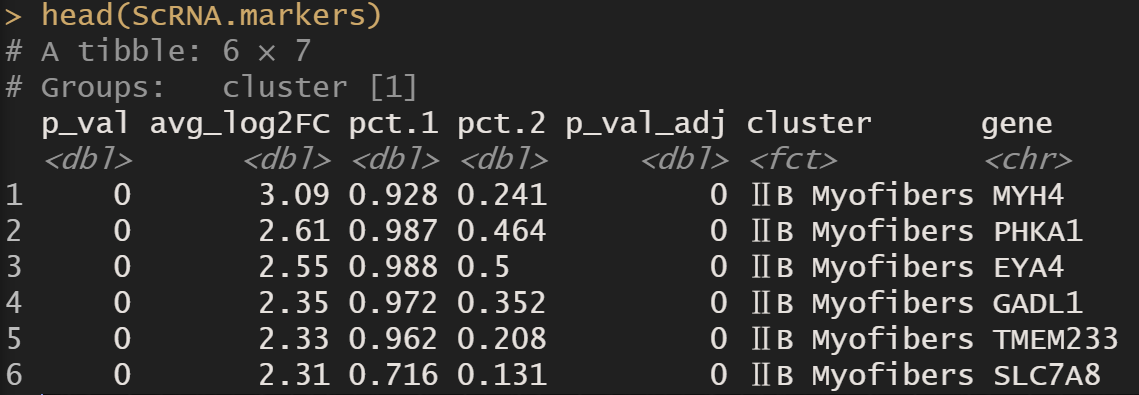

prepareDataFromscRNA 需要数据你的 seurat 对象及差异结果即可。showAverage 参数设为 TRUE 则表示对 基因细胞亚群一样的细胞取均值进行绘图,否则就是所有细胞进行绘图。默认使用 seurat 对象的 RNA assay 的 data 数据。

In [ ]:
# prepare data from seurat object
st.data <- prepareDataFromscRNA(object = ScRNA,
                                diffData = ScRNA.markers,
                                showAverage = TRUE)
# check
str(st.data)

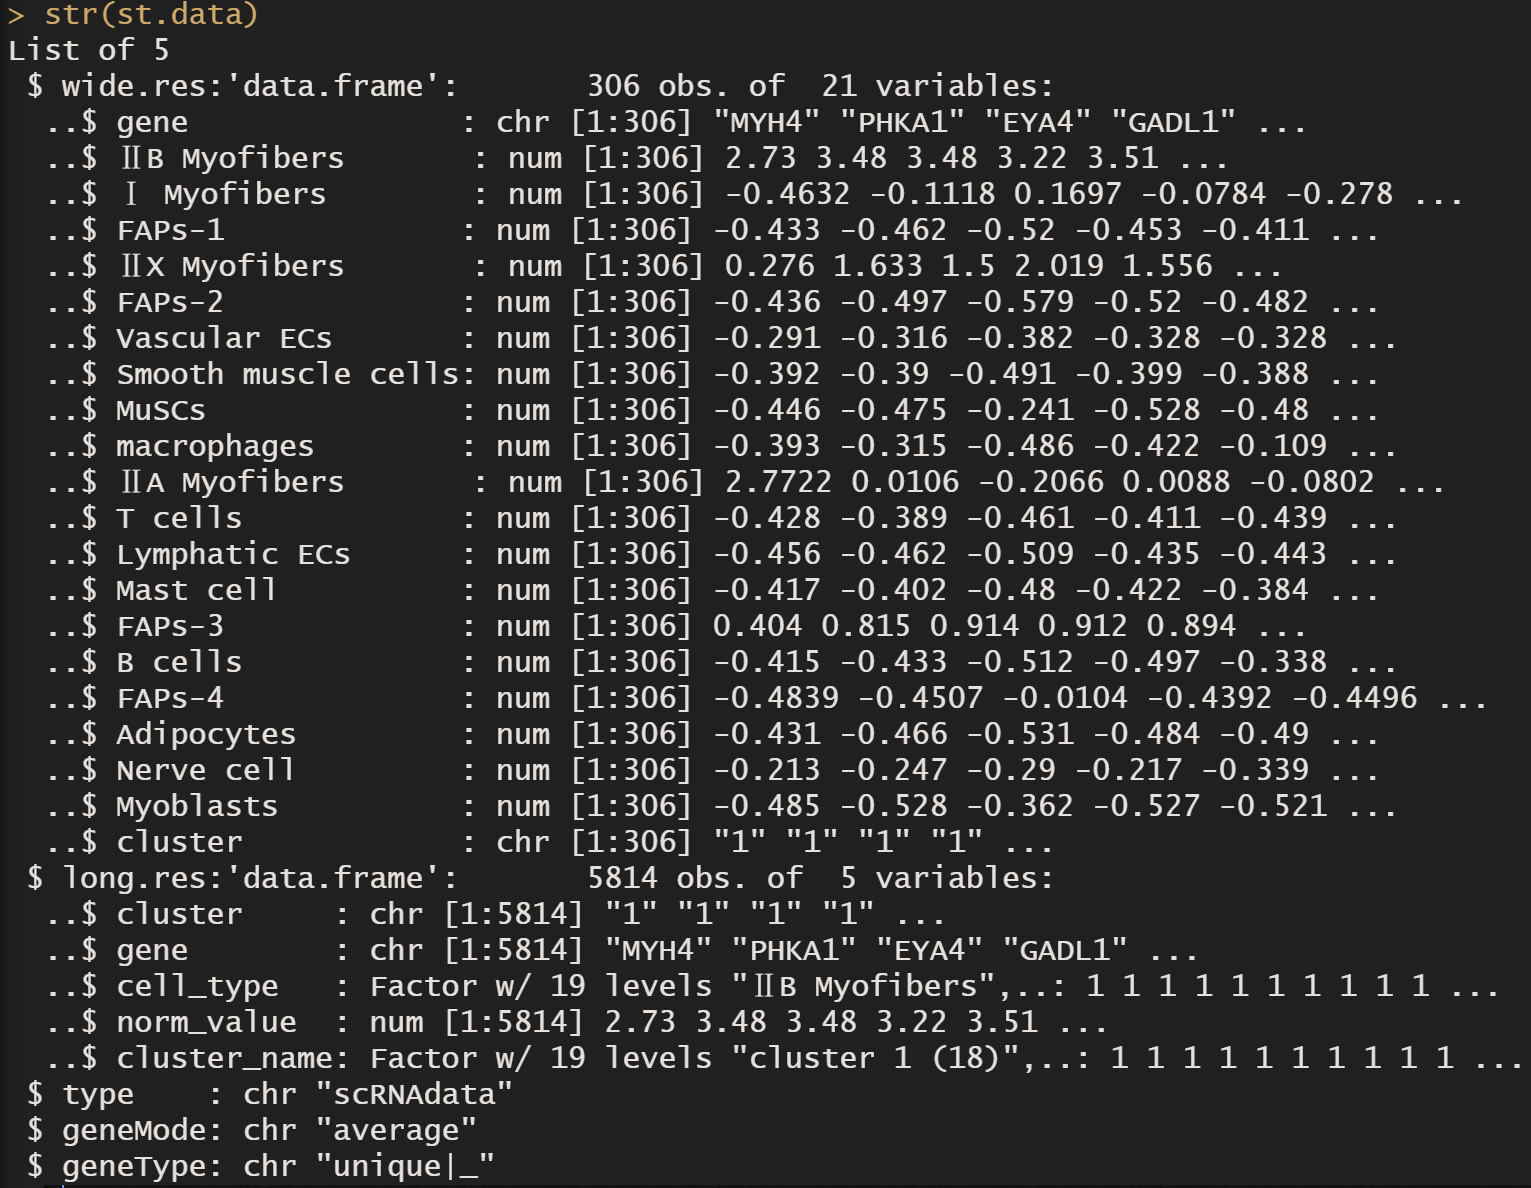

可以看到整理成 clusterData 函数输出的结果一样。包括一个长数据和一个宽数据的数据框。你也可以拿这个数据去自己绘图。

## Enrich analysis

In [ ]:
enrich <- enrichCluster(object = st.data,
                        OrgDb = org.Hs.eg.db,
                        type = "BP",
                        organism = "hsa",
                        pvalueCutoff = 0.5,
                        topn = 5,
                        seed = 5201314)

# check
head(enrich)

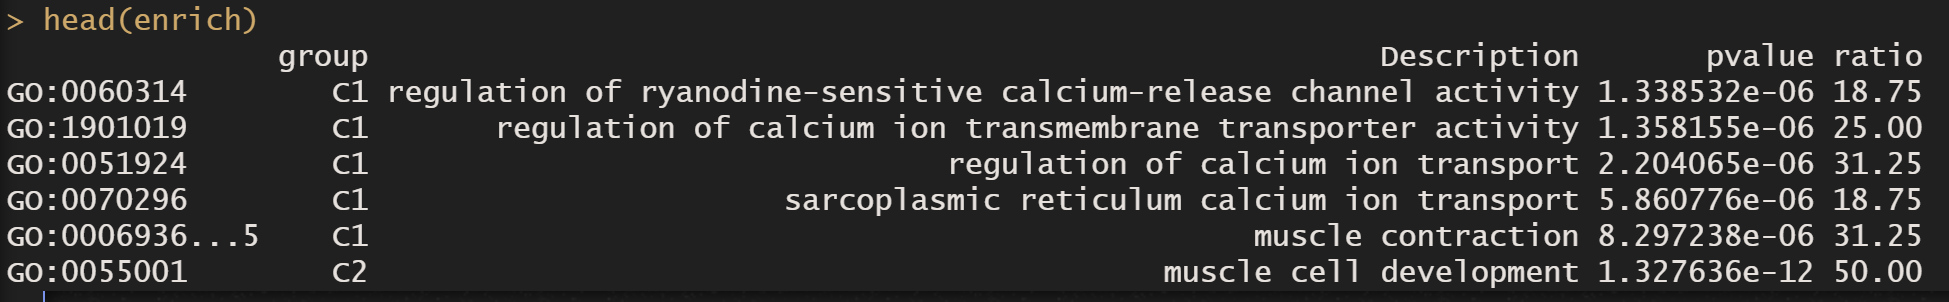

## Visualization

### 折线图:

In [ ]:
# add gene name
markGenes = unique(ScRNA.markers$gene)[sample(1:length(unique(ScRNA.markers$gene)),40,
                                             replace = F)]
# line plot
visCluster(object = st.data,
           plot.type = "line")

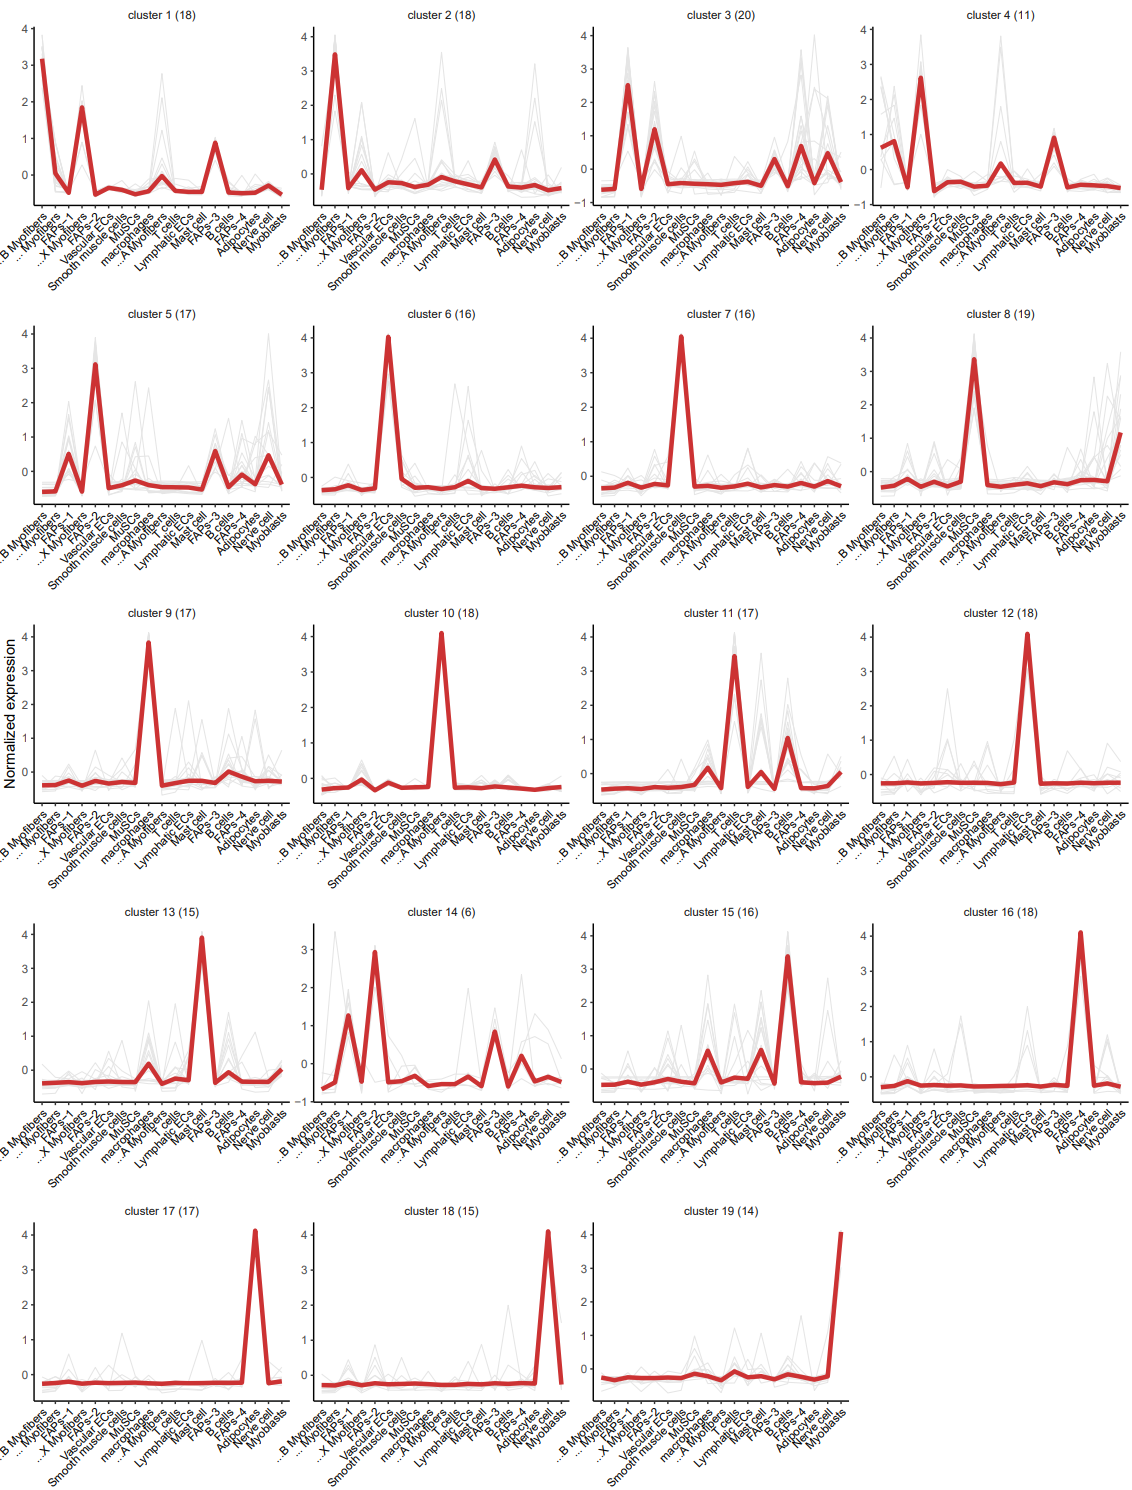

In [ ]:
cm <- clusterData(exp = st.data,
                  cluster.method = "mfuzz",
                  cluster.num = 8)

###  heatmap plot

In [ ]:
visCluster(object = st.data,
           plot.type = "heatmap",
           column_names_rot = 45,
           markGenes=c("MYH7","TNNI1","PPARGC1A","ATP2A2","MYH6","COX1","COX2","MYH1","MYH4","PHKA1","EYA4"),
           cluster.order = c(1:19))
#cluster.order 参数调整聚类顺序。

添加富集注释:

In [ ]:
pdf('sc2.pdf',height = 10,width = 14,onefile = F)
visCluster(object = st.data,
           plot.type = "both",
           column_names_rot = 95,
           show_row_dend = F,
           markGenes = c("MYH7","TNNI1","PPARGC1A","ATP2A2","MYH6","COX1","COX2","MYH1","MYH4","PHKA1","EYA4"),
           markGenes.side = "left",
           annoTerm.data = enrich,
           line.side = "left",
           cluster.order = c(1:19),
           go.col = rep(jjAnno::useMyCol("stallion",n = 9),each = 5),
           add.bar = T)
dev.off()

In [ ]:
visCluster(object = st.data,
           plot.type = "both",
           column_names_rot = 45,
           show_row_dend = F,
           markGenes = c("MYH7","TNNI1","PPARGC1A","ATP2A2","MYH6","COX1","COX2","MYH1","MYH4","PHKA1","EYA4"),
           markGenes.side = "left",
           annoTerm.data = enrich,
           line.side = "left",
           cluster.order = c(1:19),
           go.col = rep(jjAnno::useMyCol("stallion",n = 19),each = 5),
           add.bar = T)

此时，我们每个亚群取了 20,marker 基因绘图,但是从图里看到有些亚群并没有 20 个基因,原因是差异分析时,有多个一样的基因在多个亚群同时是表达差异的。默认会对其进行去重。可能富集的时候会少基因,当然你也可以使用 keep.uniqGene=FALSE 来保留重复基因。

In [ ]:
# retain duplicate diff gene in multiple clusters
st.data <- prepareDataFromscRNA(object = ScRNA,
                                diffData = ScRNA.markers,
                                showAverage = TRUE,
                                keep.uniqGene = FALSE,
                                sep = "_")
# check
df <- st.data$wide.res

In [ ]:
# line plot
visCluster(object = st.data,
           plot.type = "line")

In [ ]:
# heatmap plot
pdf('sc3.pdf',height = 10,width = 6,onefile = F)
visCluster(object = st.data,
           plot.type = "heatmap",
           column_names_rot = 45,
           markGenes = c("MYH7","TNNI1","PPARGC1A","ATP2A2","MYH6","COX1","COX2","MYH1","MYH4","PHKA1","EYA4"),
           cluster.order = c(1:19))
dev.off()
#这些基因在热图上也都会展示:

### 展示所有细胞基因的表达热图

In [ ]:
# no average cells
ScRNA.markers1 <- ScRNA.markers.all %>%
  dplyr::group_by(cluster) %>%
  dplyr::top_n(n = 6, wt = avg_log2FC)

# retain duplicate diff gene in multiple clusters
st.data <- prepareDataFromscRNA(object = ScRNA,
                                diffData = ScRNA.markers1,
                                showAverage = FALSE)

# check
str(st.data)
#设置 show_column_names = F。

改变亚群顺序和修改注释颜色:

In [ ]:
# change celltype order and color
pdf('sc5.pdf',height = 10,width = 8,onefile = F)
visCluster(object = st.data,
           plot.type = "heatmap",
           markGenes = unique(ScRNA.markers$gene),
           column_title_rot = 45,
           cluster.order = 1:19,
           show_column_names = F,
           sample.col = jjAnno::useMyCol("paired",n = 19))
dev.off()

添加富集注释:

In [ ]:
# add GO annotation
pdf('sc6.pdf',height = 12,width = 16,onefile = F)
visCluster(object = st.data,
           plot.type = "both",
           column_title_rot = 45,
           markGenes = unique(ScRNA.markers$gene),
           markGenes.side = "left",
           annoTerm.data = enrich,
           show_column_names = T,
           line.side = "left",
           cluster.order = c(1:19),
           add.bar = T)
dev.off()

In [ ]:
visCluster(object = st.data,plot.type = "both",column_title_rot = 45,markGenes = unique(ScRNA.markers$gene),markGenes.side = "left",add.bar = T,cluster.order = c(1:19),annoTerm.data = enrich)

In [ ]:
features = c("SDHB","IDH3G","DLST","CS","SDHB","MDH2","OGDH","L2HGDH","SDHA","SUCLA2","ACO2","ME2","NNT","ADHFE1","FH1","IDH3B","IDH2","ME3","IDH3A","FAHD1","SUCLG1","SDHC","SUCLG2","D2HGDH")
plots4 <- VlnPlot(Subcluster_MuScle.Sc, features = features, split.by = "orig.ident", group.by = "celltype",pt.size = 0, combine = FALSE)

# Multimodal reference mapping+

[参考资料](https://satijalab.org/seurat/articles/multimodal_reference_mapping.html)

In [ ]:
library(Seurat)
library(SeuratDisk)
library(ggplot2)
library(patchwork)

## A Multimodal PBMC Reference Dataset(构建一个参考群体)

[下载链接](https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat)

In [ ]:
reference <- LoadH5Seurat("D:\\Seurat\\Reference\\pbmc_multimodal.h5seurat")
DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l2", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()

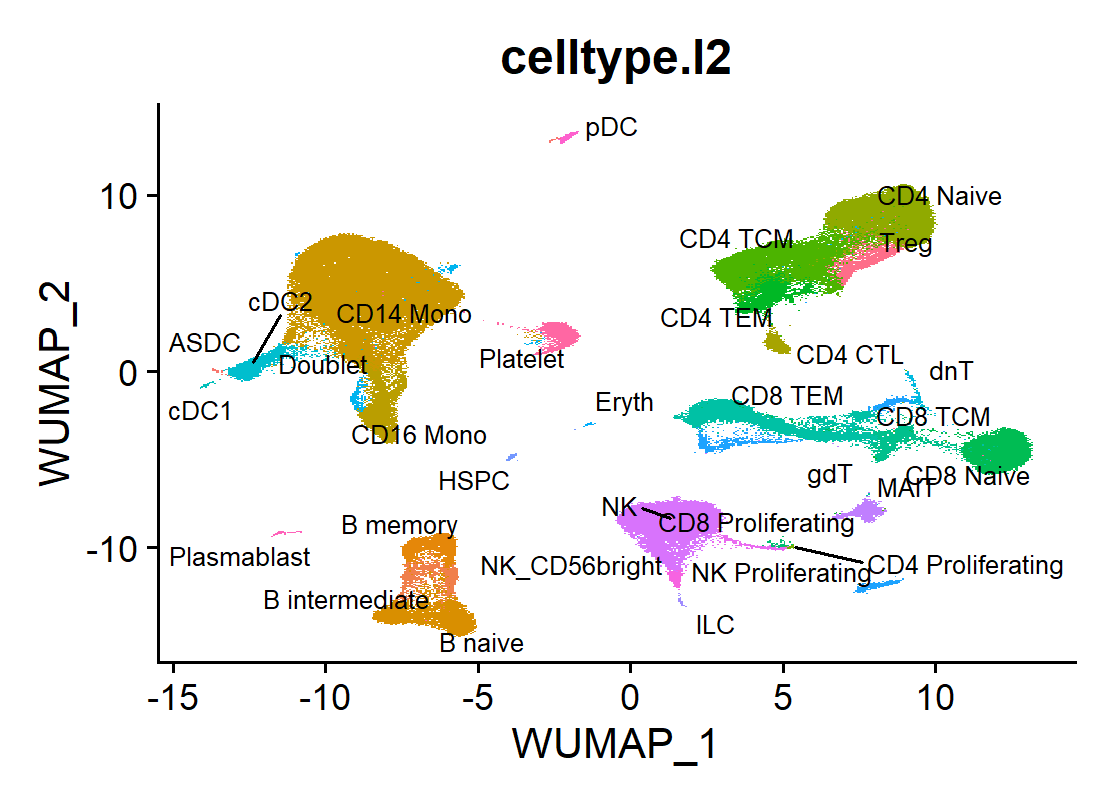

## Mapping

In [ ]:
library(SeuratData)
InstallData('pbmc3k')

In [ ]:
pbmc3k <- SCTransform(pbmc3k, verbose = FALSE)

In [ ]:
anchors <- FindTransferAnchors(
  reference = reference,
  query = pbmc3k,
  normalization.method = "SCT",
  reference.reduction = "spca",
  dims = 1:50
)

In [ ]:
pbmc3k <- MapQuery(
  anchorset = anchors,
  query = pbmc3k,
  reference = reference,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"
  ),
  reference.reduction = "spca", 
  reduction.model = "wnn.umap"
)

## Explore the mapping results

In [ ]:
p1 = DimPlot(pbmc3k, reduction = "ref.umap", group.by = "predicted.celltype.l1", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
p2 = DimPlot(pbmc3k, reduction = "ref.umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 3 ,repel = TRUE) + NoLegend()
p1 + p2

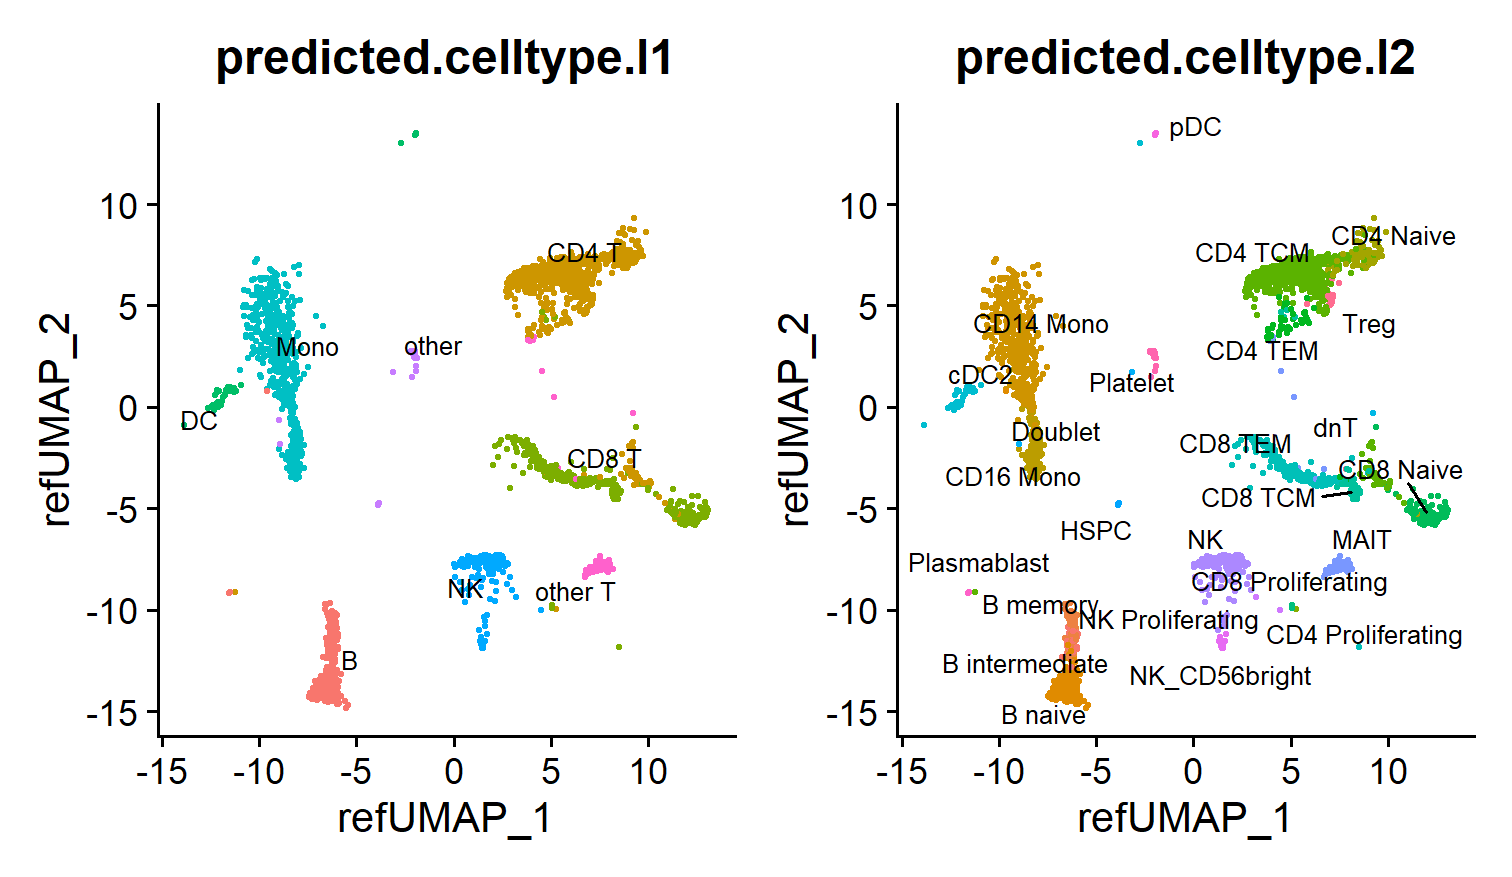

In [ ]:
# 参考群映射到自测数据

## Computing a new UMAP visualiztion

In [ ]:
#merge reference and query
reference$id <- 'reference'
pbmc3k$id <- 'query'
refquery <- merge(reference, pbmc3k)
refquery[["spca"]] <- merge(reference[["spca"]], pbmc3k[["ref.spca"]])
refquery <- RunUMAP(refquery, reduction = 'spca', dims = 1:50)
DimPlot(refquery, group.by = 'id', shuffle = TRUE)

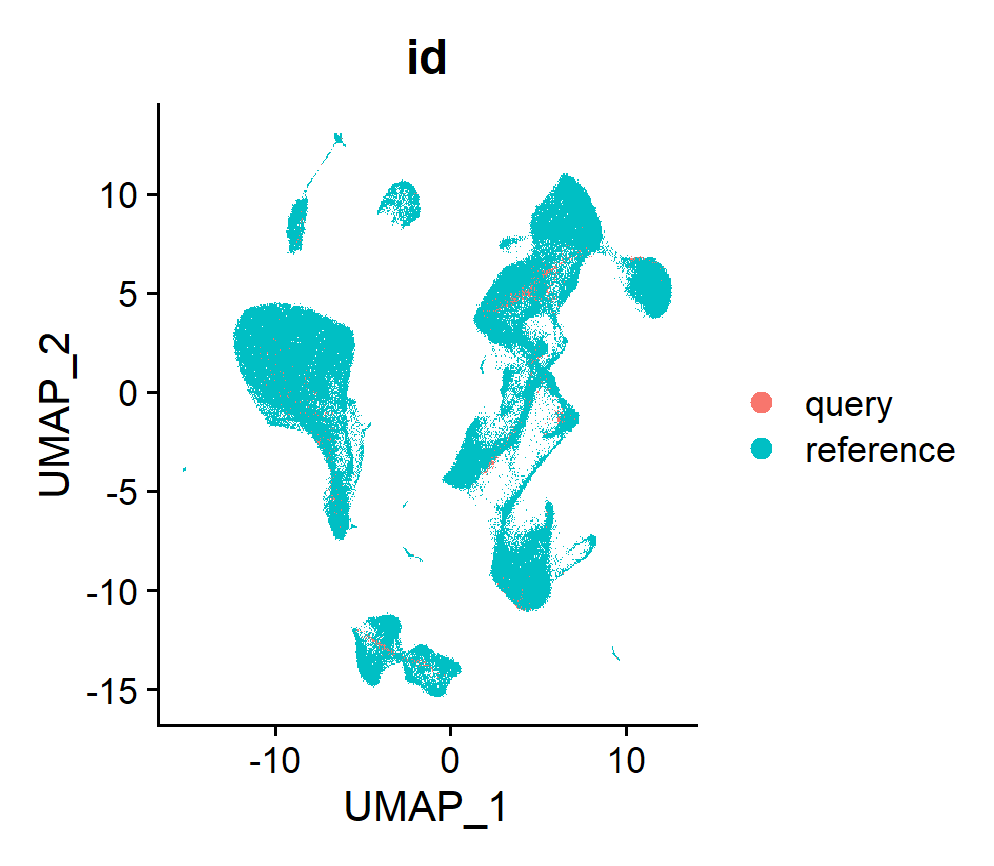

## Example 2: Mapping human bone marrow cells

In [ ]:
# Both datasets are available through SeuratData
library(SeuratData)
#load reference data
InstallData("bmcite")
bm <- LoadData(ds = "bmcite")
#load query data
InstallData('hcabm40k')
hcabm40k <- LoadData(ds = "hcabm40k")

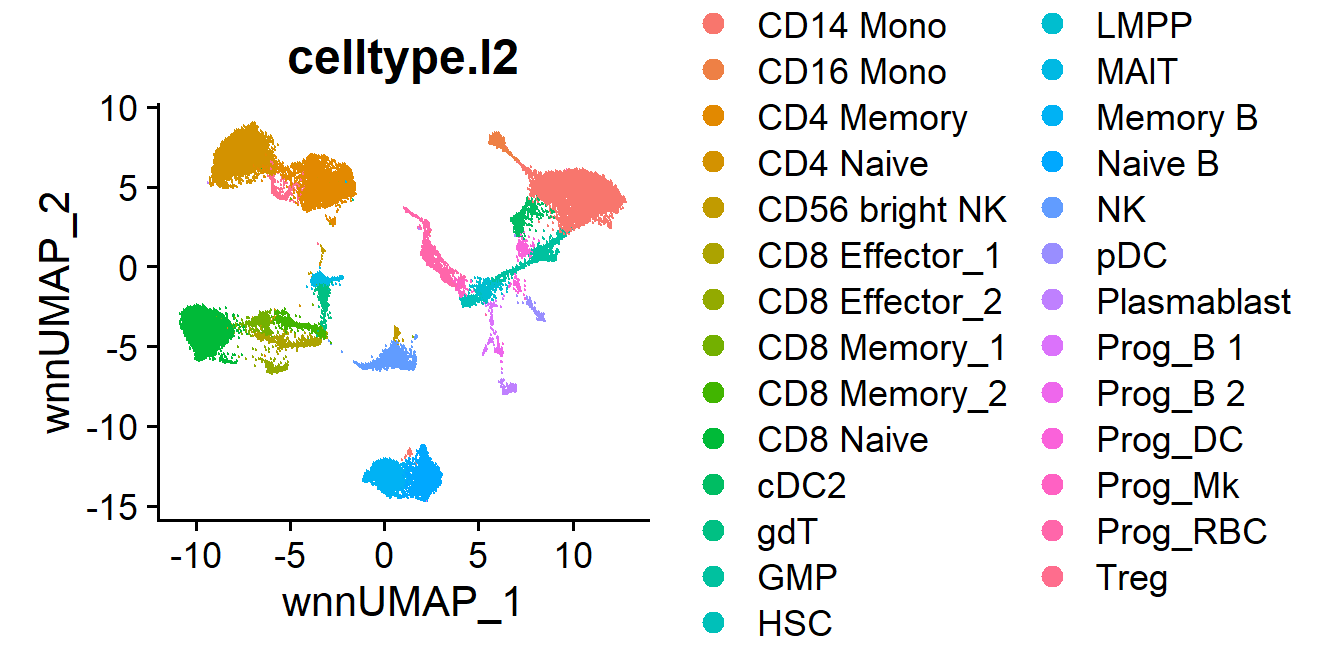

### Computing an sPCA transformation

In [ ]:
bm <- ScaleData(bm, assay = 'RNA')
bm <- RunSPCA(bm, assay = 'RNA', graph = 'wsnn')

### Optional： Computing a cached neighbor index

In [ ]:
bm <- FindNeighbors(
  object = bm,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

### Query dataset preprocessing

In [ ]:
library(dplyr)
library(SeuratData)
InstallData('hcabm40k')
hcabm40k.batches <- SplitObject(hcabm40k, split.by = "orig.ident")
hcabm40k.batches <- lapply(X = hcabm40k.batches, FUN = NormalizeData, verbose = FALSE)
#根据来源分为八类，并进行标准化

### Mapping

In [ ]:
anchors <- list()
for (i in 1:length(hcabm40k.batches)) {
  anchors[[i]] <- FindTransferAnchors(
    reference = bm,
    query = hcabm40k.batches[[i]],
    k.filter = NA,
    reference.reduction = "spca", 
    reference.neighbors = "spca.annoy.neighbors", 
    dims = 1:50
  )
}

In [ ]:
for (i in 1:length(hcabm40k.batches)) {
  hcabm40k.batches[[i]] <- MapQuery(
    anchorset = anchors[[i]], 
    query = hcabm40k.batches[[i]],
    reference = bm, 
    refdata = list(
      celltype = "celltype.l2", 
      predicted_ADT = "ADT"),
    reference.reduction = "spca",
    reduction.model = "wnn.umap"
  )
}

### 展示结果

In [ ]:
p1 <- DimPlot(hcabm40k.batches[[1]], reduction = 'ref.umap', group.by = 'predicted.celltype', label.size = 3)
p2 <- DimPlot(hcabm40k.batches[[2]], reduction = 'ref.umap', group.by = 'predicted.celltype', label.size = 3)
p1 + p2 + plot_layout(guides = "collect")

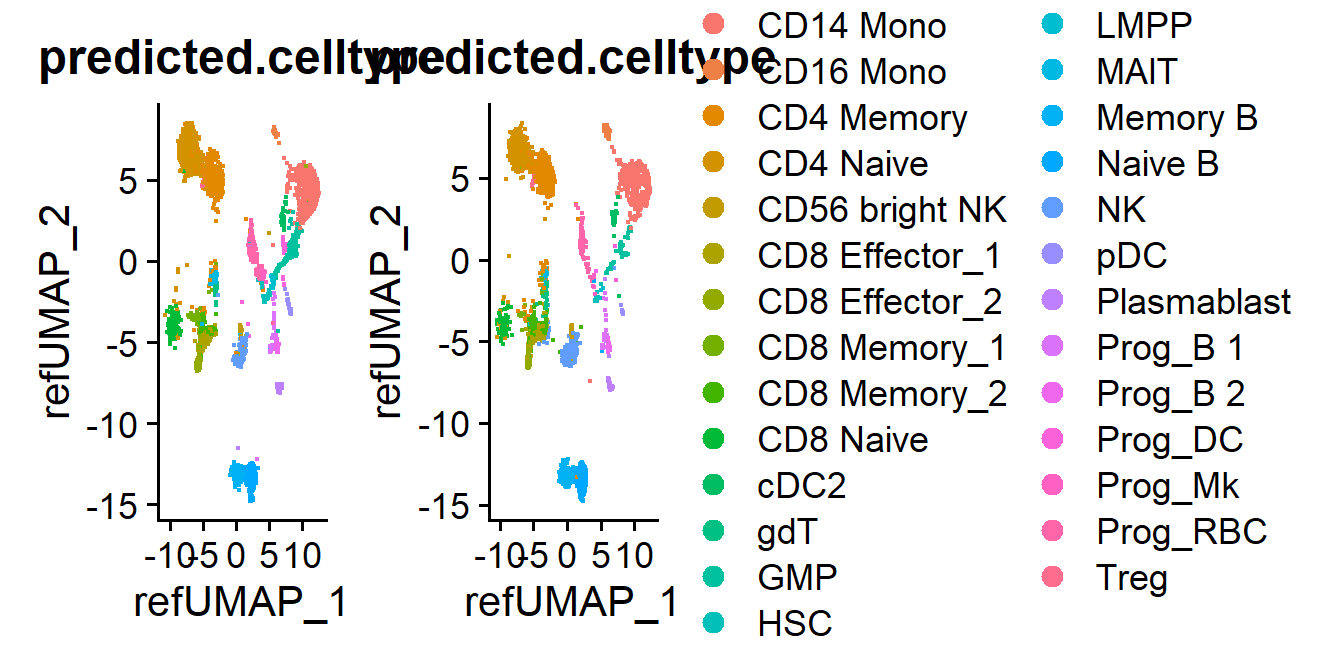

In [ ]:
# Merge the batches 
hcabm40k <- merge(hcabm40k.batches[[1]], hcabm40k.batches[2:length(hcabm40k.batches)], merge.dr = "ref.umap")
DimPlot(hcabm40k, reduction = "ref.umap", group.by =  "predicted.celltype", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()

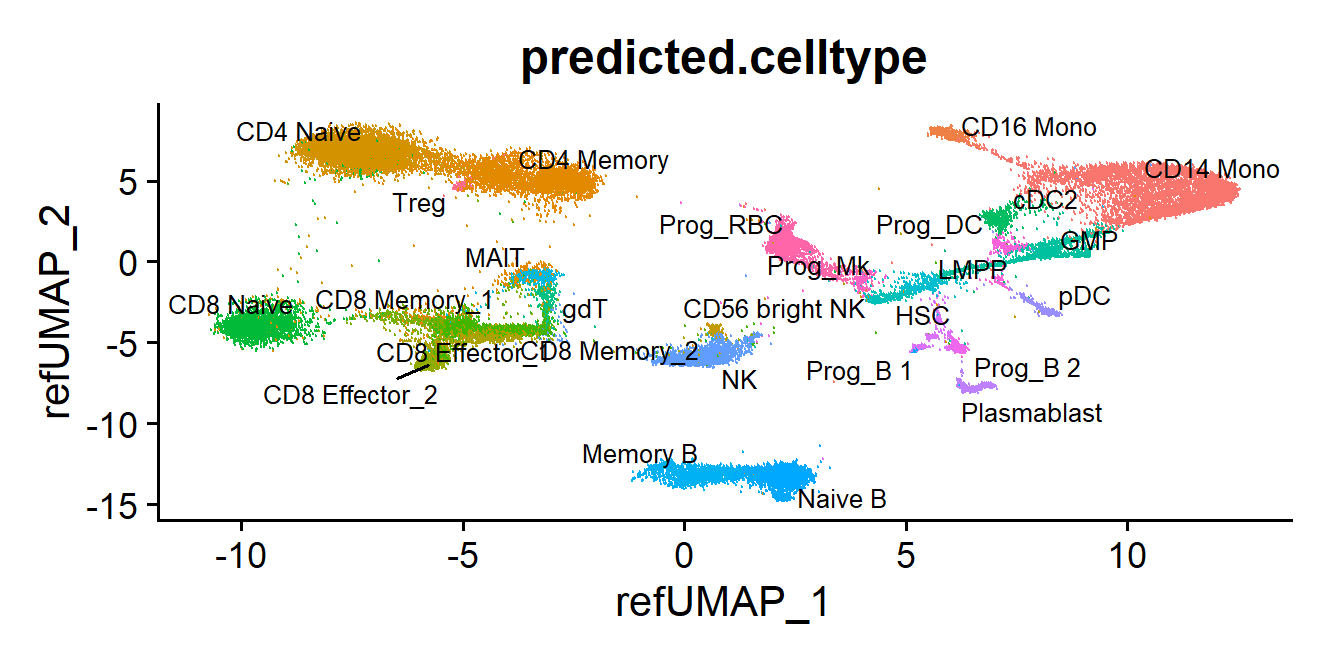

We can visualize gene expression, cluster prediction scores, and (imputed) surface protein levels in the query cells:

In [ ]:
p3 <- FeaturePlot(hcabm40k, features = c("rna_TRDC", "rna_MPO", "rna_AVP"), reduction = 'ref.umap', 
                  max.cutoff = 3, ncol = 3)

# cell type prediction scores
DefaultAssay(hcabm40k) <- 'prediction.score.celltype'
p4 <- FeaturePlot(hcabm40k, features = c("CD16 Mono", "HSC", "Prog-RBC"), ncol = 3, 
                  cols = c("lightgrey", "darkred"))

# imputed protein levels
DefaultAssay(hcabm40k) <- 'predicted_ADT'
p5 <- FeaturePlot(hcabm40k, features = c("CD45RA", "CD16", "CD161"), reduction = 'ref.umap',
                  min.cutoff = 'q10', max.cutoff = 'q99', cols = c("lightgrey", "darkgreen") ,
                  ncol = 3)
p3 / p4 / p5

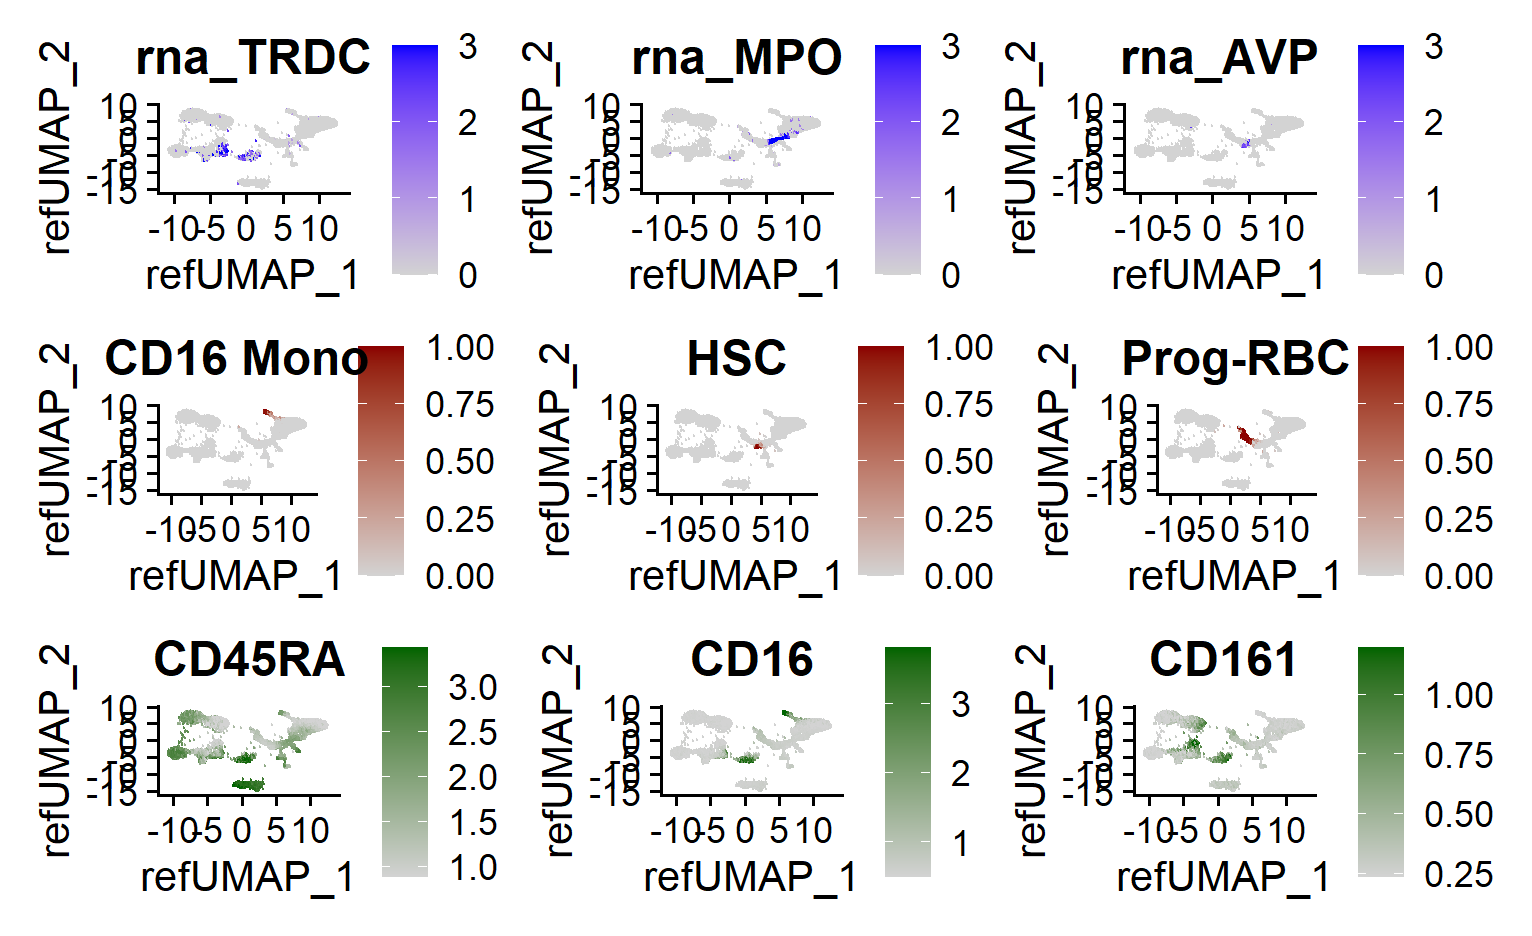

# Results3

In [ ]:
# 雷达图

In [ ]:
DimPlot(sub.myo.sc)

In [ ]:
library(Seurat)
library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)
library(spatstat)
library(spatstat.geom)
library(spatstat.core)

In [ ]:
Cellratio <- prop.table(table(Idents(MuScle.list.Sc), MuScle.list.Sc$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio

## 需要解决的生信分析部分

### 1 细胞群间差异基因比较

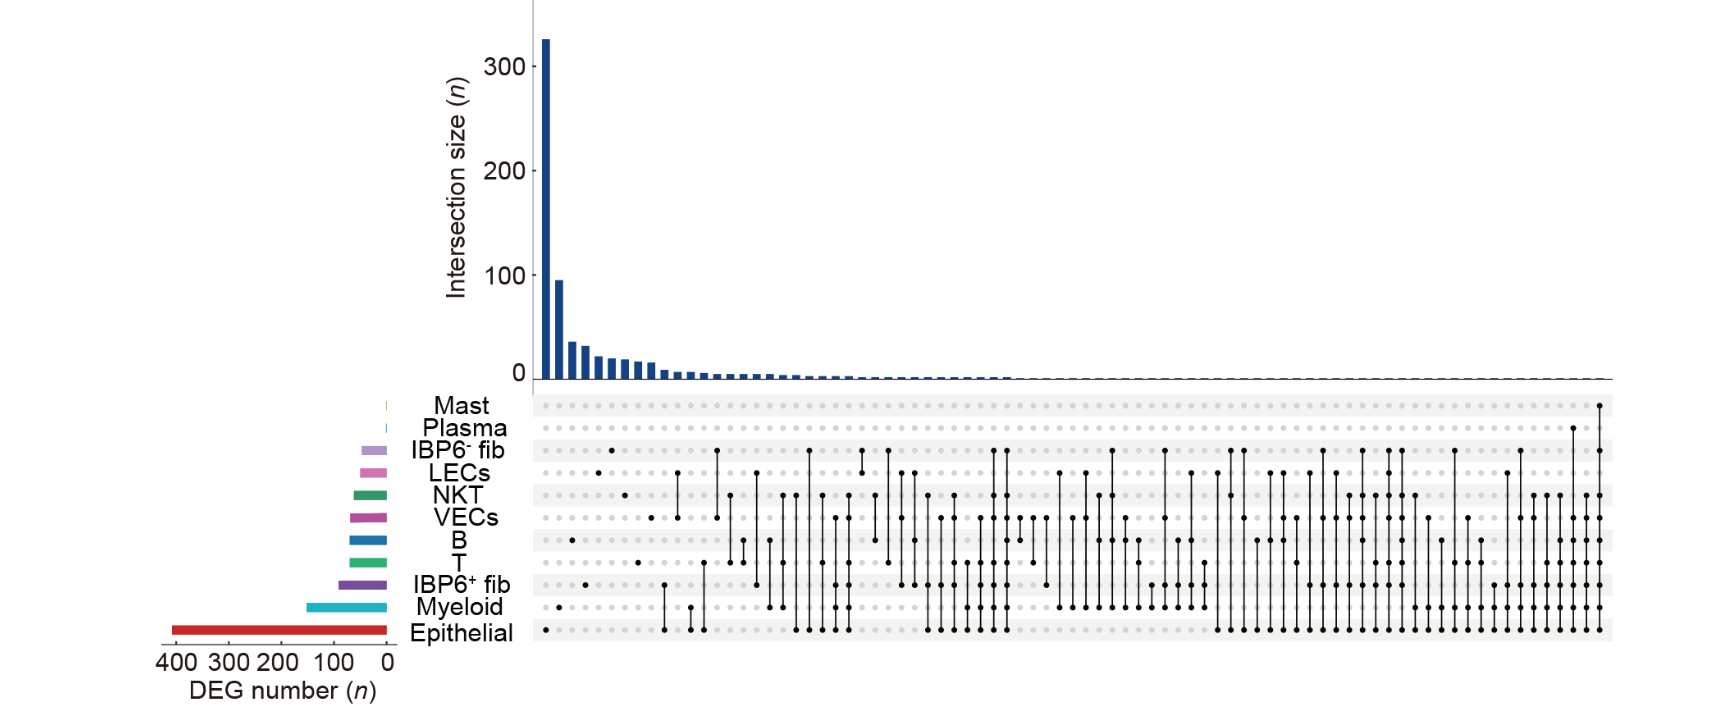

[实现方法](https://github.com/hms-dbmi/UpSetR)

### 2 RCTD反卷积合并单细胞测序和空间转录组

[RCTD实现方法](https://github.com/dmcable/spacexr)  
[MIA实现方法](https://github.com/reubenmoncada/Multimodal-intersection-analysis-MIA-)

### 3 基于空间位置信息的高阶细胞通讯分析

[参考资料-stLearn](https://stlearn.readthedocs.io/en/latest/index.html)

### 3 单细胞自动分析工具CellMarker 2.0的使用

[工具地址](http://bio-bigdata.hrbmu.edu.cn/CellMarker/index.html)

### 4 CNV分析

[参考资料](https://github.com/broadinstitute/inferCNV/wiki)

### 5 数据库

[MSigDB](https://www.gsea-msigdb.org/gsea/msigdb)  
[基于IPA的单细胞分析]